# Gensim Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind the open source NMF implementation in [Gensim](https://github.com/RaRe-Technologies/gensim), including code examples for applying NMF to text processing.

## What's in this tutorial?

1. [Introduction: Why NMF?](#1.-Introduction-to-NMF)
2. [Code example on 20 Newsgroups](#2.-Code-example:-NMF-on-20-Newsgroups)
3. [Benchmarks against Sklearn's NMF and Gensim's LDA](#3.-Benchmarks)
4. [Large-scale NMF training on the English Wikipedia (sparse text vectors)](#4.-NMF-on-English-Wikipedia)
5. [NMF on face decomposition (dense image vectors)](#5.-And-now-for-something-completely-different:-Face-decomposition-from-images)

# 1. Introduction to NMF

## What's in a name?

Gensim's Online Non-Negative Matrix Factorization (NMF, NNMF, ONMF) implementation is based on [Renbo Zhao, Vincent Y. F. Tan: Online Nonnegative Matrix Factorization with Outliers, 2016](https://arxiv.org/abs/1604.02634) and is optimized for extremely large, sparse, streamed inputs. Such inputs happen in NLP with **unsupervised training** on massive text corpora.

* Why **Online**? Because corpora and datasets in modern ML can be very large, and RAM is limited. Unlike batch algorithms, online algorithms learn iteratively, streaming through the available training examples, without loading the entire dataset into RAM or requiring random-access to the data examples.

* Why **Non-Negative**? Because non-negativity leads to more interpretable, sparse "human-friendly" topics. This is in contrast to e.g. SVD (another popular matrix factorization method with [super-efficient implementation in Gensim](https://radimrehurek.com/gensim/models/lsimodel.html)), which produces dense negative factors and thus harder-to-interpret topics.

* **Matrix factorizations** are the corner stone of modern machine learning. They can be used either directly (recommendation systems, bi-clustering, image compression, topic modeling…) or as internal routines in more complex deep learning algorithms.

## How ONNMF works

Terminology:
- `corpus` is a stream of input documents = training examples
- `batch` is a chunk of input corpus, a word-document matrix mini-batch that fits in RAM
- `W` is a word-topic matrix (to be learned; stored in the resulting model)
- `h` is a topic-document matrix (to be learned; not stored, but rather inferred for documents on-the-fly)
- `A`, `B` - matrices that accumulate information from consecutive chunks. `A = h.dot(ht)`, `B = v.dot(ht)`.

The idea behind the algorithm is as follows:

```
    Initialize W, A and B matrices

    for batch in input corpus batches:
        infer h:
            do coordinate gradient descent step to find h that minimizes ||batch - Wh|| in L2 norm

            bound h so that it is non-negative

        update A and B:
            A = h.dot(ht)
            B = batch.dot(ht)

        update W:
            do gradient descent step to find W that minimizes ||0.5*trace(WtWA) - trace(WtB)|| in L2 norm
```

# 2. Code example: NMF on 20 Newsgroups

## Preprocessing

Let's import the models we'll be using throughout this tutorial (`numpy==1.14.2`, `matplotlib==3.0.2`, `pandas==0.24.1`, `sklearn==0.19.1`, `gensim==3.7.1`) and set up logging at INFO level.

Gensim uses logging generously to inform users what's going on. Eyeballing the logs is a good sanity check, to make sure everything is working as expected.

Only `numpy` and `gensim` are actually needed to train and use NMF. The other imports are used only to make our life a little easier in this tutorial.

In [1]:
import logging
import time
from contextlib import contextmanager
import os
from multiprocessing import Process
import psutil

import numpy as np
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score

import gensim.downloader
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel, LsiModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Dataset preparation

Let's load the notorious [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) from Gensim's [repository of pre-trained models and corpora](https://github.com/RaRe-Technologies/gensim-data):

In [2]:
newsgroups = gensim.downloader.load('20-newsgroups')

categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

categories = {name: idx for idx, name in enumerate(categories)}

Create a train/test split:

In [3]:
random_state = RandomState(42)

trainset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'train'
])
random_state.shuffle(trainset)

testset = np.array([
    {
        'data': doc['data'],
        'target': categories[doc['topic']],
    }
    for doc in newsgroups
    if doc['topic'] in categories and doc['set'] == 'test'
])
random_state.shuffle(testset)

We'll use very [simple preprocessing with stemming](https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string) to tokenize each document. YMMV; in your application, use whatever preprocessing makes sense in your domain. Correctly preparing the input has [major impact](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out) on any subsequent ML training.

In [4]:
train_documents = [preprocess_string(doc['data']) for doc in trainset]
test_documents = [preprocess_string(doc['data']) for doc in testset]

### Dictionary compilation

Let's create a mapping between tokens and their ids. Another option would be a [HashDictionary](https://radimrehurek.com/gensim/corpora/hashdictionary.html), saving ourselves one pass over the training documents.

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens

2019-05-06 15:57:16,471 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-05-06 15:57:16,781 : INFO : built Dictionary(25279 unique tokens: ['sketch', 'addario', 'foyer', 'labratsat', 'reclaim']...) from 2819 documents (total 435328 corpus positions)
2019-05-06 15:57:16,809 : INFO : discarding 18198 tokens: [('batka', 1), ('batkaj', 1), ('beatl', 1), ('ccmail', 3), ('dayton', 4), ('edu', 1785), ('inhibit', 1), ('jbatka', 1), ('line', 2748), ('organ', 2602)]...
2019-05-06 15:57:16,810 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-05-06 15:57:16,821 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['colost', 'choke', 'editor', 'china', 'piss']...)


### Create training corpus

Let's vectorize the training corpus into the bag-of-words format. We'll train LDA on a BOW and NMFs on an TF-IDF corpus:

In [6]:
tfidf = TfidfModel(dictionary=dictionary)

train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

train_corpus_tfidf = list(tfidf[train_corpus])

test_corpus_tfidf = list(tfidf[test_corpus])

Here we simply stored the bag-of-words vectors into a `list`, but Gensim accepts [any iterable](https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time) as input, including streamed ones. To learn more about memory-efficient input iterables, see our [Data Streaming in Python: Generators, Iterators, Iterables](https://rare-technologies.com/data-streaming-in-python-generators-iterators-iterables/) tutorial.

## NMF Model Training

The API works in the same way as other Gensim models, such as [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) or [LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html).

Notable model parameters:

- `kappa` float, optional

    Gradient descent step size.
    Larger value makes the model train faster, but could lead to non-convergence if set too large.
    
- `w_max_iter` int, optional

    Maximum number of iterations to train W per each batch.
    
- `w_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``W`` stops for the current batch.
    
- `h_r_max_iter` int, optional

    Maximum number of iterations to train h per each batch.
    
- `h_r_stop_condition` float, optional

    If the error difference gets smaller than this, training of ``h`` stops for the current batch.

Learn an NMF model with 5 topics:

In [7]:
%%time

nmf = GensimNmf(
    corpus=train_corpus_tfidf,
    num_topics=5,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)

2019-05-06 15:57:18,565 : INFO : running NMF training, 5 topics, 5 passes over the supplied corpus of 2819 documents, evaluating l2 norm every 2819 documents
2019-05-06 15:57:18,581 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-05-06 15:57:18,604 : INFO : W error: -11.552583824232896
2019-05-06 15:57:18,619 : INFO : PROGRESS: pass 0, at document #2000/2819
2019-05-06 15:57:18,627 : INFO : W error: -13.74803744073488
2019-05-06 15:57:18,639 : INFO : PROGRESS: pass 0, at document #2819/2819
2019-05-06 15:57:18,735 : INFO : L2 norm: 28.141396382337142
2019-05-06 15:57:18,770 : INFO : topic #0 (0.395): 0.011*"isra" + 0.010*"israel" + 0.006*"arab" + 0.006*"jew" + 0.004*"palestinian" + 0.004*"henri" + 0.003*"toronto" + 0.003*"question" + 0.003*"kill" + 0.003*"hernlem"
2019-05-06 15:57:18,771 : INFO : topic #1 (0.352): 0.008*"space" + 0.005*"access" + 0.005*"nasa" + 0.004*"pat" + 0.003*"digex" + 0.003*"orbit" + 0.003*"shuttl" + 0.003*"data" + 0.003*"graphic" + 0.003*"com"
2019-05-06 

CPU times: user 1.52 s, sys: 1.84 s, total: 3.36 s
Wall time: 947 ms


In [8]:
W = nmf.get_topics().T

dense_test_corpus = matutils.corpus2dense(
    test_corpus_tfidf,
    num_terms=W.shape[0],
)

if isinstance(nmf, SklearnNmf):
    H = nmf.transform(dense_test_corpus.T).T
else:
    H = np.zeros((nmf.num_topics, len(test_corpus_tfidf)))
    for bow_id, bow in enumerate(test_corpus_tfidf):
        for topic_id, word_count in nmf[bow]:
            H[topic_id, bow_id] = word_count

In [9]:
np.linalg.norm(W.dot(H))

1.105176733465657

In [10]:
np.linalg.norm(dense_test_corpus)

43.312817

### View the learned topics

In [11]:
nmf.show_topics()

[(0,
  '0.015*"israel" + 0.014*"isra" + 0.009*"arab" + 0.008*"jew" + 0.005*"palestinian" + 0.004*"lebanes" + 0.004*"peac" + 0.004*"attack" + 0.004*"lebanon" + 0.003*"polici"'),
 (1,
  '0.007*"space" + 0.005*"nasa" + 0.003*"access" + 0.003*"orbit" + 0.003*"launch" + 0.003*"pat" + 0.003*"gov" + 0.003*"com" + 0.002*"alaska" + 0.002*"moon"'),
 (2,
  '0.023*"armenian" + 0.011*"turkish" + 0.008*"armenia" + 0.007*"argic" + 0.007*"turk" + 0.007*"serdar" + 0.006*"turkei" + 0.005*"greek" + 0.005*"genocid" + 0.005*"soviet"'),
 (3,
  '0.016*"moral" + 0.015*"keith" + 0.007*"object" + 0.007*"caltech" + 0.006*"schneider" + 0.005*"allan" + 0.005*"cco" + 0.004*"anim" + 0.004*"natur" + 0.004*"goal"'),
 (4,
  '0.012*"god" + 0.012*"islam" + 0.006*"jaeger" + 0.006*"sgi" + 0.005*"livesei" + 0.005*"muslim" + 0.005*"atheist" + 0.005*"religion" + 0.005*"atheism" + 0.004*"rushdi"')]

### Evaluation measure: Coherence

[Topic coherence](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) measures how often do most frequent tokens from each topic co-occur in one document. Larger is better.

In [12]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus_tfidf,
    coherence='u_mass'
).get_coherence()

2019-05-06 15:57:20,590 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-4.1310114675795875

## Topic inference on new documents

With the NMF model trained, let's fetch one news document not seen during training, and infer its topic vector.

In [13]:
print(testset[0]['data'])
print('=' * 100)
print("Topics: {}".format(nmf[test_corpus[0]]))

From: spl@ivem.ucsd.edu (Steve Lamont)
Subject: Re: RGB to HVS, and back
Organization: University of Calif., San Diego/Microscopy and Imaging Resource
Lines: 18
Distribution: world
NNTP-Posting-Host: ivem.ucsd.edu

In article <ltu4buINNe7j@caspian.usc.edu> zyeh@caspian.usc.edu (zhenghao yeh) writes:
>|> See Foley, van Dam, Feiner, and Hughes, _Computer Graphics: Principles
>|> and Practice, Second Edition_.
>|> 
>|> [If people would *read* this book, 75 percent of the questions in this
>|> froup would disappear overnight...]
>|> 
>	Not really. I think it is less than 10%.

Nah... I figure most people would be so busy reading that they wouldn't
have *time* to post. :-) :-) :-)

							spl
-- 
Steve Lamont, SciViGuy -- (619) 534-7968 -- spl@szechuan.ucsd.edu
San Diego Microscopy and Imaging Resource/UC San Diego/La Jolla, CA 92093-0608
"Until I meet you, then, in Upper Hell
Convulsed, foaming immortal blood: farewell" - J. Berryman, "A Professor's Song"

Topics: [(0, 0.10199317206513686)

## Word topic inference

Similarly, we can inspect the topic distribution assigned to a vocabulary term:

In [14]:
word = dictionary[0]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: actual
Topics: [(0, 0.15401782844659068), (1, 0.2829834256007429), (2, 0.04354905106817273), (3, 0.25783766798021135), (4, 0.26161202690428226)]


### Internal NMF state

Density is a fraction of non-zero elements in a matrix.

In [15]:
def density(matrix):
    return (matrix > 0).mean()

Term-topic matrix of shape `(words, topics)`.

In [16]:
print("Density: {}".format(density(nmf._W)))

Density: 0.6872475639034035


Topic-document matrix for the last batch of shape `(topics, batch)`

In [17]:
print("Density: {}".format(density(nmf._h)))

Density: 0.6615384615384615


# 3. Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

We'll run these three unsupervised models on the [20newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset.

20 Newsgroups also contains labels for each document, which will allow us to evaluate the trained models on an "upstream" classification task, using the unsupervised document topics as input features.

### Metrics

We'll track these metrics as we train and test NMF on the 20-newsgroups corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score (larger is better).
- `l2_norm` - L2 norm of `v - Wh` (less is better, not defined for LDA).
- `f1` - [F1 score](https://en.wikipedia.org/wiki/F1_score) on the task of news topic classification (larger is better).

In [18]:
fixed_params = dict(
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
)

In [19]:
@contextmanager
def measure_ram(output, tick=5):
    def _measure_ram(pid, output, tick=tick):
        py = psutil.Process(pid)
        with open(output, 'w') as outfile:
            while True:
                memory = py.memory_info().rss
                outfile.write("{}\n".format(memory))
                outfile.flush()
                time.sleep(tick)

    pid = os.getpid()
    p = Process(target=_measure_ram, args=(pid, output, tick))
    p.start()
    yield
    p.terminate()


def get_train_time_and_ram(func, name, tick=5):
    memprof_filename = "{}.memprof".format(name)

    start = time.time()

    with measure_ram(memprof_filename, tick=tick):
        result = func()

    elapsed_time = pd.to_timedelta(time.time() - start, unit='s').round('ms')

    memprof_df = pd.read_csv(memprof_filename, squeeze=True)

    mean_ram = "{} MB".format(
        int(memprof_df.mean() // 2 ** 20),
    )

    max_ram = "{} MB".format(int(memprof_df.max() // 2 ** 20))

    return elapsed_time, mean_ram, max_ram, result


def get_f1(model, train_corpus, X_test, y_train, y_test):
    if isinstance(model, SklearnNmf):
        dense_train_corpus = matutils.corpus2dense(
            train_corpus,
            num_terms=model.components_.shape[1],
        )
        X_train = model.transform(dense_train_corpus.T)
    else:
        X_train = np.zeros((len(train_corpus), model.num_topics))
        for bow_id, bow in enumerate(train_corpus):
            for topic_id, word_count in model[bow]:
                X_train[bow_id, topic_id] = word_count

    log_reg = LogisticRegressionCV(multi_class='multinomial', cv=5)
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')

def get_sklearn_topics(model, top_n=5):
    topic_probas = model.components_.T
    topic_probas = topic_probas / topic_probas.sum(axis=0)

    sparsity = np.zeros(topic_probas.shape[1])

    for row in topic_probas:
        sparsity += (row == 0)

    sparsity /= topic_probas.shape[1]

    topic_probas = topic_probas[:, sparsity.argsort()[::-1]][:, :top_n]

    token_indices = topic_probas.argsort(axis=0)[:-11:-1, :]
    topic_probas.sort(axis=0)
    topic_probas = topic_probas[:-11:-1, :]

    topics = []

    for topic_idx in range(topic_probas.shape[1]):
        tokens = [
            model.id2word[token_idx]
            for token_idx
            in token_indices[:, topic_idx]
        ]
        topic = (
            '{}*"{}"'.format(round(proba, 3), token)
            for proba, token
            in zip(topic_probas[:, topic_idx], tokens)
        )
        topic = " + ".join(topic)
        topics.append((topic_idx, topic))

    return topics

def get_metrics(model, test_corpus, train_corpus=None, y_train=None, y_test=None, dictionary=None):
    if isinstance(model, SklearnNmf):
        model.get_topics = lambda: model.components_
        model.show_topics = lambda top_n: get_sklearn_topics(model, top_n)
        model.id2word = dictionary

    W = model.get_topics().T

    dense_test_corpus = matutils.corpus2dense(
        test_corpus,
        num_terms=W.shape[0],
    )

    if isinstance(model, SklearnNmf):
        H = model.transform(dense_test_corpus.T).T
    else:
        H = np.zeros((model.num_topics, len(test_corpus)))
        for bow_id, bow in enumerate(test_corpus):
            for topic_id, word_count in model[bow]:
                H[topic_id, bow_id] = word_count

    l2_norm = None

    if not isinstance(model, LdaModel):
        pred_factors = W.dot(H)

        l2_norm = np.linalg.norm(pred_factors - dense_test_corpus)
        l2_norm = round(l2_norm, 4)

    f1 = None

    if train_corpus and y_train and y_test:
        f1 = get_f1(model, train_corpus, H.T, y_train, y_test)
        f1 = round(f1, 4)

    model.normalize = True

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()
    coherence = round(coherence, 4)

    topics = model.show_topics(5)

    model.normalize = False

    return dict(
        coherence=coherence,
        l2_norm=l2_norm,
        f1=f1,
        topics=topics,
    )

### Run the models

In [20]:
tm_metrics = pd.DataFrame(columns=['model', 'train_time', 'coherence', 'l2_norm', 'f1', 'topics'])

y_train = [doc['target'] for doc in trainset]
y_test = [doc['target'] for doc in testset]

# LDA metrics
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(
        corpus=train_corpus,
        **fixed_params,
    ),
    'lda',
    0.1,
)
row.update(get_metrics(
    lda, test_corpus, train_corpus, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# LSI metrics
row = {}
row['model'] = 'lsi'
row['train_time'], row['mean_ram'], row['max_ram'], lsi = get_train_time_and_ram(
    lambda: LsiModel(
        corpus=train_corpus_tfidf,
        num_topics=5,
        id2word=dictionary,
        chunksize=2000,
    ),
    'lsi',
    0.1,
)
row.update(get_metrics(
    lsi, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = {}
row['model'] = 'sklearn_nmf'
train_csc_corpus_tfidf = matutils.corpus2csc(train_corpus_tfidf, len(dictionary)).T
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: SklearnNmf(n_components=5, random_state=42).fit(train_csc_corpus_tfidf),
    'sklearn_nmf',
    0.1,
)
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test, dictionary,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Gensim NMF metrics
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], gensim_nmf = get_train_time_and_ram(
    lambda: GensimNmf(
        normalize=False,
        corpus=train_corpus_tfidf,
        **fixed_params
    ),
    'gensim_nmf',
    0.1,
)
row.update(get_metrics(
    gensim_nmf, test_corpus_tfidf, train_corpus_tfidf, y_train, y_test,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)
tm_metrics.replace(np.nan, '-', inplace=True)

2019-05-06 15:57:20,790 : INFO : using symmetric alpha at 0.2
2019-05-06 15:57:20,792 : INFO : using symmetric eta at 0.2
2019-05-06 15:57:20,793 : INFO : using serial LDA version on this node
2019-05-06 15:57:20,798 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-05-06 15:57:20,800 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-05-06 15:57:21,377 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-05-06 15:57:21,379 : INFO : topic #0 (0.200): 0.006*"com" + 0.006*"like" + 0.006*"space" + 0.004*"univers" + 0.004*"know" + 0.004*"nntp" + 0.004*"imag" + 0.004*"nasa" + 0.004*"time" + 0.004*"program"
2019-05-06 15:57:21,380 : INFO : topic #1 (0.200): 0.007*"imag" + 0.005*"com" + 0.004*"peopl" + 0.004*"know" + 0.004*"univers" + 0.004*"nntp" + 0.004

2019-05-06 15:57:24,801 : INFO : topic diff=0.416347, rho=0.455535
2019-05-06 15:57:24,801 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-05-06 15:57:25,216 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-05-06 15:57:25,218 : INFO : topic #0 (0.200): 0.011*"space" + 0.007*"imag" + 0.006*"nasa" + 0.006*"com" + 0.006*"graphic" + 0.006*"program" + 0.005*"file" + 0.005*"data" + 0.005*"orbit" + 0.004*"new"
2019-05-06 15:57:25,219 : INFO : topic #1 (0.200): 0.010*"com" + 0.006*"imag" + 0.006*"like" + 0.006*"nntp" + 0.006*"host" + 0.006*"univers" + 0.005*"bit" + 0.005*"know" + 0.005*"think" + 0.005*"work"
2019-05-06 15:57:25,219 : INFO : topic #2 (0.200): 0.011*"peopl" + 0.009*"armenian" + 0.007*"turkish" + 0.007*"said" + 0.007*"right" + 0.006*"jew" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"like"
2019-05-06 15:57:25,220 : INFO : topic #3 (0.200): 0.010*"com" + 0.010*"israel" + 0.008*"bike" + 0.006*"isra" + 0.005*"like" + 0.004*"dod" + 0.004

2019-05-06 15:57:28,467 : INFO : topic #1 (0.200): 0.013*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"univers" + 0.006*"know" + 0.005*"bit" + 0.005*"think" + 0.005*"time" + 0.005*"work"
2019-05-06 15:57:28,468 : INFO : topic #2 (0.200): 0.013*"armenian" + 0.011*"peopl" + 0.008*"turkish" + 0.007*"said" + 0.007*"jew" + 0.006*"right" + 0.006*"kill" + 0.005*"know" + 0.005*"isra" + 0.005*"arab"
2019-05-06 15:57:28,468 : INFO : topic #3 (0.200): 0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.007*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"host" + 0.005*"nntp" + 0.005*"ride" + 0.005*"think"
2019-05-06 15:57:28,469 : INFO : topic #4 (0.200): 0.011*"god" + 0.008*"peopl" + 0.006*"think" + 0.006*"exist" + 0.006*"islam" + 0.005*"atheist" + 0.005*"believ" + 0.005*"com" + 0.005*"univers" + 0.005*"moral"
2019-05-06 15:57:28,469 : INFO : topic diff=0.202107, rho=0.357622
2019-05-06 15:57:28,470 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-05-06 15:57:28,837 : INFO : merging 

/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019-05-06 15:57:36,849 : INFO : CorpusAccumulator accumulated stats from 1000 documents
/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/anotherbugmaster/.local/lib/python3.5

2019-05-06 15:57:40,700 : INFO : W error: -18.84541532652092
2019-05-06 15:57:40,714 : INFO : PROGRESS: pass 4, at document #1000/2819
2019-05-06 15:57:40,719 : INFO : W error: -19.091058241700402
2019-05-06 15:57:40,734 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-05-06 15:57:40,739 : INFO : W error: -19.338453391122066
2019-05-06 15:57:40,751 : INFO : PROGRESS: pass 4, at document #2819/2819
2019-05-06 15:57:40,868 : INFO : L2 norm: 27.988158841345246
2019-05-06 15:57:40,905 : INFO : topic #0 (0.352): 0.014*"israel" + 0.013*"isra" + 0.008*"arab" + 0.007*"jew" + 0.005*"palestinian" + 0.004*"lebanes" + 0.004*"peac" + 0.003*"attack" + 0.003*"lebanon" + 0.003*"polici"
2019-05-06 15:57:40,906 : INFO : topic #1 (0.210): 0.010*"space" + 0.007*"nasa" + 0.005*"access" + 0.004*"orbit" + 0.004*"launch" + 0.004*"pat" + 0.004*"gov" + 0.004*"com" + 0.004*"alaska" + 0.004*"graphic"
2019-05-06 15:57:40,907 : INFO : topic #2 (0.282): 0.021*"armenian" + 0.010*"turkish" + 0.007*"armenia" + 0.

## Benchmark results

In [21]:
tm_metrics.drop('topics', axis=1)

model      train_time  coherence  l2_norm      f1 max_ram mean_ram
0          lda 00:00:08.862000    -2.1054        -  0.7511  366 MB   366 MB
1          lsi 00:00:00.332000    -5.7010  42.4642  0.8587  381 MB   379 MB
2  sklearn_nmf 00:00:00.166000    -3.1835  42.4759  0.7889  378 MB   378 MB
3   gensim_nmf 00:00:00.954000    -4.1310  42.5487  0.8065  379 MB   379 MB

### Main insights

- LDA has the best coherence of all models.
- LSI has the best l2 norm and f1 performance on downstream task (it's factors aren't non-negative though).
- Gensim NMF, Sklearn NMF and LSI has a bit larger memory footprint than that of LDA.
- Gensim NMF, Sklearn NMF and LSI are much faster than LDA.

### Learned topics

Let's inspect the 5 topics learned by each of the three models:

In [22]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


lda:
(0, '0.013*"space" + 0.008*"imag" + 0.007*"nasa" + 0.006*"graphic" + 0.006*"program" + 0.005*"launch" + 0.005*"file" + 0.005*"com" + 0.005*"new" + 0.004*"orbit"')
(1, '0.015*"com" + 0.007*"like" + 0.007*"nntp" + 0.007*"host" + 0.006*"know" + 0.006*"univers" + 0.005*"henri" + 0.005*"work" + 0.005*"bit" + 0.005*"think"')
(2, '0.014*"armenian" + 0.011*"peopl" + 0.009*"turkish" + 0.007*"jew" + 0.007*"said" + 0.006*"right" + 0.005*"know" + 0.005*"kill" + 0.005*"isra" + 0.005*"turkei"')
(3, '0.012*"com" + 0.010*"israel" + 0.009*"bike" + 0.006*"isra" + 0.006*"dod" + 0.005*"like" + 0.005*"ride" + 0.005*"host" + 0.005*"nntp" + 0.005*"motorcycl"')
(4, '0.011*"god" + 0.008*"peopl" + 0.007*"think" + 0.006*"exist" + 0.006*"univers" + 0.005*"com" + 0.005*"believ" + 0.005*"islam" + 0.005*"moral" + 0.005*"christian"')

lsi:
(0, '0.157*"armenian" + 0.118*"israel" + 0.110*"peopl" + 0.110*"isra" + 0.105*"space" + 0.098*"com" + 0.097*"god" + 0.084*"jew" + 0.082*"think" + 0.081*"turkish"')
(1, '-0.47

Subjectively, Gensim and Sklearn NMFs are on par with each other, LDA and LSI look a bit worse.

# 4. NMF on English Wikipedia

This section shows how to train an NMF model on a large text corpus, the entire English Wikipedia: **2.6 billion words, in 23.1 million article sections across 5 million Wikipedia articles**.

The data preprocessing takes a while, and we'll be comparing multiple models, so **reserve about 3 hours** and some **20 GB of disk space** to go through the following notebook cells in full. You'll need `gensim>=3.7.1`, `numpy`, `tqdm`, `pandas`, `psutils`, `joblib` and `sklearn`.

In [23]:
# Re-import modules from scratch, so that this Section doesn't rely on any previous cells.
import itertools
import json
import logging
import time
import os

from smart_open import smart_open
import psutil
import numpy as np
import scipy.sparse
from contextlib import contextmanager, contextmanager, contextmanager
from multiprocessing import Process
from tqdm import tqdm, tqdm_notebook
import joblib
import pandas as pd
from sklearn.decomposition.nmf import NMF as SklearnNmf

import gensim.downloader
from gensim import matutils
from gensim.corpora import MmCorpus, Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.utils import simple_preprocess

tqdm.pandas()

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Load the Wikipedia dump

We'll use the [gensim.downloader](https://github.com/RaRe-Technologies/gensim-data) to download a parsed Wikipedia dump (6.1 GB disk space):

In [24]:
data = gensim.downloader.load("wiki-english-20171001")

Print the titles and sections of the first Wikipedia article, as a little sanity check:

In [25]:
data = gensim.downloader.load("wiki-english-20171001")
article = next(iter(data))

print("Article: %r\n" % article['title'])
for section_title, section_text in zip(article['section_titles'], article['section_texts']):
    print("Section title: %r" % section_title)
    print("Section text: %s…\n" % section_text[:100].replace('\n', ' ').strip())

Article: 'Anarchism'

Section title: 'Introduction'
Section text: '''Anarchism''' is a political philosophy that advocates self-governed societies based on volun…

Section title: 'Etymology and terminology'
Section text: The word ''anarchism'' is composed from the word ''anarchy'' and the suffix ''-ism'', themselves d…

Section title: 'History'
Section text: ===Origins=== Woodcut from a Diggers document by William Everard  The earliest anarchist themes ca…

Section title: 'Anarchist schools of thought'
Section text: Portrait of philosopher Pierre-Joseph Proudhon (1809–1865) by Gustave Courbet. Proudhon was the pri…

Section title: 'Internal issues and debates'
Section text: consistent with anarchist values is a controversial subject among anarchists.  Anarchism is a philo…

Section title: 'Topics of interest'
Section text: Intersecting and overlapping between various schools of thought, certain topics of interest and inte…

Section title: 'Criticisms'
Section text: Criticisms of anarch

Let's create a Python generator function that streams through the downloaded Wikipedia dump and preprocesses (tokenizes, lower-cases) each article:

In [26]:
def wikidump2tokens(articles):
    """Stream through the Wikipedia dump, yielding a list of tokens for each article."""
    for article in articles:
        article_section_texts = [
            " ".join([title, text])
            for title, text
            in zip(article['section_titles'], article['section_texts'])
        ]
        article_tokens = simple_preprocess(" ".join(article_section_texts))
        yield article_tokens

Create a word-to-id mapping, in order to vectorize texts. Makes a full pass over the Wikipedia corpus, takes **~3.5 hours**:

In [27]:
if os.path.exists('wiki.dict'):
    # If we already stored the Dictionary in a previous run, simply load it, to save time.
    dictionary = Dictionary.load('wiki.dict')
else:
    dictionary = Dictionary(wikidump2tokens(data))
    # Keep only the 30,000 most frequent vocabulary terms, after filtering away terms
    # that are too frequent/too infrequent.
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=30000)
    dictionary.save('wiki.dict')

2019-05-06 15:57:45,000 : INFO : loading Dictionary object from wiki.dict
2019-05-06 15:57:45,031 : INFO : loaded wiki.dict


## Store preprocessed Wikipedia as bag-of-words sparse matrix in MatrixMarket format

When training NMF with a single pass over the input corpus ("online"), we simply vectorize each raw text straight from the input storage:

In [28]:
vector_stream = (dictionary.doc2bow(article) for article in wikidump2tokens(data))

For the purposes of this tutorial though, we'll serialize ("cache") the vectorized bag-of-words vectors to disk, to `wiki.mm` file in MatrixMarket format. The reason is, we'll be re-using the vectorized articles multiple times, for different models for our benchmarks, and also shuffling them, so it makes sense to amortize the vectorization time by persisting the resulting vectors to disk.

So, let's stream through the preprocessed sparse Wikipedia bag-of-words matrix while storing it to disk. **This step takes about 3 hours** and needs **38 GB of disk space**:

In [29]:
class RandomSplitCorpus(MmCorpus):
    """
    Use the fact that MmCorpus supports random indexing, and create a streamed
    corpus in shuffled order, including a train/test split for evaluation.
    """
    def __init__(self, random_seed=42, testset=False, testsize=1000, *args, **kwargs):
        super().__init__(*args, **kwargs)

        random_state = np.random.RandomState(random_seed)
        
        self.indices = random_state.permutation(range(self.num_docs))
        test_nnz = sum(len(self[doc_idx]) for doc_idx in self.indices[:testsize])
        
        if testset:
            self.indices = self.indices[:testsize]
            self.num_docs = testsize
            self.num_nnz = test_nnz
        else:
            self.indices = self.indices[testsize:]
            self.num_docs -= testsize
            self.num_nnz -= test_nnz

    def __iter__(self):
        for doc_id in self.indices:
            yield self[doc_id]

In [30]:
if not os.path.exists('wiki.mm'):
    MmCorpus.serialize('wiki.mm', vector_stream, progress_cnt=100000)

if not os.path.exists('wiki_tfidf.mm'):
    MmCorpus.serialize('wiki_tfidf.mm', tfidf[MmCorpus('wiki.mm')], progress_cnt=100000)

In [31]:
# Load back the vectors as two lazily-streamed train/test iterables.
train_corpus = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki.mm',
)
test_corpus = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki.mm',
)

train_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=False, testsize=10000, fname='wiki_tfidf.mm',
)
test_corpus_tfidf = RandomSplitCorpus(
    random_seed=42, testset=True, testsize=10000, fname='wiki_tfidf.mm',
)

2019-05-06 15:57:45,584 : INFO : loaded corpus index from wiki.mm.index
2019-05-06 15:57:45,585 : INFO : initializing cython corpus reader from wiki.mm
2019-05-06 15:57:45,586 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-05-06 15:57:49,102 : INFO : loaded corpus index from wiki.mm.index
2019-05-06 15:57:49,103 : INFO : initializing cython corpus reader from wiki.mm
2019-05-06 15:57:49,103 : INFO : accepted corpus with 4924894 documents, 30000 features, 820242695 non-zero entries
2019-05-06 15:57:51,552 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-05-06 15:57:51,553 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-05-06 15:57:51,554 : INFO : accepted corpus with 4924661 documents, 30000 features, 820007548 non-zero entries
2019-05-06 15:57:55,680 : INFO : loaded corpus index from wiki_tfidf.mm.index
2019-05-06 15:57:55,681 : INFO : initializing cython corpus reader from wiki_tfidf.mm
2019-05-06 15:57:55,

## Save preprocessed Wikipedia in scipy.sparse format

This is only needed to run the Sklearn NMF on Wikipedia, for comparison in the benchmarks below. Sklearn expects in-memory scipy sparse input, not on-the-fly vector streams. Needs additional ~2 GB of disk space.


**Skip this step if you don't need the Sklearn's NMF benchmark, and only want to run Gensim's NMF.**

In [32]:
if not os.path.exists('wiki_train_csr.npz'):
    scipy.sparse.save_npz(
        'wiki_train_csr.npz',
        matutils.corpus2csc(train_corpus_tfidf, len(dictionary)).T,
    )

### Metrics

We'll track these metrics as we train and test NMF on the Wikipedia corpus we created above:
- `train time` - time to train a model
- `mean_ram` - mean RAM consumption during training
- `max_ram` - maximum RAM consumption during training
- `train time` - time to train a model.
- `coherence` - coherence score (larger is better).
- `l2_norm` - L2 norm of `v - Wh` (less is better, not defined for LDA).

Define a dataframe in which we'll store the recorded metrics:

In [33]:
tm_metrics = pd.DataFrame(columns=[
    'model', 'train_time', 'mean_ram', 'max_ram', 'coherence', 'l2_norm', 'topics',
])

Define common parameters, to be shared by all evaluated models:

In [34]:
params = dict(
    chunksize=2000,
    num_topics=50,
    id2word=dictionary,
    passes=1,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

### Train Gensim NMF model and record its metrics

## Wikipedia training

### Train Gensim NMF model and record its metrics

In [35]:
row = {}
row['model'] = 'gensim_nmf'
row['train_time'], row['mean_ram'], row['max_ram'], nmf = get_train_time_and_ram(
    lambda: GensimNmf(normalize=False, corpus=train_corpus_tfidf, **params),
    'gensim_nmf',
    1,
)

2019-05-06 15:57:58,039 : INFO : running NMF training, 50 topics, 1 passes over the supplied corpus of 4914661 documents, evaluating l2 norm every 20000 documents
2019-05-06 15:57:58,681 : INFO : PROGRESS: pass 0, at document #2000/4914661
2019-05-06 15:57:59,511 : INFO : W error: -37.54643375495407
2019-05-06 15:58:00,195 : INFO : PROGRESS: pass 0, at document #4000/4914661
2019-05-06 15:58:00,925 : INFO : W error: -46.8193889557024
2019-05-06 15:58:01,475 : INFO : PROGRESS: pass 0, at document #6000/4914661
2019-05-06 15:58:02,110 : INFO : W error: -55.14060363452978
2019-05-06 15:58:02,662 : INFO : PROGRESS: pass 0, at document #8000/4914661
2019-05-06 15:58:03,218 : INFO : W error: -61.13914520478811
2019-05-06 15:58:03,841 : INFO : PROGRESS: pass 0, at document #10000/4914661
2019-05-06 15:58:04,393 : INFO : W error: -64.79950663206569
2019-05-06 15:58:05,164 : INFO : PROGRESS: pass 0, at document #12000/4914661
2019-05-06 15:58:05,633 : INFO : W error: -68.66035055828434
2019-05-

2019-05-06 15:58:33,362 : INFO : W error: -89.87613972840101
2019-05-06 15:58:33,897 : INFO : PROGRESS: pass 0, at document #70000/4914661
2019-05-06 15:58:34,056 : INFO : W error: -90.20234089416219
2019-05-06 15:58:34,682 : INFO : PROGRESS: pass 0, at document #72000/4914661
2019-05-06 15:58:34,844 : INFO : W error: -90.39461118176217
2019-05-06 15:58:35,465 : INFO : PROGRESS: pass 0, at document #74000/4914661
2019-05-06 15:58:35,640 : INFO : W error: -90.51228289664242
2019-05-06 15:58:36,255 : INFO : PROGRESS: pass 0, at document #76000/4914661
2019-05-06 15:58:36,416 : INFO : W error: -90.74944792070508
2019-05-06 15:58:37,108 : INFO : PROGRESS: pass 0, at document #78000/4914661
2019-05-06 15:58:37,283 : INFO : W error: -90.99785878427126
2019-05-06 15:58:37,826 : INFO : PROGRESS: pass 0, at document #80000/4914661
2019-05-06 15:58:39,209 : INFO : L2 norm: 42.57364775728371
2019-05-06 15:58:39,298 : INFO : topic #39 (0.383): 0.005*"are" + 0.005*"that" + 0.005*"or" + 0.004*"be" +

2019-05-06 15:59:03,095 : INFO : PROGRESS: pass 0, at document #138000/4914661
2019-05-06 15:59:03,247 : INFO : W error: -93.31790360187212
2019-05-06 15:59:03,754 : INFO : PROGRESS: pass 0, at document #140000/4914661
2019-05-06 15:59:05,131 : INFO : L2 norm: 42.57347582916915
2019-05-06 15:59:05,217 : INFO : topic #39 (0.376): 0.006*"are" + 0.005*"or" + 0.005*"that" + 0.005*"be" + 0.004*"can" + 0.003*"this" + 0.003*"have" + 0.003*"used" + 0.003*"not" + 0.002*"such"
2019-05-06 15:59:05,218 : INFO : topic #21 (0.445): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"her" + 0.003*"had" + 0.002*"they" + 0.002*"but" + 0.002*"who" + 0.002*"their" + 0.002*"were"
2019-05-06 15:59:05,219 : INFO : topic #33 (0.859): 0.019*"district" + 0.004*"village" + 0.004*"population" + 0.003*"rural" + 0.002*"census" + 0.002*"oblast" + 0.002*"districts" + 0.001*"villages" + 0.001*"dehestan" + 0.001*"administrative"
2019-05-06 15:59:05,220 : INFO : topic #34 (0.873): 0.008*"romanized" + 0.008*"iran" + 0.006

2019-05-06 15:59:30,453 : INFO : topic #33 (0.862): 0.019*"district" + 0.004*"village" + 0.004*"population" + 0.003*"rural" + 0.002*"oblast" + 0.002*"census" + 0.001*"districts" + 0.001*"villages" + 0.001*"dehestan" + 0.001*"administrative"
2019-05-06 15:59:30,454 : INFO : topic #28 (0.886): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 15:59:30,455 : INFO : topic #34 (0.888): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.004*"county" + 0.004*"population" + 0.004*"village" + 0.003*"district"
2019-05-06 15:59:30,507 : INFO : W error: -94.45431969634669
2019-05-06 15:59:31,095 : INFO : PROGRESS: pass 0, at document #202000/4914661
2019-05-06 15:59:31,237 : INFO : W error: -94.48905232667087
2019-05-06 15:59:31,764 : INFO : PROGRESS: pass 0, at document #204000/4914661
2019-05-06 15:

2019-05-06 15:59:55,486 : INFO : W error: -95.15143612338152
2019-05-06 15:59:56,134 : INFO : PROGRESS: pass 0, at document #262000/4914661
2019-05-06 15:59:56,287 : INFO : W error: -95.16067410199292
2019-05-06 15:59:56,793 : INFO : PROGRESS: pass 0, at document #264000/4914661
2019-05-06 15:59:56,921 : INFO : W error: -95.16534748822032
2019-05-06 15:59:57,535 : INFO : PROGRESS: pass 0, at document #266000/4914661
2019-05-06 15:59:57,691 : INFO : W error: -95.18541776092351
2019-05-06 15:59:58,217 : INFO : PROGRESS: pass 0, at document #268000/4914661
2019-05-06 15:59:58,358 : INFO : W error: -95.20621007352395
2019-05-06 15:59:58,851 : INFO : PROGRESS: pass 0, at document #270000/4914661
2019-05-06 15:59:58,993 : INFO : W error: -95.25076874119428
2019-05-06 15:59:59,493 : INFO : PROGRESS: pass 0, at document #272000/4914661
2019-05-06 15:59:59,633 : INFO : W error: -95.26374822794111
2019-05-06 16:00:00,222 : INFO : PROGRESS: pass 0, at document #274000/4914661
2019-05-06 16:00:00,

2019-05-06 16:00:22,984 : INFO : W error: -95.85657568732275
2019-05-06 16:00:23,464 : INFO : PROGRESS: pass 0, at document #330000/4914661
2019-05-06 16:00:23,595 : INFO : W error: -95.86082153787407
2019-05-06 16:00:24,108 : INFO : PROGRESS: pass 0, at document #332000/4914661
2019-05-06 16:00:24,245 : INFO : W error: -95.85451587417298
2019-05-06 16:00:24,818 : INFO : PROGRESS: pass 0, at document #334000/4914661
2019-05-06 16:00:24,973 : INFO : W error: -95.84211795989442
2019-05-06 16:00:25,572 : INFO : PROGRESS: pass 0, at document #336000/4914661
2019-05-06 16:00:25,737 : INFO : W error: -95.86901298741085
2019-05-06 16:00:26,233 : INFO : PROGRESS: pass 0, at document #338000/4914661
2019-05-06 16:00:26,364 : INFO : W error: -95.87604747698465
2019-05-06 16:00:26,864 : INFO : PROGRESS: pass 0, at document #340000/4914661
2019-05-06 16:00:28,249 : INFO : L2 norm: 42.47147434975016
2019-05-06 16:00:28,395 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.005*"t

2019-05-06 16:00:49,693 : INFO : W error: -96.11653856862968
2019-05-06 16:00:50,169 : INFO : PROGRESS: pass 0, at document #398000/4914661
2019-05-06 16:00:50,317 : INFO : W error: -96.14165044431815
2019-05-06 16:00:50,798 : INFO : PROGRESS: pass 0, at document #400000/4914661
2019-05-06 16:00:52,393 : INFO : L2 norm: 42.50135911349987
2019-05-06 16:00:52,529 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.005*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.003*"not"
2019-05-06 16:00:52,530 : INFO : topic #21 (0.404): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.002*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"their"
2019-05-06 16:00:52,531 : INFO : topic #33 (0.865): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.003*"village" + 0.002*"oblast" + 0.002*"districts" + 0.002*"census" + 0.001*"dehestan" + 0.001*"villages" + 0.001*"administrative"
2019-05-06 16:00:52,531 : INFO 

2019-05-06 16:01:16,331 : INFO : topic #21 (0.401): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.002*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"their"
2019-05-06 16:01:16,332 : INFO : topic #33 (0.866): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.003*"village" + 0.002*"oblast" + 0.002*"districts" + 0.001*"census" + 0.001*"dehestan" + 0.001*"villages" + 0.001*"administrative"
2019-05-06 16:01:16,333 : INFO : topic #28 (0.898): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:01:16,334 : INFO : topic #34 (0.911): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-05-06 16:01:16,371 : INFO : W error: -96.48308842786047
2019-05-06 16:01:16,839 : INFO : PROGR

2019-05-06 16:01:39,386 : INFO : topic #34 (0.913): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"county" + 0.004*"village" + 0.004*"population" + 0.003*"district"
2019-05-06 16:01:39,438 : INFO : W error: -96.72196754260439
2019-05-06 16:01:39,882 : INFO : PROGRESS: pass 0, at document #522000/4914661
2019-05-06 16:01:40,027 : INFO : W error: -96.7291466079081
2019-05-06 16:01:40,467 : INFO : PROGRESS: pass 0, at document #524000/4914661
2019-05-06 16:01:40,606 : INFO : W error: -96.74069908678416
2019-05-06 16:01:41,083 : INFO : PROGRESS: pass 0, at document #526000/4914661
2019-05-06 16:01:41,244 : INFO : W error: -96.7696259750894
2019-05-06 16:01:41,733 : INFO : PROGRESS: pass 0, at document #528000/4914661
2019-05-06 16:01:41,874 : INFO : W error: -96.77294699241787
2019-05-06 16:01:42,334 : INFO : PROGRESS: pass 0, at document #530000/4914661
2019-05-06 16:01:42,486 : INFO : W error: -96.78811616023515
2019-05-06

2019-05-06 16:02:03,763 : INFO : PROGRESS: pass 0, at document #586000/4914661
2019-05-06 16:02:03,912 : INFO : W error: -96.91821538532447
2019-05-06 16:02:04,359 : INFO : PROGRESS: pass 0, at document #588000/4914661
2019-05-06 16:02:04,504 : INFO : W error: -96.9057703461817
2019-05-06 16:02:04,941 : INFO : PROGRESS: pass 0, at document #590000/4914661
2019-05-06 16:02:05,067 : INFO : W error: -96.91415899839764
2019-05-06 16:02:05,549 : INFO : PROGRESS: pass 0, at document #592000/4914661
2019-05-06 16:02:05,695 : INFO : W error: -96.92662257072806
2019-05-06 16:02:06,130 : INFO : PROGRESS: pass 0, at document #594000/4914661
2019-05-06 16:02:06,276 : INFO : W error: -96.94178092057707
2019-05-06 16:02:06,708 : INFO : PROGRESS: pass 0, at document #596000/4914661
2019-05-06 16:02:06,836 : INFO : W error: -96.94434139404137
2019-05-06 16:02:07,353 : INFO : PROGRESS: pass 0, at document #598000/4914661
2019-05-06 16:02:07,506 : INFO : W error: -96.93483171204622
2019-05-06 16:02:07,9

2019-05-06 16:02:28,392 : INFO : PROGRESS: pass 0, at document #654000/4914661
2019-05-06 16:02:28,522 : INFO : W error: -97.0040834313399
2019-05-06 16:02:28,954 : INFO : PROGRESS: pass 0, at document #656000/4914661
2019-05-06 16:02:29,083 : INFO : W error: -97.00691218033829
2019-05-06 16:02:29,564 : INFO : PROGRESS: pass 0, at document #658000/4914661
2019-05-06 16:02:29,710 : INFO : W error: -97.02038267363909
2019-05-06 16:02:30,150 : INFO : PROGRESS: pass 0, at document #660000/4914661
2019-05-06 16:02:31,536 : INFO : L2 norm: 42.52678901284459
2019-05-06 16:02:31,690 : INFO : topic #39 (0.368): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:02:31,691 : INFO : topic #21 (0.391): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:02:31,692 : INFO : topic #33 (0.868): 0.0

2019-05-06 16:02:53,508 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"this" + 0.003*"used" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:02:53,509 : INFO : topic #21 (0.390): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:02:53,510 : INFO : topic #33 (0.867): 0.019*"district" + 0.003*"population" + 0.003*"rural" + 0.002*"village" + 0.002*"oblast" + 0.002*"districts" + 0.001*"census" + 0.001*"administrative" + 0.001*"villages" + 0.001*"dehestan"
2019-05-06 16:02:53,511 : INFO : topic #28 (0.901): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:02:53,511 : INFO : topic #34 (0.916): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" +

2019-05-06 16:03:14,964 : INFO : topic #28 (0.902): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:03:14,965 : INFO : topic #34 (0.917): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.003*"district"
2019-05-06 16:03:15,001 : INFO : W error: -97.3465731541588
2019-05-06 16:03:15,416 : INFO : PROGRESS: pass 0, at document #782000/4914661
2019-05-06 16:03:15,541 : INFO : W error: -97.35296487296284
2019-05-06 16:03:15,998 : INFO : PROGRESS: pass 0, at document #784000/4914661
2019-05-06 16:03:16,123 : INFO : W error: -97.35242729255192
2019-05-06 16:03:16,631 : INFO : PROGRESS: pass 0, at document #786000/4914661
2019-05-06 16:03:16,775 : INFO : W error: -97.36466618755041
2019-05-06 16:03:17,192 : INFO : PROGRESS: pass 0, at d

2019-05-06 16:03:36,675 : INFO : W error: -97.54215219273203
2019-05-06 16:03:37,074 : INFO : PROGRESS: pass 0, at document #844000/4914661
2019-05-06 16:03:37,201 : INFO : W error: -97.53919162696826
2019-05-06 16:03:37,620 : INFO : PROGRESS: pass 0, at document #846000/4914661
2019-05-06 16:03:37,749 : INFO : W error: -97.53896322485477
2019-05-06 16:03:38,159 : INFO : PROGRESS: pass 0, at document #848000/4914661
2019-05-06 16:03:38,288 : INFO : W error: -97.53662893990142
2019-05-06 16:03:38,762 : INFO : PROGRESS: pass 0, at document #850000/4914661
2019-05-06 16:03:38,894 : INFO : W error: -97.54216581075384
2019-05-06 16:03:39,288 : INFO : PROGRESS: pass 0, at document #852000/4914661
2019-05-06 16:03:39,418 : INFO : W error: -97.53751457952353
2019-05-06 16:03:39,805 : INFO : PROGRESS: pass 0, at document #854000/4914661
2019-05-06 16:03:39,933 : INFO : W error: -97.54021005324275
2019-05-06 16:03:40,335 : INFO : PROGRESS: pass 0, at document #856000/4914661
2019-05-06 16:03:40,

2019-05-06 16:03:59,740 : INFO : W error: -97.65452679798855
2019-05-06 16:04:00,124 : INFO : PROGRESS: pass 0, at document #912000/4914661
2019-05-06 16:04:00,253 : INFO : W error: -97.65110274221541
2019-05-06 16:04:00,637 : INFO : PROGRESS: pass 0, at document #914000/4914661
2019-05-06 16:04:00,781 : INFO : W error: -97.6405529683598
2019-05-06 16:04:01,249 : INFO : PROGRESS: pass 0, at document #916000/4914661
2019-05-06 16:04:01,385 : INFO : W error: -97.64118203067639
2019-05-06 16:04:01,819 : INFO : PROGRESS: pass 0, at document #918000/4914661
2019-05-06 16:04:01,948 : INFO : W error: -97.6438118752205
2019-05-06 16:04:02,331 : INFO : PROGRESS: pass 0, at document #920000/4914661
2019-05-06 16:04:03,718 : INFO : L2 norm: 42.45571572237247
2019-05-06 16:04:03,807 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:04:03,808 : INFO : topic #21 (0.385

2019-05-06 16:04:22,267 : INFO : W error: -97.71411588493515
2019-05-06 16:04:22,648 : INFO : PROGRESS: pass 0, at document #980000/4914661
2019-05-06 16:04:24,061 : INFO : L2 norm: 42.369417966017274
2019-05-06 16:04:24,146 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:04:24,148 : INFO : topic #21 (0.384): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.002*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:04:24,148 : INFO : topic #33 (0.870): 0.019*"district" + 0.003*"rural" + 0.003*"population" + 0.002*"oblast" + 0.002*"village" + 0.002*"districts" + 0.001*"administrative" + 0.001*"census" + 0.001*"villages" + 0.001*"dehestan"
2019-05-06 16:04:24,149 : INFO : topic #28 (0.904): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*

2019-05-06 16:04:44,319 : INFO : topic #24 (0.870): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint" + 0.001*"see" + 0.001*"geography"
2019-05-06 16:04:44,320 : INFO : topic #28 (0.905): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:04:44,321 : INFO : topic #34 (0.920): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.003*"district"
2019-05-06 16:04:44,357 : INFO : W error: -97.82092729634766
2019-05-06 16:04:44,741 : INFO : PROGRESS: pass 0, at document #1042000/4914661
2019-05-06 16:04:44,909 : INFO : W error: -97.83433391147445
2019-05-06 16:04:45,272 : INFO : PROGRESS: pass 0, at document #1044000/4914661
2019-05-06 16:04:45,395 

2019-05-06 16:05:04,488 : INFO : W error: -97.88870475052221
2019-05-06 16:05:04,920 : INFO : PROGRESS: pass 0, at document #1102000/4914661
2019-05-06 16:05:05,066 : INFO : W error: -97.88920161239254
2019-05-06 16:05:05,423 : INFO : PROGRESS: pass 0, at document #1104000/4914661
2019-05-06 16:05:05,564 : INFO : W error: -97.89950596451959
2019-05-06 16:05:05,927 : INFO : PROGRESS: pass 0, at document #1106000/4914661
2019-05-06 16:05:06,056 : INFO : W error: -97.9064484132065
2019-05-06 16:05:06,417 : INFO : PROGRESS: pass 0, at document #1108000/4914661
2019-05-06 16:05:06,543 : INFO : W error: -97.90788445490645
2019-05-06 16:05:06,904 : INFO : PROGRESS: pass 0, at document #1110000/4914661
2019-05-06 16:05:07,029 : INFO : W error: -97.90401337102975
2019-05-06 16:05:07,475 : INFO : PROGRESS: pass 0, at document #1112000/4914661
2019-05-06 16:05:07,603 : INFO : W error: -97.90742427125153
2019-05-06 16:05:07,975 : INFO : PROGRESS: pass 0, at document #1114000/4914661
2019-05-06 16:

2019-05-06 16:05:26,372 : INFO : W error: -97.96244455142526
2019-05-06 16:05:26,716 : INFO : PROGRESS: pass 0, at document #1170000/4914661
2019-05-06 16:05:26,839 : INFO : W error: -97.97045554019549
2019-05-06 16:05:27,194 : INFO : PROGRESS: pass 0, at document #1172000/4914661
2019-05-06 16:05:27,320 : INFO : W error: -97.97376382790702
2019-05-06 16:05:27,714 : INFO : PROGRESS: pass 0, at document #1174000/4914661
2019-05-06 16:05:27,840 : INFO : W error: -97.9692389978987
2019-05-06 16:05:28,204 : INFO : PROGRESS: pass 0, at document #1176000/4914661
2019-05-06 16:05:28,351 : INFO : W error: -97.95945848339709
2019-05-06 16:05:28,800 : INFO : PROGRESS: pass 0, at document #1178000/4914661
2019-05-06 16:05:28,929 : INFO : W error: -97.96060394245156
2019-05-06 16:05:29,295 : INFO : PROGRESS: pass 0, at document #1180000/4914661
2019-05-06 16:05:30,679 : INFO : L2 norm: 42.4835597093891
2019-05-06 16:05:30,828 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.00

2019-05-06 16:05:47,826 : INFO : W error: -98.027424324903
2019-05-06 16:05:48,171 : INFO : PROGRESS: pass 0, at document #1238000/4914661
2019-05-06 16:05:48,301 : INFO : W error: -98.0296002296952
2019-05-06 16:05:48,657 : INFO : PROGRESS: pass 0, at document #1240000/4914661
2019-05-06 16:05:50,045 : INFO : L2 norm: 42.53018586682964
2019-05-06 16:05:50,149 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:05:50,150 : INFO : topic #21 (0.382): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:05:50,151 : INFO : topic #24 (0.871): 0.014*"commune" + 0.007*"department" + 0.006*"communes" + 0.004*"insee" + 0.004*"france" + 0.003*"population" + 0.002*"region" + 0.002*"saint" + 0.001*"see" + 0.001*"geography"
2019-05-06 16:05:50,152 : INFO : topic #28 (0

2019-05-06 16:06:09,405 : INFO : topic #21 (0.381): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:06:09,406 : INFO : topic #45 (0.872): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:06:09,407 : INFO : topic #28 (0.906): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:06:09,408 : INFO : topic #34 (0.923): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:06:09,443 : INFO : W error: -98.0722996794997
2019-05-06 16:06:09,857 : INFO : PROGRE

2019-05-06 16:06:28,502 : INFO : topic #34 (0.924): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:06:28,538 : INFO : W error: -98.13479684100432
2019-05-06 16:06:28,883 : INFO : PROGRESS: pass 0, at document #1362000/4914661
2019-05-06 16:06:29,008 : INFO : W error: -98.13062238157471
2019-05-06 16:06:29,350 : INFO : PROGRESS: pass 0, at document #1364000/4914661
2019-05-06 16:06:29,475 : INFO : W error: -98.13096434139634
2019-05-06 16:06:29,827 : INFO : PROGRESS: pass 0, at document #1366000/4914661
2019-05-06 16:06:29,955 : INFO : W error: -98.13532422585462
2019-05-06 16:06:30,363 : INFO : PROGRESS: pass 0, at document #1368000/4914661
2019-05-06 16:06:30,492 : INFO : W error: -98.13458031085815
2019-05-06 16:06:30,856 : INFO : PROGRESS: pass 0, at document #1370000/4914661
2019-05-06 16:06:30,987 : INFO : W error: -98.14277713000163
201

2019-05-06 16:06:48,827 : INFO : PROGRESS: pass 0, at document #1426000/4914661
2019-05-06 16:06:48,959 : INFO : W error: -98.21538994493253
2019-05-06 16:06:49,317 : INFO : PROGRESS: pass 0, at document #1428000/4914661
2019-05-06 16:06:49,455 : INFO : W error: -98.21526098769198
2019-05-06 16:06:49,811 : INFO : PROGRESS: pass 0, at document #1430000/4914661
2019-05-06 16:06:49,941 : INFO : W error: -98.21910802578265
2019-05-06 16:06:50,366 : INFO : PROGRESS: pass 0, at document #1432000/4914661
2019-05-06 16:06:50,501 : INFO : W error: -98.22080004634537
2019-05-06 16:06:50,860 : INFO : PROGRESS: pass 0, at document #1434000/4914661
2019-05-06 16:06:50,992 : INFO : W error: -98.22260014898733
2019-05-06 16:06:51,330 : INFO : PROGRESS: pass 0, at document #1436000/4914661
2019-05-06 16:06:51,474 : INFO : W error: -98.22549049333139
2019-05-06 16:06:51,806 : INFO : PROGRESS: pass 0, at document #1438000/4914661
2019-05-06 16:06:51,934 : INFO : W error: -98.23527573832312
2019-05-06 16

2019-05-06 16:07:09,631 : INFO : PROGRESS: pass 0, at document #1494000/4914661
2019-05-06 16:07:09,769 : INFO : W error: -98.25483842465904
2019-05-06 16:07:10,110 : INFO : PROGRESS: pass 0, at document #1496000/4914661
2019-05-06 16:07:10,241 : INFO : W error: -98.26186726341048
2019-05-06 16:07:10,590 : INFO : PROGRESS: pass 0, at document #1498000/4914661
2019-05-06 16:07:10,739 : INFO : W error: -98.26524000049434
2019-05-06 16:07:11,162 : INFO : PROGRESS: pass 0, at document #1500000/4914661
2019-05-06 16:07:12,630 : INFO : L2 norm: 42.478915533482684
2019-05-06 16:07:12,746 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:07:12,747 : INFO : topic #21 (0.380): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:07:12,748 : INFO : topic #24 (0.875

2019-05-06 16:07:31,536 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:07:31,537 : INFO : topic #21 (0.380): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"they" + 0.003*"who" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:07:31,538 : INFO : topic #45 (0.876): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:07:31,539 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:07:31,540 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" 

2019-05-06 16:07:50,027 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:07:50,028 : INFO : topic #34 (0.925): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:07:50,064 : INFO : W error: -98.32375820417865
2019-05-06 16:07:50,392 : INFO : PROGRESS: pass 0, at document #1622000/4914661
2019-05-06 16:07:50,516 : INFO : W error: -98.32799913491512
2019-05-06 16:07:50,833 : INFO : PROGRESS: pass 0, at document #1624000/4914661
2019-05-06 16:07:50,959 : INFO : W error: -98.33235611973019
2019-05-06 16:07:51,275 : INFO : PROGRESS: pass 0, at document #1626000/4914661
2019-05-06 16:07:51,400 : INFO : W error: -98.32764266235365
2019-05-06 16:07:51,733 : INFO : PROGRESS: pass 0, 

2019-05-06 16:08:08,631 : INFO : PROGRESS: pass 0, at document #1682000/4914661
2019-05-06 16:08:08,758 : INFO : W error: -98.36782372833477
2019-05-06 16:08:09,153 : INFO : PROGRESS: pass 0, at document #1684000/4914661
2019-05-06 16:08:09,288 : INFO : W error: -98.36895930577059
2019-05-06 16:08:09,598 : INFO : PROGRESS: pass 0, at document #1686000/4914661
2019-05-06 16:08:09,723 : INFO : W error: -98.37127446338718
2019-05-06 16:08:10,052 : INFO : PROGRESS: pass 0, at document #1688000/4914661
2019-05-06 16:08:10,184 : INFO : W error: -98.37200383146752
2019-05-06 16:08:10,515 : INFO : PROGRESS: pass 0, at document #1690000/4914661
2019-05-06 16:08:10,665 : INFO : W error: -98.37307366098375
2019-05-06 16:08:10,983 : INFO : PROGRESS: pass 0, at document #1692000/4914661
2019-05-06 16:08:11,111 : INFO : W error: -98.37211390257825
2019-05-06 16:08:11,505 : INFO : PROGRESS: pass 0, at document #1694000/4914661
2019-05-06 16:08:11,661 : INFO : W error: -98.3663805111826
2019-05-06 16:

2019-05-06 16:08:29,013 : INFO : PROGRESS: pass 0, at document #1750000/4914661
2019-05-06 16:08:29,156 : INFO : W error: -98.37180968639576
2019-05-06 16:08:29,468 : INFO : PROGRESS: pass 0, at document #1752000/4914661
2019-05-06 16:08:29,601 : INFO : W error: -98.3700075286905
2019-05-06 16:08:29,925 : INFO : PROGRESS: pass 0, at document #1754000/4914661
2019-05-06 16:08:30,050 : INFO : W error: -98.37079575640259
2019-05-06 16:08:30,361 : INFO : PROGRESS: pass 0, at document #1756000/4914661
2019-05-06 16:08:30,511 : INFO : W error: -98.37136489267563
2019-05-06 16:08:30,838 : INFO : PROGRESS: pass 0, at document #1758000/4914661
2019-05-06 16:08:30,968 : INFO : W error: -98.3770842936279
2019-05-06 16:08:31,370 : INFO : PROGRESS: pass 0, at document #1760000/4914661
2019-05-06 16:08:32,742 : INFO : L2 norm: 42.383266794828835
2019-05-06 16:08:32,850 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003

2019-05-06 16:08:48,698 : INFO : PROGRESS: pass 0, at document #1818000/4914661
2019-05-06 16:08:48,824 : INFO : W error: -98.43840253956627
2019-05-06 16:08:49,147 : INFO : PROGRESS: pass 0, at document #1820000/4914661
2019-05-06 16:08:50,515 : INFO : L2 norm: 42.42517470628357
2019-05-06 16:08:50,606 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:08:50,607 : INFO : topic #21 (0.378): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"her" + 0.003*"who" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:08:50,608 : INFO : topic #45 (0.880): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:08:50,609 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009

2019-05-06 16:09:08,443 : INFO : topic #45 (0.881): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:09:08,444 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:09:08,445 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:09:08,480 : INFO : W error: -98.4641090510766
2019-05-06 16:09:08,865 : INFO : PROGRESS: pass 0, at document #1882000/4914661
2019-05-06 16:09:09,013 : INFO : W error: -98.46323413791642
2019-05-06 16:09:09,325 : INFO : PROGRESS: pass 0, at document #1884000/4914661
2019-05-06 1

2019-05-06 16:09:26,553 : INFO : W error: -98.47266005455305
2019-05-06 16:09:26,868 : INFO : PROGRESS: pass 0, at document #1942000/4914661
2019-05-06 16:09:26,989 : INFO : W error: -98.47442051704132
2019-05-06 16:09:27,302 : INFO : PROGRESS: pass 0, at document #1944000/4914661
2019-05-06 16:09:27,426 : INFO : W error: -98.47640588520642
2019-05-06 16:09:27,723 : INFO : PROGRESS: pass 0, at document #1946000/4914661
2019-05-06 16:09:27,862 : INFO : W error: -98.48016025781601
2019-05-06 16:09:28,187 : INFO : PROGRESS: pass 0, at document #1948000/4914661
2019-05-06 16:09:28,316 : INFO : W error: -98.48329944453171
2019-05-06 16:09:28,717 : INFO : PROGRESS: pass 0, at document #1950000/4914661
2019-05-06 16:09:28,850 : INFO : W error: -98.4801422482591
2019-05-06 16:09:29,156 : INFO : PROGRESS: pass 0, at document #1952000/4914661
2019-05-06 16:09:29,279 : INFO : W error: -98.48067988661312
2019-05-06 16:09:29,600 : INFO : PROGRESS: pass 0, at document #1954000/4914661
2019-05-06 16:

2019-05-06 16:09:45,889 : INFO : W error: -98.50482330582074
2019-05-06 16:09:46,187 : INFO : PROGRESS: pass 0, at document #2010000/4914661
2019-05-06 16:09:46,307 : INFO : W error: -98.50897265332816
2019-05-06 16:09:46,620 : INFO : PROGRESS: pass 0, at document #2012000/4914661
2019-05-06 16:09:46,747 : INFO : W error: -98.51334992508991
2019-05-06 16:09:47,066 : INFO : PROGRESS: pass 0, at document #2014000/4914661
2019-05-06 16:09:47,191 : INFO : W error: -98.5111676280808
2019-05-06 16:09:47,499 : INFO : PROGRESS: pass 0, at document #2016000/4914661
2019-05-06 16:09:47,623 : INFO : W error: -98.51754725795536
2019-05-06 16:09:47,999 : INFO : PROGRESS: pass 0, at document #2018000/4914661
2019-05-06 16:09:48,124 : INFO : W error: -98.5143531163048
2019-05-06 16:09:48,426 : INFO : PROGRESS: pass 0, at document #2020000/4914661
2019-05-06 16:09:49,785 : INFO : L2 norm: 42.53955957067677
2019-05-06 16:09:49,896 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.00

2019-05-06 16:10:05,288 : INFO : W error: -98.53978025867595
2019-05-06 16:10:05,604 : INFO : PROGRESS: pass 0, at document #2078000/4914661
2019-05-06 16:10:05,730 : INFO : W error: -98.53743612066714
2019-05-06 16:10:06,038 : INFO : PROGRESS: pass 0, at document #2080000/4914661
2019-05-06 16:10:07,405 : INFO : L2 norm: 42.48827581491574
2019-05-06 16:10:07,516 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:10:07,517 : INFO : topic #21 (0.375): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"who" + 0.003*"her" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:10:07,518 : INFO : topic #45 (0.883): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:10:07,519 : INF

2019-05-06 16:10:25,267 : INFO : topic #21 (0.375): 0.007*"his" + 0.004*"him" + 0.004*"that" + 0.003*"had" + 0.003*"who" + 0.003*"her" + 0.003*"they" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:10:25,268 : INFO : topic #45 (0.883): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:10:25,268 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:10:25,269 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:10:25,305 : INFO : W error: -98.56702658889489
2019-05-06 16:10:25,632 : INFO : PROGR

2019-05-06 16:10:42,847 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:10:42,884 : INFO : W error: -98.6025984685401
2019-05-06 16:10:43,197 : INFO : PROGRESS: pass 0, at document #2202000/4914661
2019-05-06 16:10:43,321 : INFO : W error: -98.60827614368291
2019-05-06 16:10:43,618 : INFO : PROGRESS: pass 0, at document #2204000/4914661
2019-05-06 16:10:43,741 : INFO : W error: -98.61301615309473
2019-05-06 16:10:44,051 : INFO : PROGRESS: pass 0, at document #2206000/4914661
2019-05-06 16:10:44,176 : INFO : W error: -98.61004192297011
2019-05-06 16:10:44,472 : INFO : PROGRESS: pass 0, at document #2208000/4914661
2019-05-06 16:10:44,592 : INFO : W error: -98.60798164770587
2019-05-06 16:10:44,964 : INFO : PROGRESS: pass 0, at document #2210000/4914661
2019-05-06 16:10:45,094 : INFO : W error: -98.60640964142945
2019

2019-05-06 16:11:01,077 : INFO : W error: -98.61354795228515
2019-05-06 16:11:01,449 : INFO : PROGRESS: pass 0, at document #2266000/4914661
2019-05-06 16:11:01,575 : INFO : W error: -98.61288437406652
2019-05-06 16:11:01,867 : INFO : PROGRESS: pass 0, at document #2268000/4914661
2019-05-06 16:11:01,987 : INFO : W error: -98.61628448385598
2019-05-06 16:11:02,284 : INFO : PROGRESS: pass 0, at document #2270000/4914661
2019-05-06 16:11:02,406 : INFO : W error: -98.61817620055534
2019-05-06 16:11:02,699 : INFO : PROGRESS: pass 0, at document #2272000/4914661
2019-05-06 16:11:02,820 : INFO : W error: -98.61900052017505
2019-05-06 16:11:03,121 : INFO : PROGRESS: pass 0, at document #2274000/4914661
2019-05-06 16:11:03,245 : INFO : W error: -98.6181206031194
2019-05-06 16:11:03,545 : INFO : PROGRESS: pass 0, at document #2276000/4914661
2019-05-06 16:11:03,669 : INFO : W error: -98.61918404538851
2019-05-06 16:11:04,040 : INFO : PROGRESS: pass 0, at document #2278000/4914661
2019-05-06 16:

2019-05-06 16:11:20,096 : INFO : W error: -98.62641827103661
2019-05-06 16:11:20,396 : INFO : PROGRESS: pass 0, at document #2334000/4914661
2019-05-06 16:11:20,520 : INFO : W error: -98.62628515076341
2019-05-06 16:11:20,829 : INFO : PROGRESS: pass 0, at document #2336000/4914661
2019-05-06 16:11:20,955 : INFO : W error: -98.62537929323204
2019-05-06 16:11:21,263 : INFO : PROGRESS: pass 0, at document #2338000/4914661
2019-05-06 16:11:21,389 : INFO : W error: -98.62532067250407
2019-05-06 16:11:21,697 : INFO : PROGRESS: pass 0, at document #2340000/4914661
2019-05-06 16:11:23,059 : INFO : L2 norm: 42.40342153119577
2019-05-06 16:11:23,147 : INFO : topic #39 (0.369): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:11:23,148 : INFO : topic #21 (0.374): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.

2019-05-06 16:11:40,640 : INFO : L2 norm: 42.41730453472126
2019-05-06 16:11:40,739 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"not"
2019-05-06 16:11:40,740 : INFO : topic #21 (0.374): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:11:40,741 : INFO : topic #45 (0.885): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:11:40,742 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:11:40,743 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008

2019-05-06 16:11:57,946 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:11:57,947 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:11:57,983 : INFO : W error: -98.63549158745599
2019-05-06 16:11:58,268 : INFO : PROGRESS: pass 0, at document #2462000/4914661
2019-05-06 16:11:58,389 : INFO : W error: -98.63463203449409
2019-05-06 16:11:58,771 : INFO : PROGRESS: pass 0, at document #2464000/4914661
2019-05-06 16:11:58,893 : INFO : W error: -98.63567165038496
2019-05-06 16:11:59,194 : INFO : PROGRESS: pass 0, at document #2466000/4914661
2019-05-06 16:11:59,317 : INFO : W error: -98.63328103610586
2019-05-06 16:11:59,606 : INFO : PROGRESS: pass 0, 

2019-05-06 16:12:15,493 : INFO : PROGRESS: pass 0, at document #2522000/4914661
2019-05-06 16:12:15,618 : INFO : W error: -98.6324828647564
2019-05-06 16:12:15,906 : INFO : PROGRESS: pass 0, at document #2524000/4914661
2019-05-06 16:12:16,026 : INFO : W error: -98.62896072616341
2019-05-06 16:12:16,322 : INFO : PROGRESS: pass 0, at document #2526000/4914661
2019-05-06 16:12:16,446 : INFO : W error: -98.62995875249165
2019-05-06 16:12:16,747 : INFO : PROGRESS: pass 0, at document #2528000/4914661
2019-05-06 16:12:16,870 : INFO : W error: -98.631481013073
2019-05-06 16:12:17,171 : INFO : PROGRESS: pass 0, at document #2530000/4914661
2019-05-06 16:12:17,295 : INFO : W error: -98.63593052094369
2019-05-06 16:12:17,662 : INFO : PROGRESS: pass 0, at document #2532000/4914661
2019-05-06 16:12:17,790 : INFO : W error: -98.63481677258544
2019-05-06 16:12:18,089 : INFO : PROGRESS: pass 0, at document #2534000/4914661
2019-05-06 16:12:18,214 : INFO : W error: -98.63389558521884
2019-05-06 16:12

2019-05-06 16:12:34,266 : INFO : W error: -98.65666052984346
2019-05-06 16:12:34,568 : INFO : PROGRESS: pass 0, at document #2590000/4914661
2019-05-06 16:12:34,693 : INFO : W error: -98.65559665541632
2019-05-06 16:12:34,996 : INFO : PROGRESS: pass 0, at document #2592000/4914661
2019-05-06 16:12:35,122 : INFO : W error: -98.65705400530608
2019-05-06 16:12:35,426 : INFO : PROGRESS: pass 0, at document #2594000/4914661
2019-05-06 16:12:35,554 : INFO : W error: -98.65362176461149
2019-05-06 16:12:35,861 : INFO : PROGRESS: pass 0, at document #2596000/4914661
2019-05-06 16:12:35,988 : INFO : W error: -98.65480867544045
2019-05-06 16:12:36,349 : INFO : PROGRESS: pass 0, at document #2598000/4914661
2019-05-06 16:12:36,476 : INFO : W error: -98.65569384959325
2019-05-06 16:12:36,775 : INFO : PROGRESS: pass 0, at document #2600000/4914661
2019-05-06 16:12:38,139 : INFO : L2 norm: 42.44499342339273
2019-05-06 16:12:38,246 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.

2019-05-06 16:12:53,350 : INFO : W error: -98.6704337546807
2019-05-06 16:12:53,648 : INFO : PROGRESS: pass 0, at document #2658000/4914661
2019-05-06 16:12:53,773 : INFO : W error: -98.67225553279222
2019-05-06 16:12:54,076 : INFO : PROGRESS: pass 0, at document #2660000/4914661
2019-05-06 16:12:55,446 : INFO : L2 norm: 42.32720628400653
2019-05-06 16:12:55,538 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:12:55,539 : INFO : topic #21 (0.372): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:12:55,540 : INFO : topic #45 (0.886): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:12:55,541 : IN

2019-05-06 16:13:12,634 : INFO : topic #21 (0.372): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:13:12,635 : INFO : topic #45 (0.887): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:13:12,636 : INFO : topic #28 (0.908): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:13:12,636 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:13:12,672 : INFO : W error: -98.69234275366158
2019-05-06 16:13:13,042 : INFO : PROGR

2019-05-06 16:13:30,060 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:13:30,096 : INFO : W error: -98.70967500612987
2019-05-06 16:13:30,386 : INFO : PROGRESS: pass 0, at document #2782000/4914661
2019-05-06 16:13:30,526 : INFO : W error: -98.70958541458545
2019-05-06 16:13:30,810 : INFO : PROGRESS: pass 0, at document #2784000/4914661
2019-05-06 16:13:30,937 : INFO : W error: -98.7132416201951
2019-05-06 16:13:31,312 : INFO : PROGRESS: pass 0, at document #2786000/4914661
2019-05-06 16:13:31,444 : INFO : W error: -98.71395910803729
2019-05-06 16:13:31,740 : INFO : PROGRESS: pass 0, at document #2788000/4914661
2019-05-06 16:13:31,865 : INFO : W error: -98.71474061873734
2019-05-06 16:13:32,156 : INFO : PROGRESS: pass 0, at document #2790000/4914661
2019-05-06 16:13:32,279 : INFO : W error: -98.7155409101943
2019-

2019-05-06 16:13:48,003 : INFO : W error: -98.71597406856846
2019-05-06 16:13:48,362 : INFO : PROGRESS: pass 0, at document #2846000/4914661
2019-05-06 16:13:48,488 : INFO : W error: -98.71775116219436
2019-05-06 16:13:48,789 : INFO : PROGRESS: pass 0, at document #2848000/4914661
2019-05-06 16:13:48,915 : INFO : W error: -98.71537686433994
2019-05-06 16:13:49,208 : INFO : PROGRESS: pass 0, at document #2850000/4914661
2019-05-06 16:13:49,332 : INFO : W error: -98.71795549247751
2019-05-06 16:13:49,616 : INFO : PROGRESS: pass 0, at document #2852000/4914661
2019-05-06 16:13:49,737 : INFO : W error: -98.72133338102851
2019-05-06 16:13:50,036 : INFO : PROGRESS: pass 0, at document #2854000/4914661
2019-05-06 16:13:50,162 : INFO : W error: -98.72155557809722
2019-05-06 16:13:50,452 : INFO : PROGRESS: pass 0, at document #2856000/4914661
2019-05-06 16:13:50,574 : INFO : W error: -98.72031220863958
2019-05-06 16:13:50,934 : INFO : PROGRESS: pass 0, at document #2858000/4914661
2019-05-06 16

2019-05-06 16:14:06,884 : INFO : W error: -98.74144388132038
2019-05-06 16:14:07,207 : INFO : PROGRESS: pass 0, at document #2914000/4914661
2019-05-06 16:14:07,355 : INFO : W error: -98.74073626667585
2019-05-06 16:14:07,739 : INFO : PROGRESS: pass 0, at document #2916000/4914661
2019-05-06 16:14:07,886 : INFO : W error: -98.74200860161757
2019-05-06 16:14:08,197 : INFO : PROGRESS: pass 0, at document #2918000/4914661
2019-05-06 16:14:08,345 : INFO : W error: -98.74310962538804
2019-05-06 16:14:08,636 : INFO : PROGRESS: pass 0, at document #2920000/4914661
2019-05-06 16:14:10,035 : INFO : L2 norm: 42.42944499134877
2019-05-06 16:14:10,152 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:14:10,153 : INFO : topic #21 (0.371): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 

2019-05-06 16:14:27,233 : INFO : L2 norm: 42.47188342558182
2019-05-06 16:14:27,356 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:14:27,357 : INFO : topic #21 (0.371): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:14:27,357 : INFO : topic #45 (0.888): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:14:27,358 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:14:27,359 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.0

2019-05-06 16:14:44,658 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:14:44,659 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:14:44,695 : INFO : W error: -98.78461736715265
2019-05-06 16:14:44,993 : INFO : PROGRESS: pass 0, at document #3042000/4914661
2019-05-06 16:14:45,119 : INFO : W error: -98.78824601966998
2019-05-06 16:14:45,417 : INFO : PROGRESS: pass 0, at document #3044000/4914661
2019-05-06 16:14:45,543 : INFO : W error: -98.78858350985146
2019-05-06 16:14:45,821 : INFO : PROGRESS: pass 0, at document #3046000/4914661
2019-05-06 16:14:45,939 : INFO : W error: -98.79029263628674
2019-05-06 16:14:46,212 : INFO : PROGRESS: pass 0, 

2019-05-06 16:15:02,046 : INFO : PROGRESS: pass 0, at document #3102000/4914661
2019-05-06 16:15:02,171 : INFO : W error: -98.79663854986642
2019-05-06 16:15:02,469 : INFO : PROGRESS: pass 0, at document #3104000/4914661
2019-05-06 16:15:02,594 : INFO : W error: -98.79794723853071
2019-05-06 16:15:02,956 : INFO : PROGRESS: pass 0, at document #3106000/4914661
2019-05-06 16:15:03,082 : INFO : W error: -98.79954772874066
2019-05-06 16:15:03,365 : INFO : PROGRESS: pass 0, at document #3108000/4914661
2019-05-06 16:15:03,486 : INFO : W error: -98.79869894863901
2019-05-06 16:15:03,775 : INFO : PROGRESS: pass 0, at document #3110000/4914661
2019-05-06 16:15:03,896 : INFO : W error: -98.7999455148582
2019-05-06 16:15:04,187 : INFO : PROGRESS: pass 0, at document #3112000/4914661
2019-05-06 16:15:04,310 : INFO : W error: -98.79918047129125
2019-05-06 16:15:04,607 : INFO : PROGRESS: pass 0, at document #3114000/4914661
2019-05-06 16:15:04,734 : INFO : W error: -98.7961456922658
2019-05-06 16:1

2019-05-06 16:15:20,582 : INFO : W error: -98.80129638412414
2019-05-06 16:15:20,871 : INFO : PROGRESS: pass 0, at document #3170000/4914661
2019-05-06 16:15:21,028 : INFO : W error: -98.8032979476093
2019-05-06 16:15:21,311 : INFO : PROGRESS: pass 0, at document #3172000/4914661
2019-05-06 16:15:21,433 : INFO : W error: -98.80282010421094
2019-05-06 16:15:21,785 : INFO : PROGRESS: pass 0, at document #3174000/4914661
2019-05-06 16:15:21,909 : INFO : W error: -98.8048321507402
2019-05-06 16:15:22,202 : INFO : PROGRESS: pass 0, at document #3176000/4914661
2019-05-06 16:15:22,344 : INFO : W error: -98.80315307133169
2019-05-06 16:15:22,620 : INFO : PROGRESS: pass 0, at document #3178000/4914661
2019-05-06 16:15:22,740 : INFO : W error: -98.80411304198904
2019-05-06 16:15:23,037 : INFO : PROGRESS: pass 0, at document #3180000/4914661
2019-05-06 16:15:24,399 : INFO : L2 norm: 42.36711150392364
2019-05-06 16:15:24,517 : INFO : topic #21 (0.370): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0

2019-05-06 16:15:39,620 : INFO : W error: -98.80445930845714
2019-05-06 16:15:39,916 : INFO : PROGRESS: pass 0, at document #3238000/4914661
2019-05-06 16:15:40,041 : INFO : W error: -98.8055720903963
2019-05-06 16:15:40,417 : INFO : PROGRESS: pass 0, at document #3240000/4914661
2019-05-06 16:15:41,788 : INFO : L2 norm: 42.432799334588694
2019-05-06 16:15:41,894 : INFO : topic #21 (0.370): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.003*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:15:41,895 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:15:41,896 : INFO : topic #45 (0.889): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:15:41,897 : I

2019-05-06 16:15:59,254 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:15:59,255 : INFO : topic #45 (0.889): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:15:59,255 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:15:59,256 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:15:59,292 : INFO : W error: -98.81329888480809
2019-05-06 16:15:59,599 : INFO : PROG

2019-05-06 16:16:16,529 : INFO : topic #34 (0.926): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:16:16,564 : INFO : W error: -98.84084613694196
2019-05-06 16:16:16,865 : INFO : PROGRESS: pass 0, at document #3362000/4914661
2019-05-06 16:16:16,991 : INFO : W error: -98.84206941098412
2019-05-06 16:16:17,282 : INFO : PROGRESS: pass 0, at document #3364000/4914661
2019-05-06 16:16:17,405 : INFO : W error: -98.84262123660027
2019-05-06 16:16:17,698 : INFO : PROGRESS: pass 0, at document #3366000/4914661
2019-05-06 16:16:17,823 : INFO : W error: -98.84381812755286
2019-05-06 16:16:18,118 : INFO : PROGRESS: pass 0, at document #3368000/4914661
2019-05-06 16:16:18,242 : INFO : W error: -98.84276164781677
2019-05-06 16:16:18,608 : INFO : PROGRESS: pass 0, at document #3370000/4914661
2019-05-06 16:16:18,737 : INFO : W error: -98.84589008579623
201

2019-05-06 16:16:34,539 : INFO : W error: -98.85726948710999
2019-05-06 16:16:34,897 : INFO : PROGRESS: pass 0, at document #3426000/4914661
2019-05-06 16:16:35,021 : INFO : W error: -98.85496427660664
2019-05-06 16:16:35,317 : INFO : PROGRESS: pass 0, at document #3428000/4914661
2019-05-06 16:16:35,441 : INFO : W error: -98.85525165230096
2019-05-06 16:16:35,734 : INFO : PROGRESS: pass 0, at document #3430000/4914661
2019-05-06 16:16:35,858 : INFO : W error: -98.85421956613935
2019-05-06 16:16:36,153 : INFO : PROGRESS: pass 0, at document #3432000/4914661
2019-05-06 16:16:36,278 : INFO : W error: -98.85396440716526
2019-05-06 16:16:36,559 : INFO : PROGRESS: pass 0, at document #3434000/4914661
2019-05-06 16:16:36,682 : INFO : W error: -98.85702199740554
2019-05-06 16:16:37,039 : INFO : PROGRESS: pass 0, at document #3436000/4914661
2019-05-06 16:16:37,163 : INFO : W error: -98.85718460400983
2019-05-06 16:16:37,453 : INFO : PROGRESS: pass 0, at document #3438000/4914661
2019-05-06 16

2019-05-06 16:16:53,455 : INFO : W error: -98.8652495198173
2019-05-06 16:16:53,751 : INFO : PROGRESS: pass 0, at document #3494000/4914661
2019-05-06 16:16:53,876 : INFO : W error: -98.86777656019665
2019-05-06 16:16:54,187 : INFO : PROGRESS: pass 0, at document #3496000/4914661
2019-05-06 16:16:54,317 : INFO : W error: -98.867290543314
2019-05-06 16:16:54,609 : INFO : PROGRESS: pass 0, at document #3498000/4914661
2019-05-06 16:16:54,733 : INFO : W error: -98.86542837175232
2019-05-06 16:16:55,086 : INFO : PROGRESS: pass 0, at document #3500000/4914661
2019-05-06 16:16:56,448 : INFO : L2 norm: 42.42577387452423
2019-05-06 16:16:56,554 : INFO : topic #21 (0.369): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:16:56,555 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.00

2019-05-06 16:17:13,556 : INFO : L2 norm: 42.466834116570524
2019-05-06 16:17:13,640 : INFO : topic #21 (0.369): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:17:13,641 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:17:13,642 : INFO : topic #45 (0.890): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:17:13,643 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:17:13,643 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.

2019-05-06 16:17:31,269 : INFO : topic #28 (0.909): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:17:31,270 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:17:31,306 : INFO : W error: -98.90175971456146
2019-05-06 16:17:31,695 : INFO : PROGRESS: pass 0, at document #3622000/4914661
2019-05-06 16:17:31,839 : INFO : W error: -98.90124624822165
2019-05-06 16:17:32,136 : INFO : PROGRESS: pass 0, at document #3624000/4914661
2019-05-06 16:17:32,280 : INFO : W error: -98.90102402108316
2019-05-06 16:17:32,589 : INFO : PROGRESS: pass 0, at document #3626000/4914661
2019-05-06 16:17:32,718 : INFO : W error: -98.90250404923451
2019-05-06 16:17:33,017 : INFO : PROGRESS: pass 0, 

2019-05-06 16:17:49,051 : INFO : PROGRESS: pass 0, at document #3682000/4914661
2019-05-06 16:17:49,177 : INFO : W error: -98.9055867420296
2019-05-06 16:17:49,474 : INFO : PROGRESS: pass 0, at document #3684000/4914661
2019-05-06 16:17:49,600 : INFO : W error: -98.90443675890036
2019-05-06 16:17:49,904 : INFO : PROGRESS: pass 0, at document #3686000/4914661
2019-05-06 16:17:50,033 : INFO : W error: -98.90604209085761
2019-05-06 16:17:50,406 : INFO : PROGRESS: pass 0, at document #3688000/4914661
2019-05-06 16:17:50,536 : INFO : W error: -98.90738482087939
2019-05-06 16:17:50,836 : INFO : PROGRESS: pass 0, at document #3690000/4914661
2019-05-06 16:17:50,962 : INFO : W error: -98.90581169859621
2019-05-06 16:17:51,256 : INFO : PROGRESS: pass 0, at document #3692000/4914661
2019-05-06 16:17:51,380 : INFO : W error: -98.9042471513866
2019-05-06 16:17:51,681 : INFO : PROGRESS: pass 0, at document #3694000/4914661
2019-05-06 16:17:51,807 : INFO : W error: -98.90333237235453
2019-05-06 16:1

2019-05-06 16:18:08,045 : INFO : PROGRESS: pass 0, at document #3750000/4914661
2019-05-06 16:18:08,170 : INFO : W error: -98.91392664653713
2019-05-06 16:18:08,461 : INFO : PROGRESS: pass 0, at document #3752000/4914661
2019-05-06 16:18:08,586 : INFO : W error: -98.9135888500694
2019-05-06 16:18:08,960 : INFO : PROGRESS: pass 0, at document #3754000/4914661
2019-05-06 16:18:09,085 : INFO : W error: -98.9163122423951
2019-05-06 16:18:09,378 : INFO : PROGRESS: pass 0, at document #3756000/4914661
2019-05-06 16:18:09,503 : INFO : W error: -98.91781576701622
2019-05-06 16:18:09,806 : INFO : PROGRESS: pass 0, at document #3758000/4914661
2019-05-06 16:18:09,934 : INFO : W error: -98.91963040006887
2019-05-06 16:18:10,224 : INFO : PROGRESS: pass 0, at document #3760000/4914661
2019-05-06 16:18:11,587 : INFO : L2 norm: 42.414457472689556
2019-05-06 16:18:11,706 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.00

2019-05-06 16:18:26,612 : INFO : W error: -98.93119824746138
2019-05-06 16:18:26,921 : INFO : PROGRESS: pass 0, at document #3818000/4914661
2019-05-06 16:18:27,048 : INFO : W error: -98.93063461091664
2019-05-06 16:18:27,336 : INFO : PROGRESS: pass 0, at document #3820000/4914661
2019-05-06 16:18:28,732 : INFO : L2 norm: 42.40862303475844
2019-05-06 16:18:28,820 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:18:28,821 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:18:28,822 : INFO : topic #45 (0.891): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:18:28,823 : I

2019-05-06 16:18:46,077 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:18:46,078 : INFO : topic #45 (0.891): 0.008*"apelor" + 0.008*"bucurești" + 0.005*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:18:46,079 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:18:46,079 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:18:46,115 : INFO : W error: -98.93707092532023
2019-05-06 16:18:46,413 : INFO : PROG

2019-05-06 16:19:03,265 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.005*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:19:03,300 : INFO : W error: -98.95564535290399
2019-05-06 16:19:03,596 : INFO : PROGRESS: pass 0, at document #3942000/4914661
2019-05-06 16:19:03,719 : INFO : W error: -98.95461062239512
2019-05-06 16:19:04,015 : INFO : PROGRESS: pass 0, at document #3944000/4914661
2019-05-06 16:19:04,140 : INFO : W error: -98.95291883545941
2019-05-06 16:19:04,490 : INFO : PROGRESS: pass 0, at document #3946000/4914661
2019-05-06 16:19:04,613 : INFO : W error: -98.95194270349903
2019-05-06 16:19:04,899 : INFO : PROGRESS: pass 0, at document #3948000/4914661
2019-05-06 16:19:05,020 : INFO : W error: -98.95035316236292
2019-05-06 16:19:05,320 : INFO : PROGRESS: pass 0, at document #3950000/4914661
2019-05-06 16:19:05,444 : INFO : W error: -98.95219951286238
201

2019-05-06 16:19:21,256 : INFO : W error: -98.97164850386275
2019-05-06 16:19:21,541 : INFO : PROGRESS: pass 0, at document #4006000/4914661
2019-05-06 16:19:21,662 : INFO : W error: -98.97236968263542
2019-05-06 16:19:21,963 : INFO : PROGRESS: pass 0, at document #4008000/4914661
2019-05-06 16:19:22,106 : INFO : W error: -98.97355123099967
2019-05-06 16:19:22,471 : INFO : PROGRESS: pass 0, at document #4010000/4914661
2019-05-06 16:19:22,596 : INFO : W error: -98.97387062077053
2019-05-06 16:19:22,902 : INFO : PROGRESS: pass 0, at document #4012000/4914661
2019-05-06 16:19:23,030 : INFO : W error: -98.97175014545968
2019-05-06 16:19:23,326 : INFO : PROGRESS: pass 0, at document #4014000/4914661
2019-05-06 16:19:23,451 : INFO : W error: -98.97031407706093
2019-05-06 16:19:23,748 : INFO : PROGRESS: pass 0, at document #4016000/4914661
2019-05-06 16:19:23,870 : INFO : W error: -98.97133307185538
2019-05-06 16:19:24,167 : INFO : PROGRESS: pass 0, at document #4018000/4914661
2019-05-06 16

2019-05-06 16:19:40,251 : INFO : W error: -98.99155544128307
2019-05-06 16:19:40,547 : INFO : PROGRESS: pass 0, at document #4074000/4914661
2019-05-06 16:19:40,681 : INFO : W error: -98.99078069526686
2019-05-06 16:19:41,054 : INFO : PROGRESS: pass 0, at document #4076000/4914661
2019-05-06 16:19:41,184 : INFO : W error: -98.99066112412683
2019-05-06 16:19:41,475 : INFO : PROGRESS: pass 0, at document #4078000/4914661
2019-05-06 16:19:41,603 : INFO : W error: -98.99164707956987
2019-05-06 16:19:41,894 : INFO : PROGRESS: pass 0, at document #4080000/4914661
2019-05-06 16:19:43,274 : INFO : L2 norm: 42.435092645865865
2019-05-06 16:19:43,394 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:19:43,395 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 

2019-05-06 16:20:00,536 : INFO : L2 norm: 42.53075637442014
2019-05-06 16:20:00,624 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:20:00,625 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:20:00,626 : INFO : topic #45 (0.892): 0.008*"apelor" + 0.008*"bucurești" + 0.004*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:20:00,626 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:20:00,627 : INFO : topic #34 (0.928): 0.008*"romanized" + 0.0

2019-05-06 16:20:18,004 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:20:18,004 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.004*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:20:18,040 : INFO : W error: -98.99981047977872
2019-05-06 16:20:18,332 : INFO : PROGRESS: pass 0, at document #4202000/4914661
2019-05-06 16:20:18,457 : INFO : W error: -99.00116446964623
2019-05-06 16:20:18,753 : INFO : PROGRESS: pass 0, at document #4204000/4914661
2019-05-06 16:20:18,878 : INFO : W error: -99.00300786865493
2019-05-06 16:20:19,170 : INFO : PROGRESS: pass 0, at document #4206000/4914661
2019-05-06 16:20:19,293 : INFO : W error: -99.00404799190767
2019-05-06 16:20:19,667 : INFO : PROGRESS: pass 0, 

2019-05-06 16:20:35,414 : INFO : PROGRESS: pass 0, at document #4262000/4914661
2019-05-06 16:20:35,539 : INFO : W error: -99.01253918621516
2019-05-06 16:20:35,900 : INFO : PROGRESS: pass 0, at document #4264000/4914661
2019-05-06 16:20:36,026 : INFO : W error: -99.01031795332065
2019-05-06 16:20:36,309 : INFO : PROGRESS: pass 0, at document #4266000/4914661
2019-05-06 16:20:36,430 : INFO : W error: -99.01086018881412
2019-05-06 16:20:36,728 : INFO : PROGRESS: pass 0, at document #4268000/4914661
2019-05-06 16:20:36,875 : INFO : W error: -99.0109934932297
2019-05-06 16:20:37,168 : INFO : PROGRESS: pass 0, at document #4270000/4914661
2019-05-06 16:20:37,291 : INFO : W error: -99.01078629408313
2019-05-06 16:20:37,579 : INFO : PROGRESS: pass 0, at document #4272000/4914661
2019-05-06 16:20:37,702 : INFO : W error: -99.01176843191959
2019-05-06 16:20:38,087 : INFO : PROGRESS: pass 0, at document #4274000/4914661
2019-05-06 16:20:38,220 : INFO : W error: -99.01397095077883
2019-05-06 16:

2019-05-06 16:20:54,028 : INFO : W error: -99.02353264621311
2019-05-06 16:20:54,402 : INFO : PROGRESS: pass 0, at document #4330000/4914661
2019-05-06 16:20:54,531 : INFO : W error: -99.02424997691274
2019-05-06 16:20:54,855 : INFO : PROGRESS: pass 0, at document #4332000/4914661
2019-05-06 16:20:54,982 : INFO : W error: -99.0260035519587
2019-05-06 16:20:55,273 : INFO : PROGRESS: pass 0, at document #4334000/4914661
2019-05-06 16:20:55,396 : INFO : W error: -99.0275313443342
2019-05-06 16:20:55,688 : INFO : PROGRESS: pass 0, at document #4336000/4914661
2019-05-06 16:20:55,811 : INFO : W error: -99.02722395471383
2019-05-06 16:20:56,099 : INFO : PROGRESS: pass 0, at document #4338000/4914661
2019-05-06 16:20:56,221 : INFO : W error: -99.02610126022945
2019-05-06 16:20:56,589 : INFO : PROGRESS: pass 0, at document #4340000/4914661
2019-05-06 16:20:57,970 : INFO : L2 norm: 42.487370931385044
2019-05-06 16:20:58,127 : INFO : topic #21 (0.368): 0.007*"his" + 0.004*"that" + 0.004*"him" + 

2019-05-06 16:21:13,189 : INFO : W error: -99.03385064973088
2019-05-06 16:21:13,491 : INFO : PROGRESS: pass 0, at document #4398000/4914661
2019-05-06 16:21:13,619 : INFO : W error: -99.03417839744756
2019-05-06 16:21:13,913 : INFO : PROGRESS: pass 0, at document #4400000/4914661
2019-05-06 16:21:15,275 : INFO : L2 norm: 42.51350477202396
2019-05-06 16:21:15,422 : INFO : topic #21 (0.367): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:21:15,423 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:21:15,424 : INFO : topic #45 (0.893): 0.008*"apelor" + 0.008*"bucurești" + 0.004*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:21:15,425 : I

2019-05-06 16:21:32,660 : INFO : topic #39 (0.371): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:21:32,660 : INFO : topic #45 (0.893): 0.008*"apelor" + 0.008*"bucurești" + 0.004*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:21:32,661 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:21:32,662 : INFO : topic #34 (0.928): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.004*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:21:32,700 : INFO : W error: -99.03466853877511
2019-05-06 16:21:33,002 : INFO : PROG

2019-05-06 16:21:50,073 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.008*"iran" + 0.006*"province" + 0.006*"rural" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.004*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:21:50,108 : INFO : W error: -99.05323084842126
2019-05-06 16:21:50,420 : INFO : PROGRESS: pass 0, at document #4522000/4914661
2019-05-06 16:21:50,549 : INFO : W error: -99.05496986708313
2019-05-06 16:21:50,848 : INFO : PROGRESS: pass 0, at document #4524000/4914661
2019-05-06 16:21:50,974 : INFO : W error: -99.05549698523949
2019-05-06 16:21:51,277 : INFO : PROGRESS: pass 0, at document #4526000/4914661
2019-05-06 16:21:51,405 : INFO : W error: -99.05644292732646
2019-05-06 16:21:51,696 : INFO : PROGRESS: pass 0, at document #4528000/4914661
2019-05-06 16:21:51,820 : INFO : W error: -99.05653559467642
2019-05-06 16:21:52,193 : INFO : PROGRESS: pass 0, at document #4530000/4914661
2019-05-06 16:21:52,322 : INFO : W error: -99.05702437903105
201

2019-05-06 16:22:08,207 : INFO : W error: -99.06525206706921
2019-05-06 16:22:08,503 : INFO : PROGRESS: pass 0, at document #4586000/4914661
2019-05-06 16:22:08,629 : INFO : W error: -99.06526586872623
2019-05-06 16:22:09,027 : INFO : PROGRESS: pass 0, at document #4588000/4914661
2019-05-06 16:22:09,157 : INFO : W error: -99.06603191706618
2019-05-06 16:22:09,462 : INFO : PROGRESS: pass 0, at document #4590000/4914661
2019-05-06 16:22:09,588 : INFO : W error: -99.0661608821515
2019-05-06 16:22:09,906 : INFO : PROGRESS: pass 0, at document #4592000/4914661
2019-05-06 16:22:10,033 : INFO : W error: -99.06840385340253
2019-05-06 16:22:10,346 : INFO : PROGRESS: pass 0, at document #4594000/4914661
2019-05-06 16:22:10,474 : INFO : W error: -99.0681564602402
2019-05-06 16:22:10,798 : INFO : PROGRESS: pass 0, at document #4596000/4914661
2019-05-06 16:22:10,926 : INFO : W error: -99.06875649391615
2019-05-06 16:22:11,342 : INFO : PROGRESS: pass 0, at document #4598000/4914661
2019-05-06 16:2

2019-05-06 16:22:27,454 : INFO : W error: -99.07546650685555
2019-05-06 16:22:27,766 : INFO : PROGRESS: pass 0, at document #4654000/4914661
2019-05-06 16:22:27,889 : INFO : W error: -99.0746001630054
2019-05-06 16:22:28,284 : INFO : PROGRESS: pass 0, at document #4656000/4914661
2019-05-06 16:22:28,414 : INFO : W error: -99.07516315961252
2019-05-06 16:22:28,726 : INFO : PROGRESS: pass 0, at document #4658000/4914661
2019-05-06 16:22:28,855 : INFO : W error: -99.07419824834501
2019-05-06 16:22:29,173 : INFO : PROGRESS: pass 0, at document #4660000/4914661
2019-05-06 16:22:30,534 : INFO : L2 norm: 42.35679466199209
2019-05-06 16:22:30,654 : INFO : topic #21 (0.367): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:22:30,655 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.

2019-05-06 16:22:47,914 : INFO : L2 norm: 42.43873035537615
2019-05-06 16:22:48,034 : INFO : topic #21 (0.366): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"who" + 0.003*"they" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:22:48,035 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0.002*"which"
2019-05-06 16:22:48,035 : INFO : topic #45 (0.893): 0.008*"apelor" + 0.008*"bucurești" + 0.004*"river" + 0.004*"cadastrul" + 0.004*"hidrologie" + 0.004*"meteorologie" + 0.004*"institutul" + 0.004*"române" + 0.004*"româniei" + 0.004*"rîurile"
2019-05-06 16:22:48,036 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:22:48,037 : INFO : topic #34 (0.927): 0.008*"romanized" + 0.0

2019-05-06 16:23:05,609 : INFO : topic #28 (0.910): 0.009*"gmina" + 0.009*"poland" + 0.009*"voivodeship" + 0.006*"village" + 0.006*"administrative" + 0.006*"lies" + 0.005*"approximately" + 0.005*"east" + 0.004*"west" + 0.004*"county"
2019-05-06 16:23:05,610 : INFO : topic #34 (0.928): 0.008*"romanized" + 0.008*"iran" + 0.006*"rural" + 0.006*"province" + 0.006*"census" + 0.006*"families" + 0.005*"village" + 0.004*"county" + 0.004*"population" + 0.004*"district"
2019-05-06 16:23:05,646 : INFO : W error: -99.10570405794059
2019-05-06 16:23:05,941 : INFO : PROGRESS: pass 0, at document #4782000/4914661
2019-05-06 16:23:06,067 : INFO : W error: -99.1066497495013
2019-05-06 16:23:06,365 : INFO : PROGRESS: pass 0, at document #4784000/4914661
2019-05-06 16:23:06,490 : INFO : W error: -99.10842329841671
2019-05-06 16:23:06,784 : INFO : PROGRESS: pass 0, at document #4786000/4914661
2019-05-06 16:23:06,909 : INFO : W error: -99.10793580804834
2019-05-06 16:23:07,289 : INFO : PROGRESS: pass 0, a

2019-05-06 16:23:23,361 : INFO : PROGRESS: pass 0, at document #4842000/4914661
2019-05-06 16:23:23,482 : INFO : W error: -99.11487900213503
2019-05-06 16:23:23,773 : INFO : PROGRESS: pass 0, at document #4844000/4914661
2019-05-06 16:23:23,896 : INFO : W error: -99.11391415385032
2019-05-06 16:23:24,257 : INFO : PROGRESS: pass 0, at document #4846000/4914661
2019-05-06 16:23:24,376 : INFO : W error: -99.11309506458353
2019-05-06 16:23:24,683 : INFO : PROGRESS: pass 0, at document #4848000/4914661
2019-05-06 16:23:24,810 : INFO : W error: -99.11349905505706
2019-05-06 16:23:25,115 : INFO : PROGRESS: pass 0, at document #4850000/4914661
2019-05-06 16:23:25,244 : INFO : W error: -99.11476219067306
2019-05-06 16:23:25,546 : INFO : PROGRESS: pass 0, at document #4852000/4914661
2019-05-06 16:23:25,675 : INFO : W error: -99.11476217778491
2019-05-06 16:23:25,976 : INFO : PROGRESS: pass 0, at document #4854000/4914661
2019-05-06 16:23:26,101 : INFO : W error: -99.11438491039502
2019-05-06 16

2019-05-06 16:23:42,593 : INFO : W error: -99.12728042253133
2019-05-06 16:23:42,877 : INFO : PROGRESS: pass 0, at document #4910000/4914661
2019-05-06 16:23:42,998 : INFO : W error: -99.12701518236213
2019-05-06 16:23:43,292 : INFO : PROGRESS: pass 0, at document #4912000/4914661
2019-05-06 16:23:43,417 : INFO : W error: -99.12898807240327
2019-05-06 16:23:43,777 : INFO : PROGRESS: pass 0, at document #4914000/4914661
2019-05-06 16:23:43,903 : INFO : W error: -99.12946799722701
2019-05-06 16:23:44,019 : INFO : PROGRESS: pass 0, at document #4914661/4914661
2019-05-06 16:23:44,512 : INFO : L2 norm: 24.34437390511321
2019-05-06 16:23:44,593 : INFO : topic #21 (0.366): 0.007*"his" + 0.004*"that" + 0.004*"him" + 0.003*"had" + 0.003*"they" + 0.003*"who" + 0.002*"her" + 0.002*"but" + 0.002*"king" + 0.002*"were"
2019-05-06 16:23:44,594 : INFO : topic #39 (0.370): 0.006*"are" + 0.005*"or" + 0.005*"be" + 0.004*"that" + 0.004*"can" + 0.003*"used" + 0.003*"this" + 0.003*"have" + 0.003*"such" + 0

In [36]:
print(row)
nmf.save('gensim_nmf.model')

2019-05-06 16:23:44,657 : INFO : saving Nmf object under gensim_nmf.model, separately None
2019-05-06 16:23:44,767 : INFO : saved gensim_nmf.model


{'max_ram': '774 MB', 'train_time': Timedelta('0 days 00:25:46.617000'), 'model': 'gensim_nmf', 'mean_ram': '771 MB'}


In [37]:
nmf = GensimNmf.load('gensim_nmf.model')
row.update(get_metrics(nmf, test_corpus_tfidf))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-05-06 16:23:44,772 : INFO : loading Nmf object from gensim_nmf.model
2019-05-06 16:23:44,871 : INFO : loading id2word recursively from gensim_nmf.model.id2word.* with mmap=None
2019-05-06 16:23:44,872 : INFO : loaded gensim_nmf.model
2019-05-06 16:24:47,126 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-05-06 16:24:47,272 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-05-06 16:24:47,424 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-05-06 16:24:47,573 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-05-06 16:24:47,726 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-05-06 16:24:47,880 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-05-06 16:24:48,027 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-05-06 16:24:48,168 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-05-06 16:24:48,319 : INFO : CorpusAccumulato

{'mean_ram': '771 MB', 'topics': [(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"'), (39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"'), (45, '0.092*"apelor" + 0.087*"bucurești" + 0.050*"river" + 0.046*"cadastrul" + 0.046*"hidrologie" + 0.046*"meteorologie" + 0.046*"institutul" + 0.046*"române" + 0.045*"româniei" + 0.045*"rîurile"'), (28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"'), (34, '0.087*"romanized" + 0.084*"iran" + 0.067*"rural" + 0.067*"province" + 0.066*"census" + 0.060*"families" + 0.055*"village" + 0.049*"county" + 0.047*"population" + 0.043*"district"')], 'model': 'gensim_nmf', 'coherence': -2.1071, 'l2_norm': 94.9686, 'train_time': Timed

### Train Gensim LSI model and record its metrics

In [38]:
row = {}
row['model'] = 'lsi'
row['train_time'], row['mean_ram'], row['max_ram'], lsi = get_train_time_and_ram(
    lambda: LsiModel(
        corpus=train_corpus_tfidf,
        chunksize=2000,
        num_topics=50,
        id2word=dictionary,
    ),
    'lsi',
    1,
)

2019-05-06 16:24:48,720 : INFO : using serial LSI version on this node
2019-05-06 16:24:48,721 : INFO : updating model with new documents
2019-05-06 16:24:48,955 : INFO : preparing a new chunk of documents
2019-05-06 16:24:49,003 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:24:49,012 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:24:49,071 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:24:50,300 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:24:50,337 : INFO : computing the final decomposition
2019-05-06 16:24:50,338 : INFO : keeping 50 factors (discarding 41.315% of energy spectrum)
2019-05-06 16:24:50,357 : INFO : processed documents up to #2000
2019-05-06 16:24:50,360 : INFO : topic #0(5.706): 0.245*"he" + 0.164*"his" + 0.140*"she" + 0.130*"her" + 0.116*"that" + 0.100*"district" + 0.094*"school" + 0.091*"were" + 0.091*"film" + 0.081*"album"
2019-05-06 16:24:50,362 : INFO : topic #1(4.1

2019-05-06 16:24:57,088 : INFO : processed documents up to #10000
2019-05-06 16:24:57,090 : INFO : topic #0(12.315): 0.260*"he" + 0.174*"his" + 0.140*"she" + 0.122*"her" + 0.108*"that" + 0.092*"district" + 0.088*"were" + 0.084*"film" + 0.078*"new" + 0.076*"had"
2019-05-06 16:24:57,091 : INFO : topic #1(9.067): -0.438*"district" + -0.314*"village" + -0.265*"population" + -0.262*"census" + -0.252*"romanized" + -0.252*"iran" + -0.240*"rural" + -0.233*"county" + -0.215*"province" + -0.196*"families"
2019-05-06 16:24:57,093 : INFO : topic #2(7.052): -0.286*"league" + 0.267*"album" + -0.249*"he" + -0.208*"football" + -0.175*"season" + -0.163*"club" + -0.162*"team" + 0.152*"her" + 0.151*"she" + 0.149*"song"
2019-05-06 16:24:57,094 : INFO : topic #3(6.779): -0.208*"iran" + -0.208*"romanized" + 0.181*"station" + -0.180*"album" + -0.174*"rural" + 0.170*"poland" + 0.169*"gmina" + 0.163*"voivodeship" + -0.144*"province" + -0.143*"census"
2019-05-06 16:24:57,095 : INFO : topic #4(6.528): -0.279*"al

2019-05-06 16:25:03,913 : INFO : topic #3(9.080): -0.252*"poland" + -0.246*"gmina" + -0.238*"voivodeship" + 0.228*"iran" + 0.226*"romanized" + 0.205*"rural" + 0.173*"census" + -0.172*"administrative" + -0.172*"lies" + -0.164*"east"
2019-05-06 16:25:03,915 : INFO : topic #4(8.798): -0.272*"album" + -0.216*"gmina" + -0.214*"poland" + -0.205*"voivodeship" + -0.158*"league" + -0.151*"song" + -0.147*"chart" + -0.141*"administrative" + -0.137*"band" + -0.135*"lies"
2019-05-06 16:25:04,162 : INFO : preparing a new chunk of documents
2019-05-06 16:25:04,207 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:25:04,210 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:04,264 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:05,531 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:05,568 : INFO : computing the final decomposition
2019-05-06 16:25:05,569 : INFO : keeping 50 factors (discarding 40.501% of e

2019-05-06 16:25:11,169 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:11,232 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:12,433 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:12,469 : INFO : computing the final decomposition
2019-05-06 16:25:12,470 : INFO : keeping 50 factors (discarding 40.528% of energy spectrum)
2019-05-06 16:25:12,481 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:25:12,530 : INFO : keeping 50 factors (discarding 2.727% of energy spectrum)
2019-05-06 16:25:12,545 : INFO : processed documents up to #28000
2019-05-06 16:25:12,546 : INFO : topic #0(20.476): 0.259*"he" + 0.172*"his" + 0.136*"she" + 0.116*"her" + 0.106*"that" + 0.094*"district" + 0.091*"were" + 0.080*"film" + 0.080*"school" + 0.079*"village"
2019-05-06 16:25:12,548 : INFO : topic #1(15.349): -0.427*"district" + -0.318*"village" + -0.264*"population" + -0.255*"census" + -0.250*"iran" + -0.249*"ro

2019-05-06 16:25:19,267 : INFO : processed documents up to #36000
2019-05-06 16:25:19,268 : INFO : topic #0(23.264): 0.259*"he" + 0.172*"his" + 0.138*"she" + 0.117*"her" + 0.106*"that" + 0.092*"district" + 0.092*"were" + 0.081*"school" + 0.080*"film" + 0.078*"village"
2019-05-06 16:25:19,270 : INFO : topic #1(17.349): -0.424*"district" + -0.315*"village" + -0.264*"population" + -0.256*"census" + -0.250*"romanized" + -0.247*"iran" + -0.241*"rural" + -0.236*"county" + -0.213*"province" + -0.195*"families"
2019-05-06 16:25:19,271 : INFO : topic #2(13.327): -0.286*"league" + -0.269*"he" + 0.248*"album" + -0.201*"football" + -0.174*"season" + -0.167*"team" + -0.161*"club" + -0.150*"cup" + 0.142*"song" + -0.132*"played"
2019-05-06 16:25:19,272 : INFO : topic #3(13.001): -0.274*"poland" + -0.265*"gmina" + -0.265*"voivodeship" + 0.227*"iran" + 0.227*"romanized" + 0.199*"rural" + -0.186*"administrative" + -0.181*"lies" + 0.176*"census" + 0.166*"province"
2019-05-06 16:25:19,274 : INFO : topic #

2019-05-06 16:25:25,995 : INFO : topic #3(14.348): -0.272*"poland" + -0.270*"gmina" + -0.266*"voivodeship" + 0.227*"romanized" + 0.227*"iran" + 0.196*"rural" + -0.189*"administrative" + -0.185*"lies" + 0.176*"census" + -0.166*"east"
2019-05-06 16:25:25,997 : INFO : topic #4(13.848): -0.295*"album" + -0.202*"gmina" + -0.199*"poland" + -0.196*"voivodeship" + -0.164*"song" + -0.155*"chart" + -0.143*"band" + -0.143*"released" + -0.131*"administrative" + -0.122*"lies"
2019-05-06 16:25:26,219 : INFO : preparing a new chunk of documents
2019-05-06 16:25:26,263 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:25:26,266 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:26,320 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:27,525 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:27,562 : INFO : computing the final decomposition
2019-05-06 16:25:27,562 : INFO : keeping 50 factors (discarding 41.487% 

2019-05-06 16:25:33,029 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:33,083 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:34,298 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:34,340 : INFO : computing the final decomposition
2019-05-06 16:25:34,341 : INFO : keeping 50 factors (discarding 41.162% of energy spectrum)
2019-05-06 16:25:34,357 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:25:34,414 : INFO : keeping 50 factors (discarding 1.372% of energy spectrum)
2019-05-06 16:25:34,431 : INFO : processed documents up to #54000
2019-05-06 16:25:34,434 : INFO : topic #0(28.484): 0.260*"he" + 0.172*"his" + 0.135*"she" + 0.113*"her" + 0.106*"that" + 0.093*"were" + 0.092*"district" + 0.083*"school" + 0.080*"film" + 0.077*"had"
2019-05-06 16:25:34,437 : INFO : topic #1(21.195): -0.426*"district" + -0.311*"village" + -0.267*"population" + -0.257*"census" + -0.252*"romanized" + -0.248*"i

2019-05-06 16:25:41,165 : INFO : processed documents up to #62000
2019-05-06 16:25:41,166 : INFO : topic #0(30.498): 0.260*"he" + 0.172*"his" + 0.135*"she" + 0.112*"her" + 0.106*"that" + 0.093*"were" + 0.093*"district" + 0.083*"school" + 0.080*"film" + 0.077*"had"
2019-05-06 16:25:41,168 : INFO : topic #1(22.729): -0.426*"district" + -0.310*"village" + -0.267*"population" + -0.258*"census" + -0.256*"romanized" + -0.250*"iran" + -0.243*"rural" + -0.234*"county" + -0.216*"province" + -0.200*"families"
2019-05-06 16:25:41,169 : INFO : topic #2(17.456): -0.286*"league" + -0.272*"he" + 0.222*"album" + -0.208*"football" + -0.181*"season" + -0.177*"team" + -0.165*"club" + -0.155*"cup" + -0.138*"played" + 0.129*"song"
2019-05-06 16:25:41,170 : INFO : topic #3(16.919): -0.252*"poland" + -0.248*"gmina" + -0.246*"voivodeship" + 0.224*"romanized" + 0.221*"iran" + 0.192*"rural" + -0.177*"administrative" + -0.171*"lies" + 0.164*"album" + 0.163*"census"
2019-05-06 16:25:41,172 : INFO : topic #4(16.33

2019-05-06 16:25:47,913 : INFO : topic #3(18.021): -0.261*"gmina" + -0.261*"poland" + -0.257*"voivodeship" + 0.223*"romanized" + 0.220*"iran" + 0.189*"rural" + -0.186*"administrative" + -0.180*"lies" + -0.167*"east" + 0.165*"census"
2019-05-06 16:25:47,915 : INFO : topic #4(17.354): -0.281*"album" + -0.215*"gmina" + -0.211*"poland" + -0.210*"voivodeship" + -0.161*"song" + -0.144*"chart" + -0.142*"administrative" + -0.138*"band" + -0.135*"released" + -0.131*"lies"
2019-05-06 16:25:48,162 : INFO : preparing a new chunk of documents
2019-05-06 16:25:48,206 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:25:48,209 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:48,268 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:49,488 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:49,524 : INFO : computing the final decomposition
2019-05-06 16:25:49,525 : INFO : keeping 50 factors (discarding 41.792% 

2019-05-06 16:25:55,287 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:25:55,340 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:25:56,555 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:25:56,592 : INFO : computing the final decomposition
2019-05-06 16:25:56,592 : INFO : keeping 50 factors (discarding 42.033% of energy spectrum)
2019-05-06 16:25:56,605 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:25:56,650 : INFO : keeping 50 factors (discarding 0.978% of energy spectrum)
2019-05-06 16:25:56,664 : INFO : processed documents up to #80000
2019-05-06 16:25:56,665 : INFO : topic #0(34.640): 0.261*"he" + 0.172*"his" + 0.136*"she" + 0.113*"her" + 0.106*"that" + 0.094*"district" + 0.092*"were" + 0.083*"school" + 0.079*"film" + 0.077*"village"
2019-05-06 16:25:56,667 : INFO : topic #1(25.988): -0.429*"district" + -0.307*"village" + -0.268*"population" + -0.260*"romanized" + -0.260*"census" + -0.25

2019-05-06 16:26:03,392 : INFO : processed documents up to #88000
2019-05-06 16:26:03,394 : INFO : topic #0(36.304): 0.261*"he" + 0.172*"his" + 0.135*"she" + 0.113*"her" + 0.106*"that" + 0.094*"district" + 0.092*"were" + 0.082*"school" + 0.079*"film" + 0.077*"village"
2019-05-06 16:26:03,396 : INFO : topic #1(27.292): -0.429*"district" + -0.306*"village" + -0.268*"population" + -0.265*"romanized" + -0.262*"census" + -0.257*"iran" + -0.249*"rural" + -0.233*"county" + -0.222*"province" + -0.207*"families"
2019-05-06 16:26:03,397 : INFO : topic #2(20.809): -0.292*"league" + -0.278*"he" + -0.211*"football" + 0.203*"album" + -0.183*"season" + -0.176*"team" + -0.167*"club" + -0.160*"cup" + -0.140*"played" + -0.126*"goals"
2019-05-06 16:26:03,398 : INFO : topic #3(20.129): -0.243*"gmina" + -0.240*"poland" + -0.236*"voivodeship" + 0.218*"romanized" + 0.213*"iran" + 0.183*"album" + 0.182*"rural" + -0.173*"administrative" + -0.166*"lies" + -0.158*"east"
2019-05-06 16:26:03,399 : INFO : topic #4(

2019-05-06 16:26:10,196 : INFO : topic #3(20.962): -0.230*"gmina" + -0.227*"poland" + -0.223*"voivodeship" + 0.215*"romanized" + 0.209*"iran" + 0.198*"album" + 0.180*"rural" + -0.164*"administrative" + -0.158*"lies" + -0.153*"east"
2019-05-06 16:26:10,198 : INFO : topic #4(20.150): -0.267*"album" + -0.251*"gmina" + -0.244*"poland" + -0.241*"voivodeship" + -0.165*"administrative" + -0.154*"song" + -0.153*"lies" + -0.138*"chart" + -0.131*"band" + -0.129*"released"
2019-05-06 16:26:10,442 : INFO : preparing a new chunk of documents
2019-05-06 16:26:10,487 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:26:10,490 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:26:10,545 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:26:11,767 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:26:11,803 : INFO : computing the final decomposition
2019-05-06 16:26:11,804 : INFO : keeping 50 factors (discarding 42.341% o

2019-05-06 16:26:17,395 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:26:17,461 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:26:18,713 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:26:18,749 : INFO : computing the final decomposition
2019-05-06 16:26:18,750 : INFO : keeping 50 factors (discarding 41.052% of energy spectrum)
2019-05-06 16:26:18,761 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:26:18,810 : INFO : keeping 50 factors (discarding 0.744% of energy spectrum)
2019-05-06 16:26:18,825 : INFO : processed documents up to #106000
2019-05-06 16:26:18,826 : INFO : topic #0(39.815): 0.261*"he" + 0.172*"his" + 0.134*"she" + 0.112*"her" + 0.106*"that" + 0.094*"district" + 0.092*"were" + 0.083*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:26:18,828 : INFO : topic #1(29.814): -0.431*"district" + -0.305*"village" + -0.269*"population" + -0.263*"romanized" + -0.262*"census" + -0.256*"

2019-05-06 16:26:25,524 : INFO : processed documents up to #114000
2019-05-06 16:26:25,525 : INFO : topic #0(41.256): 0.260*"he" + 0.171*"his" + 0.134*"she" + 0.112*"her" + 0.106*"that" + 0.093*"district" + 0.092*"were" + 0.084*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:26:25,526 : INFO : topic #1(30.772): -0.430*"district" + -0.305*"village" + -0.271*"population" + -0.263*"census" + -0.261*"romanized" + -0.255*"iran" + -0.248*"rural" + -0.231*"county" + -0.220*"province" + -0.206*"families"
2019-05-06 16:26:25,528 : INFO : topic #2(23.595): -0.291*"league" + -0.279*"he" + -0.210*"football" + 0.208*"album" + -0.182*"season" + -0.178*"team" + -0.164*"club" + -0.158*"cup" + -0.140*"played" + -0.127*"goals"
2019-05-06 16:26:25,529 : INFO : topic #3(22.740): -0.219*"gmina" + -0.216*"poland" + 0.214*"romanized" + -0.211*"voivodeship" + 0.210*"iran" + 0.204*"album" + 0.182*"rural" + -0.157*"administrative" + -0.152*"lies" + 0.151*"province"
2019-05-06 16:26:25,530 : INFO : topic #4(

2019-05-06 16:26:32,236 : INFO : topic #2(24.387): -0.284*"league" + -0.281*"he" + 0.221*"album" + -0.208*"football" + -0.178*"season" + -0.175*"team" + -0.161*"club" + -0.154*"cup" + -0.137*"played" + 0.129*"song"
2019-05-06 16:26:32,237 : INFO : topic #3(23.536): 0.212*"romanized" + -0.210*"gmina" + 0.210*"album" + -0.210*"poland" + 0.208*"iran" + -0.204*"voivodeship" + 0.180*"rural" + -0.152*"administrative" + 0.149*"province" + -0.148*"lies"
2019-05-06 16:26:32,238 : INFO : topic #4(22.652): -0.262*"gmina" + -0.257*"poland" + -0.255*"album" + -0.252*"voivodeship" + -0.176*"administrative" + -0.164*"lies" + -0.144*"song" + -0.138*"approximately" + -0.132*"village" + -0.127*"chart"
2019-05-06 16:26:32,484 : INFO : preparing a new chunk of documents
2019-05-06 16:26:32,528 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:26:32,531 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:26:32,586 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 16:26:39,437 : INFO : preparing a new chunk of documents
2019-05-06 16:26:39,481 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:26:39,485 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:26:39,538 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:26:40,747 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:26:40,787 : INFO : computing the final decomposition
2019-05-06 16:26:40,788 : INFO : keeping 50 factors (discarding 41.199% of energy spectrum)
2019-05-06 16:26:40,798 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:26:40,847 : INFO : keeping 50 factors (discarding 0.584% of energy spectrum)
2019-05-06 16:26:40,862 : INFO : processed documents up to #132000
2019-05-06 16:26:40,863 : INFO : topic #0(44.385): 0.261*"he" + 0.171*"his" + 0.133*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.084*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:26:47,610 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:26:47,660 : INFO : keeping 50 factors (discarding 0.588% of energy spectrum)
2019-05-06 16:26:47,675 : INFO : processed documents up to #140000
2019-05-06 16:26:47,676 : INFO : topic #0(45.714): 0.261*"he" + 0.171*"his" + 0.133*"she" + 0.112*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.084*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:26:47,678 : INFO : topic #1(34.135): -0.429*"district" + -0.304*"village" + -0.272*"population" + -0.266*"census" + -0.263*"romanized" + -0.258*"iran" + -0.249*"rural" + -0.232*"county" + -0.223*"province" + -0.208*"families"
2019-05-06 16:26:47,679 : INFO : topic #2(26.127): -0.288*"league" + -0.281*"he" + 0.212*"album" + -0.212*"football" + -0.180*"season" + -0.177*"team" + -0.165*"club" + -0.156*"cup" + -0.139*"played" + -0.126*"goals"
2019-05-06 16:26:47,680 : INFO : topic #3(25.136): 0.223*"album" + 0.209*"romanized" + 0.206*"iran" + -0.1

2019-05-06 16:26:54,439 : INFO : topic #2(26.854): -0.285*"league" + -0.281*"he" + 0.218*"album" + -0.213*"football" + -0.180*"season" + -0.176*"team" + -0.164*"club" + -0.154*"cup" + -0.138*"played" + 0.127*"song"
2019-05-06 16:26:54,440 : INFO : topic #3(25.884): 0.214*"romanized" + 0.211*"album" + 0.210*"iran" + -0.210*"poland" + -0.210*"gmina" + -0.203*"voivodeship" + 0.181*"rural" + 0.151*"province" + -0.151*"administrative" + -0.147*"lies"
2019-05-06 16:26:54,441 : INFO : topic #4(24.952): -0.265*"gmina" + -0.260*"poland" + -0.254*"voivodeship" + -0.250*"album" + -0.177*"administrative" + -0.165*"lies" + -0.141*"song" + -0.138*"approximately" + -0.134*"village" + -0.125*"chart"
2019-05-06 16:26:54,697 : INFO : preparing a new chunk of documents
2019-05-06 16:26:54,743 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:26:54,746 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:26:54,802 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 16:27:01,366 : INFO : preparing a new chunk of documents
2019-05-06 16:27:01,475 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:27:01,479 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:27:01,544 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:27:02,766 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:27:02,802 : INFO : computing the final decomposition
2019-05-06 16:27:02,803 : INFO : keeping 50 factors (discarding 41.701% of energy spectrum)
2019-05-06 16:27:02,821 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:02,874 : INFO : keeping 50 factors (discarding 0.478% of energy spectrum)
2019-05-06 16:27:02,891 : INFO : processed documents up to #158000
2019-05-06 16:27:02,892 : INFO : topic #0(48.539): 0.260*"he" + 0.171*"his" + 0.132*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.085*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:27:09,752 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:09,803 : INFO : keeping 50 factors (discarding 0.451% of energy spectrum)
2019-05-06 16:27:09,818 : INFO : processed documents up to #166000
2019-05-06 16:27:09,821 : INFO : topic #0(49.777): 0.260*"he" + 0.171*"his" + 0.132*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.085*"school" + 0.078*"film" + 0.077*"had"
2019-05-06 16:27:09,824 : INFO : topic #1(37.172): -0.429*"district" + -0.306*"village" + -0.272*"population" + -0.265*"census" + -0.262*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.232*"county" + -0.221*"province" + -0.206*"families"
2019-05-06 16:27:09,826 : INFO : topic #2(28.425): -0.288*"league" + -0.280*"he" + 0.216*"album" + -0.211*"football" + -0.182*"season" + -0.177*"team" + -0.164*"club" + -0.156*"cup" + -0.138*"played" + 0.127*"song"
2019-05-06 16:27:09,828 : INFO : topic #3(27.389): 0.217*"album" + 0.212*"romanized" + 0.209*"iran" + -0.205

2019-05-06 16:27:16,669 : INFO : topic #2(29.064): -0.288*"league" + -0.282*"he" + 0.213*"album" + -0.211*"football" + -0.181*"season" + -0.177*"team" + -0.163*"club" + -0.156*"cup" + -0.138*"played" + 0.126*"song"
2019-05-06 16:27:16,671 : INFO : topic #3(28.057): 0.215*"album" + 0.212*"romanized" + 0.209*"iran" + -0.209*"poland" + -0.208*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.151*"administrative" + 0.150*"province" + -0.147*"lies"
2019-05-06 16:27:16,672 : INFO : topic #4(27.009): -0.264*"gmina" + -0.261*"poland" + -0.255*"voivodeship" + -0.250*"album" + -0.178*"administrative" + -0.165*"lies" + -0.143*"song" + -0.139*"approximately" + -0.136*"village" + -0.124*"chart"
2019-05-06 16:27:16,904 : INFO : preparing a new chunk of documents
2019-05-06 16:27:16,947 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:27:16,950 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:27:17,003 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 16:27:23,765 : INFO : preparing a new chunk of documents
2019-05-06 16:27:23,809 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:27:23,812 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:27:23,866 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:27:25,077 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:27:25,112 : INFO : computing the final decomposition
2019-05-06 16:27:25,113 : INFO : keeping 50 factors (discarding 41.967% of energy spectrum)
2019-05-06 16:27:25,124 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:25,175 : INFO : keeping 50 factors (discarding 0.449% of energy spectrum)
2019-05-06 16:27:25,190 : INFO : processed documents up to #184000
2019-05-06 16:27:25,191 : INFO : topic #0(52.375): 0.260*"he" + 0.171*"his" + 0.132*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.093*"were" + 0.085*"school" + 0.078*"film" + 0.077*"had"
2019-05-06 

2019-05-06 16:27:31,912 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:31,961 : INFO : keeping 50 factors (discarding 0.427% of energy spectrum)
2019-05-06 16:27:31,976 : INFO : processed documents up to #192000
2019-05-06 16:27:31,978 : INFO : topic #0(53.480): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.095*"district" + 0.093*"were" + 0.085*"school" + 0.078*"village" + 0.077*"film"
2019-05-06 16:27:31,979 : INFO : topic #1(39.986): -0.429*"district" + -0.306*"village" + -0.271*"population" + -0.265*"census" + -0.263*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.232*"county" + -0.220*"province" + -0.206*"families"
2019-05-06 16:27:31,980 : INFO : topic #2(30.503): -0.292*"league" + -0.281*"he" + -0.212*"football" + 0.203*"album" + -0.183*"season" + -0.178*"team" + -0.166*"club" + -0.159*"cup" + -0.140*"played" + -0.128*"goals"
2019-05-06 16:27:31,981 : INFO : topic #3(29.452): -0.219*"poland" + -0.218*"gmina" + 0.213*"romanized

2019-05-06 16:27:38,753 : INFO : topic #2(31.125): -0.290*"league" + -0.281*"he" + -0.212*"football" + 0.206*"album" + -0.182*"season" + -0.178*"team" + -0.166*"club" + -0.159*"cup" + -0.139*"played" + -0.128*"goals"
2019-05-06 16:27:38,755 : INFO : topic #3(30.055): -0.218*"gmina" + -0.218*"poland" + 0.213*"romanized" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.179*"rural" + -0.157*"administrative" + -0.153*"lies" + 0.150*"province"
2019-05-06 16:27:38,756 : INFO : topic #4(28.905): -0.259*"album" + -0.259*"gmina" + -0.254*"poland" + -0.248*"voivodeship" + -0.173*"administrative" + -0.161*"lies" + -0.149*"song" + -0.135*"approximately" + -0.131*"village" + -0.129*"chart"
2019-05-06 16:27:39,007 : INFO : preparing a new chunk of documents
2019-05-06 16:27:39,051 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:27:39,055 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:27:39,115 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:27:45,750 : INFO : preparing a new chunk of documents
2019-05-06 16:27:45,791 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:27:45,794 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:27:45,845 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:27:47,039 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:27:47,076 : INFO : computing the final decomposition
2019-05-06 16:27:47,076 : INFO : keeping 50 factors (discarding 41.925% of energy spectrum)
2019-05-06 16:27:47,088 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:47,137 : INFO : keeping 50 factors (discarding 0.384% of energy spectrum)
2019-05-06 16:27:47,152 : INFO : processed documents up to #210000
2019-05-06 16:27:47,153 : INFO : topic #0(55.909): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.095*"district" + 0.092*"were" + 0.086*"school" + 0.078*"film" + 0.077*"village"
2019-05

2019-05-06 16:27:53,836 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:27:53,885 : INFO : keeping 50 factors (discarding 0.355% of energy spectrum)
2019-05-06 16:27:53,899 : INFO : processed documents up to #218000
2019-05-06 16:27:53,900 : INFO : topic #0(56.961): 0.260*"he" + 0.171*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.095*"district" + 0.092*"were" + 0.085*"school" + 0.078*"film" + 0.077*"village"
2019-05-06 16:27:53,902 : INFO : topic #1(42.650): -0.430*"district" + -0.305*"village" + -0.271*"population" + -0.265*"census" + -0.264*"romanized" + -0.258*"iran" + -0.250*"rural" + -0.232*"county" + -0.222*"province" + -0.206*"families"
2019-05-06 16:27:53,904 : INFO : topic #2(32.487): -0.292*"league" + -0.281*"he" + -0.213*"football" + 0.199*"album" + -0.184*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.140*"played" + -0.129*"goals"
2019-05-06 16:27:53,906 : INFO : topic #3(31.387): -0.222*"gmina" + -0.222*"poland" + -0.215*"voivodes

2019-05-06 16:28:00,775 : INFO : topic #2(33.086): -0.291*"league" + -0.280*"he" + -0.213*"football" + 0.202*"album" + -0.183*"season" + -0.179*"team" + -0.167*"club" + -0.158*"cup" + -0.139*"played" + -0.129*"goals"
2019-05-06 16:28:00,776 : INFO : topic #3(31.918): -0.214*"poland" + -0.214*"gmina" + 0.212*"album" + 0.211*"romanized" + -0.208*"voivodeship" + 0.208*"iran" + 0.178*"rural" + -0.154*"administrative" + -0.151*"lies" + 0.148*"province"
2019-05-06 16:28:00,778 : INFO : topic #4(30.654): -0.260*"album" + -0.258*"gmina" + -0.253*"poland" + -0.248*"voivodeship" + -0.172*"administrative" + -0.161*"lies" + -0.150*"song" + -0.135*"approximately" + -0.132*"chart" + -0.131*"village"
2019-05-06 16:28:01,020 : INFO : preparing a new chunk of documents
2019-05-06 16:28:01,062 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:01,065 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:01,118 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:28:07,819 : INFO : preparing a new chunk of documents
2019-05-06 16:28:07,861 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:07,865 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:07,917 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:28:09,120 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:28:09,157 : INFO : computing the final decomposition
2019-05-06 16:28:09,157 : INFO : keeping 50 factors (discarding 40.200% of energy spectrum)
2019-05-06 16:28:09,169 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:28:09,214 : INFO : keeping 50 factors (discarding 0.351% of energy spectrum)
2019-05-06 16:28:09,227 : INFO : processed documents up to #236000
2019-05-06 16:28:09,229 : INFO : topic #0(59.295): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.085*"school" + 0.078*"film" + 0.077*"village"
2019-05

2019-05-06 16:28:15,792 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:28:15,838 : INFO : keeping 50 factors (discarding 0.328% of energy spectrum)
2019-05-06 16:28:15,852 : INFO : processed documents up to #244000
2019-05-06 16:28:15,853 : INFO : topic #0(60.274): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.085*"school" + 0.078*"film" + 0.077*"village"
2019-05-06 16:28:15,855 : INFO : topic #1(45.061): -0.430*"district" + -0.306*"village" + -0.271*"population" + -0.266*"romanized" + -0.265*"census" + -0.258*"iran" + -0.250*"rural" + -0.232*"county" + -0.222*"province" + -0.206*"families"
2019-05-06 16:28:15,856 : INFO : topic #2(34.376): -0.290*"league" + -0.280*"he" + -0.213*"football" + 0.205*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.158*"cup" + -0.139*"played" + -0.129*"goals"
2019-05-06 16:28:15,857 : INFO : topic #3(33.186): -0.213*"poland" + 0.213*"album" + -0.212*"gmina" + 

2019-05-06 16:28:22,533 : INFO : topic #2(34.924): -0.290*"league" + -0.280*"he" + -0.213*"football" + 0.205*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.158*"cup" + -0.138*"played" + -0.128*"goals"
2019-05-06 16:28:22,534 : INFO : topic #3(33.751): -0.218*"poland" + -0.216*"gmina" + -0.211*"voivodeship" + 0.211*"romanized" + 0.210*"album" + 0.207*"iran" + 0.177*"rural" + -0.156*"administrative" + -0.153*"lies" + -0.151*"east"
2019-05-06 16:28:22,535 : INFO : topic #4(32.388): -0.262*"album" + -0.255*"gmina" + -0.252*"poland" + -0.247*"voivodeship" + -0.171*"administrative" + -0.160*"lies" + -0.151*"song" + -0.134*"approximately" + -0.133*"chart" + -0.129*"village"
2019-05-06 16:28:22,781 : INFO : preparing a new chunk of documents
2019-05-06 16:28:22,824 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:22,827 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:22,880 : INFO : orthonormalizing (30000, 150) action matrix

2019-05-06 16:28:29,569 : INFO : preparing a new chunk of documents
2019-05-06 16:28:29,613 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:29,617 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:29,672 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:28:30,884 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:28:30,920 : INFO : computing the final decomposition
2019-05-06 16:28:30,920 : INFO : keeping 50 factors (discarding 41.604% of energy spectrum)
2019-05-06 16:28:30,932 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:28:30,980 : INFO : keeping 50 factors (discarding 0.304% of energy spectrum)
2019-05-06 16:28:30,995 : INFO : processed documents up to #262000
2019-05-06 16:28:30,997 : INFO : topic #0(62.483): 0.261*"he" + 0.171*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.094*"district" + 0.091*"were" + 0.086*"school" + 0.078*"film" + 0.077*"village"
2019-05

2019-05-06 16:28:37,790 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:28:37,838 : INFO : keeping 50 factors (discarding 0.276% of energy spectrum)
2019-05-06 16:28:37,853 : INFO : processed documents up to #270000
2019-05-06 16:28:37,855 : INFO : topic #0(63.433): 0.261*"he" + 0.171*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.093*"district" + 0.091*"were" + 0.086*"school" + 0.078*"film" + 0.077*"had"
2019-05-06 16:28:37,856 : INFO : topic #1(47.391): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.265*"romanized" + -0.264*"census" + -0.257*"iran" + -0.249*"rural" + -0.233*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:28:37,858 : INFO : topic #2(36.191): -0.289*"league" + -0.280*"he" + -0.212*"football" + 0.209*"album" + -0.181*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.138*"played" + -0.128*"goals"
2019-05-06 16:28:37,859 : INFO : topic #3(34.961): -0.222*"poland" + -0.220*"gmina" + -0.216*"voivodeship"

2019-05-06 16:28:44,578 : INFO : topic #2(36.749): -0.291*"league" + -0.279*"he" + -0.213*"football" + 0.206*"album" + -0.182*"season" + -0.179*"team" + -0.169*"club" + -0.159*"cup" + -0.138*"played" + -0.129*"goals"
2019-05-06 16:28:44,580 : INFO : topic #3(35.478): -0.222*"poland" + -0.221*"gmina" + -0.216*"voivodeship" + 0.212*"romanized" + 0.208*"iran" + 0.206*"album" + 0.178*"rural" + -0.160*"administrative" + -0.156*"lies" + -0.154*"east"
2019-05-06 16:28:44,583 : INFO : topic #4(34.065): -0.266*"album" + -0.250*"gmina" + -0.248*"poland" + -0.244*"voivodeship" + -0.168*"administrative" + -0.157*"lies" + -0.155*"song" + -0.137*"chart" + -0.132*"approximately" + -0.130*"band"
2019-05-06 16:28:44,833 : INFO : preparing a new chunk of documents
2019-05-06 16:28:44,940 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:44,943 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:45,008 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:28:51,829 : INFO : preparing a new chunk of documents
2019-05-06 16:28:51,874 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:28:51,877 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:28:51,932 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:28:53,145 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:28:53,182 : INFO : computing the final decomposition
2019-05-06 16:28:53,183 : INFO : keeping 50 factors (discarding 41.406% of energy spectrum)
2019-05-06 16:28:53,195 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:28:53,244 : INFO : keeping 50 factors (discarding 0.266% of energy spectrum)
2019-05-06 16:28:53,259 : INFO : processed documents up to #288000
2019-05-06 16:28:53,260 : INFO : topic #0(65.525): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.091*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 

2019-05-06 16:28:59,975 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:00,024 : INFO : keeping 50 factors (discarding 0.258% of energy spectrum)
2019-05-06 16:29:00,039 : INFO : processed documents up to #296000
2019-05-06 16:29:00,041 : INFO : topic #0(66.421): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.091*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 16:29:00,042 : INFO : topic #1(49.636): -0.432*"district" + -0.306*"village" + -0.270*"population" + -0.265*"romanized" + -0.264*"census" + -0.258*"iran" + -0.250*"rural" + -0.233*"county" + -0.221*"province" + -0.206*"families"
2019-05-06 16:29:00,043 : INFO : topic #2(37.908): -0.291*"league" + -0.278*"he" + -0.214*"football" + 0.207*"album" + -0.182*"season" + -0.179*"team" + -0.169*"club" + -0.160*"cup" + -0.138*"played" + -0.130*"goals"
2019-05-06 16:29:00,044 : INFO : topic #3(36.574): -0.217*"poland" + -0.215*"gmina" + 0.211*"romanized" + 

2019-05-06 16:29:06,871 : INFO : topic #2(38.419): -0.291*"league" + -0.278*"he" + -0.214*"football" + 0.210*"album" + -0.181*"season" + -0.178*"team" + -0.169*"club" + -0.160*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:29:06,872 : INFO : topic #3(37.058): -0.216*"poland" + -0.213*"gmina" + 0.211*"romanized" + 0.211*"album" + -0.209*"voivodeship" + 0.207*"iran" + 0.178*"rural" + -0.154*"administrative" + -0.151*"lies" + -0.150*"east"
2019-05-06 16:29:06,874 : INFO : topic #4(35.590): -0.261*"album" + -0.255*"gmina" + -0.254*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.160*"lies" + -0.152*"song" + -0.135*"chart" + -0.134*"approximately" + -0.129*"band"
2019-05-06 16:29:07,115 : INFO : preparing a new chunk of documents
2019-05-06 16:29:07,157 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:07,160 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:07,212 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:29:13,734 : INFO : preparing a new chunk of documents
2019-05-06 16:29:13,838 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:13,842 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:13,908 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:29:15,117 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:29:15,153 : INFO : computing the final decomposition
2019-05-06 16:29:15,154 : INFO : keeping 50 factors (discarding 41.734% of energy spectrum)
2019-05-06 16:29:15,165 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:15,210 : INFO : keeping 50 factors (discarding 0.264% of energy spectrum)
2019-05-06 16:29:15,225 : INFO : processed documents up to #314000
2019-05-06 16:29:15,226 : INFO : topic #0(68.391): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.094*"district" + 0.091*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 

2019-05-06 16:29:22,002 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:22,051 : INFO : keeping 50 factors (discarding 0.243% of energy spectrum)
2019-05-06 16:29:22,065 : INFO : processed documents up to #322000
2019-05-06 16:29:22,067 : INFO : topic #0(69.261): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.091*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 16:29:22,068 : INFO : topic #1(51.745): -0.431*"district" + -0.306*"village" + -0.270*"population" + -0.265*"romanized" + -0.264*"census" + -0.257*"iran" + -0.250*"rural" + -0.233*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:29:22,070 : INFO : topic #2(39.560): -0.292*"league" + -0.276*"he" + -0.214*"football" + 0.208*"album" + -0.182*"season" + -0.179*"team" + -0.170*"club" + -0.161*"cup" + -0.138*"played" + -0.130*"goals"
2019-05-06 16:29:22,071 : INFO : topic #3(38.142): -0.218*"poland" + -0.216*"gmina" + 0.212*"romanized" + 

2019-05-06 16:29:29,071 : INFO : topic #2(40.048): -0.292*"league" + -0.275*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.170*"club" + -0.162*"cup" + -0.138*"played" + -0.130*"goals"
2019-05-06 16:29:29,072 : INFO : topic #3(38.618): -0.219*"poland" + -0.217*"gmina" + 0.213*"romanized" + -0.213*"voivodeship" + 0.209*"album" + 0.208*"iran" + 0.180*"rural" + -0.157*"administrative" + -0.153*"lies" + -0.152*"east"
2019-05-06 16:29:29,074 : INFO : topic #4(37.131): -0.264*"album" + -0.253*"gmina" + -0.251*"poland" + -0.247*"voivodeship" + -0.170*"administrative" + -0.159*"lies" + -0.153*"song" + -0.135*"chart" + -0.134*"approximately" + -0.130*"band"
2019-05-06 16:29:29,321 : INFO : preparing a new chunk of documents
2019-05-06 16:29:29,367 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:29,370 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:29,428 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:29:36,296 : INFO : preparing a new chunk of documents
2019-05-06 16:29:36,342 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:36,346 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:36,402 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:29:37,696 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:29:37,732 : INFO : computing the final decomposition
2019-05-06 16:29:37,733 : INFO : keeping 50 factors (discarding 41.694% of energy spectrum)
2019-05-06 16:29:37,751 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:37,801 : INFO : keeping 50 factors (discarding 0.225% of energy spectrum)
2019-05-06 16:29:37,817 : INFO : processed documents up to #340000
2019-05-06 16:29:37,819 : INFO : topic #0(71.206): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 

2019-05-06 16:29:44,576 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:44,626 : INFO : keeping 50 factors (discarding 0.228% of energy spectrum)
2019-05-06 16:29:44,641 : INFO : processed documents up to #348000
2019-05-06 16:29:44,642 : INFO : topic #0(72.051): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.110*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 16:29:44,643 : INFO : topic #1(53.664): -0.431*"district" + -0.306*"village" + -0.270*"population" + -0.263*"census" + -0.263*"romanized" + -0.255*"iran" + -0.249*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:29:44,645 : INFO : topic #2(41.115): -0.291*"league" + -0.276*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.170*"club" + -0.162*"cup" + -0.138*"played" + -0.129*"goals"
2019-05-06 16:29:44,646 : INFO : topic #3(39.620): -0.217*"poland" + -0.215*"gmina" + 0.213*"romanized" + 

2019-05-06 16:29:51,367 : INFO : topic #2(41.575): -0.290*"league" + -0.276*"he" + -0.213*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.170*"club" + -0.162*"cup" + -0.138*"played" + -0.129*"goals"
2019-05-06 16:29:51,368 : INFO : topic #3(40.090): -0.223*"poland" + -0.220*"gmina" + -0.216*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.206*"album" + 0.181*"rural" + -0.159*"administrative" + -0.155*"lies" + -0.153*"east"
2019-05-06 16:29:51,370 : INFO : topic #4(38.584): -0.265*"album" + -0.251*"gmina" + -0.249*"poland" + -0.244*"voivodeship" + -0.168*"administrative" + -0.157*"lies" + -0.154*"song" + -0.136*"chart" + -0.132*"approximately" + -0.130*"band"
2019-05-06 16:29:51,619 : INFO : preparing a new chunk of documents
2019-05-06 16:29:51,734 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:51,738 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:51,794 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:29:58,389 : INFO : preparing a new chunk of documents
2019-05-06 16:29:58,432 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:29:58,435 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:29:58,488 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:29:59,704 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:29:59,740 : INFO : computing the final decomposition
2019-05-06 16:29:59,740 : INFO : keeping 50 factors (discarding 42.083% of energy spectrum)
2019-05-06 16:29:59,752 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:29:59,801 : INFO : keeping 50 factors (discarding 0.232% of energy spectrum)
2019-05-06 16:29:59,816 : INFO : processed documents up to #366000
2019-05-06 16:29:59,818 : INFO : topic #0(73.887): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 

2019-05-06 16:30:06,849 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:30:06,901 : INFO : keeping 50 factors (discarding 0.205% of energy spectrum)
2019-05-06 16:30:06,917 : INFO : processed documents up to #374000
2019-05-06 16:30:06,919 : INFO : topic #0(74.683): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"film" + 0.077*"had"
2019-05-06 16:30:06,921 : INFO : topic #1(55.581): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.262*"census" + -0.261*"romanized" + -0.255*"iran" + -0.248*"rural" + -0.233*"county" + -0.220*"province" + -0.203*"families"
2019-05-06 16:30:06,922 : INFO : topic #2(42.624): -0.289*"league" + -0.276*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.179*"team" + -0.169*"club" + -0.162*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:30:06,923 : INFO : topic #3(41.084): -0.222*"poland" + -0.221*"gmina" + -0.216*"voivodeship"

2019-05-06 16:30:13,806 : INFO : topic #2(43.076): -0.289*"league" + -0.276*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.178*"team" + -0.169*"club" + -0.162*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:30:13,807 : INFO : topic #3(41.526): -0.223*"poland" + -0.220*"gmina" + -0.216*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.205*"album" + 0.182*"rural" + -0.158*"administrative" + -0.156*"lies" + -0.154*"east"
2019-05-06 16:30:13,808 : INFO : topic #4(39.972): -0.266*"album" + -0.250*"gmina" + -0.249*"poland" + -0.244*"voivodeship" + -0.167*"administrative" + -0.157*"lies" + -0.154*"song" + -0.137*"chart" + -0.132*"approximately" + -0.130*"band"
2019-05-06 16:30:14,032 : INFO : preparing a new chunk of documents
2019-05-06 16:30:14,075 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:30:14,079 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:30:14,132 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:30:20,682 : INFO : preparing a new chunk of documents
2019-05-06 16:30:20,726 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:30:20,729 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:30:20,782 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:30:21,988 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:30:22,024 : INFO : computing the final decomposition
2019-05-06 16:30:22,025 : INFO : keeping 50 factors (discarding 40.736% of energy spectrum)
2019-05-06 16:30:22,036 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:30:22,082 : INFO : keeping 50 factors (discarding 0.197% of energy spectrum)
2019-05-06 16:30:22,096 : INFO : processed documents up to #392000
2019-05-06 16:30:22,098 : INFO : topic #0(76.462): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:30:28,619 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:30:28,665 : INFO : keeping 50 factors (discarding 0.196% of energy spectrum)
2019-05-06 16:30:28,679 : INFO : processed documents up to #400000
2019-05-06 16:30:28,681 : INFO : topic #0(77.234): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:30:28,682 : INFO : topic #1(57.425): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.262*"census" + -0.259*"romanized" + -0.254*"iran" + -0.248*"rural" + -0.234*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:30:28,683 : INFO : topic #2(44.042): -0.288*"league" + -0.278*"he" + 0.214*"album" + -0.211*"football" + -0.180*"season" + -0.178*"team" + -0.168*"club" + -0.161*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:30:28,685 : INFO : topic #3(42.490): -0.224*"poland" + -0.222*"gmina" + -0.218*"voivodeship"

2019-05-06 16:30:35,516 : INFO : topic #2(44.448): -0.287*"league" + -0.279*"he" + 0.215*"album" + -0.211*"football" + -0.180*"season" + -0.177*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.128*"song"
2019-05-06 16:30:35,517 : INFO : topic #3(42.886): -0.220*"poland" + -0.218*"gmina" + -0.214*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.205*"album" + 0.183*"rural" + -0.157*"administrative" + -0.155*"lies" + -0.153*"east"
2019-05-06 16:30:35,518 : INFO : topic #4(41.305): -0.262*"album" + -0.252*"gmina" + -0.251*"poland" + -0.246*"voivodeship" + -0.169*"administrative" + -0.159*"lies" + -0.152*"song" + -0.135*"chart" + -0.133*"approximately" + -0.128*"village"
2019-05-06 16:30:35,771 : INFO : preparing a new chunk of documents
2019-05-06 16:30:35,816 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:30:35,819 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:30:35,874 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:30:42,525 : INFO : preparing a new chunk of documents
2019-05-06 16:30:42,568 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:30:42,572 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:30:42,633 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:30:43,895 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:30:43,931 : INFO : computing the final decomposition
2019-05-06 16:30:43,932 : INFO : keeping 50 factors (discarding 41.540% of energy spectrum)
2019-05-06 16:30:43,944 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:30:43,993 : INFO : keeping 50 factors (discarding 0.188% of energy spectrum)
2019-05-06 16:30:44,008 : INFO : processed documents up to #418000
2019-05-06 16:30:44,011 : INFO : topic #0(78.955): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:30:50,756 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:30:50,806 : INFO : keeping 50 factors (discarding 0.183% of energy spectrum)
2019-05-06 16:30:50,821 : INFO : processed documents up to #426000
2019-05-06 16:30:50,823 : INFO : topic #0(79.715): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:30:50,825 : INFO : topic #1(59.348): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.263*"census" + -0.261*"romanized" + -0.255*"iran" + -0.248*"rural" + -0.233*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:30:50,826 : INFO : topic #2(45.425): -0.288*"league" + -0.279*"he" + 0.213*"album" + -0.211*"football" + -0.180*"season" + -0.178*"team" + -0.168*"club" + -0.161*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:30:50,828 : INFO : topic #3(43.828): -0.222*"poland" + -0.219*"gmina" + -0.216*"voivodeship"

2019-05-06 16:30:57,617 : INFO : topic #2(45.850): -0.288*"league" + -0.279*"he" + 0.212*"album" + -0.211*"football" + -0.180*"season" + -0.177*"team" + -0.168*"club" + -0.161*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:30:57,618 : INFO : topic #3(44.258): -0.225*"poland" + -0.222*"gmina" + -0.219*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.202*"album" + 0.182*"rural" + -0.159*"administrative" + -0.157*"lies" + -0.155*"east"
2019-05-06 16:30:57,620 : INFO : topic #4(42.589): -0.266*"album" + -0.248*"gmina" + -0.247*"poland" + -0.243*"voivodeship" + -0.166*"administrative" + -0.156*"lies" + -0.154*"song" + -0.138*"chart" + -0.131*"approximately" + -0.129*"band"
2019-05-06 16:30:57,861 : INFO : preparing a new chunk of documents
2019-05-06 16:30:57,905 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:30:57,908 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:30:57,970 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:31:04,692 : INFO : preparing a new chunk of documents
2019-05-06 16:31:04,737 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:31:04,740 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:31:04,795 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:31:06,004 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:31:06,039 : INFO : computing the final decomposition
2019-05-06 16:31:06,040 : INFO : keeping 50 factors (discarding 42.231% of energy spectrum)
2019-05-06 16:31:06,051 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:06,100 : INFO : keeping 50 factors (discarding 0.171% of energy spectrum)
2019-05-06 16:31:06,115 : INFO : processed documents up to #444000
2019-05-06 16:31:06,116 : INFO : topic #0(81.407): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.091*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:31:12,965 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:13,014 : INFO : keeping 50 factors (discarding 0.172% of energy spectrum)
2019-05-06 16:31:13,029 : INFO : processed documents up to #452000
2019-05-06 16:31:13,031 : INFO : topic #0(82.141): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.091*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:31:13,032 : INFO : topic #1(61.175): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.262*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.233*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:31:13,033 : INFO : topic #2(46.792): -0.287*"league" + -0.279*"he" + 0.214*"album" + -0.211*"football" + -0.180*"season" + -0.177*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:31:13,034 : INFO : topic #3(45.160): -0.222*"poland" + -0.220*"gmina" + -0.216*"voivodeship"

2019-05-06 16:31:19,781 : INFO : topic #2(47.223): -0.287*"league" + -0.279*"he" + 0.213*"album" + -0.211*"football" + -0.180*"season" + -0.177*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:31:19,782 : INFO : topic #3(45.576): -0.225*"poland" + -0.223*"gmina" + -0.219*"voivodeship" + 0.213*"romanized" + 0.210*"iran" + 0.201*"album" + 0.181*"rural" + -0.160*"administrative" + -0.158*"lies" + -0.155*"east"
2019-05-06 16:31:19,783 : INFO : topic #4(43.834): -0.268*"album" + -0.247*"gmina" + -0.246*"poland" + -0.241*"voivodeship" + -0.165*"administrative" + -0.156*"lies" + -0.155*"song" + -0.139*"chart" + -0.131*"approximately" + -0.130*"band"
2019-05-06 16:31:20,036 : INFO : preparing a new chunk of documents
2019-05-06 16:31:20,081 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:31:20,084 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:31:20,138 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:31:26,869 : INFO : preparing a new chunk of documents
2019-05-06 16:31:26,974 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:31:26,978 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:31:27,045 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:31:28,261 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:31:28,297 : INFO : computing the final decomposition
2019-05-06 16:31:28,297 : INFO : keeping 50 factors (discarding 40.508% of energy spectrum)
2019-05-06 16:31:28,310 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:28,358 : INFO : keeping 50 factors (discarding 0.162% of energy spectrum)
2019-05-06 16:31:28,373 : INFO : processed documents up to #470000
2019-05-06 16:31:28,374 : INFO : topic #0(83.771): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.091*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:31:35,202 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:35,253 : INFO : keeping 50 factors (discarding 0.157% of energy spectrum)
2019-05-06 16:31:35,267 : INFO : processed documents up to #478000
2019-05-06 16:31:35,270 : INFO : topic #0(84.481): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.091*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:31:35,272 : INFO : topic #1(62.942): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.262*"romanized" + -0.256*"iran" + -0.249*"rural" + -0.233*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:31:35,275 : INFO : topic #2(48.136): -0.287*"league" + -0.279*"he" + 0.212*"album" + -0.211*"football" + -0.181*"season" + -0.177*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:31:35,277 : INFO : topic #3(46.471): -0.226*"poland" + -0.224*"gmina" + -0.220*"voivodeship"

2019-05-06 16:31:42,024 : INFO : topic #2(48.552): -0.288*"league" + -0.279*"he" + -0.212*"football" + 0.211*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.161*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:31:42,026 : INFO : topic #3(46.865): -0.227*"poland" + -0.226*"gmina" + -0.221*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.200*"album" + 0.182*"rural" + -0.162*"administrative" + -0.159*"lies" + -0.156*"east"
2019-05-06 16:31:42,027 : INFO : topic #4(45.086): -0.269*"album" + -0.246*"gmina" + -0.244*"poland" + -0.240*"voivodeship" + -0.164*"administrative" + -0.156*"song" + -0.154*"lies" + -0.141*"chart" + -0.131*"band" + -0.130*"approximately"
2019-05-06 16:31:42,265 : INFO : preparing a new chunk of documents
2019-05-06 16:31:42,308 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:31:42,311 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:31:42,365 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:31:49,088 : INFO : preparing a new chunk of documents
2019-05-06 16:31:49,131 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:31:49,134 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:31:49,186 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:31:50,386 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:31:50,422 : INFO : computing the final decomposition
2019-05-06 16:31:50,423 : INFO : keeping 50 factors (discarding 41.397% of energy spectrum)
2019-05-06 16:31:50,434 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:50,483 : INFO : keeping 50 factors (discarding 0.156% of energy spectrum)
2019-05-06 16:31:50,497 : INFO : processed documents up to #496000
2019-05-06 16:31:50,499 : INFO : topic #0(86.049): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:31:57,285 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:31:57,334 : INFO : keeping 50 factors (discarding 0.150% of energy spectrum)
2019-05-06 16:31:57,349 : INFO : processed documents up to #504000
2019-05-06 16:31:57,351 : INFO : topic #0(86.741): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:31:57,353 : INFO : topic #1(64.515): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.255*"iran" + -0.248*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:31:57,355 : INFO : topic #2(49.434): -0.288*"league" + -0.279*"he" + -0.212*"football" + 0.211*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:31:57,358 : INFO : topic #3(47.673): -0.221*"poland" + -0.219*"gmina" + -0.216*"voivodeship"

2019-05-06 16:32:04,127 : INFO : topic #2(49.805): -0.287*"league" + -0.279*"he" + -0.212*"football" + 0.210*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:32:04,128 : INFO : topic #3(48.061): -0.225*"poland" + -0.223*"gmina" + -0.219*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.201*"album" + 0.182*"rural" + -0.160*"administrative" + -0.158*"lies" + -0.155*"east"
2019-05-06 16:32:04,129 : INFO : topic #4(46.269): -0.266*"album" + -0.248*"gmina" + -0.246*"poland" + -0.242*"voivodeship" + -0.166*"administrative" + -0.156*"lies" + -0.155*"song" + -0.139*"chart" + -0.131*"approximately" + -0.130*"band"
2019-05-06 16:32:04,378 : INFO : preparing a new chunk of documents
2019-05-06 16:32:04,422 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:04,425 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:04,479 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:32:11,259 : INFO : preparing a new chunk of documents
2019-05-06 16:32:11,303 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:11,306 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:11,360 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:32:12,564 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:32:12,600 : INFO : computing the final decomposition
2019-05-06 16:32:12,601 : INFO : keeping 50 factors (discarding 41.999% of energy spectrum)
2019-05-06 16:32:12,615 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:32:12,664 : INFO : keeping 50 factors (discarding 0.155% of energy spectrum)
2019-05-06 16:32:12,678 : INFO : processed documents up to #522000
2019-05-06 16:32:12,680 : INFO : topic #0(88.255): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:32:19,378 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:32:19,427 : INFO : keeping 50 factors (discarding 0.151% of energy spectrum)
2019-05-06 16:32:19,441 : INFO : processed documents up to #530000
2019-05-06 16:32:19,443 : INFO : topic #0(88.935): 0.262*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:32:19,444 : INFO : topic #1(66.213): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.260*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:32:19,445 : INFO : topic #2(50.673): -0.287*"league" + -0.279*"he" + -0.212*"football" + 0.212*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:32:19,447 : INFO : topic #3(48.950): -0.230*"poland" + -0.228*"gmina" + -0.225*"voivodeship"

2019-05-06 16:32:26,376 : INFO : topic #2(51.064): -0.287*"league" + -0.278*"he" + -0.212*"football" + 0.211*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:32:26,377 : INFO : topic #3(49.304): -0.226*"poland" + -0.224*"gmina" + -0.221*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.201*"album" + 0.182*"rural" + -0.161*"administrative" + -0.159*"lies" + -0.155*"east"
2019-05-06 16:32:26,379 : INFO : topic #4(47.477): -0.267*"album" + -0.247*"gmina" + -0.245*"poland" + -0.241*"voivodeship" + -0.165*"administrative" + -0.155*"lies" + -0.155*"song" + -0.140*"chart" + -0.130*"approximately" + -0.129*"band"
2019-05-06 16:32:26,611 : INFO : preparing a new chunk of documents
2019-05-06 16:32:26,656 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:26,660 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:26,722 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:32:33,433 : INFO : preparing a new chunk of documents
2019-05-06 16:32:33,476 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:33,480 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:33,533 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:32:34,756 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:32:34,791 : INFO : computing the final decomposition
2019-05-06 16:32:34,792 : INFO : keeping 50 factors (discarding 42.174% of energy spectrum)
2019-05-06 16:32:34,810 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:32:34,859 : INFO : keeping 50 factors (discarding 0.146% of energy spectrum)
2019-05-06 16:32:34,875 : INFO : processed documents up to #548000
2019-05-06 16:32:34,876 : INFO : topic #0(90.431): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"village"
2019-05-

2019-05-06 16:32:41,578 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:32:41,627 : INFO : keeping 50 factors (discarding 0.146% of energy spectrum)
2019-05-06 16:32:41,642 : INFO : processed documents up to #556000
2019-05-06 16:32:41,643 : INFO : topic #0(91.091): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"village"
2019-05-06 16:32:41,645 : INFO : topic #1(67.796): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:32:41,646 : INFO : topic #2(51.908): -0.287*"league" + -0.278*"he" + 0.213*"album" + -0.212*"football" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:32:41,648 : INFO : topic #3(50.132): -0.228*"poland" + -0.226*"gmina" + -0.222*"voivodesh

2019-05-06 16:32:48,442 : INFO : topic #2(52.270): -0.287*"league" + -0.278*"he" + -0.212*"football" + 0.211*"album" + -0.182*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:32:48,444 : INFO : topic #3(50.484): -0.229*"poland" + -0.227*"gmina" + -0.224*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.198*"album" + 0.183*"rural" + -0.164*"administrative" + -0.161*"lies" + -0.156*"east"
2019-05-06 16:32:48,445 : INFO : topic #4(48.643): -0.268*"album" + -0.245*"gmina" + -0.243*"poland" + -0.239*"voivodeship" + -0.164*"administrative" + -0.156*"song" + -0.154*"lies" + -0.140*"chart" + -0.130*"band" + -0.129*"approximately"
2019-05-06 16:32:48,699 : INFO : preparing a new chunk of documents
2019-05-06 16:32:48,745 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:48,748 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:48,804 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:32:55,649 : INFO : preparing a new chunk of documents
2019-05-06 16:32:55,694 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:32:55,697 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:32:55,751 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:32:56,969 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:32:57,006 : INFO : computing the final decomposition
2019-05-06 16:32:57,006 : INFO : keeping 50 factors (discarding 40.945% of energy spectrum)
2019-05-06 16:32:57,017 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:32:57,063 : INFO : keeping 50 factors (discarding 0.137% of energy spectrum)
2019-05-06 16:32:57,076 : INFO : processed documents up to #574000
2019-05-06 16:32:57,078 : INFO : topic #0(92.560): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:33:03,807 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:33:03,856 : INFO : keeping 50 factors (discarding 0.136% of energy spectrum)
2019-05-06 16:33:03,871 : INFO : processed documents up to #582000
2019-05-06 16:33:03,872 : INFO : topic #0(93.198): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:33:03,874 : INFO : topic #1(69.255): -0.430*"district" + -0.308*"village" + -0.269*"population" + -0.262*"census" + -0.259*"romanized" + -0.253*"iran" + -0.246*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:33:03,875 : INFO : topic #2(53.088): -0.286*"league" + -0.278*"he" + 0.213*"album" + -0.212*"football" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:33:03,876 : INFO : topic #3(51.286): -0.233*"poland" + -0.231*"gmina" + -0.228*"voivodeship"

2019-05-06 16:33:10,625 : INFO : topic #2(53.444): -0.286*"league" + -0.278*"he" + -0.212*"football" + 0.212*"album" + -0.182*"season" + -0.177*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:33:10,626 : INFO : topic #3(51.621): -0.232*"poland" + -0.230*"gmina" + -0.227*"voivodeship" + 0.217*"romanized" + 0.213*"iran" + 0.195*"album" + 0.184*"rural" + -0.165*"administrative" + -0.163*"lies" + -0.157*"east"
2019-05-06 16:33:10,628 : INFO : topic #4(49.793): -0.269*"album" + -0.243*"gmina" + -0.241*"poland" + -0.238*"voivodeship" + -0.163*"administrative" + -0.157*"song" + -0.152*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"approximately"
2019-05-06 16:33:10,870 : INFO : preparing a new chunk of documents
2019-05-06 16:33:10,914 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:33:10,917 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:33:10,980 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:33:17,725 : INFO : preparing a new chunk of documents
2019-05-06 16:33:17,844 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:33:17,848 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:33:17,905 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:33:19,119 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:33:19,155 : INFO : computing the final decomposition
2019-05-06 16:33:19,155 : INFO : keeping 50 factors (discarding 42.057% of energy spectrum)
2019-05-06 16:33:19,166 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:33:19,215 : INFO : keeping 50 factors (discarding 0.132% of energy spectrum)
2019-05-06 16:33:19,232 : INFO : processed documents up to #600000
2019-05-06 16:33:19,235 : INFO : topic #0(94.628): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:33:25,930 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:33:25,979 : INFO : keeping 50 factors (discarding 0.130% of energy spectrum)
2019-05-06 16:33:25,994 : INFO : processed documents up to #608000
2019-05-06 16:33:25,995 : INFO : topic #0(95.269): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:33:25,998 : INFO : topic #1(70.718): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.263*"census" + -0.259*"romanized" + -0.253*"iran" + -0.246*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:33:25,999 : INFO : topic #2(54.253): -0.286*"league" + -0.278*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:33:26,001 : INFO : topic #3(52.379): -0.231*"poland" + -0.229*"gmina" + -0.226*"voivodeship"

2019-05-06 16:33:33,022 : INFO : topic #2(54.615): -0.286*"league" + -0.278*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:33:33,023 : INFO : topic #3(52.703): -0.227*"poland" + -0.226*"gmina" + -0.222*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.200*"album" + 0.183*"rural" + -0.162*"administrative" + -0.160*"lies" + -0.155*"east"
2019-05-06 16:33:33,025 : INFO : topic #4(50.826): -0.266*"album" + -0.247*"gmina" + -0.245*"poland" + -0.242*"voivodeship" + -0.166*"administrative" + -0.155*"lies" + -0.155*"song" + -0.139*"chart" + -0.130*"approximately" + -0.128*"band"
2019-05-06 16:33:33,275 : INFO : preparing a new chunk of documents
2019-05-06 16:33:33,321 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:33:33,325 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:33:33,381 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:33:40,301 : INFO : preparing a new chunk of documents
2019-05-06 16:33:40,345 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:33:40,348 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:33:40,402 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:33:41,623 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:33:41,659 : INFO : computing the final decomposition
2019-05-06 16:33:41,659 : INFO : keeping 50 factors (discarding 41.258% of energy spectrum)
2019-05-06 16:33:41,671 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:33:41,716 : INFO : keeping 50 factors (discarding 0.120% of energy spectrum)
2019-05-06 16:33:41,730 : INFO : processed documents up to #626000
2019-05-06 16:33:41,731 : INFO : topic #0(96.675): 0.262*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:33:48,446 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:33:48,495 : INFO : keeping 50 factors (discarding 0.129% of energy spectrum)
2019-05-06 16:33:48,511 : INFO : processed documents up to #634000
2019-05-06 16:33:48,514 : INFO : topic #0(97.290): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:33:48,516 : INFO : topic #1(72.154): -0.429*"district" + -0.308*"village" + -0.270*"population" + -0.263*"census" + -0.259*"romanized" + -0.253*"iran" + -0.246*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:33:48,519 : INFO : topic #2(55.404): -0.286*"league" + -0.278*"he" + -0.212*"football" + 0.212*"album" + -0.181*"season" + -0.177*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:33:48,521 : INFO : topic #3(53.455): -0.227*"poland" + -0.225*"gmina" + -0.222*"voivodeship"

2019-05-06 16:33:55,306 : INFO : topic #2(55.746): -0.287*"league" + -0.278*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:33:55,307 : INFO : topic #3(53.748): -0.224*"poland" + -0.223*"gmina" + -0.220*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.202*"album" + 0.182*"rural" + -0.160*"administrative" + -0.158*"lies" + -0.154*"east"
2019-05-06 16:33:55,308 : INFO : topic #4(51.838): -0.265*"album" + -0.249*"gmina" + -0.246*"poland" + -0.244*"voivodeship" + -0.167*"administrative" + -0.156*"lies" + -0.154*"song" + -0.139*"chart" + -0.131*"approximately" + -0.128*"band"
2019-05-06 16:33:55,559 : INFO : preparing a new chunk of documents
2019-05-06 16:33:55,603 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:33:55,606 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:33:55,660 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:34:02,265 : INFO : preparing a new chunk of documents
2019-05-06 16:34:02,309 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:34:02,313 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:34:02,373 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:34:03,583 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:34:03,619 : INFO : computing the final decomposition
2019-05-06 16:34:03,620 : INFO : keeping 50 factors (discarding 41.282% of energy spectrum)
2019-05-06 16:34:03,630 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:03,681 : INFO : keeping 50 factors (discarding 0.116% of energy spectrum)
2019-05-06 16:34:03,695 : INFO : processed documents up to #652000
2019-05-06 16:34:03,697 : INFO : topic #0(98.655): 0.262*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 

2019-05-06 16:34:10,514 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:10,563 : INFO : keeping 50 factors (discarding 0.119% of energy spectrum)
2019-05-06 16:34:10,577 : INFO : processed documents up to #660000
2019-05-06 16:34:10,579 : INFO : topic #0(99.258): 0.262*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:34:10,580 : INFO : topic #1(73.582): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.263*"census" + -0.259*"romanized" + -0.252*"iran" + -0.245*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:34:10,582 : INFO : topic #2(56.516): -0.287*"league" + -0.277*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:34:10,583 : INFO : topic #3(54.532): -0.231*"poland" + -0.229*"gmina" + -0.226*"voivodeship"

2019-05-06 16:34:17,382 : INFO : topic #2(56.873): -0.287*"league" + -0.277*"he" + -0.213*"football" + 0.209*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.161*"cup" + -0.137*"played" + -0.130*"goals"
2019-05-06 16:34:17,384 : INFO : topic #3(54.859): -0.231*"poland" + -0.228*"gmina" + -0.226*"voivodeship" + 0.217*"romanized" + 0.213*"iran" + 0.197*"album" + 0.183*"rural" + -0.164*"administrative" + -0.162*"lies" + -0.158*"east"
2019-05-06 16:34:17,386 : INFO : topic #4(52.932): -0.269*"album" + -0.244*"gmina" + -0.242*"poland" + -0.239*"voivodeship" + -0.164*"administrative" + -0.157*"song" + -0.153*"lies" + -0.140*"chart" + -0.130*"band" + -0.129*"approximately"
2019-05-06 16:34:17,638 : INFO : preparing a new chunk of documents
2019-05-06 16:34:17,682 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:34:17,685 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:34:17,739 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:34:24,640 : INFO : preparing a new chunk of documents
2019-05-06 16:34:24,683 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:34:24,686 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:34:24,748 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:34:25,990 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:34:26,026 : INFO : computing the final decomposition
2019-05-06 16:34:26,026 : INFO : keeping 50 factors (discarding 41.370% of energy spectrum)
2019-05-06 16:34:26,037 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:26,087 : INFO : keeping 50 factors (discarding 0.116% of energy spectrum)
2019-05-06 16:34:26,103 : INFO : processed documents up to #678000
2019-05-06 16:34:26,106 : INFO : topic #0(100.622): 0.262*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:34:32,952 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:33,001 : INFO : keeping 50 factors (discarding 0.115% of energy spectrum)
2019-05-06 16:34:33,017 : INFO : processed documents up to #686000
2019-05-06 16:34:33,018 : INFO : topic #0(101.215): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.110*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:34:33,020 : INFO : topic #1(75.014): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.263*"census" + -0.259*"romanized" + -0.252*"iran" + -0.245*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:34:33,021 : INFO : topic #2(57.626): -0.286*"league" + -0.277*"he" + -0.213*"football" + 0.211*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:34:33,022 : INFO : topic #3(55.603): -0.230*"poland" + -0.228*"gmina" + -0.225*"voivodeship

2019-05-06 16:34:39,865 : INFO : topic #2(57.968): -0.287*"league" + -0.276*"he" + -0.213*"football" + 0.210*"album" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.137*"played" + -0.130*"goals"
2019-05-06 16:34:39,866 : INFO : topic #3(55.920): -0.231*"poland" + -0.229*"gmina" + -0.226*"voivodeship" + 0.217*"romanized" + 0.214*"iran" + 0.195*"album" + 0.184*"rural" + -0.164*"administrative" + -0.162*"lies" + -0.158*"east"
2019-05-06 16:34:39,868 : INFO : topic #4(53.976): -0.269*"album" + -0.244*"gmina" + -0.242*"poland" + -0.239*"voivodeship" + -0.163*"administrative" + -0.157*"song" + -0.153*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"approximately"
2019-05-06 16:34:40,121 : INFO : preparing a new chunk of documents
2019-05-06 16:34:40,167 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:34:40,170 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:34:40,225 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:34:46,901 : INFO : preparing a new chunk of documents
2019-05-06 16:34:47,020 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:34:47,024 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:34:47,081 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:34:48,399 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:34:48,438 : INFO : computing the final decomposition
2019-05-06 16:34:48,439 : INFO : keeping 50 factors (discarding 40.811% of energy spectrum)
2019-05-06 16:34:48,449 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:48,500 : INFO : keeping 50 factors (discarding 0.107% of energy spectrum)
2019-05-06 16:34:48,515 : INFO : processed documents up to #704000
2019-05-06 16:34:48,517 : INFO : topic #0(102.549): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:34:55,447 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:34:55,494 : INFO : keeping 50 factors (discarding 0.108% of energy spectrum)
2019-05-06 16:34:55,511 : INFO : processed documents up to #712000
2019-05-06 16:34:55,514 : INFO : topic #0(103.134): 0.261*"he" + 0.172*"his" + 0.130*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:34:55,517 : INFO : topic #1(76.397): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.262*"census" + -0.258*"romanized" + -0.252*"iran" + -0.244*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:34:55,519 : INFO : topic #2(58.701): -0.285*"league" + -0.277*"he" + 0.214*"album" + -0.212*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:34:55,521 : INFO : topic #3(56.647): -0.228*"poland" + -0.226*"gmina" + -0.224*"voivodeship" 

2019-05-06 16:35:02,386 : INFO : topic #2(59.028): -0.285*"league" + -0.277*"he" + 0.214*"album" + -0.212*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:35:02,388 : INFO : topic #3(56.956): -0.228*"poland" + -0.226*"gmina" + -0.223*"voivodeship" + 0.217*"romanized" + 0.214*"iran" + 0.197*"album" + 0.184*"rural" + -0.162*"administrative" + -0.160*"lies" + -0.156*"east"
2019-05-06 16:35:02,390 : INFO : topic #4(54.989): -0.267*"album" + -0.246*"gmina" + -0.244*"poland" + -0.241*"voivodeship" + -0.165*"administrative" + -0.155*"song" + -0.155*"lies" + -0.140*"chart" + -0.130*"approximately" + -0.128*"band"
2019-05-06 16:35:02,642 : INFO : preparing a new chunk of documents
2019-05-06 16:35:02,687 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:02,690 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:02,745 : INFO : orthonormalizing (30000, 150) action matrix
2019

2019-05-06 16:35:09,407 : INFO : preparing a new chunk of documents
2019-05-06 16:35:09,452 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:09,455 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:09,510 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:35:10,821 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:35:10,861 : INFO : computing the final decomposition
2019-05-06 16:35:10,861 : INFO : keeping 50 factors (discarding 41.118% of energy spectrum)
2019-05-06 16:35:10,875 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:35:10,924 : INFO : keeping 50 factors (discarding 0.110% of energy spectrum)
2019-05-06 16:35:10,939 : INFO : processed documents up to #730000
2019-05-06 16:35:10,941 : INFO : topic #0(104.443): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"were" + 0.092*"district" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:35:17,731 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:35:17,783 : INFO : keeping 50 factors (discarding 0.110% of energy spectrum)
2019-05-06 16:35:17,797 : INFO : processed documents up to #738000
2019-05-06 16:35:17,799 : INFO : topic #0(105.021): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"were" + 0.092*"district" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:35:17,800 : INFO : topic #1(77.726): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.262*"census" + -0.258*"romanized" + -0.252*"iran" + -0.244*"rural" + -0.233*"county" + -0.218*"province" + -0.203*"families"
2019-05-06 16:35:17,801 : INFO : topic #2(59.775): -0.286*"league" + -0.276*"he" + 0.214*"album" + -0.212*"football" + -0.182*"season" + -0.178*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:35:17,802 : INFO : topic #3(57.675): -0.229*"poland" + -0.227*"gmina" + -0.225*"voivodeship" 

2019-05-06 16:35:24,642 : INFO : topic #2(60.090): -0.285*"league" + -0.276*"he" + 0.215*"album" + -0.212*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 16:35:24,644 : INFO : topic #3(58.014): -0.231*"poland" + -0.229*"gmina" + -0.227*"voivodeship" + 0.218*"romanized" + 0.214*"iran" + 0.194*"album" + 0.185*"rural" + -0.164*"administrative" + -0.162*"lies" + -0.158*"east"
2019-05-06 16:35:24,645 : INFO : topic #4(56.005): -0.269*"album" + -0.243*"gmina" + -0.242*"poland" + -0.239*"voivodeship" + -0.163*"administrative" + -0.157*"song" + -0.153*"lies" + -0.141*"chart" + -0.129*"band" + -0.128*"approximately"
2019-05-06 16:35:24,894 : INFO : preparing a new chunk of documents
2019-05-06 16:35:24,938 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:24,941 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:24,995 : INFO : orthonormalizing (30000, 150) action matrix
2019

2019-05-06 16:35:31,658 : INFO : preparing a new chunk of documents
2019-05-06 16:35:31,768 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:31,771 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:31,840 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:35:33,150 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:35:33,191 : INFO : computing the final decomposition
2019-05-06 16:35:33,192 : INFO : keeping 50 factors (discarding 41.399% of energy spectrum)
2019-05-06 16:35:33,202 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:35:33,251 : INFO : keeping 50 factors (discarding 0.102% of energy spectrum)
2019-05-06 16:35:33,266 : INFO : processed documents up to #756000
2019-05-06 16:35:33,267 : INFO : topic #0(106.296): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"were" + 0.092*"district" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:35:39,936 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:35:39,993 : INFO : keeping 50 factors (discarding 0.099% of energy spectrum)
2019-05-06 16:35:40,009 : INFO : processed documents up to #764000
2019-05-06 16:35:40,012 : INFO : topic #0(106.851): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"were" + 0.092*"district" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:35:40,014 : INFO : topic #1(79.144): -0.428*"district" + -0.308*"village" + -0.269*"population" + -0.262*"census" + -0.258*"romanized" + -0.252*"iran" + -0.244*"rural" + -0.233*"county" + -0.218*"province" + -0.202*"families"
2019-05-06 16:35:40,016 : INFO : topic #2(60.807): -0.285*"league" + -0.277*"he" + 0.215*"album" + -0.212*"football" + -0.182*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 16:35:40,019 : INFO : topic #3(58.740): -0.235*"poland" + -0.233*"gmina" + -0.231*"voivodeship" 

2019-05-06 16:35:46,807 : INFO : topic #2(61.119): -0.285*"league" + -0.277*"he" + 0.215*"album" + -0.213*"football" + -0.182*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 16:35:46,809 : INFO : topic #3(59.041): -0.235*"poland" + -0.233*"gmina" + -0.231*"voivodeship" + 0.218*"romanized" + 0.215*"iran" + 0.189*"album" + 0.185*"rural" + -0.167*"administrative" + -0.165*"lies" + -0.160*"east"
2019-05-06 16:35:46,810 : INFO : topic #4(57.000): -0.271*"album" + -0.240*"gmina" + -0.238*"poland" + -0.236*"voivodeship" + -0.161*"administrative" + -0.158*"song" + -0.150*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"released"
2019-05-06 16:35:47,061 : INFO : preparing a new chunk of documents
2019-05-06 16:35:47,105 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:47,109 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:47,163 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-0

2019-05-06 16:35:53,762 : INFO : preparing a new chunk of documents
2019-05-06 16:35:53,805 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:35:53,809 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:35:53,862 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:35:55,064 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:35:55,100 : INFO : computing the final decomposition
2019-05-06 16:35:55,100 : INFO : keeping 50 factors (discarding 41.501% of energy spectrum)
2019-05-06 16:35:55,111 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:35:55,163 : INFO : keeping 50 factors (discarding 0.104% of energy spectrum)
2019-05-06 16:35:55,179 : INFO : processed documents up to #782000
2019-05-06 16:35:55,180 : INFO : topic #0(108.111): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:36:02,110 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:36:02,172 : INFO : keeping 50 factors (discarding 0.101% of energy spectrum)
2019-05-06 16:36:02,188 : INFO : processed documents up to #790000
2019-05-06 16:36:02,191 : INFO : topic #0(108.662): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.092*"district" + 0.092*"were" + 0.086*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:36:02,194 : INFO : topic #1(80.609): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.262*"census" + -0.259*"romanized" + -0.253*"iran" + -0.245*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:36:02,196 : INFO : topic #2(61.811): -0.285*"league" + -0.278*"he" + 0.213*"album" + -0.212*"football" + -0.182*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:36:02,198 : INFO : topic #3(59.768): -0.238*"poland" + -0.235*"gmina" + -0.233*"voivodeship" 

2019-05-06 16:36:08,922 : INFO : topic #2(62.115): -0.285*"league" + -0.278*"he" + 0.214*"album" + -0.212*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:36:08,924 : INFO : topic #3(60.076): -0.238*"poland" + -0.236*"gmina" + -0.234*"voivodeship" + 0.218*"romanized" + 0.215*"iran" + 0.187*"album" + 0.185*"rural" + -0.169*"administrative" + -0.167*"lies" + -0.162*"east"
2019-05-06 16:36:08,927 : INFO : topic #4(57.966): -0.272*"album" + -0.237*"gmina" + -0.236*"poland" + -0.233*"voivodeship" + -0.159*"administrative" + -0.159*"song" + -0.149*"lies" + -0.141*"chart" + -0.131*"band" + -0.128*"released"
2019-05-06 16:36:09,168 : INFO : preparing a new chunk of documents
2019-05-06 16:36:09,210 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:36:09,213 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:36:09,265 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-0

2019-05-06 16:36:16,088 : INFO : preparing a new chunk of documents
2019-05-06 16:36:16,131 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:36:16,134 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:36:16,195 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:36:17,474 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:36:17,510 : INFO : computing the final decomposition
2019-05-06 16:36:17,510 : INFO : keeping 50 factors (discarding 41.925% of energy spectrum)
2019-05-06 16:36:17,521 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:36:17,569 : INFO : keeping 50 factors (discarding 0.102% of energy spectrum)
2019-05-06 16:36:17,582 : INFO : processed documents up to #808000
2019-05-06 16:36:17,584 : INFO : topic #0(109.871): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:36:24,362 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:36:24,411 : INFO : keeping 50 factors (discarding 0.095% of energy spectrum)
2019-05-06 16:36:24,426 : INFO : processed documents up to #816000
2019-05-06 16:36:24,427 : INFO : topic #0(110.422): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.086*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:36:24,428 : INFO : topic #1(81.937): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.260*"romanized" + -0.253*"iran" + -0.245*"rural" + -0.233*"county" + -0.219*"province" + -0.203*"families"
2019-05-06 16:36:24,430 : INFO : topic #2(62.816): -0.285*"league" + -0.278*"he" + 0.214*"album" + -0.213*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:36:24,431 : INFO : topic #3(60.732): -0.234*"poland" + -0.232*"gmina" + -0.230*"voivodeship" 

2019-05-06 16:36:31,252 : INFO : topic #2(63.118): -0.286*"league" + -0.277*"he" + -0.213*"football" + 0.213*"album" + -0.182*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:36:31,253 : INFO : topic #3(61.031): -0.235*"poland" + -0.233*"gmina" + -0.231*"voivodeship" + 0.217*"romanized" + 0.214*"iran" + 0.190*"album" + 0.184*"rural" + -0.167*"administrative" + -0.165*"lies" + -0.160*"east"
2019-05-06 16:36:31,254 : INFO : topic #4(58.863): -0.270*"album" + -0.240*"gmina" + -0.239*"poland" + -0.236*"voivodeship" + -0.161*"administrative" + -0.158*"song" + -0.151*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"released"
2019-05-06 16:36:31,503 : INFO : preparing a new chunk of documents
2019-05-06 16:36:31,547 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:36:31,550 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:36:31,604 : INFO : orthonormalizing (30000, 150) action matrix
2019-05

2019-05-06 16:36:38,181 : INFO : preparing a new chunk of documents
2019-05-06 16:36:38,302 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:36:38,305 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:36:38,363 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:36:39,580 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:36:39,616 : INFO : computing the final decomposition
2019-05-06 16:36:39,617 : INFO : keeping 50 factors (discarding 41.138% of energy spectrum)
2019-05-06 16:36:39,640 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:36:39,689 : INFO : keeping 50 factors (discarding 0.089% of energy spectrum)
2019-05-06 16:36:39,705 : INFO : processed documents up to #834000
2019-05-06 16:36:39,707 : INFO : topic #0(111.643): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:36:46,609 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:36:46,659 : INFO : keeping 50 factors (discarding 0.090% of energy spectrum)
2019-05-06 16:36:46,673 : INFO : processed documents up to #842000
2019-05-06 16:36:46,675 : INFO : topic #0(112.188): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:36:46,676 : INFO : topic #1(83.311): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:36:46,678 : INFO : topic #2(63.822): -0.286*"league" + -0.277*"he" + -0.214*"football" + 0.210*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:36:46,679 : INFO : topic #3(61.709): -0.236*"poland" + -0.234*"gmina" + -0.232*"voivodeship

2019-05-06 16:36:53,432 : INFO : topic #2(64.128): -0.287*"league" + -0.277*"he" + -0.214*"football" + 0.210*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.130*"goals"
2019-05-06 16:36:53,434 : INFO : topic #3(61.982): -0.235*"poland" + -0.233*"gmina" + -0.231*"voivodeship" + 0.217*"romanized" + 0.213*"iran" + 0.192*"album" + 0.183*"rural" + -0.167*"administrative" + -0.165*"lies" + -0.160*"east"
2019-05-06 16:36:53,435 : INFO : topic #4(59.769): -0.271*"album" + -0.240*"gmina" + -0.239*"poland" + -0.236*"voivodeship" + -0.161*"administrative" + -0.158*"song" + -0.151*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"released"
2019-05-06 16:36:53,679 : INFO : preparing a new chunk of documents
2019-05-06 16:36:53,724 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:36:53,727 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:36:53,781 : INFO : orthonormalizing (30000, 150) action matrix
2019-05

2019-05-06 16:37:00,468 : INFO : preparing a new chunk of documents
2019-05-06 16:37:00,512 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:00,515 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:00,568 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:37:01,771 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:37:01,806 : INFO : computing the final decomposition
2019-05-06 16:37:01,807 : INFO : keeping 50 factors (discarding 41.406% of energy spectrum)
2019-05-06 16:37:01,819 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:01,868 : INFO : keeping 50 factors (discarding 0.088% of energy spectrum)
2019-05-06 16:37:01,883 : INFO : processed documents up to #860000
2019-05-06 16:37:01,885 : INFO : topic #0(113.371): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:37:08,609 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:08,658 : INFO : keeping 50 factors (discarding 0.092% of energy spectrum)
2019-05-06 16:37:08,673 : INFO : processed documents up to #868000
2019-05-06 16:37:08,674 : INFO : topic #0(113.894): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:37:08,676 : INFO : topic #1(84.584): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:37:08,678 : INFO : topic #2(64.803): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.210*"album" + -0.183*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:37:08,680 : INFO : topic #3(62.609): -0.231*"poland" + -0.229*"gmina" + -0.227*"voivodeship

2019-05-06 16:37:15,493 : INFO : topic #2(65.105): -0.287*"league" + -0.277*"he" + -0.214*"football" + 0.209*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:37:15,494 : INFO : topic #3(62.901): -0.232*"poland" + -0.229*"gmina" + -0.227*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.195*"album" + 0.182*"rural" + -0.165*"administrative" + -0.163*"lies" + -0.159*"east"
2019-05-06 16:37:15,495 : INFO : topic #4(60.621): -0.269*"album" + -0.243*"gmina" + -0.242*"poland" + -0.239*"voivodeship" + -0.163*"administrative" + -0.157*"song" + -0.153*"lies" + -0.140*"chart" + -0.130*"band" + -0.128*"approximately"
2019-05-06 16:37:15,828 : INFO : preparing a new chunk of documents
2019-05-06 16:37:15,874 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:15,877 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:15,932 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:37:22,538 : INFO : preparing a new chunk of documents
2019-05-06 16:37:22,583 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:22,586 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:22,640 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:37:23,847 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:37:23,884 : INFO : computing the final decomposition
2019-05-06 16:37:23,884 : INFO : keeping 50 factors (discarding 41.646% of energy spectrum)
2019-05-06 16:37:23,895 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:23,944 : INFO : keeping 50 factors (discarding 0.086% of energy spectrum)
2019-05-06 16:37:23,959 : INFO : processed documents up to #886000
2019-05-06 16:37:23,960 : INFO : topic #0(115.080): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:37:30,704 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:30,753 : INFO : keeping 50 factors (discarding 0.086% of energy spectrum)
2019-05-06 16:37:30,768 : INFO : processed documents up to #894000
2019-05-06 16:37:30,769 : INFO : topic #0(115.600): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:37:30,771 : INFO : topic #1(85.937): -0.430*"district" + -0.306*"village" + -0.269*"population" + -0.263*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.233*"county" + -0.220*"province" + -0.205*"families"
2019-05-06 16:37:30,772 : INFO : topic #2(65.768): -0.287*"league" + -0.278*"he" + -0.214*"football" + 0.208*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:37:30,773 : INFO : topic #3(63.567): -0.233*"poland" + -0.230*"gmina" + -0.229*"voivodeship

2019-05-06 16:37:37,589 : INFO : topic #2(66.060): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:37:37,590 : INFO : topic #3(63.852): -0.234*"poland" + -0.231*"gmina" + -0.229*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.193*"album" + 0.183*"rural" + -0.166*"administrative" + -0.164*"lies" + -0.160*"east"
2019-05-06 16:37:37,591 : INFO : topic #4(61.539): -0.269*"album" + -0.242*"gmina" + -0.241*"poland" + -0.238*"voivodeship" + -0.162*"administrative" + -0.158*"song" + -0.152*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"approximately"
2019-05-06 16:37:37,847 : INFO : preparing a new chunk of documents
2019-05-06 16:37:37,893 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:37,896 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:37,950 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:37:44,644 : INFO : preparing a new chunk of documents
2019-05-06 16:37:44,688 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:44,691 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:44,744 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:37:45,949 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:37:45,985 : INFO : computing the final decomposition
2019-05-06 16:37:45,985 : INFO : keeping 50 factors (discarding 42.407% of energy spectrum)
2019-05-06 16:37:45,996 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:46,045 : INFO : keeping 50 factors (discarding 0.086% of energy spectrum)
2019-05-06 16:37:46,059 : INFO : processed documents up to #912000
2019-05-06 16:37:46,061 : INFO : topic #0(116.760): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:37:52,740 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:37:52,789 : INFO : keeping 50 factors (discarding 0.089% of energy spectrum)
2019-05-06 16:37:52,804 : INFO : processed documents up to #920000
2019-05-06 16:37:52,805 : INFO : topic #0(117.267): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:37:52,806 : INFO : topic #1(87.078): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:37:52,808 : INFO : topic #2(66.705): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:37:52,809 : INFO : topic #3(64.448): -0.231*"poland" + -0.229*"gmina" + -0.227*"voivodeship

2019-05-06 16:37:59,467 : INFO : topic #2(66.995): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:37:59,468 : INFO : topic #3(64.756): -0.235*"poland" + -0.232*"gmina" + -0.230*"voivodeship" + 0.216*"romanized" + 0.213*"iran" + 0.192*"album" + 0.183*"rural" + -0.167*"administrative" + -0.165*"lies" + -0.160*"east"
2019-05-06 16:37:59,470 : INFO : topic #4(62.413): -0.270*"album" + -0.241*"gmina" + -0.239*"poland" + -0.237*"voivodeship" + -0.161*"administrative" + -0.158*"song" + -0.151*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"released"
2019-05-06 16:37:59,688 : INFO : preparing a new chunk of documents
2019-05-06 16:37:59,732 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:37:59,736 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:37:59,788 : INFO : orthonormalizing (30000, 150) action matrix
2019-05

2019-05-06 16:38:06,430 : INFO : preparing a new chunk of documents
2019-05-06 16:38:06,474 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:38:06,477 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:38:06,531 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:38:07,846 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:38:07,884 : INFO : computing the final decomposition
2019-05-06 16:38:07,885 : INFO : keeping 50 factors (discarding 41.454% of energy spectrum)
2019-05-06 16:38:07,897 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:07,949 : INFO : keeping 50 factors (discarding 0.082% of energy spectrum)
2019-05-06 16:38:07,964 : INFO : processed documents up to #938000
2019-05-06 16:38:07,966 : INFO : topic #0(118.401): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:38:14,993 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:15,042 : INFO : keeping 50 factors (discarding 0.080% of energy spectrum)
2019-05-06 16:38:15,058 : INFO : processed documents up to #946000
2019-05-06 16:38:15,061 : INFO : topic #0(118.912): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:38:15,063 : INFO : topic #1(88.278): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:38:15,066 : INFO : topic #2(67.648): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:38:15,068 : INFO : topic #3(65.364): -0.235*"poland" + -0.232*"gmina" + -0.230*"voivodeship

2019-05-06 16:38:22,065 : INFO : topic #2(67.951): -0.287*"league" + -0.278*"he" + -0.214*"football" + 0.208*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:38:22,066 : INFO : topic #3(65.634): -0.234*"poland" + -0.232*"gmina" + -0.230*"voivodeship" + 0.216*"romanized" + 0.213*"iran" + 0.192*"album" + 0.183*"rural" + -0.166*"administrative" + -0.164*"lies" + -0.161*"east"
2019-05-06 16:38:22,067 : INFO : topic #4(63.270): -0.270*"album" + -0.241*"gmina" + -0.240*"poland" + -0.237*"voivodeship" + -0.161*"administrative" + -0.158*"song" + -0.152*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"released"
2019-05-06 16:38:22,315 : INFO : preparing a new chunk of documents
2019-05-06 16:38:22,359 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:38:22,362 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:38:22,415 : INFO : orthonormalizing (30000, 150) action matrix
2019-05

2019-05-06 16:38:29,197 : INFO : preparing a new chunk of documents
2019-05-06 16:38:29,241 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:38:29,245 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:38:29,308 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:38:30,619 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:38:30,659 : INFO : computing the final decomposition
2019-05-06 16:38:30,659 : INFO : keeping 50 factors (discarding 41.647% of energy spectrum)
2019-05-06 16:38:30,670 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:30,721 : INFO : keeping 50 factors (discarding 0.084% of energy spectrum)
2019-05-06 16:38:30,736 : INFO : processed documents up to #964000
2019-05-06 16:38:30,738 : INFO : topic #0(120.029): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:38:37,585 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:37,635 : INFO : keeping 50 factors (discarding 0.085% of energy spectrum)
2019-05-06 16:38:37,650 : INFO : processed documents up to #972000
2019-05-06 16:38:37,652 : INFO : topic #0(120.538): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:38:37,653 : INFO : topic #1(89.486): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:38:37,655 : INFO : topic #2(68.581): -0.287*"league" + -0.278*"he" + -0.215*"football" + 0.208*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:38:37,656 : INFO : topic #3(66.237): -0.233*"poland" + -0.230*"gmina" + -0.229*"voivodeship

2019-05-06 16:38:44,423 : INFO : topic #2(68.867): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:38:44,425 : INFO : topic #3(66.514): -0.233*"poland" + -0.230*"gmina" + -0.228*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.193*"album" + 0.183*"rural" + -0.165*"administrative" + -0.163*"lies" + -0.160*"east"
2019-05-06 16:38:44,427 : INFO : topic #4(64.114): -0.269*"album" + -0.242*"gmina" + -0.241*"poland" + -0.239*"voivodeship" + -0.162*"administrative" + -0.158*"song" + -0.153*"lies" + -0.141*"chart" + -0.130*"band" + -0.128*"approximately"
2019-05-06 16:38:44,650 : INFO : preparing a new chunk of documents
2019-05-06 16:38:44,695 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:38:44,698 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:38:44,752 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:38:51,392 : INFO : preparing a new chunk of documents
2019-05-06 16:38:51,435 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:38:51,439 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:38:51,491 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:38:52,693 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:38:52,729 : INFO : computing the final decomposition
2019-05-06 16:38:52,730 : INFO : keeping 50 factors (discarding 41.189% of energy spectrum)
2019-05-06 16:38:52,742 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:52,791 : INFO : keeping 50 factors (discarding 0.078% of energy spectrum)
2019-05-06 16:38:52,806 : INFO : processed documents up to #990000
2019-05-06 16:38:52,807 : INFO : topic #0(121.640): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06

2019-05-06 16:38:59,563 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:38:59,612 : INFO : keeping 50 factors (discarding 0.075% of energy spectrum)
2019-05-06 16:38:59,628 : INFO : processed documents up to #998000
2019-05-06 16:38:59,631 : INFO : topic #0(122.121): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:38:59,634 : INFO : topic #1(90.680): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.263*"census" + -0.261*"romanized" + -0.254*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:38:59,636 : INFO : topic #2(69.486): -0.287*"league" + -0.278*"he" + -0.215*"football" + 0.206*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:38:59,638 : INFO : topic #3(67.103): -0.232*"poland" + -0.229*"gmina" + -0.228*"voivodeship

2019-05-06 16:39:06,567 : INFO : topic #2(69.770): -0.287*"league" + -0.277*"he" + -0.215*"football" + 0.208*"album" + -0.183*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:39:06,568 : INFO : topic #3(67.389): -0.233*"poland" + -0.230*"gmina" + -0.228*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.194*"album" + 0.183*"rural" + -0.165*"administrative" + -0.163*"lies" + -0.160*"east"
2019-05-06 16:39:06,570 : INFO : topic #4(64.973): -0.268*"album" + -0.242*"gmina" + -0.242*"poland" + -0.239*"voivodeship" + -0.163*"administrative" + -0.157*"song" + -0.153*"lies" + -0.140*"chart" + -0.129*"band" + -0.128*"approximately"
2019-05-06 16:39:06,811 : INFO : preparing a new chunk of documents
2019-05-06 16:39:06,855 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:06,859 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:06,912 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:39:13,784 : INFO : preparing a new chunk of documents
2019-05-06 16:39:13,829 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:13,832 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:13,887 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:39:15,095 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:39:15,131 : INFO : computing the final decomposition
2019-05-06 16:39:15,132 : INFO : keeping 50 factors (discarding 42.083% of energy spectrum)
2019-05-06 16:39:15,144 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:39:15,193 : INFO : keeping 50 factors (discarding 0.080% of energy spectrum)
2019-05-06 16:39:15,209 : INFO : processed documents up to #1016000
2019-05-06 16:39:15,210 : INFO : topic #0(123.208): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:39:21,925 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:39:21,976 : INFO : keeping 50 factors (discarding 0.074% of energy spectrum)
2019-05-06 16:39:21,991 : INFO : processed documents up to #1024000
2019-05-06 16:39:21,993 : INFO : topic #0(123.685): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-06 16:39:21,994 : INFO : topic #1(91.905): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.261*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:39:21,995 : INFO : topic #2(70.368): -0.287*"league" + -0.278*"he" + -0.214*"football" + 0.208*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:39:21,996 : INFO : topic #3(67.998): -0.233*"poland" + -0.230*"gmina" + -0.228*"voivodeshi

2019-05-06 16:39:29,022 : INFO : topic #2(70.648): -0.287*"league" + -0.278*"he" + -0.214*"football" + 0.208*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.137*"played" + -0.129*"goals"
2019-05-06 16:39:29,023 : INFO : topic #3(68.244): -0.231*"poland" + -0.227*"gmina" + -0.226*"voivodeship" + 0.216*"romanized" + 0.212*"iran" + 0.196*"album" + 0.182*"rural" + -0.164*"administrative" + -0.162*"lies" + -0.159*"east"
2019-05-06 16:39:29,024 : INFO : topic #4(65.780): -0.267*"album" + -0.244*"gmina" + -0.244*"poland" + -0.241*"voivodeship" + -0.164*"administrative" + -0.156*"song" + -0.154*"lies" + -0.140*"chart" + -0.129*"approximately" + -0.128*"band"
2019-05-06 16:39:29,273 : INFO : preparing a new chunk of documents
2019-05-06 16:39:29,320 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:29,323 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:29,389 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:39:36,206 : INFO : preparing a new chunk of documents
2019-05-06 16:39:36,252 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:36,255 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:36,311 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:39:37,527 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:39:37,563 : INFO : computing the final decomposition
2019-05-06 16:39:37,563 : INFO : keeping 50 factors (discarding 40.474% of energy spectrum)
2019-05-06 16:39:37,574 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:39:37,623 : INFO : keeping 50 factors (discarding 0.072% of energy spectrum)
2019-05-06 16:39:37,638 : INFO : processed documents up to #1042000
2019-05-06 16:39:37,639 : INFO : topic #0(124.763): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:39:44,388 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:39:44,437 : INFO : keeping 50 factors (discarding 0.075% of energy spectrum)
2019-05-06 16:39:44,451 : INFO : processed documents up to #1050000
2019-05-06 16:39:44,453 : INFO : topic #0(125.239): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:39:44,454 : INFO : topic #1(93.093): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:39:44,456 : INFO : topic #2(71.265): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:39:44,457 : INFO : topic #3(68.842): -0.229*"poland" + -0.226*"gmina" + -0.225*"voivodeshi

2019-05-06 16:39:51,209 : INFO : topic #2(71.538): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:39:51,211 : INFO : topic #3(69.112): -0.229*"poland" + -0.225*"gmina" + -0.224*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.198*"album" + 0.182*"rural" + -0.162*"administrative" + -0.161*"lies" + -0.158*"east"
2019-05-06 16:39:51,212 : INFO : topic #4(66.612): -0.265*"album" + -0.245*"gmina" + -0.245*"poland" + -0.242*"voivodeship" + -0.165*"administrative" + -0.155*"lies" + -0.155*"song" + -0.139*"chart" + -0.130*"approximately" + -0.128*"band"
2019-05-06 16:39:51,444 : INFO : preparing a new chunk of documents
2019-05-06 16:39:51,554 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:51,557 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:51,618 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:39:58,474 : INFO : preparing a new chunk of documents
2019-05-06 16:39:58,518 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:39:58,521 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:39:58,575 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:39:59,885 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:39:59,925 : INFO : computing the final decomposition
2019-05-06 16:39:59,926 : INFO : keeping 50 factors (discarding 41.865% of energy spectrum)
2019-05-06 16:39:59,936 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:39:59,988 : INFO : keeping 50 factors (discarding 0.072% of energy spectrum)
2019-05-06 16:40:00,002 : INFO : processed documents up to #1068000
2019-05-06 16:40:00,004 : INFO : topic #0(126.319): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:40:06,740 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:40:06,792 : INFO : keeping 50 factors (discarding 0.071% of energy spectrum)
2019-05-06 16:40:06,807 : INFO : processed documents up to #1076000
2019-05-06 16:40:06,809 : INFO : topic #0(126.787): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:40:06,810 : INFO : topic #1(94.262): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.233*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:40:06,812 : INFO : topic #2(72.149): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.209*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:40:06,813 : INFO : topic #3(69.718): -0.230*"poland" + -0.227*"gmina" + -0.225*"voivodeshi

2019-05-06 16:40:13,656 : INFO : topic #2(72.410): -0.286*"league" + -0.278*"he" + -0.214*"football" + 0.210*"album" + -0.181*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.129*"goals"
2019-05-06 16:40:13,658 : INFO : topic #3(69.959): -0.227*"poland" + -0.224*"gmina" + -0.223*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.199*"album" + 0.182*"rural" + -0.161*"administrative" + -0.160*"lies" + -0.158*"east"
2019-05-06 16:40:13,660 : INFO : topic #4(67.403): -0.264*"album" + -0.246*"gmina" + -0.246*"poland" + -0.243*"voivodeship" + -0.166*"administrative" + -0.156*"lies" + -0.155*"song" + -0.139*"chart" + -0.131*"approximately" + -0.127*"band"
2019-05-06 16:40:13,895 : INFO : preparing a new chunk of documents
2019-05-06 16:40:13,939 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:40:13,942 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:40:13,995 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:40:20,613 : INFO : preparing a new chunk of documents
2019-05-06 16:40:20,659 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:40:20,662 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:40:20,717 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:40:21,928 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:40:21,964 : INFO : computing the final decomposition
2019-05-06 16:40:21,965 : INFO : keeping 50 factors (discarding 41.795% of energy spectrum)
2019-05-06 16:40:21,976 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:40:22,025 : INFO : keeping 50 factors (discarding 0.071% of energy spectrum)
2019-05-06 16:40:22,040 : INFO : processed documents up to #1094000
2019-05-06 16:40:22,042 : INFO : topic #0(127.846): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.078*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:40:28,757 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:40:28,802 : INFO : keeping 50 factors (discarding 0.074% of energy spectrum)
2019-05-06 16:40:28,816 : INFO : processed documents up to #1102000
2019-05-06 16:40:28,818 : INFO : topic #0(128.310): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:40:28,819 : INFO : topic #1(95.364): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.233*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:40:28,820 : INFO : topic #2(73.010): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.210*"album" + -0.181*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:40:28,822 : INFO : topic #3(70.517): -0.225*"poland" + -0.222*"gmina" + -0.221*"voivodeshi

2019-05-06 16:40:35,568 : INFO : topic #2(73.276): -0.286*"league" + -0.279*"he" + -0.214*"football" + 0.210*"album" + -0.181*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:40:35,571 : INFO : topic #3(70.804): -0.227*"poland" + -0.224*"gmina" + -0.223*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.199*"album" + 0.181*"rural" + -0.162*"administrative" + -0.160*"lies" + -0.158*"east"
2019-05-06 16:40:35,573 : INFO : topic #4(68.208): -0.265*"album" + -0.246*"gmina" + -0.245*"poland" + -0.243*"voivodeship" + -0.165*"administrative" + -0.156*"lies" + -0.155*"song" + -0.139*"chart" + -0.131*"approximately" + -0.127*"band"
2019-05-06 16:40:35,892 : INFO : preparing a new chunk of documents
2019-05-06 16:40:35,944 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:40:35,947 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:40:36,001 : INFO : orthonormalizing (30000, 150) action matrix
20

2019-05-06 16:40:42,717 : INFO : preparing a new chunk of documents
2019-05-06 16:40:42,761 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:40:42,765 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:40:42,819 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:40:44,090 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:40:44,126 : INFO : computing the final decomposition
2019-05-06 16:40:44,127 : INFO : keeping 50 factors (discarding 41.389% of energy spectrum)
2019-05-06 16:40:44,140 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:40:44,186 : INFO : keeping 50 factors (discarding 0.070% of energy spectrum)
2019-05-06 16:40:44,200 : INFO : processed documents up to #1120000
2019-05-06 16:40:44,201 : INFO : topic #0(129.352): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:40:50,915 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:40:50,964 : INFO : keeping 50 factors (discarding 0.067% of energy spectrum)
2019-05-06 16:40:50,978 : INFO : processed documents up to #1128000
2019-05-06 16:40:50,980 : INFO : topic #0(129.809): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:40:50,982 : INFO : topic #1(96.504): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:40:50,984 : INFO : topic #2(73.848): -0.285*"league" + -0.279*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.128*"song"
2019-05-06 16:40:50,985 : INFO : topic #3(71.350): -0.224*"poland" + -0.221*"gmina" + -0.220*"voivodeship"

2019-05-06 16:40:57,842 : INFO : topic #2(74.115): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.211*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:40:57,843 : INFO : topic #3(71.589): -0.224*"poland" + -0.221*"gmina" + -0.220*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.201*"album" + 0.181*"rural" + -0.160*"administrative" + -0.158*"lies" + -0.157*"east"
2019-05-06 16:40:57,845 : INFO : topic #4(68.970): -0.263*"album" + -0.248*"gmina" + -0.248*"poland" + -0.245*"voivodeship" + -0.167*"administrative" + -0.157*"lies" + -0.154*"song" + -0.138*"chart" + -0.132*"approximately" + -0.126*"village"
2019-05-06 16:40:58,096 : INFO : preparing a new chunk of documents
2019-05-06 16:40:58,140 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:40:58,144 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:40:58,198 : INFO : orthonormalizing (30000, 150) action matrix

2019-05-06 16:41:04,966 : INFO : preparing a new chunk of documents
2019-05-06 16:41:05,011 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:41:05,014 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:41:05,068 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:41:06,282 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:41:06,318 : INFO : computing the final decomposition
2019-05-06 16:41:06,318 : INFO : keeping 50 factors (discarding 41.416% of energy spectrum)
2019-05-06 16:41:06,329 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:06,378 : INFO : keeping 50 factors (discarding 0.071% of energy spectrum)
2019-05-06 16:41:06,393 : INFO : processed documents up to #1146000
2019-05-06 16:41:06,395 : INFO : topic #0(130.851): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:41:13,168 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:13,217 : INFO : keeping 50 factors (discarding 0.069% of energy spectrum)
2019-05-06 16:41:13,231 : INFO : processed documents up to #1154000
2019-05-06 16:41:13,233 : INFO : topic #0(131.306): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:41:13,234 : INFO : topic #1(97.593): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.220*"province" + -0.205*"families"
2019-05-06 16:41:13,235 : INFO : topic #2(74.715): -0.284*"league" + -0.279*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:41:13,237 : INFO : topic #3(72.166): -0.224*"poland" + -0.221*"gmina" + -0.220*"voivodeship"

2019-05-06 16:41:20,043 : INFO : topic #2(74.989): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.211*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + -0.128*"goals"
2019-05-06 16:41:20,044 : INFO : topic #3(72.416): -0.224*"poland" + -0.221*"gmina" + -0.220*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.201*"album" + 0.181*"rural" + -0.160*"administrative" + -0.158*"lies" + -0.157*"east"
2019-05-06 16:41:20,045 : INFO : topic #4(69.775): -0.262*"album" + -0.248*"gmina" + -0.248*"poland" + -0.245*"voivodeship" + -0.167*"administrative" + -0.158*"lies" + -0.153*"song" + -0.138*"chart" + -0.132*"approximately" + -0.127*"village"
2019-05-06 16:41:20,300 : INFO : preparing a new chunk of documents
2019-05-06 16:41:20,345 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:41:20,349 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:41:20,404 : INFO : orthonormalizing (30000, 150) action matrix

2019-05-06 16:41:27,101 : INFO : preparing a new chunk of documents
2019-05-06 16:41:27,150 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:41:27,154 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:41:27,216 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:41:28,427 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:41:28,463 : INFO : computing the final decomposition
2019-05-06 16:41:28,463 : INFO : keeping 50 factors (discarding 41.757% of energy spectrum)
2019-05-06 16:41:28,476 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:28,525 : INFO : keeping 50 factors (discarding 0.065% of energy spectrum)
2019-05-06 16:41:28,539 : INFO : processed documents up to #1172000
2019-05-06 16:41:28,541 : INFO : topic #0(132.329): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:41:35,254 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:35,303 : INFO : keeping 50 factors (discarding 0.068% of energy spectrum)
2019-05-06 16:41:35,318 : INFO : processed documents up to #1180000
2019-05-06 16:41:35,320 : INFO : topic #0(132.777): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:41:35,321 : INFO : topic #1(98.675): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.264*"census" + -0.261*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:41:35,322 : INFO : topic #2(75.558): -0.285*"league" + -0.279*"he" + -0.214*"football" + 0.211*"album" + -0.181*"season" + -0.178*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.128*"song"
2019-05-06 16:41:35,323 : INFO : topic #3(72.979): -0.225*"poland" + -0.222*"gmina" + -0.221*"voivodeship"

2019-05-06 16:41:42,272 : INFO : topic #2(75.805): -0.284*"league" + -0.279*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:41:42,273 : INFO : topic #3(73.223): -0.225*"poland" + -0.222*"gmina" + -0.221*"voivodeship" + 0.215*"romanized" + 0.212*"iran" + 0.200*"album" + 0.182*"rural" + -0.160*"administrative" + -0.159*"lies" + -0.157*"east"
2019-05-06 16:41:42,275 : INFO : topic #4(70.556): -0.262*"album" + -0.248*"gmina" + -0.247*"poland" + -0.245*"voivodeship" + -0.167*"administrative" + -0.157*"lies" + -0.153*"song" + -0.138*"chart" + -0.132*"approximately" + -0.126*"band"
2019-05-06 16:41:42,499 : INFO : preparing a new chunk of documents
2019-05-06 16:41:42,545 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:41:42,548 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:41:42,603 : INFO : orthonormalizing (30000, 150) action matrix
2019

2019-05-06 16:41:49,583 : INFO : preparing a new chunk of documents
2019-05-06 16:41:49,629 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:41:49,633 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:41:49,688 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:41:50,936 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:41:50,971 : INFO : computing the final decomposition
2019-05-06 16:41:50,972 : INFO : keeping 50 factors (discarding 42.048% of energy spectrum)
2019-05-06 16:41:50,984 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:51,030 : INFO : keeping 50 factors (discarding 0.065% of energy spectrum)
2019-05-06 16:41:51,043 : INFO : processed documents up to #1198000
2019-05-06 16:41:51,045 : INFO : topic #0(133.790): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:41:57,800 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:41:57,848 : INFO : keeping 50 factors (discarding 0.065% of energy spectrum)
2019-05-06 16:41:57,863 : INFO : processed documents up to #1206000
2019-05-06 16:41:57,864 : INFO : topic #0(134.240): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:41:57,866 : INFO : topic #1(99.795): -0.429*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.220*"province" + -0.205*"families"
2019-05-06 16:41:57,867 : INFO : topic #2(76.385): -0.285*"league" + -0.279*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:41:57,868 : INFO : topic #3(73.776): -0.224*"poland" + -0.221*"gmina" + -0.220*"voivodeship"

2019-05-06 16:42:04,652 : INFO : topic #2(76.647): -0.285*"league" + -0.279*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:42:04,654 : INFO : topic #3(74.036): -0.225*"poland" + -0.222*"gmina" + -0.221*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.200*"album" + 0.181*"rural" + -0.160*"administrative" + -0.159*"lies" + -0.157*"east"
2019-05-06 16:42:04,657 : INFO : topic #4(71.320): -0.263*"album" + -0.247*"gmina" + -0.247*"poland" + -0.245*"voivodeship" + -0.167*"administrative" + -0.157*"lies" + -0.154*"song" + -0.138*"chart" + -0.132*"approximately" + -0.126*"band"
2019-05-06 16:42:04,904 : INFO : preparing a new chunk of documents
2019-05-06 16:42:05,015 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:05,018 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:05,077 : INFO : orthonormalizing (30000, 150) action matrix
2019

2019-05-06 16:42:11,797 : INFO : preparing a new chunk of documents
2019-05-06 16:42:11,841 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:11,845 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:11,898 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:42:13,178 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:42:13,214 : INFO : computing the final decomposition
2019-05-06 16:42:13,215 : INFO : keeping 50 factors (discarding 41.934% of energy spectrum)
2019-05-06 16:42:13,227 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:42:13,279 : INFO : keeping 50 factors (discarding 0.063% of energy spectrum)
2019-05-06 16:42:13,295 : INFO : processed documents up to #1224000
2019-05-06 16:42:13,298 : INFO : topic #0(135.231): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:42:20,208 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:42:20,266 : INFO : keeping 50 factors (discarding 0.063% of energy spectrum)
2019-05-06 16:42:20,282 : INFO : processed documents up to #1232000
2019-05-06 16:42:20,285 : INFO : topic #0(135.673): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:42:20,287 : INFO : topic #1(100.869): -0.430*"district" + -0.308*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.220*"province" + -0.205*"families"
2019-05-06 16:42:20,290 : INFO : topic #2(77.214): -0.285*"league" + -0.278*"he" + -0.213*"football" + 0.212*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:42:20,292 : INFO : topic #3(74.563): -0.222*"poland" + -0.219*"gmina" + -0.218*"voivodeship

2019-05-06 16:42:27,073 : INFO : topic #2(77.467): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.211*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.128*"song"
2019-05-06 16:42:27,074 : INFO : topic #3(74.808): -0.223*"poland" + -0.220*"gmina" + -0.219*"voivodeship" + 0.215*"romanized" + 0.211*"iran" + 0.201*"album" + 0.181*"rural" + -0.159*"administrative" + -0.158*"lies" + -0.156*"east"
2019-05-06 16:42:27,075 : INFO : topic #4(72.057): -0.262*"album" + -0.249*"poland" + -0.248*"gmina" + -0.246*"voivodeship" + -0.168*"administrative" + -0.158*"lies" + -0.153*"song" + -0.138*"chart" + -0.133*"approximately" + -0.127*"village"
2019-05-06 16:42:27,315 : INFO : preparing a new chunk of documents
2019-05-06 16:42:27,359 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:27,363 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:27,416 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:42:34,123 : INFO : preparing a new chunk of documents
2019-05-06 16:42:34,239 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:34,242 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:34,315 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:42:35,589 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:42:35,626 : INFO : computing the final decomposition
2019-05-06 16:42:35,627 : INFO : keeping 50 factors (discarding 42.755% of energy spectrum)
2019-05-06 16:42:35,638 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:42:35,687 : INFO : keeping 50 factors (discarding 0.063% of energy spectrum)
2019-05-06 16:42:35,702 : INFO : processed documents up to #1250000
2019-05-06 16:42:35,704 : INFO : topic #0(136.660): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:42:42,408 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:42:42,457 : INFO : keeping 50 factors (discarding 0.062% of energy spectrum)
2019-05-06 16:42:42,473 : INFO : processed documents up to #1258000
2019-05-06 16:42:42,474 : INFO : topic #0(137.095): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:42:42,476 : INFO : topic #1(101.897): -0.429*"district" + -0.308*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 16:42:42,477 : INFO : topic #2(78.037): -0.285*"league" + -0.278*"he" + -0.213*"football" + 0.213*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:42:42,478 : INFO : topic #3(75.336): -0.221*"poland" + -0.217*"gmina" + -0.217*"voivodeship

2019-05-06 16:42:49,345 : INFO : topic #2(78.278): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.213*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 16:42:49,347 : INFO : topic #3(75.553): -0.219*"poland" + -0.216*"gmina" + -0.215*"voivodeship" + 0.214*"romanized" + 0.211*"iran" + 0.204*"album" + 0.181*"rural" + -0.157*"administrative" + -0.155*"lies" + -0.155*"east"
2019-05-06 16:42:49,348 : INFO : topic #4(72.769): -0.260*"album" + -0.251*"poland" + -0.251*"gmina" + -0.249*"voivodeship" + -0.170*"administrative" + -0.160*"lies" + -0.152*"song" + -0.137*"chart" + -0.134*"approximately" + -0.128*"village"
2019-05-06 16:42:49,567 : INFO : preparing a new chunk of documents
2019-05-06 16:42:49,611 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:49,614 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:49,667 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:42:56,312 : INFO : preparing a new chunk of documents
2019-05-06 16:42:56,356 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:42:56,360 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:42:56,413 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:42:57,622 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:42:57,658 : INFO : computing the final decomposition
2019-05-06 16:42:57,659 : INFO : keeping 50 factors (discarding 41.941% of energy spectrum)
2019-05-06 16:42:57,670 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:42:57,719 : INFO : keeping 50 factors (discarding 0.061% of energy spectrum)
2019-05-06 16:42:57,734 : INFO : processed documents up to #1276000
2019-05-06 16:42:57,735 : INFO : topic #0(138.072): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:43:04,492 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:43:04,541 : INFO : keeping 50 factors (discarding 0.062% of energy spectrum)
2019-05-06 16:43:04,556 : INFO : processed documents up to #1284000
2019-05-06 16:43:04,558 : INFO : topic #0(138.508): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:43:04,559 : INFO : topic #1(102.938): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:43:04,561 : INFO : topic #2(78.837): -0.285*"league" + -0.278*"he" + -0.213*"football" + 0.213*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 16:43:04,562 : INFO : topic #3(76.081): -0.218*"poland" + -0.215*"gmina" + 0.214*"romanized" +

2019-05-06 16:43:11,304 : INFO : topic #2(79.080): -0.285*"league" + -0.278*"he" + -0.214*"football" + 0.213*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.159*"cup" + -0.135*"played" + 0.130*"song"
2019-05-06 16:43:11,305 : INFO : topic #3(76.316): -0.218*"poland" + -0.215*"gmina" + 0.214*"romanized" + -0.214*"voivodeship" + 0.210*"iran" + 0.204*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"lies" + -0.154*"east"
2019-05-06 16:43:11,307 : INFO : topic #4(73.509): -0.259*"album" + -0.252*"gmina" + -0.252*"poland" + -0.249*"voivodeship" + -0.170*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:43:11,555 : INFO : preparing a new chunk of documents
2019-05-06 16:43:11,599 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:43:11,602 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:43:11,655 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:43:18,356 : INFO : preparing a new chunk of documents
2019-05-06 16:43:18,400 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:43:18,403 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:43:18,455 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:43:19,658 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:43:19,695 : INFO : computing the final decomposition
2019-05-06 16:43:19,695 : INFO : keeping 50 factors (discarding 42.189% of energy spectrum)
2019-05-06 16:43:19,707 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:43:19,752 : INFO : keeping 50 factors (discarding 0.061% of energy spectrum)
2019-05-06 16:43:19,767 : INFO : processed documents up to #1302000
2019-05-06 16:43:19,768 : INFO : topic #0(139.470): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:43:26,503 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:43:26,552 : INFO : keeping 50 factors (discarding 0.058% of energy spectrum)
2019-05-06 16:43:26,567 : INFO : processed documents up to #1310000
2019-05-06 16:43:26,570 : INFO : topic #0(139.897): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:43:26,571 : INFO : topic #1(103.984): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.246*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:43:26,573 : INFO : topic #2(79.630): -0.284*"league" + -0.278*"he" + -0.214*"football" + 0.214*"album" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.130*"song"
2019-05-06 16:43:26,575 : INFO : topic #3(76.843): -0.217*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:43:33,315 : INFO : topic #2(79.885): -0.284*"league" + -0.278*"he" + 0.214*"album" + -0.214*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.130*"song"
2019-05-06 16:43:33,316 : INFO : topic #3(77.084): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.155*"administrative" + -0.153*"lies" + -0.153*"east"
2019-05-06 16:43:33,317 : INFO : topic #4(74.239): -0.257*"album" + -0.254*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:43:33,643 : INFO : preparing a new chunk of documents
2019-05-06 16:43:33,694 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:43:33,697 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:43:33,762 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:43:40,388 : INFO : preparing a new chunk of documents
2019-05-06 16:43:40,434 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:43:40,437 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:43:40,495 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:43:41,708 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:43:41,744 : INFO : computing the final decomposition
2019-05-06 16:43:41,745 : INFO : keeping 50 factors (discarding 40.758% of energy spectrum)
2019-05-06 16:43:41,756 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:43:41,805 : INFO : keeping 50 factors (discarding 0.058% of energy spectrum)
2019-05-06 16:43:41,820 : INFO : processed documents up to #1328000
2019-05-06 16:43:41,821 : INFO : topic #0(140.864): 0.261*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:43:48,607 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:43:48,652 : INFO : keeping 50 factors (discarding 0.058% of energy spectrum)
2019-05-06 16:43:48,666 : INFO : processed documents up to #1336000
2019-05-06 16:43:48,667 : INFO : topic #0(141.282): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:43:48,669 : INFO : topic #1(105.062): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:43:48,671 : INFO : topic #2(80.429): -0.284*"league" + -0.278*"he" + 0.215*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.130*"song"
2019-05-06 16:43:48,672 : INFO : topic #3(77.617): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:43:55,437 : INFO : topic #2(80.674): -0.284*"league" + -0.278*"he" + 0.216*"album" + -0.213*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:43:55,438 : INFO : topic #3(77.861): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.155*"administrative" + -0.153*"lies" + -0.153*"east"
2019-05-06 16:43:55,440 : INFO : topic #4(74.980): -0.257*"album" + -0.254*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:43:55,660 : INFO : preparing a new chunk of documents
2019-05-06 16:43:55,705 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:43:55,708 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:43:55,762 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:44:02,455 : INFO : preparing a new chunk of documents
2019-05-06 16:44:02,500 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:44:02,503 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:44:02,558 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:44:03,766 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:44:03,802 : INFO : computing the final decomposition
2019-05-06 16:44:03,803 : INFO : keeping 50 factors (discarding 41.628% of energy spectrum)
2019-05-06 16:44:03,819 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:03,868 : INFO : keeping 50 factors (discarding 0.056% of energy spectrum)
2019-05-06 16:44:03,883 : INFO : processed documents up to #1354000
2019-05-06 16:44:03,884 : INFO : topic #0(142.229): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:44:10,626 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:10,675 : INFO : keeping 50 factors (discarding 0.061% of energy spectrum)
2019-05-06 16:44:10,690 : INFO : processed documents up to #1362000
2019-05-06 16:44:10,691 : INFO : topic #0(142.646): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:44:10,693 : INFO : topic #1(106.088): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:44:10,695 : INFO : topic #2(81.213): -0.283*"league" + -0.278*"he" + 0.216*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:44:10,696 : INFO : topic #3(78.375): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" +

2019-05-06 16:44:17,502 : INFO : topic #2(81.463): -0.283*"league" + -0.278*"he" + 0.216*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:44:17,504 : INFO : topic #3(78.610): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.210*"iran" + 0.208*"album" + 0.180*"rural" + -0.154*"administrative" + -0.152*"east" + -0.152*"lies"
2019-05-06 16:44:17,506 : INFO : topic #4(75.707): -0.256*"album" + -0.255*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.149*"song" + -0.137*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:44:17,749 : INFO : preparing a new chunk of documents
2019-05-06 16:44:17,869 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:44:17,872 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:44:17,931 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:44:24,646 : INFO : preparing a new chunk of documents
2019-05-06 16:44:24,689 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:44:24,693 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:44:24,745 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:44:25,992 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:44:26,029 : INFO : computing the final decomposition
2019-05-06 16:44:26,029 : INFO : keeping 50 factors (discarding 41.036% of energy spectrum)
2019-05-06 16:44:26,040 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:26,090 : INFO : keeping 50 factors (discarding 0.053% of energy spectrum)
2019-05-06 16:44:26,107 : INFO : processed documents up to #1380000
2019-05-06 16:44:26,111 : INFO : topic #0(143.584): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:44:32,952 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:33,001 : INFO : keeping 50 factors (discarding 0.057% of energy spectrum)
2019-05-06 16:44:33,017 : INFO : processed documents up to #1388000
2019-05-06 16:44:33,020 : INFO : topic #0(144.007): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:44:33,022 : INFO : topic #1(107.157): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:44:33,025 : INFO : topic #2(81.978): -0.283*"league" + -0.279*"he" + 0.216*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:44:33,027 : INFO : topic #3(79.128): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" +

2019-05-06 16:44:39,870 : INFO : topic #2(82.215): -0.283*"league" + -0.279*"he" + 0.216*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:44:39,871 : INFO : topic #3(79.373): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.154*"lies"
2019-05-06 16:44:39,872 : INFO : topic #4(76.426): -0.257*"album" + -0.254*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 16:44:40,126 : INFO : preparing a new chunk of documents
2019-05-06 16:44:40,172 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:44:40,176 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:44:40,230 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:44:46,959 : INFO : preparing a new chunk of documents
2019-05-06 16:44:47,005 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:44:47,009 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:44:47,064 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:44:48,279 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:44:48,315 : INFO : computing the final decomposition
2019-05-06 16:44:48,316 : INFO : keeping 50 factors (discarding 41.276% of energy spectrum)
2019-05-06 16:44:48,328 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:48,376 : INFO : keeping 50 factors (discarding 0.055% of energy spectrum)
2019-05-06 16:44:48,391 : INFO : processed documents up to #1406000
2019-05-06 16:44:48,393 : INFO : topic #0(144.938): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:44:55,139 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:44:55,194 : INFO : keeping 50 factors (discarding 0.055% of energy spectrum)
2019-05-06 16:44:55,208 : INFO : processed documents up to #1414000
2019-05-06 16:44:55,210 : INFO : topic #0(145.346): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:44:55,211 : INFO : topic #1(108.172): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:44:55,212 : INFO : topic #2(82.746): -0.284*"league" + -0.279*"he" + 0.216*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:44:55,214 : INFO : topic #3(79.887): -0.217*"poland" + -0.215*"gmina" + -0.214*"voivodeship

2019-05-06 16:45:02,181 : INFO : topic #2(82.982): -0.284*"league" + -0.279*"he" + 0.216*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:45:02,183 : INFO : topic #3(80.127): -0.218*"poland" + -0.216*"gmina" + -0.215*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.204*"album" + 0.181*"rural" + -0.157*"administrative" + -0.155*"lies" + -0.155*"east"
2019-05-06 16:45:02,184 : INFO : topic #4(77.163): -0.259*"album" + -0.252*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.170*"administrative" + -0.160*"lies" + -0.151*"song" + -0.137*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:45:02,413 : INFO : preparing a new chunk of documents
2019-05-06 16:45:02,529 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:02,532 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:02,595 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:45:09,513 : INFO : preparing a new chunk of documents
2019-05-06 16:45:09,557 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:09,560 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:09,615 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:45:10,839 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:45:10,876 : INFO : computing the final decomposition
2019-05-06 16:45:10,876 : INFO : keeping 50 factors (discarding 42.069% of energy spectrum)
2019-05-06 16:45:10,890 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:45:10,942 : INFO : keeping 50 factors (discarding 0.056% of energy spectrum)
2019-05-06 16:45:10,958 : INFO : processed documents up to #1432000
2019-05-06 16:45:10,960 : INFO : topic #0(146.274): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:45:17,782 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:45:17,831 : INFO : keeping 50 factors (discarding 0.053% of energy spectrum)
2019-05-06 16:45:17,846 : INFO : processed documents up to #1440000
2019-05-06 16:45:17,848 : INFO : topic #0(146.687): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:45:17,849 : INFO : topic #1(109.169): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:45:17,851 : INFO : topic #2(83.505): -0.283*"league" + -0.279*"he" + 0.216*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:45:17,852 : INFO : topic #3(80.640): -0.219*"poland" + -0.216*"gmina" + -0.215*"voivodeship

2019-05-06 16:45:24,635 : INFO : topic #2(83.741): -0.283*"league" + -0.279*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:45:24,638 : INFO : topic #3(80.865): -0.218*"poland" + -0.215*"gmina" + -0.214*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.205*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.155*"lies"
2019-05-06 16:45:24,640 : INFO : topic #4(77.872): -0.258*"album" + -0.252*"gmina" + -0.251*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:45:24,892 : INFO : preparing a new chunk of documents
2019-05-06 16:45:24,938 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:24,941 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:24,996 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:45:31,693 : INFO : preparing a new chunk of documents
2019-05-06 16:45:31,737 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:31,740 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:31,794 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:45:32,999 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:45:33,035 : INFO : computing the final decomposition
2019-05-06 16:45:33,036 : INFO : keeping 50 factors (discarding 40.529% of energy spectrum)
2019-05-06 16:45:33,049 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:45:33,097 : INFO : keeping 50 factors (discarding 0.052% of energy spectrum)
2019-05-06 16:45:33,112 : INFO : processed documents up to #1458000
2019-05-06 16:45:33,114 : INFO : topic #0(147.598): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:45:39,856 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:45:39,905 : INFO : keeping 50 factors (discarding 0.053% of energy spectrum)
2019-05-06 16:45:39,919 : INFO : processed documents up to #1466000
2019-05-06 16:45:39,921 : INFO : topic #0(148.011): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:45:39,922 : INFO : topic #1(110.151): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:45:39,924 : INFO : topic #2(84.273): -0.283*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:45:39,925 : INFO : topic #3(81.357): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:45:46,677 : INFO : topic #2(84.505): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:45:46,679 : INFO : topic #3(81.558): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.210*"iran" + 0.207*"album" + 0.180*"rural" + -0.154*"administrative" + -0.153*"east" + -0.153*"lies"
2019-05-06 16:45:46,680 : INFO : topic #4(78.546): -0.257*"album" + -0.254*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.149*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:45:46,928 : INFO : preparing a new chunk of documents
2019-05-06 16:45:46,976 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:46,979 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:47,042 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:45:53,889 : INFO : preparing a new chunk of documents
2019-05-06 16:45:53,932 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:45:53,935 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:45:53,988 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:45:55,197 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:45:55,233 : INFO : computing the final decomposition
2019-05-06 16:45:55,234 : INFO : keeping 50 factors (discarding 41.325% of energy spectrum)
2019-05-06 16:45:55,256 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:45:55,308 : INFO : keeping 50 factors (discarding 0.049% of energy spectrum)
2019-05-06 16:45:55,323 : INFO : processed documents up to #1484000
2019-05-06 16:45:55,325 : INFO : topic #0(148.907): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:46:01,983 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:46:02,032 : INFO : keeping 50 factors (discarding 0.051% of energy spectrum)
2019-05-06 16:46:02,047 : INFO : processed documents up to #1492000
2019-05-06 16:46:02,049 : INFO : topic #0(149.307): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:46:02,050 : INFO : topic #1(111.125): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:46:02,052 : INFO : topic #2(85.018): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:46:02,053 : INFO : topic #3(82.070): -0.216*"poland" + 0.213*"romanized" + -0.213*"gmina" +

2019-05-06 16:46:08,856 : INFO : topic #2(85.251): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:46:08,857 : INFO : topic #3(82.294): -0.216*"poland" + -0.214*"gmina" + 0.214*"romanized" + -0.213*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.156*"administrative" + -0.154*"east" + -0.154*"lies"
2019-05-06 16:46:08,858 : INFO : topic #4(79.247): -0.258*"album" + -0.253*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.136*"chart" + -0.136*"approximately" + -0.129*"village"
2019-05-06 16:46:09,114 : INFO : preparing a new chunk of documents
2019-05-06 16:46:09,160 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:46:09,164 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:46:09,219 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:46:15,815 : INFO : preparing a new chunk of documents
2019-05-06 16:46:15,931 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:46:15,934 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:46:15,995 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:46:17,229 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:46:17,265 : INFO : computing the final decomposition
2019-05-06 16:46:17,266 : INFO : keeping 50 factors (discarding 41.191% of energy spectrum)
2019-05-06 16:46:17,276 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:46:17,325 : INFO : keeping 50 factors (discarding 0.053% of energy spectrum)
2019-05-06 16:46:17,339 : INFO : processed documents up to #1510000
2019-05-06 16:46:17,341 : INFO : topic #0(150.200): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:46:23,978 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:46:24,027 : INFO : keeping 50 factors (discarding 0.051% of energy spectrum)
2019-05-06 16:46:24,042 : INFO : processed documents up to #1518000
2019-05-06 16:46:24,043 : INFO : topic #0(150.595): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:46:24,045 : INFO : topic #1(112.144): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:46:24,046 : INFO : topic #2(85.744): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:46:24,047 : INFO : topic #3(82.818): -0.219*"poland" + -0.217*"gmina" + -0.215*"voivodeship

2019-05-06 16:46:30,865 : INFO : topic #2(85.964): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:46:30,866 : INFO : topic #3(83.044): -0.220*"poland" + -0.217*"gmina" + -0.216*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.203*"album" + 0.181*"rural" + -0.158*"administrative" + -0.156*"lies" + -0.156*"east"
2019-05-06 16:46:30,868 : INFO : topic #4(79.952): -0.260*"album" + -0.251*"gmina" + -0.249*"poland" + -0.248*"voivodeship" + -0.170*"administrative" + -0.160*"lies" + -0.151*"song" + -0.137*"chart" + -0.134*"approximately" + -0.128*"village"
2019-05-06 16:46:31,122 : INFO : preparing a new chunk of documents
2019-05-06 16:46:31,168 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:46:31,171 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:46:31,226 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:46:37,930 : INFO : preparing a new chunk of documents
2019-05-06 16:46:37,974 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:46:37,977 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:46:38,039 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:46:39,252 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:46:39,288 : INFO : computing the final decomposition
2019-05-06 16:46:39,289 : INFO : keeping 50 factors (discarding 40.446% of energy spectrum)
2019-05-06 16:46:39,300 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:46:39,352 : INFO : keeping 50 factors (discarding 0.051% of energy spectrum)
2019-05-06 16:46:39,366 : INFO : processed documents up to #1536000
2019-05-06 16:46:39,368 : INFO : topic #0(151.480): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:46:46,009 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:46:46,055 : INFO : keeping 50 factors (discarding 0.052% of energy spectrum)
2019-05-06 16:46:46,070 : INFO : processed documents up to #1544000
2019-05-06 16:46:46,072 : INFO : topic #0(151.876): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:46:46,073 : INFO : topic #1(113.164): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:46:46,074 : INFO : topic #2(86.472): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 16:46:46,075 : INFO : topic #3(83.542): -0.219*"poland" + -0.217*"gmina" + -0.216*"voivodeship

2019-05-06 16:46:53,015 : INFO : topic #2(86.687): -0.284*"league" + -0.278*"he" + 0.217*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:46:53,017 : INFO : topic #3(83.751): -0.218*"poland" + -0.216*"gmina" + -0.215*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.205*"album" + 0.180*"rural" + -0.157*"administrative" + -0.156*"east" + -0.156*"lies"
2019-05-06 16:46:53,018 : INFO : topic #4(80.620): -0.259*"album" + -0.252*"gmina" + -0.250*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.160*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:46:53,239 : INFO : preparing a new chunk of documents
2019-05-06 16:46:53,282 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:46:53,286 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:46:53,339 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:46:59,955 : INFO : preparing a new chunk of documents
2019-05-06 16:47:00,002 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:00,005 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:00,061 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:47:01,305 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:47:01,341 : INFO : computing the final decomposition
2019-05-06 16:47:01,342 : INFO : keeping 50 factors (discarding 41.984% of energy spectrum)
2019-05-06 16:47:01,353 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:01,404 : INFO : keeping 50 factors (discarding 0.051% of energy spectrum)
2019-05-06 16:47:01,419 : INFO : processed documents up to #1562000
2019-05-06 16:47:01,420 : INFO : topic #0(152.755): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:47:08,176 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:08,221 : INFO : keeping 50 factors (discarding 0.049% of energy spectrum)
2019-05-06 16:47:08,236 : INFO : processed documents up to #1570000
2019-05-06 16:47:08,237 : INFO : topic #0(153.146): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:47:08,238 : INFO : topic #1(114.076): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:47:08,240 : INFO : topic #2(87.185): -0.284*"league" + -0.278*"he" + 0.218*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:47:08,241 : INFO : topic #3(84.227): -0.217*"poland" + -0.215*"gmina" + -0.214*"voivodeship

2019-05-06 16:47:15,066 : INFO : topic #2(87.411): -0.284*"league" + -0.278*"he" + 0.218*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:47:15,067 : INFO : topic #3(84.437): -0.217*"poland" + -0.215*"gmina" + -0.214*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.205*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.155*"lies"
2019-05-06 16:47:15,069 : INFO : topic #4(81.284): -0.259*"album" + -0.252*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:47:15,321 : INFO : preparing a new chunk of documents
2019-05-06 16:47:15,366 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:15,370 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:15,424 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:47:22,077 : INFO : preparing a new chunk of documents
2019-05-06 16:47:22,123 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:22,127 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:22,188 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:47:23,463 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:47:23,501 : INFO : computing the final decomposition
2019-05-06 16:47:23,501 : INFO : keeping 50 factors (discarding 41.168% of energy spectrum)
2019-05-06 16:47:23,518 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:23,566 : INFO : keeping 50 factors (discarding 0.052% of energy spectrum)
2019-05-06 16:47:23,579 : INFO : processed documents up to #1588000
2019-05-06 16:47:23,581 : INFO : topic #0(154.025): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:47:30,420 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:30,469 : INFO : keeping 50 factors (discarding 0.048% of energy spectrum)
2019-05-06 16:47:30,484 : INFO : processed documents up to #1596000
2019-05-06 16:47:30,486 : INFO : topic #0(154.417): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:47:30,487 : INFO : topic #1(114.982): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.248*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:47:30,488 : INFO : topic #2(87.909): -0.284*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:47:30,489 : INFO : topic #3(84.905): -0.216*"poland" + -0.213*"gmina" + 0.213*"romanized" +

2019-05-06 16:47:37,209 : INFO : topic #2(88.134): -0.284*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:47:37,210 : INFO : topic #3(85.119): -0.216*"poland" + 0.213*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.207*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.154*"lies"
2019-05-06 16:47:37,212 : INFO : topic #4(81.949): -0.258*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 16:47:37,467 : INFO : preparing a new chunk of documents
2019-05-06 16:47:37,512 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:37,516 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:37,571 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:47:44,261 : INFO : preparing a new chunk of documents
2019-05-06 16:47:44,306 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:44,309 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:44,363 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:47:45,567 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:47:45,603 : INFO : computing the final decomposition
2019-05-06 16:47:45,604 : INFO : keeping 50 factors (discarding 41.945% of energy spectrum)
2019-05-06 16:47:45,614 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:45,663 : INFO : keeping 50 factors (discarding 0.047% of energy spectrum)
2019-05-06 16:47:45,678 : INFO : processed documents up to #1614000
2019-05-06 16:47:45,679 : INFO : topic #0(155.284): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:47:52,444 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:47:52,494 : INFO : keeping 50 factors (discarding 0.049% of energy spectrum)
2019-05-06 16:47:52,511 : INFO : processed documents up to #1622000
2019-05-06 16:47:52,514 : INFO : topic #0(155.665): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:47:52,516 : INFO : topic #1(115.866): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:47:52,518 : INFO : topic #2(88.623): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:47:52,520 : INFO : topic #3(85.583): -0.215*"poland" + 0.213*"romanized" + -0.213*"gmina" +

2019-05-06 16:47:59,311 : INFO : topic #2(88.843): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:47:59,312 : INFO : topic #3(85.792): -0.215*"poland" + 0.213*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.207*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.154*"lies"
2019-05-06 16:47:59,313 : INFO : topic #4(82.605): -0.258*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:47:59,568 : INFO : preparing a new chunk of documents
2019-05-06 16:47:59,613 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:47:59,617 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:47:59,671 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:48:06,353 : INFO : preparing a new chunk of documents
2019-05-06 16:48:06,399 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:48:06,402 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:48:06,457 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:48:07,667 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:48:07,702 : INFO : computing the final decomposition
2019-05-06 16:48:07,702 : INFO : keeping 50 factors (discarding 41.349% of energy spectrum)
2019-05-06 16:48:07,713 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:07,762 : INFO : keeping 50 factors (discarding 0.046% of energy spectrum)
2019-05-06 16:48:07,776 : INFO : processed documents up to #1640000
2019-05-06 16:48:07,778 : INFO : topic #0(156.516): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:48:14,480 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:14,529 : INFO : keeping 50 factors (discarding 0.048% of energy spectrum)
2019-05-06 16:48:14,545 : INFO : processed documents up to #1648000
2019-05-06 16:48:14,548 : INFO : topic #0(156.894): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:48:14,551 : INFO : topic #1(116.795): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:48:14,553 : INFO : topic #2(89.323): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:48:14,556 : INFO : topic #3(86.272): -0.216*"poland" + -0.214*"gmina" + 0.214*"romanized" +

2019-05-06 16:48:21,253 : INFO : topic #2(89.535): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:48:21,254 : INFO : topic #3(86.488): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" + -0.214*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.155*"lies"
2019-05-06 16:48:21,256 : INFO : topic #4(83.270): -0.258*"album" + -0.252*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:48:21,492 : INFO : preparing a new chunk of documents
2019-05-06 16:48:21,534 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:48:21,537 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:48:21,587 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:48:28,240 : INFO : preparing a new chunk of documents
2019-05-06 16:48:28,283 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:48:28,286 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:48:28,338 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:48:29,534 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:48:29,570 : INFO : computing the final decomposition
2019-05-06 16:48:29,571 : INFO : keeping 50 factors (discarding 41.580% of energy spectrum)
2019-05-06 16:48:29,581 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:29,627 : INFO : keeping 50 factors (discarding 0.047% of energy spectrum)
2019-05-06 16:48:29,640 : INFO : processed documents up to #1666000
2019-05-06 16:48:29,641 : INFO : topic #0(157.736): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:48:36,371 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:36,423 : INFO : keeping 50 factors (discarding 0.046% of energy spectrum)
2019-05-06 16:48:36,438 : INFO : processed documents up to #1674000
2019-05-06 16:48:36,439 : INFO : topic #0(158.120): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:48:36,441 : INFO : topic #1(117.718): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.256*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:48:36,442 : INFO : topic #2(90.016): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:48:36,444 : INFO : topic #3(86.974): -0.219*"poland" + -0.217*"gmina" + -0.216*"voivodeship

2019-05-06 16:48:43,224 : INFO : topic #2(90.235): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:48:43,225 : INFO : topic #3(87.188): -0.219*"poland" + -0.217*"gmina" + -0.216*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.203*"album" + 0.181*"rural" + -0.158*"administrative" + -0.156*"east" + -0.156*"lies"
2019-05-06 16:48:43,227 : INFO : topic #4(83.952): -0.260*"album" + -0.251*"gmina" + -0.249*"poland" + -0.248*"voivodeship" + -0.170*"administrative" + -0.160*"lies" + -0.151*"song" + -0.137*"chart" + -0.134*"approximately" + -0.127*"village"
2019-05-06 16:48:43,452 : INFO : preparing a new chunk of documents
2019-05-06 16:48:43,498 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:48:43,501 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:48:43,556 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:48:50,324 : INFO : preparing a new chunk of documents
2019-05-06 16:48:50,370 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:48:50,373 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:48:50,426 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:48:51,631 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:48:51,667 : INFO : computing the final decomposition
2019-05-06 16:48:51,668 : INFO : keeping 50 factors (discarding 42.078% of energy spectrum)
2019-05-06 16:48:51,678 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:51,727 : INFO : keeping 50 factors (discarding 0.047% of energy spectrum)
2019-05-06 16:48:51,741 : INFO : processed documents up to #1692000
2019-05-06 16:48:51,743 : INFO : topic #0(158.981): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:48:58,478 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:48:58,526 : INFO : keeping 50 factors (discarding 0.047% of energy spectrum)
2019-05-06 16:48:58,542 : INFO : processed documents up to #1700000
2019-05-06 16:48:58,545 : INFO : topic #0(159.352): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:48:58,547 : INFO : topic #1(118.618): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:48:58,548 : INFO : topic #2(90.697): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:48:58,550 : INFO : topic #3(87.631): -0.218*"poland" + -0.216*"gmina" + -0.215*"voivodeship

2019-05-06 16:49:05,557 : INFO : topic #2(90.910): -0.282*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:49:05,558 : INFO : topic #3(87.832): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" + -0.214*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.155*"lies"
2019-05-06 16:49:05,560 : INFO : topic #4(84.564): -0.258*"album" + -0.252*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:49:05,794 : INFO : preparing a new chunk of documents
2019-05-06 16:49:05,897 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:05,900 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:05,964 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:49:12,625 : INFO : preparing a new chunk of documents
2019-05-06 16:49:12,669 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:12,673 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:12,725 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:49:13,947 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:49:13,982 : INFO : computing the final decomposition
2019-05-06 16:49:13,983 : INFO : keeping 50 factors (discarding 41.711% of energy spectrum)
2019-05-06 16:49:13,997 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:49:14,046 : INFO : keeping 50 factors (discarding 0.044% of energy spectrum)
2019-05-06 16:49:14,060 : INFO : processed documents up to #1718000
2019-05-06 16:49:14,062 : INFO : topic #0(160.182): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:49:20,950 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:49:21,002 : INFO : keeping 50 factors (discarding 0.047% of energy spectrum)
2019-05-06 16:49:21,017 : INFO : processed documents up to #1726000
2019-05-06 16:49:21,018 : INFO : topic #0(160.547): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:49:21,020 : INFO : topic #1(119.458): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:49:21,021 : INFO : topic #2(91.384): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:49:21,022 : INFO : topic #3(88.297): -0.218*"poland" + -0.216*"gmina" + -0.215*"voivodeship

2019-05-06 16:49:27,869 : INFO : topic #2(91.589): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.177*"team" + -0.166*"club" + -0.157*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:49:27,870 : INFO : topic #3(88.491): -0.218*"poland" + -0.216*"gmina" + 0.214*"romanized" + -0.214*"voivodeship" + 0.210*"iran" + 0.204*"album" + 0.181*"rural" + -0.156*"administrative" + -0.156*"east" + -0.155*"lies"
2019-05-06 16:49:27,871 : INFO : topic #4(85.219): -0.258*"album" + -0.252*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.135*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:49:28,127 : INFO : preparing a new chunk of documents
2019-05-06 16:49:28,174 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:28,178 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:28,233 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:49:34,943 : INFO : preparing a new chunk of documents
2019-05-06 16:49:34,989 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:34,993 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:35,048 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:49:36,261 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:49:36,298 : INFO : computing the final decomposition
2019-05-06 16:49:36,298 : INFO : keeping 50 factors (discarding 42.040% of energy spectrum)
2019-05-06 16:49:36,311 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:49:36,363 : INFO : keeping 50 factors (discarding 0.044% of energy spectrum)
2019-05-06 16:49:36,378 : INFO : processed documents up to #1744000
2019-05-06 16:49:36,381 : INFO : topic #0(161.390): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:49:43,127 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:49:43,173 : INFO : keeping 50 factors (discarding 0.045% of energy spectrum)
2019-05-06 16:49:43,187 : INFO : processed documents up to #1752000
2019-05-06 16:49:43,188 : INFO : topic #0(161.750): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:49:43,190 : INFO : topic #1(120.326): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:49:43,192 : INFO : topic #2(92.072): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:49:43,193 : INFO : topic #3(88.934): -0.216*"poland" + -0.214*"gmina" + 0.214*"romanized" +

2019-05-06 16:49:49,940 : INFO : topic #2(92.288): -0.282*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:49:49,942 : INFO : topic #3(89.133): -0.216*"poland" + 0.214*"romanized" + -0.214*"gmina" + -0.213*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.154*"lies"
2019-05-06 16:49:49,944 : INFO : topic #4(85.832): -0.258*"album" + -0.253*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:49:50,189 : INFO : preparing a new chunk of documents
2019-05-06 16:49:50,235 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:50,238 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:50,292 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:49:57,025 : INFO : preparing a new chunk of documents
2019-05-06 16:49:57,071 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:49:57,074 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:49:57,129 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:49:58,343 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:49:58,379 : INFO : computing the final decomposition
2019-05-06 16:49:58,380 : INFO : keeping 50 factors (discarding 42.276% of energy spectrum)
2019-05-06 16:49:58,392 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:49:58,441 : INFO : keeping 50 factors (discarding 0.044% of energy spectrum)
2019-05-06 16:49:58,455 : INFO : processed documents up to #1770000
2019-05-06 16:49:58,457 : INFO : topic #0(162.586): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:50:05,221 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:50:05,272 : INFO : keeping 50 factors (discarding 0.043% of energy spectrum)
2019-05-06 16:50:05,287 : INFO : processed documents up to #1778000
2019-05-06 16:50:05,288 : INFO : topic #0(162.959): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:50:05,290 : INFO : topic #1(121.224): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:50:05,291 : INFO : topic #2(92.770): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:50:05,292 : INFO : topic #3(89.600): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" +

2019-05-06 16:50:12,067 : INFO : topic #2(92.974): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:50:12,068 : INFO : topic #3(89.823): -0.218*"poland" + -0.216*"gmina" + -0.214*"voivodeship" + 0.214*"romanized" + 0.210*"iran" + 0.205*"album" + 0.181*"rural" + -0.157*"administrative" + -0.156*"east" + -0.155*"lies"
2019-05-06 16:50:12,069 : INFO : topic #4(86.488): -0.259*"album" + -0.252*"gmina" + -0.250*"poland" + -0.249*"voivodeship" + -0.170*"administrative" + -0.160*"lies" + -0.150*"song" + -0.136*"chart" + -0.135*"approximately" + -0.128*"village"
2019-05-06 16:50:12,313 : INFO : preparing a new chunk of documents
2019-05-06 16:50:12,358 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:50:12,361 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:50:12,424 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:50:18,955 : INFO : preparing a new chunk of documents
2019-05-06 16:50:19,071 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:50:19,074 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:50:19,133 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:50:20,345 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:50:20,381 : INFO : computing the final decomposition
2019-05-06 16:50:20,382 : INFO : keeping 50 factors (discarding 40.492% of energy spectrum)
2019-05-06 16:50:20,394 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:50:20,439 : INFO : keeping 50 factors (discarding 0.042% of energy spectrum)
2019-05-06 16:50:20,452 : INFO : processed documents up to #1796000
2019-05-06 16:50:20,454 : INFO : topic #0(163.785): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:50:27,006 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:50:27,052 : INFO : keeping 50 factors (discarding 0.043% of energy spectrum)
2019-05-06 16:50:27,066 : INFO : processed documents up to #1804000
2019-05-06 16:50:27,067 : INFO : topic #0(164.154): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:50:27,069 : INFO : topic #1(122.212): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:50:27,070 : INFO : topic #2(93.438): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:50:27,071 : INFO : topic #3(90.279): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" +

2019-05-06 16:50:33,885 : INFO : topic #2(93.639): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:50:33,887 : INFO : topic #3(90.466): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" + -0.213*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.181*"rural" + -0.156*"administrative" + -0.155*"east" + -0.154*"lies"
2019-05-06 16:50:33,888 : INFO : topic #4(87.111): -0.258*"album" + -0.253*"gmina" + -0.251*"poland" + -0.249*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.135*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:50:34,124 : INFO : preparing a new chunk of documents
2019-05-06 16:50:34,169 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:50:34,172 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:50:34,224 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:50:41,185 : INFO : preparing a new chunk of documents
2019-05-06 16:50:41,230 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:50:41,233 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:50:41,286 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:50:42,589 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:50:42,628 : INFO : computing the final decomposition
2019-05-06 16:50:42,629 : INFO : keeping 50 factors (discarding 41.637% of energy spectrum)
2019-05-06 16:50:42,641 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:50:42,692 : INFO : keeping 50 factors (discarding 0.048% of energy spectrum)
2019-05-06 16:50:42,707 : INFO : processed documents up to #1822000
2019-05-06 16:50:42,709 : INFO : topic #0(164.977): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:50:49,520 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:50:49,578 : INFO : keeping 50 factors (discarding 0.043% of energy spectrum)
2019-05-06 16:50:49,592 : INFO : processed documents up to #1830000
2019-05-06 16:50:49,593 : INFO : topic #0(165.345): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:50:49,597 : INFO : topic #1(123.056): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:50:49,598 : INFO : topic #2(94.104): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:50:49,600 : INFO : topic #3(90.899): -0.215*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:50:56,350 : INFO : topic #2(94.313): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:50:56,351 : INFO : topic #3(91.106): -0.216*"poland" + 0.214*"romanized" + -0.214*"gmina" + -0.212*"voivodeship" + 0.210*"iran" + 0.207*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.154*"lies"
2019-05-06 16:50:56,353 : INFO : topic #4(87.717): -0.258*"album" + -0.254*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.149*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:50:56,609 : INFO : preparing a new chunk of documents
2019-05-06 16:50:56,656 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:50:56,659 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:50:56,714 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:51:03,362 : INFO : preparing a new chunk of documents
2019-05-06 16:51:03,406 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:51:03,409 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:51:03,461 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:51:04,660 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:51:04,697 : INFO : computing the final decomposition
2019-05-06 16:51:04,697 : INFO : keeping 50 factors (discarding 41.785% of energy spectrum)
2019-05-06 16:51:04,707 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:04,753 : INFO : keeping 50 factors (discarding 0.045% of energy spectrum)
2019-05-06 16:51:04,766 : INFO : processed documents up to #1848000
2019-05-06 16:51:04,768 : INFO : topic #0(166.158): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:51:11,389 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:11,435 : INFO : keeping 50 factors (discarding 0.043% of energy spectrum)
2019-05-06 16:51:11,450 : INFO : processed documents up to #1856000
2019-05-06 16:51:11,451 : INFO : topic #0(166.515): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:51:11,453 : INFO : topic #1(123.969): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:51:11,454 : INFO : topic #2(94.777): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:51:11,455 : INFO : topic #3(91.573): -0.217*"poland" + -0.215*"gmina" + 0.214*"romanized" +

2019-05-06 16:51:18,101 : INFO : topic #2(94.982): -0.282*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:51:18,102 : INFO : topic #3(91.756): -0.216*"poland" + -0.214*"gmina" + 0.214*"romanized" + -0.213*"voivodeship" + 0.210*"iran" + 0.206*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.154*"lies"
2019-05-06 16:51:18,104 : INFO : topic #4(88.356): -0.258*"album" + -0.253*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.150*"song" + -0.135*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:51:18,329 : INFO : preparing a new chunk of documents
2019-05-06 16:51:18,375 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:51:18,378 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:51:18,433 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:51:25,252 : INFO : preparing a new chunk of documents
2019-05-06 16:51:25,299 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:51:25,302 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:51:25,358 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:51:26,576 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:51:26,611 : INFO : computing the final decomposition
2019-05-06 16:51:26,612 : INFO : keeping 50 factors (discarding 41.230% of energy spectrum)
2019-05-06 16:51:26,624 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:26,673 : INFO : keeping 50 factors (discarding 0.042% of energy spectrum)
2019-05-06 16:51:26,689 : INFO : processed documents up to #1874000
2019-05-06 16:51:26,692 : INFO : topic #0(167.320): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:51:33,404 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:33,456 : INFO : keeping 50 factors (discarding 0.041% of energy spectrum)
2019-05-06 16:51:33,471 : INFO : processed documents up to #1882000
2019-05-06 16:51:33,473 : INFO : topic #0(167.687): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:51:33,474 : INFO : topic #1(124.745): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:51:33,475 : INFO : topic #2(95.450): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:51:33,477 : INFO : topic #3(92.178): -0.215*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:51:40,219 : INFO : topic #2(95.663): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:51:40,220 : INFO : topic #3(92.365): -0.215*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.211*"voivodeship" + 0.210*"iran" + 0.207*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 16:51:40,222 : INFO : topic #4(88.952): -0.257*"album" + -0.254*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.149*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:51:40,475 : INFO : preparing a new chunk of documents
2019-05-06 16:51:40,587 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:51:40,591 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:51:40,654 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:51:47,250 : INFO : preparing a new chunk of documents
2019-05-06 16:51:47,297 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:51:47,301 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:51:47,357 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:51:48,571 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:51:48,608 : INFO : computing the final decomposition
2019-05-06 16:51:48,608 : INFO : keeping 50 factors (discarding 40.620% of energy spectrum)
2019-05-06 16:51:48,621 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:48,670 : INFO : keeping 50 factors (discarding 0.041% of energy spectrum)
2019-05-06 16:51:48,686 : INFO : processed documents up to #1900000
2019-05-06 16:51:48,689 : INFO : topic #0(168.493): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:51:55,604 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:51:55,655 : INFO : keeping 50 factors (discarding 0.041% of energy spectrum)
2019-05-06 16:51:55,671 : INFO : processed documents up to #1908000
2019-05-06 16:51:55,672 : INFO : topic #0(168.844): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:51:55,674 : INFO : topic #1(125.555): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:51:55,676 : INFO : topic #2(96.115): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:51:55,678 : INFO : topic #3(92.800): -0.215*"poland" + 0.214*"romanized" + -0.213*"gmina" +

2019-05-06 16:52:02,545 : INFO : topic #2(96.306): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:52:02,546 : INFO : topic #3(92.993): -0.215*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.210*"iran" + 0.207*"album" + 0.181*"rural" + -0.155*"administrative" + -0.155*"east" + -0.153*"lies"
2019-05-06 16:52:02,547 : INFO : topic #4(89.563): -0.257*"album" + -0.254*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.149*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:52:02,800 : INFO : preparing a new chunk of documents
2019-05-06 16:52:02,846 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:02,849 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:02,904 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:52:09,538 : INFO : preparing a new chunk of documents
2019-05-06 16:52:09,656 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:09,660 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:09,716 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:52:10,923 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:52:10,958 : INFO : computing the final decomposition
2019-05-06 16:52:10,959 : INFO : keeping 50 factors (discarding 40.313% of energy spectrum)
2019-05-06 16:52:10,970 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:52:11,021 : INFO : keeping 50 factors (discarding 0.039% of energy spectrum)
2019-05-06 16:52:11,037 : INFO : processed documents up to #1926000
2019-05-06 16:52:11,039 : INFO : topic #0(169.642): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:52:17,773 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:52:17,825 : INFO : keeping 50 factors (discarding 0.040% of energy spectrum)
2019-05-06 16:52:17,839 : INFO : processed documents up to #1934000
2019-05-06 16:52:17,841 : INFO : topic #0(169.997): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:52:17,843 : INFO : topic #1(126.429): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:52:17,845 : INFO : topic #2(96.746): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:52:17,847 : INFO : topic #3(93.427): -0.215*"poland" + 0.214*"romanized" + -0.214*"gmina" +

2019-05-06 16:52:24,903 : INFO : topic #2(96.945): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:52:24,904 : INFO : topic #3(93.614): -0.214*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.211*"voivodeship" + 0.210*"iran" + 0.207*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 16:52:24,905 : INFO : topic #4(90.149): -0.257*"album" + -0.254*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.149*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 16:52:25,128 : INFO : preparing a new chunk of documents
2019-05-06 16:52:25,174 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:25,178 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:25,232 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:52:31,904 : INFO : preparing a new chunk of documents
2019-05-06 16:52:31,948 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:31,951 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:32,003 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:52:33,202 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:52:33,239 : INFO : computing the final decomposition
2019-05-06 16:52:33,240 : INFO : keeping 50 factors (discarding 41.601% of energy spectrum)
2019-05-06 16:52:33,250 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:52:33,296 : INFO : keeping 50 factors (discarding 0.040% of energy spectrum)
2019-05-06 16:52:33,309 : INFO : processed documents up to #1952000
2019-05-06 16:52:33,311 : INFO : topic #0(170.785): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:52:40,243 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:52:40,291 : INFO : keeping 50 factors (discarding 0.038% of energy spectrum)
2019-05-06 16:52:40,304 : INFO : processed documents up to #1960000
2019-05-06 16:52:40,306 : INFO : topic #0(171.126): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:52:40,307 : INFO : topic #1(127.278): -0.431*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:52:40,309 : INFO : topic #2(97.398): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:52:40,310 : INFO : topic #3(94.034): 0.214*"romanized" + -0.213*"poland" + -0.212*"gmina" +

2019-05-06 16:52:47,055 : INFO : topic #2(97.594): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:52:47,057 : INFO : topic #3(94.220): 0.214*"romanized" + -0.213*"poland" + -0.211*"gmina" + 0.209*"iran" + -0.209*"voivodeship" + 0.209*"album" + 0.180*"rural" + -0.154*"east" + -0.153*"administrative" + -0.152*"lies"
2019-05-06 16:52:47,058 : INFO : topic #4(90.732): -0.256*"album" + -0.255*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:52:47,301 : INFO : preparing a new chunk of documents
2019-05-06 16:52:47,407 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:47,411 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:47,473 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:52:54,059 : INFO : preparing a new chunk of documents
2019-05-06 16:52:54,106 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:52:54,109 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:52:54,164 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:52:55,374 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:52:55,410 : INFO : computing the final decomposition
2019-05-06 16:52:55,411 : INFO : keeping 50 factors (discarding 41.408% of energy spectrum)
2019-05-06 16:52:55,421 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:52:55,470 : INFO : keeping 50 factors (discarding 0.039% of energy spectrum)
2019-05-06 16:52:55,485 : INFO : processed documents up to #1978000
2019-05-06 16:52:55,486 : INFO : topic #0(171.903): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:53:02,420 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:53:02,473 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:53:02,488 : INFO : processed documents up to #1986000
2019-05-06 16:53:02,491 : INFO : topic #0(172.253): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:53:02,494 : INFO : topic #1(128.111): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 16:53:02,496 : INFO : topic #2(98.028): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:53:02,499 : INFO : topic #3(94.638): 0.213*"romanized" + -0.212*"poland" + -0.210*"gmina" +

2019-05-06 16:53:09,517 : INFO : topic #2(98.227): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:53:09,518 : INFO : topic #3(94.835): 0.213*"romanized" + -0.212*"poland" + -0.210*"gmina" + 0.210*"album" + 0.209*"iran" + -0.208*"voivodeship" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.152*"lies"
2019-05-06 16:53:09,519 : INFO : topic #4(91.316): -0.256*"gmina" + -0.256*"album" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:53:09,772 : INFO : preparing a new chunk of documents
2019-05-06 16:53:09,818 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:53:09,821 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:53:09,875 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:53:16,554 : INFO : preparing a new chunk of documents
2019-05-06 16:53:16,600 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:53:16,604 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:53:16,658 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:53:17,866 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:53:17,902 : INFO : computing the final decomposition
2019-05-06 16:53:17,903 : INFO : keeping 50 factors (discarding 41.125% of energy spectrum)
2019-05-06 16:53:17,919 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:53:17,968 : INFO : keeping 50 factors (discarding 0.040% of energy spectrum)
2019-05-06 16:53:17,983 : INFO : processed documents up to #2004000
2019-05-06 16:53:17,984 : INFO : topic #0(173.033): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:53:24,704 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:53:24,753 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:53:24,769 : INFO : processed documents up to #2012000
2019-05-06 16:53:24,771 : INFO : topic #0(173.381): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:53:24,773 : INFO : topic #1(129.003): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:53:24,776 : INFO : topic #2(98.674): -0.283*"league" + -0.278*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:53:24,778 : INFO : topic #3(95.274): 0.213*"romanized" + -0.212*"poland" + -0.210*"gmina" +

2019-05-06 16:53:31,800 : INFO : topic #2(98.866): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.157*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 16:53:31,803 : INFO : topic #3(95.460): 0.214*"romanized" + -0.212*"poland" + -0.210*"gmina" + 0.210*"album" + 0.209*"iran" + -0.208*"voivodeship" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 16:53:31,805 : INFO : topic #4(91.917): -0.256*"gmina" + -0.255*"album" + -0.254*"poland" + -0.252*"voivodeship" + -0.174*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:53:32,063 : INFO : preparing a new chunk of documents
2019-05-06 16:53:32,110 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:53:32,113 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:53:32,169 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:53:39,001 : INFO : preparing a new chunk of documents
2019-05-06 16:53:39,047 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:53:39,051 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:53:39,106 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:53:40,323 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:53:40,359 : INFO : computing the final decomposition
2019-05-06 16:53:40,360 : INFO : keeping 50 factors (discarding 41.659% of energy spectrum)
2019-05-06 16:53:40,371 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:53:40,420 : INFO : keeping 50 factors (discarding 0.039% of energy spectrum)
2019-05-06 16:53:40,435 : INFO : processed documents up to #2030000
2019-05-06 16:53:40,437 : INFO : topic #0(174.166): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:53:47,308 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:53:47,356 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:53:47,372 : INFO : processed documents up to #2038000
2019-05-06 16:53:47,374 : INFO : topic #0(174.514): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:53:47,375 : INFO : topic #1(129.811): -0.431*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:53:47,376 : INFO : topic #2(99.313): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:53:47,377 : INFO : topic #3(95.871): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 

2019-05-06 16:53:54,104 : INFO : topic #2(99.511): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:53:54,106 : INFO : topic #3(96.060): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + -0.209*"gmina" + 0.209*"iran" + -0.207*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 16:53:54,107 : INFO : topic #4(92.482): -0.257*"gmina" + -0.255*"album" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 16:53:54,364 : INFO : preparing a new chunk of documents
2019-05-06 16:53:54,412 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:53:54,415 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:53:54,470 : INFO : orthonormalizing (30000, 150) action matrix
2

2019-05-06 16:54:01,105 : INFO : preparing a new chunk of documents
2019-05-06 16:54:01,148 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:54:01,152 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:54:01,204 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:54:02,401 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:54:02,437 : INFO : computing the final decomposition
2019-05-06 16:54:02,438 : INFO : keeping 50 factors (discarding 41.724% of energy spectrum)
2019-05-06 16:54:02,449 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:02,497 : INFO : keeping 50 factors (discarding 0.038% of energy spectrum)
2019-05-06 16:54:02,513 : INFO : processed documents up to #2056000
2019-05-06 16:54:02,514 : INFO : topic #0(175.272): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:54:09,394 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:09,443 : INFO : keeping 50 factors (discarding 0.038% of energy spectrum)
2019-05-06 16:54:09,458 : INFO : processed documents up to #2064000
2019-05-06 16:54:09,460 : INFO : topic #0(175.618): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:54:09,461 : INFO : topic #1(130.689): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.265*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:54:09,463 : INFO : topic #2(99.958): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:54:09,464 : INFO : topic #3(96.497): 0.213*"romanized" + -0.211*"poland" + 0.211*"album" + 

2019-05-06 16:54:16,270 : INFO : topic #2(100.154): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:54:16,271 : INFO : topic #3(96.682): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + -0.209*"gmina" + 0.209*"iran" + -0.207*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 16:54:16,273 : INFO : topic #4(93.069): -0.257*"gmina" + -0.255*"album" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 16:54:16,516 : INFO : preparing a new chunk of documents
2019-05-06 16:54:16,559 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:54:16,563 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:54:16,614 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:54:23,336 : INFO : preparing a new chunk of documents
2019-05-06 16:54:23,381 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:54:23,385 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:54:23,440 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:54:24,745 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:54:24,784 : INFO : computing the final decomposition
2019-05-06 16:54:24,785 : INFO : keeping 50 factors (discarding 41.344% of energy spectrum)
2019-05-06 16:54:24,796 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:24,847 : INFO : keeping 50 factors (discarding 0.038% of energy spectrum)
2019-05-06 16:54:24,861 : INFO : processed documents up to #2082000
2019-05-06 16:54:24,863 : INFO : topic #0(176.386): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:54:31,533 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:31,582 : INFO : keeping 50 factors (discarding 0.039% of energy spectrum)
2019-05-06 16:54:31,598 : INFO : processed documents up to #2090000
2019-05-06 16:54:31,599 : INFO : topic #0(176.728): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:54:31,601 : INFO : topic #1(131.487): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:54:31,602 : INFO : topic #2(100.586): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:54:31,603 : INFO : topic #3(97.112): 0.213*"romanized" + -0.212*"poland" + -0.210*"gmina" 

2019-05-06 16:54:38,396 : INFO : topic #2(100.774): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:54:38,398 : INFO : topic #3(97.303): 0.214*"romanized" + -0.213*"poland" + -0.211*"gmina" + 0.209*"iran" + -0.209*"voivodeship" + 0.209*"album" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.152*"lies"
2019-05-06 16:54:38,399 : INFO : topic #4(93.680): -0.256*"album" + -0.255*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:54:38,651 : INFO : preparing a new chunk of documents
2019-05-06 16:54:38,771 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:54:38,774 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:54:38,832 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:54:45,546 : INFO : preparing a new chunk of documents
2019-05-06 16:54:45,593 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:54:45,596 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:54:45,651 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:54:46,938 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:54:46,976 : INFO : computing the final decomposition
2019-05-06 16:54:46,977 : INFO : keeping 50 factors (discarding 41.735% of energy spectrum)
2019-05-06 16:54:46,995 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:47,046 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:54:47,061 : INFO : processed documents up to #2108000
2019-05-06 16:54:47,062 : INFO : topic #0(177.486): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:54:53,799 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:54:53,847 : INFO : keeping 50 factors (discarding 0.038% of energy spectrum)
2019-05-06 16:54:53,862 : INFO : processed documents up to #2116000
2019-05-06 16:54:53,864 : INFO : topic #0(177.813): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:54:53,865 : INFO : topic #1(132.304): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:54:53,866 : INFO : topic #2(101.201): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:54:53,867 : INFO : topic #3(97.714): 0.214*"romanized" + -0.213*"poland" + -0.211*"gmina" 

2019-05-06 16:55:00,781 : INFO : topic #2(101.397): -0.283*"league" + -0.278*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.132*"song"
2019-05-06 16:55:00,782 : INFO : topic #3(97.900): 0.214*"romanized" + -0.213*"poland" + -0.211*"gmina" + -0.209*"voivodeship" + 0.209*"iran" + 0.209*"album" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.152*"lies"
2019-05-06 16:55:00,783 : INFO : topic #4(94.263): -0.256*"album" + -0.255*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:55:01,028 : INFO : preparing a new chunk of documents
2019-05-06 16:55:01,074 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:01,078 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:01,132 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:55:08,090 : INFO : preparing a new chunk of documents
2019-05-06 16:55:08,134 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:08,138 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:08,191 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:55:09,492 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:55:09,527 : INFO : computing the final decomposition
2019-05-06 16:55:09,528 : INFO : keeping 50 factors (discarding 41.819% of energy spectrum)
2019-05-06 16:55:09,540 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:55:09,586 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:55:09,600 : INFO : processed documents up to #2134000
2019-05-06 16:55:09,601 : INFO : topic #0(178.568): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:55:16,292 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:55:16,341 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:55:16,355 : INFO : processed documents up to #2142000
2019-05-06 16:55:16,357 : INFO : topic #0(178.905): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:55:16,358 : INFO : topic #1(133.091): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:55:16,359 : INFO : topic #2(101.832): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:55:16,360 : INFO : topic #3(98.301): 0.213*"romanized" + -0.211*"poland" + 0.210*"album" +

2019-05-06 16:55:23,206 : INFO : topic #2(102.021): -0.283*"league" + -0.277*"he" + 0.218*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 16:55:23,207 : INFO : topic #3(98.476): 0.213*"romanized" + -0.211*"poland" + 0.210*"album" + -0.209*"gmina" + 0.209*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 16:55:23,209 : INFO : topic #4(94.808): -0.256*"gmina" + -0.255*"album" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:55:23,461 : INFO : preparing a new chunk of documents
2019-05-06 16:55:23,507 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:23,510 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:23,564 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:55:30,241 : INFO : preparing a new chunk of documents
2019-05-06 16:55:30,290 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:30,294 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:30,351 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:55:31,583 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:55:31,619 : INFO : computing the final decomposition
2019-05-06 16:55:31,620 : INFO : keeping 50 factors (discarding 41.386% of energy spectrum)
2019-05-06 16:55:31,631 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:55:31,680 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:55:31,696 : INFO : processed documents up to #2160000
2019-05-06 16:55:31,697 : INFO : topic #0(179.655): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:55:38,364 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:55:38,414 : INFO : keeping 50 factors (discarding 0.036% of energy spectrum)
2019-05-06 16:55:38,428 : INFO : processed documents up to #2168000
2019-05-06 16:55:38,430 : INFO : topic #0(179.984): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:55:38,431 : INFO : topic #1(133.863): -0.430*"district" + -0.308*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:55:38,432 : INFO : topic #2(102.451): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:55:38,433 : INFO : topic #3(98.902): 0.214*"romanized" + -0.212*"poland" + -0.210*"gmina" 

2019-05-06 16:55:45,222 : INFO : topic #2(102.648): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:55:45,223 : INFO : topic #3(99.080): 0.213*"romanized" + -0.211*"poland" + 0.210*"album" + -0.209*"gmina" + 0.209*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 16:55:45,224 : INFO : topic #4(95.397): -0.256*"gmina" + -0.255*"poland" + -0.255*"album" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 16:55:45,473 : INFO : preparing a new chunk of documents
2019-05-06 16:55:45,517 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:45,521 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:45,574 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:55:52,259 : INFO : preparing a new chunk of documents
2019-05-06 16:55:52,302 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:55:52,306 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:55:52,358 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:55:53,608 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:55:53,646 : INFO : computing the final decomposition
2019-05-06 16:55:53,646 : INFO : keeping 50 factors (discarding 41.694% of energy spectrum)
2019-05-06 16:55:53,658 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:55:53,710 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:55:53,725 : INFO : processed documents up to #2186000
2019-05-06 16:55:53,727 : INFO : topic #0(180.724): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:56:00,353 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:56:00,400 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:56:00,415 : INFO : processed documents up to #2194000
2019-05-06 16:56:00,418 : INFO : topic #0(181.056): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:56:00,421 : INFO : topic #1(134.676): -0.430*"district" + -0.308*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:56:00,423 : INFO : topic #2(103.064): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:56:00,426 : INFO : topic #3(99.495): 0.213*"romanized" + -0.212*"poland" + 0.210*"album" +

2019-05-06 16:56:07,367 : INFO : topic #2(103.260): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:56:07,368 : INFO : topic #3(99.672): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 0.209*"iran" + -0.209*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 16:56:07,369 : INFO : topic #4(95.968): -0.257*"gmina" + -0.255*"poland" + -0.254*"album" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:56:07,619 : INFO : preparing a new chunk of documents
2019-05-06 16:56:07,665 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:07,668 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:07,721 : INFO : orthonormalizing (30000, 150) action matrix


2019-05-06 16:56:14,430 : INFO : preparing a new chunk of documents
2019-05-06 16:56:14,475 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:14,479 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:14,532 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:56:15,739 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:56:15,774 : INFO : computing the final decomposition
2019-05-06 16:56:15,775 : INFO : keeping 50 factors (discarding 42.246% of energy spectrum)
2019-05-06 16:56:15,788 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:56:15,837 : INFO : keeping 50 factors (discarding 0.036% of energy spectrum)
2019-05-06 16:56:15,852 : INFO : processed documents up to #2212000
2019-05-06 16:56:15,854 : INFO : topic #0(181.801): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:56:22,756 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:56:22,810 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:56:22,826 : INFO : processed documents up to #2220000
2019-05-06 16:56:22,829 : INFO : topic #0(182.130): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:56:22,831 : INFO : topic #1(135.462): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:56:22,834 : INFO : topic #2(103.684): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:56:22,836 : INFO : topic #3(100.069): 0.213*"romanized" + 0.211*"album" + -0.210*"poland" 

2019-05-06 16:56:29,662 : INFO : topic #2(103.874): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.132*"song"
2019-05-06 16:56:29,663 : INFO : topic #3(100.248): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 0.209*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.180*"rural" + -0.153*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 16:56:29,664 : INFO : topic #4(96.534): -0.257*"gmina" + -0.256*"poland" + -0.254*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:56:29,886 : INFO : preparing a new chunk of documents
2019-05-06 16:56:29,932 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:29,935 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:29,989 : INFO : orthonormalizing (30000, 150) action matrix

2019-05-06 16:56:36,489 : INFO : preparing a new chunk of documents
2019-05-06 16:56:36,534 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:36,537 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:36,594 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:56:37,836 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:56:37,872 : INFO : computing the final decomposition
2019-05-06 16:56:37,873 : INFO : keeping 50 factors (discarding 41.507% of energy spectrum)
2019-05-06 16:56:37,883 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:56:37,932 : INFO : keeping 50 factors (discarding 0.037% of energy spectrum)
2019-05-06 16:56:37,948 : INFO : processed documents up to #2238000
2019-05-06 16:56:37,951 : INFO : topic #0(182.864): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:56:44,669 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:56:44,718 : INFO : keeping 50 factors (discarding 0.034% of energy spectrum)
2019-05-06 16:56:44,733 : INFO : processed documents up to #2246000
2019-05-06 16:56:44,735 : INFO : topic #0(183.191): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:56:44,736 : INFO : topic #1(136.225): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:56:44,737 : INFO : topic #2(104.306): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:56:44,738 : INFO : topic #3(100.657): 0.213*"romanized" + -0.211*"poland" + 0.210*"album" 

2019-05-06 16:56:51,571 : INFO : topic #2(104.492): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:56:51,572 : INFO : topic #3(100.845): 0.213*"romanized" + -0.211*"poland" + 0.210*"album" + 0.209*"iran" + -0.209*"gmina" + -0.208*"voivodeship" + 0.180*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 16:56:51,574 : INFO : topic #4(97.119): -0.256*"gmina" + -0.255*"poland" + -0.255*"album" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.130*"village"
2019-05-06 16:56:51,823 : INFO : preparing a new chunk of documents
2019-05-06 16:56:51,871 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:51,874 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:51,932 : INFO : orthonormalizing (30000, 150) action matrix

2019-05-06 16:56:58,773 : INFO : preparing a new chunk of documents
2019-05-06 16:56:58,818 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:56:58,822 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:56:58,875 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:57:00,083 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:57:00,120 : INFO : computing the final decomposition
2019-05-06 16:57:00,120 : INFO : keeping 50 factors (discarding 41.123% of energy spectrum)
2019-05-06 16:57:00,131 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:00,180 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:57:00,196 : INFO : processed documents up to #2264000
2019-05-06 16:57:00,197 : INFO : topic #0(183.932): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:57:06,933 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:06,982 : INFO : keeping 50 factors (discarding 0.034% of energy spectrum)
2019-05-06 16:57:06,997 : INFO : processed documents up to #2272000
2019-05-06 16:57:06,998 : INFO : topic #0(184.257): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:57:07,000 : INFO : topic #1(137.018): -0.430*"district" + -0.307*"village" + -0.269*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:57:07,001 : INFO : topic #2(104.910): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:07,002 : INFO : topic #3(101.238): 0.213*"romanized" + 0.211*"album" + -0.210*"poland" 

2019-05-06 16:57:13,809 : INFO : topic #2(105.095): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:13,811 : INFO : topic #3(101.403): 0.213*"romanized" + 0.211*"album" + -0.210*"poland" + 0.209*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + 0.150*"province"
2019-05-06 16:57:13,813 : INFO : topic #4(97.666): -0.257*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.147*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:57:14,065 : INFO : preparing a new chunk of documents
2019-05-06 16:57:14,178 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:57:14,181 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:57:14,243 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:57:20,942 : INFO : preparing a new chunk of documents
2019-05-06 16:57:20,988 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:57:20,991 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:57:21,045 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:57:22,252 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:57:22,288 : INFO : computing the final decomposition
2019-05-06 16:57:22,288 : INFO : keeping 50 factors (discarding 41.280% of energy spectrum)
2019-05-06 16:57:22,300 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:22,351 : INFO : keeping 50 factors (discarding 0.034% of energy spectrum)
2019-05-06 16:57:22,366 : INFO : processed documents up to #2290000
2019-05-06 16:57:22,368 : INFO : topic #0(184.988): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:57:29,036 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:29,085 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:57:29,099 : INFO : processed documents up to #2298000
2019-05-06 16:57:29,101 : INFO : topic #0(185.306): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:57:29,102 : INFO : topic #1(137.772): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:57:29,104 : INFO : topic #2(105.501): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:29,105 : INFO : topic #3(101.793): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" 

2019-05-06 16:57:35,966 : INFO : topic #2(105.686): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:35,968 : INFO : topic #3(101.974): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.209*"iran" + -0.206*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:57:35,969 : INFO : topic #4(98.197): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:57:36,197 : INFO : preparing a new chunk of documents
2019-05-06 16:57:36,243 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:57:36,246 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:57:36,301 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:57:43,038 : INFO : preparing a new chunk of documents
2019-05-06 16:57:43,151 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:57:43,154 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:57:43,214 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:57:44,516 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:57:44,554 : INFO : computing the final decomposition
2019-05-06 16:57:44,555 : INFO : keeping 50 factors (discarding 41.015% of energy spectrum)
2019-05-06 16:57:44,566 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:44,617 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 16:57:44,632 : INFO : processed documents up to #2316000
2019-05-06 16:57:44,634 : INFO : topic #0(186.023): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:57:51,376 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:57:51,425 : INFO : keeping 50 factors (discarding 0.035% of energy spectrum)
2019-05-06 16:57:51,442 : INFO : processed documents up to #2324000
2019-05-06 16:57:51,445 : INFO : topic #0(186.347): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:57:51,447 : INFO : topic #1(138.569): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:57:51,450 : INFO : topic #2(106.090): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:51,451 : INFO : topic #3(102.373): 0.213*"romanized" + 0.211*"album" + -0.210*"poland" 

2019-05-06 16:57:58,415 : INFO : topic #2(106.279): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:57:58,416 : INFO : topic #3(102.550): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.209*"iran" + -0.206*"gmina" + -0.205*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:57:58,417 : INFO : topic #4(98.747): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.132*"chart" + -0.131*"village"
2019-05-06 16:57:58,645 : INFO : preparing a new chunk of documents
2019-05-06 16:57:58,691 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:57:58,695 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:57:58,749 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:58:05,419 : INFO : preparing a new chunk of documents
2019-05-06 16:58:05,465 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:58:05,468 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:58:05,522 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:58:06,726 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:58:06,762 : INFO : computing the final decomposition
2019-05-06 16:58:06,763 : INFO : keeping 50 factors (discarding 42.205% of energy spectrum)
2019-05-06 16:58:06,774 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:06,819 : INFO : keeping 50 factors (discarding 0.034% of energy spectrum)
2019-05-06 16:58:06,833 : INFO : processed documents up to #2342000
2019-05-06 16:58:06,835 : INFO : topic #0(187.069): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:58:13,610 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:13,659 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 16:58:13,674 : INFO : processed documents up to #2350000
2019-05-06 16:58:13,676 : INFO : topic #0(187.390): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:58:13,678 : INFO : topic #1(139.340): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:58:13,680 : INFO : topic #2(106.697): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:58:13,681 : INFO : topic #3(102.950): 0.213*"romanized" + 0.211*"album" + -0.209*"poland" 

2019-05-06 16:58:20,425 : INFO : topic #2(106.881): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:58:20,427 : INFO : topic #3(103.126): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.209*"iran" + -0.206*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:58:20,429 : INFO : topic #4(99.299): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:58:20,683 : INFO : preparing a new chunk of documents
2019-05-06 16:58:20,798 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:58:20,802 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:58:20,862 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:58:27,632 : INFO : preparing a new chunk of documents
2019-05-06 16:58:27,679 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:58:27,682 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:58:27,736 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:58:29,047 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:58:29,086 : INFO : computing the final decomposition
2019-05-06 16:58:29,087 : INFO : keeping 50 factors (discarding 41.944% of energy spectrum)
2019-05-06 16:58:29,098 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:29,149 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 16:58:29,163 : INFO : processed documents up to #2368000
2019-05-06 16:58:29,165 : INFO : topic #0(188.113): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:58:35,909 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:35,958 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 16:58:35,973 : INFO : processed documents up to #2376000
2019-05-06 16:58:35,975 : INFO : topic #0(188.427): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:58:35,976 : INFO : topic #1(140.125): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:58:35,978 : INFO : topic #2(107.290): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:58:35,979 : INFO : topic #3(103.519): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" 

2019-05-06 16:58:43,016 : INFO : topic #2(107.469): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:58:43,017 : INFO : topic #3(103.690): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.209*"iran" + -0.206*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:58:43,018 : INFO : topic #4(99.848): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:58:43,255 : INFO : preparing a new chunk of documents
2019-05-06 16:58:43,299 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:58:43,302 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:58:43,354 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 16:58:50,109 : INFO : preparing a new chunk of documents
2019-05-06 16:58:50,229 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:58:50,233 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:58:50,295 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:58:51,518 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:58:51,554 : INFO : computing the final decomposition
2019-05-06 16:58:51,554 : INFO : keeping 50 factors (discarding 42.133% of energy spectrum)
2019-05-06 16:58:51,565 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:51,614 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 16:58:51,629 : INFO : processed documents up to #2394000
2019-05-06 16:58:51,630 : INFO : topic #0(189.146): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:58:58,337 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:58:58,390 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 16:58:58,405 : INFO : processed documents up to #2402000
2019-05-06 16:58:58,407 : INFO : topic #0(189.457): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:58:58,410 : INFO : topic #1(140.850): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:58:58,413 : INFO : topic #2(107.867): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.134*"played" + 0.132*"song"
2019-05-06 16:58:58,415 : INFO : topic #3(104.069): 0.213*"romanized" + 0.211*"album" + -0.209*"poland" 

2019-05-06 16:59:05,293 : INFO : topic #2(108.044): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:59:05,295 : INFO : topic #3(104.234): 0.213*"romanized" + 0.212*"album" + 0.209*"iran" + -0.208*"poland" + -0.206*"gmina" + -0.205*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:59:05,296 : INFO : topic #4(100.377): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:59:05,543 : INFO : preparing a new chunk of documents
2019-05-06 16:59:05,588 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:05,591 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:05,643 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 16:59:12,398 : INFO : preparing a new chunk of documents
2019-05-06 16:59:12,445 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:12,448 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:12,502 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:59:13,710 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:59:13,746 : INFO : computing the final decomposition
2019-05-06 16:59:13,746 : INFO : keeping 50 factors (discarding 41.476% of energy spectrum)
2019-05-06 16:59:13,757 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:59:13,806 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 16:59:13,821 : INFO : processed documents up to #2420000
2019-05-06 16:59:13,823 : INFO : topic #0(190.164): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:59:20,558 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:59:20,606 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 16:59:20,620 : INFO : processed documents up to #2428000
2019-05-06 16:59:20,622 : INFO : topic #0(190.481): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:59:20,623 : INFO : topic #1(141.592): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:59:20,625 : INFO : topic #2(108.444): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:59:20,626 : INFO : topic #3(104.620): 0.213*"romanized" + 0.211*"album" + -0.209*"poland" 

2019-05-06 16:59:27,570 : INFO : topic #2(108.627): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:59:27,571 : INFO : topic #3(104.797): 0.213*"romanized" + 0.211*"album" + -0.209*"poland" + 0.209*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + 0.149*"province"
2019-05-06 16:59:27,572 : INFO : topic #4(100.929): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 16:59:27,824 : INFO : preparing a new chunk of documents
2019-05-06 16:59:27,870 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:27,873 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:27,926 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 16:59:34,572 : INFO : preparing a new chunk of documents
2019-05-06 16:59:34,693 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:34,696 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:34,754 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:59:35,968 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:59:36,004 : INFO : computing the final decomposition
2019-05-06 16:59:36,005 : INFO : keeping 50 factors (discarding 41.981% of energy spectrum)
2019-05-06 16:59:36,015 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:59:36,064 : INFO : keeping 50 factors (discarding 0.031% of energy spectrum)
2019-05-06 16:59:36,079 : INFO : processed documents up to #2446000
2019-05-06 16:59:36,081 : INFO : topic #0(191.193): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 16:59:42,741 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:59:42,790 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 16:59:42,804 : INFO : processed documents up to #2454000
2019-05-06 16:59:42,806 : INFO : topic #0(191.506): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 16:59:42,807 : INFO : topic #1(142.339): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 16:59:42,808 : INFO : topic #2(109.026): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:59:42,810 : INFO : topic #3(105.168): 0.213*"romanized" + 0.212*"album" + 0.209*"iran" + -

2019-05-06 16:59:49,555 : INFO : topic #2(109.205): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.133*"song"
2019-05-06 16:59:49,556 : INFO : topic #3(105.334): 0.213*"romanized" + 0.212*"album" + 0.209*"iran" + -0.208*"poland" + -0.205*"gmina" + -0.204*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 16:59:49,558 : INFO : topic #4(101.438): -0.259*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.165*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 16:59:49,811 : INFO : preparing a new chunk of documents
2019-05-06 16:59:49,858 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:49,861 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:49,916 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 16:59:56,620 : INFO : preparing a new chunk of documents
2019-05-06 16:59:56,665 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 16:59:56,668 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 16:59:56,721 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 16:59:57,929 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 16:59:57,965 : INFO : computing the final decomposition
2019-05-06 16:59:57,966 : INFO : keeping 50 factors (discarding 42.059% of energy spectrum)
2019-05-06 16:59:57,978 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 16:59:58,028 : INFO : keeping 50 factors (discarding 0.034% of energy spectrum)
2019-05-06 16:59:58,043 : INFO : processed documents up to #2472000
2019-05-06 16:59:58,045 : INFO : topic #0(192.198): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:00:04,814 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:00:04,867 : INFO : keeping 50 factors (discarding 0.031% of energy spectrum)
2019-05-06 17:00:04,884 : INFO : processed documents up to #2480000
2019-05-06 17:00:04,887 : INFO : topic #0(192.509): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:00:04,889 : INFO : topic #1(143.040): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:00:04,891 : INFO : topic #2(109.606): -0.283*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.134*"played" + 0.132*"song"
2019-05-06 17:00:04,894 : INFO : topic #3(105.696): 0.213*"album" + 0.213*"romanized" + 0.209*"iran" + -

2019-05-06 17:00:11,624 : INFO : topic #2(109.787): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:00:11,626 : INFO : topic #3(105.853): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:00:11,627 : INFO : topic #4(101.936): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:00:11,877 : INFO : preparing a new chunk of documents
2019-05-06 17:00:11,993 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:00:11,996 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:00:12,056 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:00:18,695 : INFO : preparing a new chunk of documents
2019-05-06 17:00:18,741 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:00:18,744 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:00:18,797 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:00:19,997 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:00:20,034 : INFO : computing the final decomposition
2019-05-06 17:00:20,035 : INFO : keeping 50 factors (discarding 41.381% of energy spectrum)
2019-05-06 17:00:20,049 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:00:20,101 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 17:00:20,117 : INFO : processed documents up to #2498000
2019-05-06 17:00:20,118 : INFO : topic #0(193.207): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:00:26,899 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:00:26,948 : INFO : keeping 50 factors (discarding 0.033% of energy spectrum)
2019-05-06 17:00:26,962 : INFO : processed documents up to #2506000
2019-05-06 17:00:26,964 : INFO : topic #0(193.516): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:00:26,965 : INFO : topic #1(143.759): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:00:26,966 : INFO : topic #2(110.185): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:00:26,968 : INFO : topic #3(106.216): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:00:33,817 : INFO : topic #2(110.352): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:00:33,819 : INFO : topic #3(106.377): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -0.204*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.149*"east" + 0.148*"province" + -0.147*"administrative"
2019-05-06 17:00:33,821 : INFO : topic #4(102.429): -0.261*"gmina" + -0.260*"poland" + -0.258*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.133*"village" + -0.131*"east"
2019-05-06 17:00:34,071 : INFO : preparing a new chunk of documents
2019-05-06 17:00:34,116 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:00:34,120 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:00:34,173 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 17:00:41,008 : INFO : preparing a new chunk of documents
2019-05-06 17:00:41,052 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:00:41,056 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:00:41,108 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:00:42,306 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:00:42,342 : INFO : computing the final decomposition
2019-05-06 17:00:42,343 : INFO : keeping 50 factors (discarding 42.526% of energy spectrum)
2019-05-06 17:00:42,354 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:00:42,405 : INFO : keeping 50 factors (discarding 0.031% of energy spectrum)
2019-05-06 17:00:42,419 : INFO : processed documents up to #2524000
2019-05-06 17:00:42,420 : INFO : topic #0(194.206): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:00:49,120 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:00:49,166 : INFO : keeping 50 factors (discarding 0.032% of energy spectrum)
2019-05-06 17:00:49,180 : INFO : processed documents up to #2532000
2019-05-06 17:00:49,181 : INFO : topic #0(194.510): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:00:49,183 : INFO : topic #1(144.508): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:00:49,184 : INFO : topic #2(110.749): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:00:49,185 : INFO : topic #3(106.761): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:00:56,007 : INFO : topic #2(110.925): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:00:56,009 : INFO : topic #3(106.913): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -0.203*"poland" + -0.201*"gmina" + -0.200*"voivodeship" + 0.178*"rural" + -0.149*"east" + 0.148*"province" + -0.147*"administrative"
2019-05-06 17:00:56,012 : INFO : topic #4(102.940): -0.261*"gmina" + -0.260*"poland" + -0.258*"voivodeship" + -0.250*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.141*"approximately" + -0.133*"village" + -0.132*"east"
2019-05-06 17:00:56,263 : INFO : preparing a new chunk of documents
2019-05-06 17:00:56,371 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:00:56,374 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:00:56,441 : INFO : orthonormalizing (30000, 150) action mat

2019-05-06 17:01:03,071 : INFO : preparing a new chunk of documents
2019-05-06 17:01:03,118 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:01:03,121 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:01:03,176 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:01:04,383 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:01:04,419 : INFO : computing the final decomposition
2019-05-06 17:01:04,419 : INFO : keeping 50 factors (discarding 41.350% of energy spectrum)
2019-05-06 17:01:04,429 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:04,475 : INFO : keeping 50 factors (discarding 0.031% of energy spectrum)
2019-05-06 17:01:04,489 : INFO : processed documents up to #2550000
2019-05-06 17:01:04,490 : INFO : topic #0(195.204): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:01:11,143 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:11,195 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:01:11,209 : INFO : processed documents up to #2558000
2019-05-06 17:01:11,210 : INFO : topic #0(195.511): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:01:11,212 : INFO : topic #1(145.206): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:01:11,213 : INFO : topic #2(111.315): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:01:11,214 : INFO : topic #3(107.303): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:01:18,065 : INFO : topic #2(111.492): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:01:18,066 : INFO : topic #3(107.478): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:01:18,067 : INFO : topic #4(103.496): -0.260*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:01:18,321 : INFO : preparing a new chunk of documents
2019-05-06 17:01:18,367 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:01:18,370 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:01:18,425 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:01:25,200 : INFO : preparing a new chunk of documents
2019-05-06 17:01:25,249 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:01:25,252 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:01:25,316 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:01:26,603 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:01:26,638 : INFO : computing the final decomposition
2019-05-06 17:01:26,639 : INFO : keeping 50 factors (discarding 42.322% of energy spectrum)
2019-05-06 17:01:26,651 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:26,699 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:01:26,715 : INFO : processed documents up to #2576000
2019-05-06 17:01:26,718 : INFO : topic #0(196.194): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:01:33,453 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:33,501 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:01:33,517 : INFO : processed documents up to #2584000
2019-05-06 17:01:33,518 : INFO : topic #0(196.500): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:01:33,520 : INFO : topic #1(145.948): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:01:33,521 : INFO : topic #2(111.885): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:01:33,522 : INFO : topic #3(107.867): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:01:40,247 : INFO : topic #2(112.050): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:01:40,250 : INFO : topic #3(108.034): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:01:40,252 : INFO : topic #4(104.033): -0.260*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:01:40,499 : INFO : preparing a new chunk of documents
2019-05-06 17:01:40,619 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:01:40,623 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:01:40,684 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:01:47,387 : INFO : preparing a new chunk of documents
2019-05-06 17:01:47,431 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:01:47,434 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:01:47,486 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:01:48,685 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:01:48,721 : INFO : computing the final decomposition
2019-05-06 17:01:48,722 : INFO : keeping 50 factors (discarding 41.448% of energy spectrum)
2019-05-06 17:01:48,733 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:48,785 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:01:48,800 : INFO : processed documents up to #2602000
2019-05-06 17:01:48,802 : INFO : topic #0(197.181): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:01:55,512 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:01:55,561 : INFO : keeping 50 factors (discarding 0.029% of energy spectrum)
2019-05-06 17:01:55,576 : INFO : processed documents up to #2610000
2019-05-06 17:01:55,578 : INFO : topic #0(197.484): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:01:55,579 : INFO : topic #1(146.715): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:01:55,580 : INFO : topic #2(112.445): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:01:55,582 : INFO : topic #3(108.417): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:02:02,400 : INFO : topic #2(112.618): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:02:02,402 : INFO : topic #3(108.591): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:02:02,405 : INFO : topic #4(104.564): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:02:02,670 : INFO : preparing a new chunk of documents
2019-05-06 17:02:02,720 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:02,723 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:02,781 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:02:09,471 : INFO : preparing a new chunk of documents
2019-05-06 17:02:09,526 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:09,529 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:09,586 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:02:10,804 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:02:10,840 : INFO : computing the final decomposition
2019-05-06 17:02:10,841 : INFO : keeping 50 factors (discarding 42.395% of energy spectrum)
2019-05-06 17:02:10,853 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:02:10,901 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:02:10,916 : INFO : processed documents up to #2628000
2019-05-06 17:02:10,917 : INFO : topic #0(198.171): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:02:17,616 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:02:17,664 : INFO : keeping 50 factors (discarding 0.029% of energy spectrum)
2019-05-06 17:02:17,679 : INFO : processed documents up to #2636000
2019-05-06 17:02:17,680 : INFO : topic #0(198.471): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:02:17,682 : INFO : topic #1(147.435): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:02:17,683 : INFO : topic #2(113.003): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:02:17,684 : INFO : topic #3(108.959): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -

2019-05-06 17:02:24,518 : INFO : topic #2(113.180): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:02:24,519 : INFO : topic #3(109.128): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:02:24,520 : INFO : topic #4(105.078): -0.260*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:02:24,766 : INFO : preparing a new chunk of documents
2019-05-06 17:02:24,813 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:24,817 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:24,872 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:02:31,632 : INFO : preparing a new chunk of documents
2019-05-06 17:02:31,677 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:31,680 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:31,737 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:02:32,944 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:02:32,980 : INFO : computing the final decomposition
2019-05-06 17:02:32,981 : INFO : keeping 50 factors (discarding 41.945% of energy spectrum)
2019-05-06 17:02:32,992 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:02:33,041 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:02:33,056 : INFO : processed documents up to #2654000
2019-05-06 17:02:33,058 : INFO : topic #0(199.146): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:02:39,987 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:02:40,038 : INFO : keeping 50 factors (discarding 0.029% of energy spectrum)
2019-05-06 17:02:40,052 : INFO : processed documents up to #2662000
2019-05-06 17:02:40,054 : INFO : topic #0(199.447): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:02:40,056 : INFO : topic #1(148.157): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:02:40,058 : INFO : topic #2(113.557): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:02:40,059 : INFO : topic #3(109.503): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -

2019-05-06 17:02:46,954 : INFO : topic #2(113.729): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:02:46,956 : INFO : topic #3(109.667): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:02:46,959 : INFO : topic #4(105.604): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.140*"approximately" + -0.132*"chart" + -0.132*"village"
2019-05-06 17:02:47,221 : INFO : preparing a new chunk of documents
2019-05-06 17:02:47,269 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:47,273 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:47,338 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:02:54,138 : INFO : preparing a new chunk of documents
2019-05-06 17:02:54,248 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:02:54,251 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:02:54,314 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:02:55,513 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:02:55,549 : INFO : computing the final decomposition
2019-05-06 17:02:55,550 : INFO : keeping 50 factors (discarding 41.797% of energy spectrum)
2019-05-06 17:02:55,560 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:02:55,605 : INFO : keeping 50 factors (discarding 0.029% of energy spectrum)
2019-05-06 17:02:55,619 : INFO : processed documents up to #2680000
2019-05-06 17:02:55,621 : INFO : topic #0(200.120): 0.260*"he" + 0.172*"his" + 0.132*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:03:02,415 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:03:02,463 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:03:02,478 : INFO : processed documents up to #2688000
2019-05-06 17:03:02,480 : INFO : topic #0(200.417): 0.260*"he" + 0.171*"his" + 0.132*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:03:02,482 : INFO : topic #1(148.830): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:03:02,483 : INFO : topic #2(114.106): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:02,486 : INFO : topic #3(110.035): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -

2019-05-06 17:03:09,294 : INFO : topic #2(114.279): -0.284*"league" + -0.276*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:09,295 : INFO : topic #3(110.194): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:03:09,296 : INFO : topic #4(106.126): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.176*"administrative" + -0.166*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"chart" + -0.132*"village"
2019-05-06 17:03:09,545 : INFO : preparing a new chunk of documents
2019-05-06 17:03:09,591 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:03:09,594 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:03:09,647 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:03:16,439 : INFO : preparing a new chunk of documents
2019-05-06 17:03:16,484 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:03:16,487 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:03:16,541 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:03:17,843 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:03:17,883 : INFO : computing the final decomposition
2019-05-06 17:03:17,883 : INFO : keeping 50 factors (discarding 41.637% of energy spectrum)
2019-05-06 17:03:17,894 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:03:17,946 : INFO : keeping 50 factors (discarding 0.029% of energy spectrum)
2019-05-06 17:03:17,961 : INFO : processed documents up to #2706000
2019-05-06 17:03:17,963 : INFO : topic #0(201.083): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:03:24,738 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:03:24,786 : INFO : keeping 50 factors (discarding 0.030% of energy spectrum)
2019-05-06 17:03:24,801 : INFO : processed documents up to #2714000
2019-05-06 17:03:24,804 : INFO : topic #0(201.379): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:03:24,806 : INFO : topic #1(149.537): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:03:24,808 : INFO : topic #2(114.664): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:24,809 : INFO : topic #3(110.549): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:03:31,689 : INFO : topic #2(114.828): -0.283*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:31,690 : INFO : topic #3(110.713): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:03:31,692 : INFO : topic #4(106.624): -0.260*"gmina" + -0.260*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:03:31,923 : INFO : preparing a new chunk of documents
2019-05-06 17:03:31,970 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:03:31,974 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:03:32,029 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:03:38,699 : INFO : preparing a new chunk of documents
2019-05-06 17:03:38,747 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:03:38,750 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:03:38,806 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:03:40,022 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:03:40,058 : INFO : computing the final decomposition
2019-05-06 17:03:40,059 : INFO : keeping 50 factors (discarding 41.066% of energy spectrum)
2019-05-06 17:03:40,070 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:03:40,119 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:03:40,134 : INFO : processed documents up to #2732000
2019-05-06 17:03:40,136 : INFO : topic #0(202.043): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:03:46,900 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:03:46,949 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:03:46,963 : INFO : processed documents up to #2740000
2019-05-06 17:03:46,965 : INFO : topic #0(202.344): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:03:46,966 : INFO : topic #1(150.274): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:03:46,967 : INFO : topic #2(115.208): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:46,969 : INFO : topic #3(111.085): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -

2019-05-06 17:03:53,776 : INFO : topic #2(115.380): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:03:53,778 : INFO : topic #3(111.241): 0.214*"album" + 0.213*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:03:53,779 : INFO : topic #4(107.139): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:03:54,004 : INFO : preparing a new chunk of documents
2019-05-06 17:03:54,051 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:03:54,054 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:03:54,108 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:04:00,695 : INFO : preparing a new chunk of documents
2019-05-06 17:04:00,812 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:04:00,816 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:04:00,878 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:04:02,088 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:04:02,124 : INFO : computing the final decomposition
2019-05-06 17:04:02,125 : INFO : keeping 50 factors (discarding 41.984% of energy spectrum)
2019-05-06 17:04:02,136 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:02,181 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:04:02,196 : INFO : processed documents up to #2758000
2019-05-06 17:04:02,198 : INFO : topic #0(203.006): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:04:08,860 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:08,905 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:04:08,919 : INFO : processed documents up to #2766000
2019-05-06 17:04:08,920 : INFO : topic #0(203.310): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:04:08,922 : INFO : topic #1(150.994): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:04:08,923 : INFO : topic #2(115.765): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:04:08,924 : INFO : topic #3(111.611): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:04:15,816 : INFO : topic #2(115.939): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:04:15,818 : INFO : topic #3(111.777): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:04:15,820 : INFO : topic #4(107.646): -0.259*"poland" + -0.259*"gmina" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.166*"lies" + -0.146*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:04:16,059 : INFO : preparing a new chunk of documents
2019-05-06 17:04:16,105 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:04:16,109 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:04:16,163 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:04:22,832 : INFO : preparing a new chunk of documents
2019-05-06 17:04:22,876 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:04:22,879 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:04:22,935 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:04:24,142 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:04:24,179 : INFO : computing the final decomposition
2019-05-06 17:04:24,180 : INFO : keeping 50 factors (discarding 40.661% of energy spectrum)
2019-05-06 17:04:24,191 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:24,241 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:04:24,257 : INFO : processed documents up to #2784000
2019-05-06 17:04:24,259 : INFO : topic #0(203.969): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:04:31,159 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:31,211 : INFO : keeping 50 factors (discarding 0.027% of energy spectrum)
2019-05-06 17:04:31,226 : INFO : processed documents up to #2792000
2019-05-06 17:04:31,227 : INFO : topic #0(204.264): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:04:31,229 : INFO : topic #1(151.706): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:04:31,231 : INFO : topic #2(116.314): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:04:31,233 : INFO : topic #3(112.136): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:04:38,195 : INFO : topic #2(116.482): -0.284*"league" + -0.276*"he" + 0.219*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:04:38,196 : INFO : topic #3(112.292): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:04:38,197 : INFO : topic #4(108.135): -0.260*"gmina" + -0.260*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.132*"village" + -0.132*"chart"
2019-05-06 17:04:38,441 : INFO : preparing a new chunk of documents
2019-05-06 17:04:38,487 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:04:38,490 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:04:38,545 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:04:45,227 : INFO : preparing a new chunk of documents
2019-05-06 17:04:45,271 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:04:45,274 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:04:45,326 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:04:46,523 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:04:46,559 : INFO : computing the final decomposition
2019-05-06 17:04:46,560 : INFO : keeping 50 factors (discarding 41.259% of energy spectrum)
2019-05-06 17:04:46,572 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:46,621 : INFO : keeping 50 factors (discarding 0.027% of energy spectrum)
2019-05-06 17:04:46,636 : INFO : processed documents up to #2810000
2019-05-06 17:04:46,637 : INFO : topic #0(204.910): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:04:53,401 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:04:53,450 : INFO : keeping 50 factors (discarding 0.027% of energy spectrum)
2019-05-06 17:04:53,464 : INFO : processed documents up to #2818000
2019-05-06 17:04:53,466 : INFO : topic #0(205.198): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:04:53,467 : INFO : topic #1(152.443): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:04:53,469 : INFO : topic #2(116.846): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:04:53,470 : INFO : topic #3(112.664): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:05:00,335 : INFO : topic #2(117.016): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:00,337 : INFO : topic #3(112.824): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:05:00,339 : INFO : topic #4(108.646): -0.260*"gmina" + -0.260*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.133*"village" + -0.132*"chart"
2019-05-06 17:05:00,590 : INFO : preparing a new chunk of documents
2019-05-06 17:05:00,635 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:00,638 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:00,692 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:05:07,413 : INFO : preparing a new chunk of documents
2019-05-06 17:05:07,458 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:07,462 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:07,520 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:05:08,732 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:05:08,769 : INFO : computing the final decomposition
2019-05-06 17:05:08,770 : INFO : keeping 50 factors (discarding 41.504% of energy spectrum)
2019-05-06 17:05:08,782 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:08,831 : INFO : keeping 50 factors (discarding 0.027% of energy spectrum)
2019-05-06 17:05:08,847 : INFO : processed documents up to #2836000
2019-05-06 17:05:08,850 : INFO : topic #0(205.858): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:05:15,536 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:15,587 : INFO : keeping 50 factors (discarding 0.027% of energy spectrum)
2019-05-06 17:05:15,601 : INFO : processed documents up to #2844000
2019-05-06 17:05:15,603 : INFO : topic #0(206.142): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:05:15,604 : INFO : topic #1(153.107): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:05:15,606 : INFO : topic #2(117.373): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.158*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:15,607 : INFO : topic #3(113.162): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:05:22,457 : INFO : topic #2(117.545): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:22,459 : INFO : topic #3(113.327): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.205*"poland" + -0.202*"gmina" + -0.201*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:05:22,462 : INFO : topic #4(109.136): -0.260*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.133*"village" + -0.132*"chart"
2019-05-06 17:05:22,717 : INFO : preparing a new chunk of documents
2019-05-06 17:05:22,765 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:22,768 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:22,824 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:05:29,560 : INFO : preparing a new chunk of documents
2019-05-06 17:05:29,606 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:29,609 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:29,661 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:05:30,861 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:05:30,897 : INFO : computing the final decomposition
2019-05-06 17:05:30,897 : INFO : keeping 50 factors (discarding 41.586% of energy spectrum)
2019-05-06 17:05:30,908 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:30,957 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:05:30,971 : INFO : processed documents up to #2862000
2019-05-06 17:05:30,973 : INFO : topic #0(206.786): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:05:37,750 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:37,799 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:05:37,814 : INFO : processed documents up to #2870000
2019-05-06 17:05:37,816 : INFO : topic #0(207.076): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:05:37,817 : INFO : topic #1(153.805): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:05:37,818 : INFO : topic #2(117.917): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:37,820 : INFO : topic #3(113.670): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:05:44,483 : INFO : topic #2(118.076): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:44,484 : INFO : topic #3(113.832): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -0.204*"poland" + -0.201*"gmina" + -0.200*"voivodeship" + 0.179*"rural" + -0.149*"east" + 0.148*"province" + -0.147*"administrative"
2019-05-06 17:05:44,486 : INFO : topic #4(109.605): -0.260*"gmina" + -0.260*"poland" + -0.258*"voivodeship" + -0.251*"album" + -0.177*"administrative" + -0.167*"lies" + -0.145*"song" + -0.140*"approximately" + -0.133*"village" + -0.132*"chart"
2019-05-06 17:05:44,716 : INFO : preparing a new chunk of documents
2019-05-06 17:05:44,828 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:44,832 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:44,890 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:05:51,503 : INFO : preparing a new chunk of documents
2019-05-06 17:05:51,549 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:05:51,552 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:05:51,606 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:05:52,809 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:05:52,845 : INFO : computing the final decomposition
2019-05-06 17:05:52,846 : INFO : keeping 50 factors (discarding 40.794% of energy spectrum)
2019-05-06 17:05:52,858 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:52,907 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:05:52,922 : INFO : processed documents up to #2888000
2019-05-06 17:05:52,924 : INFO : topic #0(207.727): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:05:59,786 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:05:59,837 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:05:59,851 : INFO : processed documents up to #2896000
2019-05-06 17:05:59,853 : INFO : topic #0(208.017): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:05:59,855 : INFO : topic #1(154.533): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:05:59,857 : INFO : topic #2(118.437): -0.284*"league" + -0.277*"he" + 0.220*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.166*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:05:59,858 : INFO : topic #3(114.194): 0.216*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:06:06,544 : INFO : topic #2(118.594): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:06:06,547 : INFO : topic #3(114.368): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:06:06,549 : INFO : topic #4(110.111): -0.259*"gmina" + -0.259*"poland" + -0.257*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.140*"approximately" + -0.132*"chart" + -0.132*"village"
2019-05-06 17:06:06,793 : INFO : preparing a new chunk of documents
2019-05-06 17:06:06,839 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:06,842 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:06,896 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:06:13,634 : INFO : preparing a new chunk of documents
2019-05-06 17:06:13,683 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:13,686 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:13,751 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:06:14,967 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:06:15,004 : INFO : computing the final decomposition
2019-05-06 17:06:15,005 : INFO : keeping 50 factors (discarding 41.536% of energy spectrum)
2019-05-06 17:06:15,017 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:06:15,062 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:06:15,076 : INFO : processed documents up to #2914000
2019-05-06 17:06:15,078 : INFO : topic #0(208.670): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:06:21,858 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:06:21,910 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:06:21,925 : INFO : processed documents up to #2922000
2019-05-06 17:06:21,926 : INFO : topic #0(208.958): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:06:21,928 : INFO : topic #1(155.283): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:06:21,929 : INFO : topic #2(118.957): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:06:21,930 : INFO : topic #3(114.727): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:06:28,723 : INFO : topic #2(119.124): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:06:28,724 : INFO : topic #3(114.891): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.203*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.149*"administrative"
2019-05-06 17:06:28,726 : INFO : topic #4(110.611): -0.259*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:06:28,980 : INFO : preparing a new chunk of documents
2019-05-06 17:06:29,025 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:29,028 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:29,083 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:06:35,801 : INFO : preparing a new chunk of documents
2019-05-06 17:06:35,847 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:35,850 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:35,903 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:06:37,110 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:06:37,146 : INFO : computing the final decomposition
2019-05-06 17:06:37,147 : INFO : keeping 50 factors (discarding 41.302% of energy spectrum)
2019-05-06 17:06:37,158 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:06:37,207 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:06:37,222 : INFO : processed documents up to #2940000
2019-05-06 17:06:37,224 : INFO : topic #0(209.599): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:06:44,000 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:06:44,049 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:06:44,064 : INFO : processed documents up to #2948000
2019-05-06 17:06:44,066 : INFO : topic #0(209.879): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:06:44,068 : INFO : topic #1(155.958): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:06:44,069 : INFO : topic #2(119.487): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:06:44,070 : INFO : topic #3(115.234): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:06:50,904 : INFO : topic #2(119.654): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:06:50,905 : INFO : topic #3(115.394): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.202*"voivodeship" + 0.179*"rural" + -0.150*"east" + 0.149*"province" + -0.148*"administrative"
2019-05-06 17:06:50,906 : INFO : topic #4(111.095): -0.259*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:06:51,163 : INFO : preparing a new chunk of documents
2019-05-06 17:06:51,211 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:51,215 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:51,270 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:06:57,881 : INFO : preparing a new chunk of documents
2019-05-06 17:06:57,926 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:06:57,929 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:06:57,981 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:06:59,212 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:06:59,253 : INFO : computing the final decomposition
2019-05-06 17:06:59,254 : INFO : keeping 50 factors (discarding 41.543% of energy spectrum)
2019-05-06 17:06:59,280 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:06:59,356 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:06:59,372 : INFO : processed documents up to #2966000
2019-05-06 17:06:59,375 : INFO : topic #0(210.515): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:07:06,163 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:07:06,209 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:07:06,222 : INFO : processed documents up to #2974000
2019-05-06 17:07:06,223 : INFO : topic #0(210.797): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:07:06,225 : INFO : topic #1(156.673): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:07:06,227 : INFO : topic #2(120.015): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:07:06,228 : INFO : topic #3(115.756): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:07:13,001 : INFO : topic #2(120.176): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.133*"song"
2019-05-06 17:07:13,002 : INFO : topic #3(115.922): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.204*"gmina" + -0.203*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.149*"administrative" + 0.149*"province"
2019-05-06 17:07:13,003 : INFO : topic #4(111.596): -0.258*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:07:13,257 : INFO : preparing a new chunk of documents
2019-05-06 17:07:13,304 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:07:13,307 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:07:13,361 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:07:20,000 : INFO : preparing a new chunk of documents
2019-05-06 17:07:20,049 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:07:20,052 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:07:20,109 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:07:21,327 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:07:21,362 : INFO : computing the final decomposition
2019-05-06 17:07:21,363 : INFO : keeping 50 factors (discarding 41.468% of energy spectrum)
2019-05-06 17:07:21,374 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:07:21,420 : INFO : keeping 50 factors (discarding 0.028% of energy spectrum)
2019-05-06 17:07:21,434 : INFO : processed documents up to #2992000
2019-05-06 17:07:21,436 : INFO : topic #0(211.432): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:07:28,211 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:07:28,259 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:07:28,274 : INFO : processed documents up to #3000000
2019-05-06 17:07:28,275 : INFO : topic #0(211.717): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:07:28,277 : INFO : topic #1(157.375): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:07:28,279 : INFO : topic #2(120.546): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:07:28,281 : INFO : topic #3(116.264): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:07:35,143 : INFO : topic #2(120.708): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:07:35,144 : INFO : topic #3(116.421): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.203*"gmina" + -0.203*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.149*"administrative" + 0.149*"province"
2019-05-06 17:07:35,145 : INFO : topic #4(112.077): -0.258*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:07:35,388 : INFO : preparing a new chunk of documents
2019-05-06 17:07:35,508 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:07:35,512 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:07:35,579 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:07:42,267 : INFO : preparing a new chunk of documents
2019-05-06 17:07:42,313 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:07:42,316 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:07:42,378 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:07:43,678 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:07:43,718 : INFO : computing the final decomposition
2019-05-06 17:07:43,719 : INFO : keeping 50 factors (discarding 40.649% of energy spectrum)
2019-05-06 17:07:43,729 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:07:43,780 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:07:43,795 : INFO : processed documents up to #3018000
2019-05-06 17:07:43,796 : INFO : topic #0(212.349): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:07:50,589 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:07:50,638 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:07:50,653 : INFO : processed documents up to #3026000
2019-05-06 17:07:50,655 : INFO : topic #0(212.630): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:07:50,656 : INFO : topic #1(158.088): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:07:50,657 : INFO : topic #2(121.064): -0.284*"league" + -0.277*"he" + 0.219*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:07:50,659 : INFO : topic #3(116.782): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:07:57,542 : INFO : topic #2(121.217): -0.284*"league" + -0.277*"he" + 0.218*"album" + -0.214*"football" + -0.180*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:07:57,544 : INFO : topic #3(116.942): 0.213*"album" + 0.212*"romanized" + 0.208*"iran" + -0.207*"poland" + -0.204*"gmina" + -0.204*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.149*"administrative" + 0.149*"province"
2019-05-06 17:07:57,546 : INFO : topic #4(112.565): -0.258*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.253*"album" + -0.175*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:07:57,795 : INFO : preparing a new chunk of documents
2019-05-06 17:07:57,842 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:07:57,845 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:07:57,899 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:08:04,673 : INFO : preparing a new chunk of documents
2019-05-06 17:08:04,720 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:08:04,724 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:08:04,778 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:08:05,988 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:08:06,024 : INFO : computing the final decomposition
2019-05-06 17:08:06,024 : INFO : keeping 50 factors (discarding 41.691% of energy spectrum)
2019-05-06 17:08:06,035 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:06,084 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:08:06,098 : INFO : processed documents up to #3044000
2019-05-06 17:08:06,099 : INFO : topic #0(213.258): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:08:12,761 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:12,806 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:08:12,819 : INFO : processed documents up to #3052000
2019-05-06 17:08:12,821 : INFO : topic #0(213.537): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:08:12,822 : INFO : topic #1(158.793): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:08:12,824 : INFO : topic #2(121.567): -0.284*"league" + -0.277*"he" + 0.218*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:08:12,825 : INFO : topic #3(117.279): 0.213*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:08:19,487 : INFO : topic #2(121.733): -0.284*"league" + -0.277*"he" + 0.218*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.132*"song"
2019-05-06 17:08:19,488 : INFO : topic #3(117.429): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.207*"poland" + -0.204*"gmina" + -0.204*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.149*"administrative" + 0.149*"province"
2019-05-06 17:08:19,489 : INFO : topic #4(113.030): -0.258*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.253*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:08:19,742 : INFO : preparing a new chunk of documents
2019-05-06 17:08:19,789 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:08:19,792 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:08:19,846 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:08:26,539 : INFO : preparing a new chunk of documents
2019-05-06 17:08:26,586 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:08:26,590 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:08:26,644 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:08:27,864 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:08:27,899 : INFO : computing the final decomposition
2019-05-06 17:08:27,900 : INFO : keeping 50 factors (discarding 41.347% of energy spectrum)
2019-05-06 17:08:27,910 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:27,956 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:08:27,970 : INFO : processed documents up to #3070000
2019-05-06 17:08:27,971 : INFO : topic #0(214.164): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:08:34,736 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:34,785 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:08:34,800 : INFO : processed documents up to #3078000
2019-05-06 17:08:34,801 : INFO : topic #0(214.443): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:08:34,803 : INFO : topic #1(159.455): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.265*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:08:34,804 : INFO : topic #2(122.095): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:08:34,805 : INFO : topic #3(117.765): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:08:41,675 : INFO : topic #2(122.251): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:08:41,677 : INFO : topic #3(117.908): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.204*"gmina" + -0.203*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.149*"administrative" + 0.148*"province"
2019-05-06 17:08:41,679 : INFO : topic #4(113.494): -0.259*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:08:41,927 : INFO : preparing a new chunk of documents
2019-05-06 17:08:41,976 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:08:41,979 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:08:42,035 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:08:48,757 : INFO : preparing a new chunk of documents
2019-05-06 17:08:48,811 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:08:48,814 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:08:48,868 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:08:50,074 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:08:50,110 : INFO : computing the final decomposition
2019-05-06 17:08:50,111 : INFO : keeping 50 factors (discarding 41.233% of energy spectrum)
2019-05-06 17:08:50,121 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:50,167 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:08:50,181 : INFO : processed documents up to #3096000
2019-05-06 17:08:50,182 : INFO : topic #0(215.062): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:08:57,159 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:08:57,210 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:08:57,225 : INFO : processed documents up to #3104000
2019-05-06 17:08:57,226 : INFO : topic #0(215.338): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:08:57,228 : INFO : topic #1(160.110): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.265*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:08:57,229 : INFO : topic #2(122.604): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:08:57,230 : INFO : topic #3(118.248): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:09:04,205 : INFO : topic #2(122.764): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:09:04,206 : INFO : topic #3(118.396): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -0.206*"poland" + -0.204*"gmina" + -0.203*"voivodeship" + 0.178*"rural" + -0.151*"east" + -0.149*"administrative" + 0.148*"province"
2019-05-06 17:09:04,207 : INFO : topic #4(113.960): -0.259*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.252*"album" + -0.176*"administrative" + -0.166*"lies" + -0.146*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:09:04,454 : INFO : preparing a new chunk of documents
2019-05-06 17:09:04,500 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:04,504 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:04,558 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:09:11,429 : INFO : preparing a new chunk of documents
2019-05-06 17:09:11,477 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:11,480 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:11,536 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:09:12,753 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:09:12,789 : INFO : computing the final decomposition
2019-05-06 17:09:12,789 : INFO : keeping 50 factors (discarding 41.298% of energy spectrum)
2019-05-06 17:09:12,800 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:09:12,850 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:09:12,864 : INFO : processed documents up to #3122000
2019-05-06 17:09:12,866 : INFO : topic #0(215.963): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:09:19,680 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:09:19,729 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:09:19,745 : INFO : processed documents up to #3130000
2019-05-06 17:09:19,748 : INFO : topic #0(216.241): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:09:19,749 : INFO : topic #1(160.783): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.265*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:09:19,750 : INFO : topic #2(123.108): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:09:19,752 : INFO : topic #3(118.735): 0.215*"album" + 0.212*"romanized" + 0.208*"iran" + -

2019-05-06 17:09:26,453 : INFO : topic #2(123.264): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:09:26,456 : INFO : topic #3(118.898): 0.214*"album" + 0.212*"romanized" + 0.208*"iran" + -0.207*"poland" + -0.205*"gmina" + -0.204*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.150*"administrative" + 0.148*"province"
2019-05-06 17:09:26,457 : INFO : topic #4(114.437): -0.258*"gmina" + -0.258*"poland" + -0.256*"voivodeship" + -0.253*"album" + -0.176*"administrative" + -0.165*"lies" + -0.147*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:09:26,714 : INFO : preparing a new chunk of documents
2019-05-06 17:09:26,836 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:26,839 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:26,898 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:09:33,580 : INFO : preparing a new chunk of documents
2019-05-06 17:09:33,623 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:33,627 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:33,678 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:09:34,873 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:09:34,909 : INFO : computing the final decomposition
2019-05-06 17:09:34,910 : INFO : keeping 50 factors (discarding 41.258% of energy spectrum)
2019-05-06 17:09:34,920 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:09:34,970 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:09:34,984 : INFO : processed documents up to #3148000
2019-05-06 17:09:34,986 : INFO : topic #0(216.858): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:09:41,928 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:09:41,979 : INFO : keeping 50 factors (discarding 0.026% of energy spectrum)
2019-05-06 17:09:41,994 : INFO : processed documents up to #3156000
2019-05-06 17:09:41,995 : INFO : topic #0(217.137): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:09:41,996 : INFO : topic #1(161.480): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:09:41,998 : INFO : topic #2(123.619): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:09:41,999 : INFO : topic #3(119.252): 0.214*"album" + 0.212*"romanized" + -0.208*"poland" 

2019-05-06 17:09:48,835 : INFO : topic #2(123.780): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:09:48,837 : INFO : topic #3(119.409): 0.213*"album" + 0.212*"romanized" + -0.208*"poland" + 0.208*"iran" + -0.206*"gmina" + -0.205*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.150*"administrative" + -0.149*"lies"
2019-05-06 17:09:48,840 : INFO : topic #4(114.939): -0.257*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.147*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:09:49,094 : INFO : preparing a new chunk of documents
2019-05-06 17:09:49,141 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:49,144 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:49,199 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:09:55,820 : INFO : preparing a new chunk of documents
2019-05-06 17:09:55,940 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:09:55,943 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:09:56,001 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:09:57,209 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:09:57,246 : INFO : computing the final decomposition
2019-05-06 17:09:57,246 : INFO : keeping 50 factors (discarding 41.206% of energy spectrum)
2019-05-06 17:09:57,259 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:09:57,307 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:09:57,322 : INFO : processed documents up to #3174000
2019-05-06 17:09:57,323 : INFO : topic #0(217.755): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:10:03,978 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:10:04,023 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:10:04,037 : INFO : processed documents up to #3182000
2019-05-06 17:10:04,038 : INFO : topic #0(218.025): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:10:04,040 : INFO : topic #1(162.143): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:10:04,042 : INFO : topic #2(124.138): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:10:04,043 : INFO : topic #3(119.754): 0.213*"album" + 0.212*"romanized" + -0.209*"poland" 

2019-05-06 17:10:10,995 : INFO : topic #2(124.290): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:10:10,996 : INFO : topic #3(119.910): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:10:10,997 : INFO : topic #4(115.441): -0.256*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:10:11,248 : INFO : preparing a new chunk of documents
2019-05-06 17:10:11,294 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:10:11,297 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:10:11,351 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:10:17,975 : INFO : preparing a new chunk of documents
2019-05-06 17:10:18,022 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:10:18,025 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:10:18,079 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:10:19,388 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:10:19,427 : INFO : computing the final decomposition
2019-05-06 17:10:19,428 : INFO : keeping 50 factors (discarding 41.349% of energy spectrum)
2019-05-06 17:10:19,439 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:10:19,490 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:10:19,504 : INFO : processed documents up to #3200000
2019-05-06 17:10:19,506 : INFO : topic #0(218.640): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:10:26,264 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:10:26,313 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:10:26,329 : INFO : processed documents up to #3208000
2019-05-06 17:10:26,330 : INFO : topic #0(218.909): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:10:26,331 : INFO : topic #1(162.793): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:10:26,333 : INFO : topic #2(124.630): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:10:26,334 : INFO : topic #3(120.242): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:10:33,363 : INFO : topic #2(124.782): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:10:33,366 : INFO : topic #3(120.387): 0.212*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.150*"lies"
2019-05-06 17:10:33,367 : INFO : topic #4(115.904): -0.257*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:10:33,605 : INFO : preparing a new chunk of documents
2019-05-06 17:10:33,723 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:10:33,726 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:10:33,782 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:10:40,537 : INFO : preparing a new chunk of documents
2019-05-06 17:10:40,583 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:10:40,586 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:10:40,639 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:10:41,842 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:10:41,879 : INFO : computing the final decomposition
2019-05-06 17:10:41,880 : INFO : keeping 50 factors (discarding 42.923% of energy spectrum)
2019-05-06 17:10:41,890 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:10:41,939 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:10:41,954 : INFO : processed documents up to #3226000
2019-05-06 17:10:41,956 : INFO : topic #0(219.516): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:10:48,849 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:10:48,902 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:10:48,918 : INFO : processed documents up to #3234000
2019-05-06 17:10:48,920 : INFO : topic #0(219.792): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:10:48,922 : INFO : topic #1(163.421): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:10:48,924 : INFO : topic #2(125.128): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:10:48,926 : INFO : topic #3(120.717): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" 

2019-05-06 17:10:55,869 : INFO : topic #2(125.283): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:10:55,871 : INFO : topic #3(120.864): 0.213*"album" + 0.212*"romanized" + -0.209*"poland" + 0.208*"iran" + -0.206*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:10:55,872 : INFO : topic #4(116.364): -0.257*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.147*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:10:56,127 : INFO : preparing a new chunk of documents
2019-05-06 17:10:56,176 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:10:56,179 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:10:56,235 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:11:03,022 : INFO : preparing a new chunk of documents
2019-05-06 17:11:03,067 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:11:03,071 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:11:03,123 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:11:04,332 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:11:04,368 : INFO : computing the final decomposition
2019-05-06 17:11:04,369 : INFO : keeping 50 factors (discarding 41.639% of energy spectrum)
2019-05-06 17:11:04,383 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:04,436 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:11:04,451 : INFO : processed documents up to #3252000
2019-05-06 17:11:04,454 : INFO : topic #0(220.407): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:11:11,132 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:11,181 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:11:11,196 : INFO : processed documents up to #3260000
2019-05-06 17:11:11,197 : INFO : topic #0(220.682): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:11:11,199 : INFO : topic #1(164.037): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:11:11,201 : INFO : topic #2(125.625): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:11:11,203 : INFO : topic #3(121.187): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" 

2019-05-06 17:11:18,055 : INFO : topic #2(125.784): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:11:18,056 : INFO : topic #3(121.339): 0.212*"romanized" + 0.212*"album" + -0.209*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:11:18,058 : INFO : topic #4(116.822): -0.257*"gmina" + -0.256*"poland" + -0.255*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:11:18,314 : INFO : preparing a new chunk of documents
2019-05-06 17:11:18,361 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:11:18,364 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:11:18,419 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:11:25,180 : INFO : preparing a new chunk of documents
2019-05-06 17:11:25,228 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:11:25,231 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:11:25,286 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:11:26,541 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:11:26,578 : INFO : computing the final decomposition
2019-05-06 17:11:26,579 : INFO : keeping 50 factors (discarding 41.011% of energy spectrum)
2019-05-06 17:11:26,591 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:26,636 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:11:26,650 : INFO : processed documents up to #3278000
2019-05-06 17:11:26,651 : INFO : topic #0(221.300): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:11:33,449 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:33,498 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:11:33,514 : INFO : processed documents up to #3286000
2019-05-06 17:11:33,515 : INFO : topic #0(221.573): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:11:33,518 : INFO : topic #1(164.693): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:11:33,519 : INFO : topic #2(126.127): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:11:33,521 : INFO : topic #3(121.659): 0.213*"album" + 0.212*"romanized" + -0.208*"poland" 

2019-05-06 17:11:40,418 : INFO : topic #2(126.281): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:11:40,420 : INFO : topic #3(121.803): 0.214*"album" + 0.212*"romanized" + -0.208*"poland" + 0.208*"iran" + -0.205*"gmina" + -0.205*"voivodeship" + 0.179*"rural" + -0.151*"east" + -0.150*"administrative" + 0.149*"province"
2019-05-06 17:11:40,422 : INFO : topic #4(117.260): -0.258*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.147*"song" + -0.139*"approximately" + -0.133*"chart" + -0.132*"village"
2019-05-06 17:11:40,647 : INFO : preparing a new chunk of documents
2019-05-06 17:11:40,696 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:11:40,699 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:11:40,761 : INFO : orthonormalizing (30000, 150) action ma

2019-05-06 17:11:47,348 : INFO : preparing a new chunk of documents
2019-05-06 17:11:47,397 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:11:47,400 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:11:47,456 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:11:48,669 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:11:48,705 : INFO : computing the final decomposition
2019-05-06 17:11:48,706 : INFO : keeping 50 factors (discarding 40.947% of energy spectrum)
2019-05-06 17:11:48,716 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:48,768 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:11:48,783 : INFO : processed documents up to #3304000
2019-05-06 17:11:48,784 : INFO : topic #0(222.176): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:11:55,648 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:11:55,700 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:11:55,714 : INFO : processed documents up to #3312000
2019-05-06 17:11:55,716 : INFO : topic #0(222.445): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:11:55,718 : INFO : topic #1(165.332): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:11:55,719 : INFO : topic #2(126.626): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:11:55,720 : INFO : topic #3(122.145): 0.213*"album" + 0.212*"romanized" + -0.209*"poland" 

2019-05-06 17:12:02,470 : INFO : topic #2(126.778): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:12:02,471 : INFO : topic #3(122.302): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:12:02,473 : INFO : topic #4(117.759): -0.257*"gmina" + -0.257*"poland" + -0.255*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:12:02,723 : INFO : preparing a new chunk of documents
2019-05-06 17:12:02,840 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:02,844 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:02,907 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:12:09,693 : INFO : preparing a new chunk of documents
2019-05-06 17:12:09,740 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:09,743 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:09,797 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:12:11,050 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:12:11,087 : INFO : computing the final decomposition
2019-05-06 17:12:11,088 : INFO : keeping 50 factors (discarding 40.921% of energy spectrum)
2019-05-06 17:12:11,100 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:12:11,152 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:12:11,169 : INFO : processed documents up to #3330000
2019-05-06 17:12:11,172 : INFO : topic #0(223.056): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:12:18,144 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:12:18,193 : INFO : keeping 50 factors (discarding 0.025% of energy spectrum)
2019-05-06 17:12:18,210 : INFO : processed documents up to #3338000
2019-05-06 17:12:18,213 : INFO : topic #0(223.327): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:12:18,216 : INFO : topic #1(166.002): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:12:18,218 : INFO : topic #2(127.121): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:12:18,220 : INFO : topic #3(122.641): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:12:24,985 : INFO : topic #2(127.278): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:12:24,986 : INFO : topic #3(122.791): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:12:24,987 : INFO : topic #4(118.227): -0.257*"gmina" + -0.256*"poland" + -0.254*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:12:25,232 : INFO : preparing a new chunk of documents
2019-05-06 17:12:25,277 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:25,280 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:25,332 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:12:31,985 : INFO : preparing a new chunk of documents
2019-05-06 17:12:32,034 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:32,037 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:32,092 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:12:33,354 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:12:33,392 : INFO : computing the final decomposition
2019-05-06 17:12:33,392 : INFO : keeping 50 factors (discarding 42.032% of energy spectrum)
2019-05-06 17:12:33,404 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:12:33,453 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:12:33,468 : INFO : processed documents up to #3356000
2019-05-06 17:12:33,470 : INFO : topic #0(223.926): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:12:40,214 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:12:40,266 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:12:40,281 : INFO : processed documents up to #3364000
2019-05-06 17:12:40,283 : INFO : topic #0(224.193): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:12:40,284 : INFO : topic #1(166.639): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:12:40,286 : INFO : topic #2(127.612): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:12:40,287 : INFO : topic #3(123.118): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:12:47,175 : INFO : topic #2(127.763): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:12:47,176 : INFO : topic #3(123.259): 0.213*"romanized" + 0.212*"album" + -0.209*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:12:47,177 : INFO : topic #4(118.665): -0.257*"gmina" + -0.256*"poland" + -0.254*"voivodeship" + -0.254*"album" + -0.175*"administrative" + -0.165*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:12:47,432 : INFO : preparing a new chunk of documents
2019-05-06 17:12:47,480 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:47,483 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:47,537 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:12:54,245 : INFO : preparing a new chunk of documents
2019-05-06 17:12:54,292 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:12:54,295 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:12:54,349 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:12:55,607 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:12:55,644 : INFO : computing the final decomposition
2019-05-06 17:12:55,645 : INFO : keeping 50 factors (discarding 41.047% of energy spectrum)
2019-05-06 17:12:55,656 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:12:55,702 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:12:55,715 : INFO : processed documents up to #3382000
2019-05-06 17:12:55,717 : INFO : topic #0(224.790): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:13:02,494 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:13:02,547 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:13:02,565 : INFO : processed documents up to #3390000
2019-05-06 17:13:02,568 : INFO : topic #0(225.053): 0.260*"he" + 0.171*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:13:02,571 : INFO : topic #1(167.289): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:13:02,574 : INFO : topic #2(128.105): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:13:02,577 : INFO : topic #3(123.608): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" 

2019-05-06 17:13:09,494 : INFO : topic #2(128.247): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:13:09,497 : INFO : topic #3(123.755): 0.213*"romanized" + -0.211*"poland" + 0.211*"album" + 0.209*"iran" + -0.208*"gmina" + -0.208*"voivodeship" + 0.180*"rural" + -0.153*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:13:09,499 : INFO : topic #4(119.155): -0.256*"gmina" + -0.255*"poland" + -0.255*"album" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:13:09,750 : INFO : preparing a new chunk of documents
2019-05-06 17:13:09,796 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:13:09,800 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:13:09,853 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:13:16,575 : INFO : preparing a new chunk of documents
2019-05-06 17:13:16,624 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:13:16,627 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:13:16,682 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:13:17,891 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:13:17,927 : INFO : computing the final decomposition
2019-05-06 17:13:17,928 : INFO : keeping 50 factors (discarding 42.146% of energy spectrum)
2019-05-06 17:13:17,940 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:13:17,992 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:13:18,008 : INFO : processed documents up to #3408000
2019-05-06 17:13:18,009 : INFO : topic #0(225.652): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:13:24,850 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:13:24,899 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:13:24,914 : INFO : processed documents up to #3416000
2019-05-06 17:13:24,915 : INFO : topic #0(225.918): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:13:24,917 : INFO : topic #1(167.898): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:13:24,918 : INFO : topic #2(128.589): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:13:24,919 : INFO : topic #3(124.057): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:13:31,665 : INFO : topic #2(128.736): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:13:31,667 : INFO : topic #3(124.210): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:13:31,668 : INFO : topic #4(119.582): -0.256*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:13:31,917 : INFO : preparing a new chunk of documents
2019-05-06 17:13:31,963 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:13:31,966 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:13:32,019 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:13:38,858 : INFO : preparing a new chunk of documents
2019-05-06 17:13:38,903 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:13:38,906 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:13:38,966 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:13:40,167 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:13:40,209 : INFO : computing the final decomposition
2019-05-06 17:13:40,209 : INFO : keeping 50 factors (discarding 41.081% of energy spectrum)
2019-05-06 17:13:40,222 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:13:40,273 : INFO : keeping 50 factors (discarding 0.024% of energy spectrum)
2019-05-06 17:13:40,287 : INFO : processed documents up to #3434000
2019-05-06 17:13:40,289 : INFO : topic #0(226.506): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:13:47,122 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:13:47,171 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:13:47,186 : INFO : processed documents up to #3442000
2019-05-06 17:13:47,187 : INFO : topic #0(226.770): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:13:47,189 : INFO : topic #1(168.544): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:13:47,190 : INFO : topic #2(129.079): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:13:47,191 : INFO : topic #3(124.519): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:13:54,000 : INFO : topic #2(129.236): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:13:54,001 : INFO : topic #3(124.650): 0.213*"album" + 0.213*"romanized" + -0.209*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:13:54,002 : INFO : topic #4(120.013): -0.257*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.175*"administrative" + -0.165*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:13:54,227 : INFO : preparing a new chunk of documents
2019-05-06 17:13:54,274 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:13:54,278 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:13:54,331 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:14:01,162 : INFO : preparing a new chunk of documents
2019-05-06 17:14:01,209 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:14:01,212 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:14:01,265 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:14:02,470 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:14:02,507 : INFO : computing the final decomposition
2019-05-06 17:14:02,508 : INFO : keeping 50 factors (discarding 42.540% of energy spectrum)
2019-05-06 17:14:02,518 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:02,568 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:14:02,582 : INFO : processed documents up to #3460000
2019-05-06 17:14:02,584 : INFO : topic #0(227.362): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:14:09,389 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:09,437 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:14:09,452 : INFO : processed documents up to #3468000
2019-05-06 17:14:09,454 : INFO : topic #0(227.619): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:14:09,455 : INFO : topic #1(169.154): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:14:09,457 : INFO : topic #2(129.575): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:14:09,458 : INFO : topic #3(124.975): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:14:16,241 : INFO : topic #2(129.719): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:14:16,242 : INFO : topic #3(125.127): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.150*"lies"
2019-05-06 17:14:16,243 : INFO : topic #4(120.478): -0.256*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:14:16,475 : INFO : preparing a new chunk of documents
2019-05-06 17:14:16,524 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:14:16,527 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:14:16,584 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:14:23,302 : INFO : preparing a new chunk of documents
2019-05-06 17:14:23,351 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:14:23,354 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:14:23,409 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:14:24,627 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:14:24,662 : INFO : computing the final decomposition
2019-05-06 17:14:24,663 : INFO : keeping 50 factors (discarding 41.035% of energy spectrum)
2019-05-06 17:14:24,674 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:24,723 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:14:24,738 : INFO : processed documents up to #3486000
2019-05-06 17:14:24,739 : INFO : topic #0(228.210): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:14:31,577 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:31,628 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:14:31,644 : INFO : processed documents up to #3494000
2019-05-06 17:14:31,646 : INFO : topic #0(228.472): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:14:31,649 : INFO : topic #1(169.805): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:14:31,650 : INFO : topic #2(130.050): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:14:31,652 : INFO : topic #3(125.456): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:14:38,533 : INFO : topic #2(130.197): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:14:38,534 : INFO : topic #3(125.593): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.206*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.149*"lies"
2019-05-06 17:14:38,535 : INFO : topic #4(120.911): -0.257*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:14:38,797 : INFO : preparing a new chunk of documents
2019-05-06 17:14:38,846 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:14:38,849 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:14:38,906 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:14:45,705 : INFO : preparing a new chunk of documents
2019-05-06 17:14:45,820 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:14:45,823 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:14:45,890 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:14:47,159 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:14:47,197 : INFO : computing the final decomposition
2019-05-06 17:14:47,197 : INFO : keeping 50 factors (discarding 40.656% of energy spectrum)
2019-05-06 17:14:47,215 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:47,268 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:14:47,283 : INFO : processed documents up to #3512000
2019-05-06 17:14:47,287 : INFO : topic #0(229.070): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:14:54,220 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:14:54,268 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:14:54,282 : INFO : processed documents up to #3520000
2019-05-06 17:14:54,283 : INFO : topic #0(229.334): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:14:54,285 : INFO : topic #1(170.427): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:14:54,287 : INFO : topic #2(130.527): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:14:54,289 : INFO : topic #3(125.915): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:15:01,120 : INFO : topic #2(130.672): -0.284*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:15:01,121 : INFO : topic #3(126.068): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.151*"administrative" + -0.150*"lies"
2019-05-06 17:15:01,123 : INFO : topic #4(121.367): -0.256*"gmina" + -0.256*"poland" + -0.255*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.133*"chart" + -0.131*"village"
2019-05-06 17:15:01,352 : INFO : preparing a new chunk of documents
2019-05-06 17:15:01,399 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:01,403 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:01,457 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:15:08,141 : INFO : preparing a new chunk of documents
2019-05-06 17:15:08,188 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:08,192 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:08,246 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:15:09,453 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:15:09,489 : INFO : computing the final decomposition
2019-05-06 17:15:09,489 : INFO : keeping 50 factors (discarding 41.527% of energy spectrum)
2019-05-06 17:15:09,507 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:15:09,559 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:15:09,574 : INFO : processed documents up to #3538000
2019-05-06 17:15:09,575 : INFO : topic #0(229.924): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:15:16,398 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:15:16,449 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:15:16,464 : INFO : processed documents up to #3546000
2019-05-06 17:15:16,466 : INFO : topic #0(230.183): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:15:16,467 : INFO : topic #1(171.102): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:15:16,468 : INFO : topic #2(131.009): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:15:16,470 : INFO : topic #3(126.396): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:15:23,384 : INFO : topic #2(131.155): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:15:23,385 : INFO : topic #3(126.546): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:15:23,386 : INFO : topic #4(121.821): -0.256*"gmina" + -0.255*"album" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:15:23,637 : INFO : preparing a new chunk of documents
2019-05-06 17:15:23,685 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:23,689 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:23,744 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:15:30,444 : INFO : preparing a new chunk of documents
2019-05-06 17:15:30,558 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:30,562 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:30,639 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:15:31,865 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:15:31,901 : INFO : computing the final decomposition
2019-05-06 17:15:31,902 : INFO : keeping 50 factors (discarding 41.533% of energy spectrum)
2019-05-06 17:15:31,914 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:15:31,963 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:15:31,977 : INFO : processed documents up to #3564000
2019-05-06 17:15:31,979 : INFO : topic #0(230.761): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:15:38,690 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:15:38,739 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:15:38,756 : INFO : processed documents up to #3572000
2019-05-06 17:15:38,759 : INFO : topic #0(231.022): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:15:38,761 : INFO : topic #1(171.735): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:15:38,764 : INFO : topic #2(131.487): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:15:38,766 : INFO : topic #3(126.863): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:15:45,584 : INFO : topic #2(131.631): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:15:45,586 : INFO : topic #3(127.009): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:15:45,587 : INFO : topic #4(122.263): -0.256*"gmina" + -0.256*"album" + -0.256*"poland" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:15:45,838 : INFO : preparing a new chunk of documents
2019-05-06 17:15:45,885 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:45,888 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:45,942 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:15:52,684 : INFO : preparing a new chunk of documents
2019-05-06 17:15:52,734 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:15:52,737 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:15:52,792 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:15:54,006 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:15:54,043 : INFO : computing the final decomposition
2019-05-06 17:15:54,043 : INFO : keeping 50 factors (discarding 41.791% of energy spectrum)
2019-05-06 17:15:54,054 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:15:54,103 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:15:54,117 : INFO : processed documents up to #3590000
2019-05-06 17:15:54,119 : INFO : topic #0(231.609): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:16:00,860 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:16:00,905 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:16:00,918 : INFO : processed documents up to #3598000
2019-05-06 17:16:00,920 : INFO : topic #0(231.862): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:16:00,921 : INFO : topic #1(172.379): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:16:00,922 : INFO : topic #2(131.962): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:16:00,924 : INFO : topic #3(127.348): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" 

2019-05-06 17:16:07,895 : INFO : topic #2(132.110): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:16:07,897 : INFO : topic #3(127.485): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" + -0.209*"gmina" + 0.209*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:16:07,899 : INFO : topic #4(122.720): -0.256*"album" + -0.255*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.149*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:16:08,154 : INFO : preparing a new chunk of documents
2019-05-06 17:16:08,202 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:08,205 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:08,259 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:16:15,096 : INFO : preparing a new chunk of documents
2019-05-06 17:16:15,144 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:15,147 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:15,201 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:16:16,412 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:16:16,448 : INFO : computing the final decomposition
2019-05-06 17:16:16,448 : INFO : keeping 50 factors (discarding 41.710% of energy spectrum)
2019-05-06 17:16:16,460 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:16:16,515 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:16:16,529 : INFO : processed documents up to #3616000
2019-05-06 17:16:16,531 : INFO : topic #0(232.447): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:16:23,304 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:16:23,352 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:16:23,367 : INFO : processed documents up to #3624000
2019-05-06 17:16:23,369 : INFO : topic #0(232.699): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:16:23,371 : INFO : topic #1(173.031): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:16:23,372 : INFO : topic #2(132.449): -0.285*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:16:23,374 : INFO : topic #3(127.818): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" 

2019-05-06 17:16:30,256 : INFO : topic #2(132.594): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:16:30,257 : INFO : topic #3(127.958): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" + -0.209*"gmina" + -0.209*"voivodeship" + 0.209*"iran" + 0.179*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:16:30,258 : INFO : topic #4(123.170): -0.257*"album" + -0.255*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.149*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:16:30,507 : INFO : preparing a new chunk of documents
2019-05-06 17:16:30,554 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:30,557 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:30,610 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:16:37,340 : INFO : preparing a new chunk of documents
2019-05-06 17:16:37,387 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:37,390 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:37,449 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:16:38,686 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:16:38,722 : INFO : computing the final decomposition
2019-05-06 17:16:38,723 : INFO : keeping 50 factors (discarding 42.244% of energy spectrum)
2019-05-06 17:16:38,733 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:16:38,779 : INFO : keeping 50 factors (discarding 0.023% of energy spectrum)
2019-05-06 17:16:38,793 : INFO : processed documents up to #3642000
2019-05-06 17:16:38,794 : INFO : topic #0(233.278): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:16:45,637 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:16:45,687 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:16:45,701 : INFO : processed documents up to #3650000
2019-05-06 17:16:45,703 : INFO : topic #0(233.536): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:16:45,704 : INFO : topic #1(173.648): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.205*"families"
2019-05-06 17:16:45,706 : INFO : topic #2(132.914): -0.284*"league" + -0.277*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:16:45,708 : INFO : topic #3(128.272): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" 

2019-05-06 17:16:52,635 : INFO : topic #2(133.062): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:16:52,638 : INFO : topic #3(128.405): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" + -0.209*"gmina" + 0.208*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 17:16:52,640 : INFO : topic #4(123.601): -0.256*"album" + -0.255*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:16:52,891 : INFO : preparing a new chunk of documents
2019-05-06 17:16:52,936 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:52,940 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:52,992 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:16:59,662 : INFO : preparing a new chunk of documents
2019-05-06 17:16:59,711 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:16:59,714 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:16:59,773 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:17:00,987 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:17:01,023 : INFO : computing the final decomposition
2019-05-06 17:17:01,024 : INFO : keeping 50 factors (discarding 41.516% of energy spectrum)
2019-05-06 17:17:01,035 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:01,084 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:17:01,098 : INFO : processed documents up to #3668000
2019-05-06 17:17:01,100 : INFO : topic #0(234.111): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:17:07,840 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:07,889 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:17:07,903 : INFO : processed documents up to #3676000
2019-05-06 17:17:07,905 : INFO : topic #0(234.362): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:17:07,907 : INFO : topic #1(174.211): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:17:07,909 : INFO : topic #2(133.384): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:07,910 : INFO : topic #3(128.714): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" 

2019-05-06 17:17:14,827 : INFO : topic #2(133.532): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:14,828 : INFO : topic #3(128.842): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:17:14,830 : INFO : topic #4(124.037): -0.256*"album" + -0.256*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:17:15,079 : INFO : preparing a new chunk of documents
2019-05-06 17:17:15,129 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:17:15,132 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:17:15,188 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:17:22,053 : INFO : preparing a new chunk of documents
2019-05-06 17:17:22,101 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:17:22,105 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:17:22,164 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:17:23,381 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:17:23,417 : INFO : computing the final decomposition
2019-05-06 17:17:23,418 : INFO : keeping 50 factors (discarding 41.845% of energy spectrum)
2019-05-06 17:17:23,428 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:23,477 : INFO : keeping 50 factors (discarding 0.022% of energy spectrum)
2019-05-06 17:17:23,493 : INFO : processed documents up to #3694000
2019-05-06 17:17:23,494 : INFO : topic #0(234.938): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:17:30,150 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:30,199 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:17:30,214 : INFO : processed documents up to #3702000
2019-05-06 17:17:30,216 : INFO : topic #0(235.189): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:17:30,217 : INFO : topic #1(174.774): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:17:30,219 : INFO : topic #2(133.859): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.178*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:30,220 : INFO : topic #3(129.152): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" 

2019-05-06 17:17:37,115 : INFO : topic #2(134.012): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.214*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:37,116 : INFO : topic #3(129.284): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.207*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:17:37,117 : INFO : topic #4(124.467): -0.256*"gmina" + -0.256*"album" + -0.256*"poland" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:17:37,375 : INFO : preparing a new chunk of documents
2019-05-06 17:17:37,425 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:17:37,428 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:17:37,492 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:17:44,196 : INFO : preparing a new chunk of documents
2019-05-06 17:17:44,245 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:17:44,249 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:17:44,304 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:17:45,516 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:17:45,556 : INFO : computing the final decomposition
2019-05-06 17:17:45,557 : INFO : keeping 50 factors (discarding 42.265% of energy spectrum)
2019-05-06 17:17:45,572 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:45,617 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:17:45,631 : INFO : processed documents up to #3720000
2019-05-06 17:17:45,632 : INFO : topic #0(235.761): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:17:52,392 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:17:52,443 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:17:52,458 : INFO : processed documents up to #3728000
2019-05-06 17:17:52,460 : INFO : topic #0(236.012): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:17:52,461 : INFO : topic #1(175.368): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:17:52,462 : INFO : topic #2(134.334): -0.284*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.159*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:52,463 : INFO : topic #3(129.588): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:17:59,395 : INFO : topic #2(134.482): -0.285*"league" + -0.277*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:17:59,397 : INFO : topic #3(129.733): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + 0.209*"iran" + -0.208*"gmina" + -0.208*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:17:59,399 : INFO : topic #4(124.901): -0.256*"album" + -0.256*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:17:59,726 : INFO : preparing a new chunk of documents
2019-05-06 17:17:59,774 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:17:59,777 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:17:59,831 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:18:06,541 : INFO : preparing a new chunk of documents
2019-05-06 17:18:06,589 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:18:06,592 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:18:06,656 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:18:07,890 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:18:07,926 : INFO : computing the final decomposition
2019-05-06 17:18:07,926 : INFO : keeping 50 factors (discarding 42.283% of energy spectrum)
2019-05-06 17:18:07,939 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:07,986 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:18:08,003 : INFO : processed documents up to #3746000
2019-05-06 17:18:08,006 : INFO : topic #0(236.574): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:18:14,820 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:14,871 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:18:14,886 : INFO : processed documents up to #3754000
2019-05-06 17:18:14,888 : INFO : topic #0(236.826): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:18:14,889 : INFO : topic #1(175.988): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:18:14,891 : INFO : topic #2(134.812): -0.285*"league" + -0.276*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:18:14,892 : INFO : topic #3(130.039): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" 

2019-05-06 17:18:21,725 : INFO : topic #2(134.953): -0.285*"league" + -0.276*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:18:21,726 : INFO : topic #3(130.188): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:18:21,727 : INFO : topic #4(125.333): -0.256*"gmina" + -0.256*"poland" + -0.256*"album" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:18:21,955 : INFO : preparing a new chunk of documents
2019-05-06 17:18:22,004 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:18:22,007 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:18:22,062 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:18:28,753 : INFO : preparing a new chunk of documents
2019-05-06 17:18:28,800 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:18:28,803 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:18:28,856 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:18:30,063 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:18:30,099 : INFO : computing the final decomposition
2019-05-06 17:18:30,100 : INFO : keeping 50 factors (discarding 41.096% of energy spectrum)
2019-05-06 17:18:30,116 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:30,165 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:18:30,179 : INFO : processed documents up to #3772000
2019-05-06 17:18:30,181 : INFO : topic #0(237.392): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:18:36,992 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:37,038 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:18:37,052 : INFO : processed documents up to #3780000
2019-05-06 17:18:37,054 : INFO : topic #0(237.642): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:18:37,056 : INFO : topic #1(176.639): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:18:37,057 : INFO : topic #2(135.264): -0.285*"league" + -0.276*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:18:37,059 : INFO : topic #3(130.503): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:18:43,990 : INFO : topic #2(135.408): -0.285*"league" + -0.276*"he" + 0.217*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.135*"played" + 0.131*"song"
2019-05-06 17:18:43,992 : INFO : topic #3(130.638): 0.213*"romanized" + 0.212*"album" + -0.210*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:18:43,993 : INFO : topic #4(125.761): -0.256*"gmina" + -0.256*"album" + -0.256*"poland" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.148*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:18:44,222 : INFO : preparing a new chunk of documents
2019-05-06 17:18:44,272 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:18:44,275 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:18:44,330 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:18:51,017 : INFO : preparing a new chunk of documents
2019-05-06 17:18:51,065 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:18:51,069 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:18:51,131 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:18:52,347 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:18:52,384 : INFO : computing the final decomposition
2019-05-06 17:18:52,384 : INFO : keeping 50 factors (discarding 41.642% of energy spectrum)
2019-05-06 17:18:52,395 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:52,441 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:18:52,454 : INFO : processed documents up to #3798000
2019-05-06 17:18:52,456 : INFO : topic #0(238.210): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:18:59,143 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:18:59,188 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:18:59,202 : INFO : processed documents up to #3806000
2019-05-06 17:18:59,204 : INFO : topic #0(238.462): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:18:59,206 : INFO : topic #1(177.241): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:18:59,208 : INFO : topic #2(135.740): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.167*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:18:59,209 : INFO : topic #3(130.943): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:19:06,036 : INFO : topic #2(135.881): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.131*"song"
2019-05-06 17:19:06,037 : INFO : topic #3(131.077): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" + 0.208*"iran" + -0.208*"gmina" + -0.207*"voivodeship" + 0.179*"rural" + -0.152*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:19:06,038 : INFO : topic #4(126.183): -0.256*"album" + -0.256*"gmina" + -0.256*"poland" + -0.254*"voivodeship" + -0.174*"administrative" + -0.164*"lies" + -0.149*"song" + -0.138*"approximately" + -0.134*"chart" + -0.131*"village"
2019-05-06 17:19:06,288 : INFO : preparing a new chunk of documents
2019-05-06 17:19:06,337 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:06,340 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:06,395 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:19:13,025 : INFO : preparing a new chunk of documents
2019-05-06 17:19:13,136 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:13,140 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:13,204 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:19:14,408 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:19:14,444 : INFO : computing the final decomposition
2019-05-06 17:19:14,445 : INFO : keeping 50 factors (discarding 41.430% of energy spectrum)
2019-05-06 17:19:14,457 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:19:14,506 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:19:14,522 : INFO : processed documents up to #3824000
2019-05-06 17:19:14,525 : INFO : topic #0(239.024): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:19:21,229 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:19:21,275 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:19:21,290 : INFO : processed documents up to #3832000
2019-05-06 17:19:21,293 : INFO : topic #0(239.271): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:19:21,295 : INFO : topic #1(177.856): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:19:21,298 : INFO : topic #2(136.204): -0.285*"league" + -0.276*"he" + 0.216*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:19:21,300 : INFO : topic #3(131.386): 0.213*"romanized" + 0.212*"album" + -0.211*"poland" 

2019-05-06 17:19:28,142 : INFO : topic #2(136.351): -0.286*"league" + -0.276*"he" + 0.215*"album" + -0.215*"football" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:19:28,143 : INFO : topic #3(131.529): 0.213*"romanized" + 0.211*"album" + -0.211*"poland" + -0.208*"gmina" + 0.208*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.150*"lies"
2019-05-06 17:19:28,144 : INFO : topic #4(126.609): -0.257*"album" + -0.255*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.149*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:19:28,403 : INFO : preparing a new chunk of documents
2019-05-06 17:19:28,452 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:28,455 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:28,511 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:19:35,288 : INFO : preparing a new chunk of documents
2019-05-06 17:19:35,334 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:35,337 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:35,389 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:19:36,587 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:19:36,622 : INFO : computing the final decomposition
2019-05-06 17:19:36,623 : INFO : keeping 50 factors (discarding 41.120% of energy spectrum)
2019-05-06 17:19:36,636 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:19:36,686 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:19:36,700 : INFO : processed documents up to #3850000
2019-05-06 17:19:36,702 : INFO : topic #0(239.832): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:19:43,537 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:19:43,586 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:19:43,601 : INFO : processed documents up to #3858000
2019-05-06 17:19:43,603 : INFO : topic #0(240.077): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:19:43,604 : INFO : topic #1(178.460): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:19:43,605 : INFO : topic #2(136.665): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.181*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:19:43,606 : INFO : topic #3(131.839): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" 

2019-05-06 17:19:50,336 : INFO : topic #2(136.808): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:19:50,337 : INFO : topic #3(131.973): 0.213*"romanized" + -0.212*"poland" + 0.211*"album" + -0.209*"gmina" + 0.208*"iran" + -0.208*"voivodeship" + 0.179*"rural" + -0.153*"east" + -0.152*"administrative" + -0.151*"lies"
2019-05-06 17:19:50,338 : INFO : topic #4(127.041): -0.257*"album" + -0.255*"gmina" + -0.255*"poland" + -0.253*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.149*"song" + -0.137*"approximately" + -0.134*"chart" + -0.130*"village"
2019-05-06 17:19:50,587 : INFO : preparing a new chunk of documents
2019-05-06 17:19:50,698 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:50,701 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:50,763 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:19:57,397 : INFO : preparing a new chunk of documents
2019-05-06 17:19:57,446 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:19:57,449 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:19:57,506 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:19:58,736 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:19:58,772 : INFO : computing the final decomposition
2019-05-06 17:19:58,772 : INFO : keeping 50 factors (discarding 41.544% of energy spectrum)
2019-05-06 17:19:58,789 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:19:58,841 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:19:58,855 : INFO : processed documents up to #3876000
2019-05-06 17:19:58,857 : INFO : topic #0(240.633): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:20:05,753 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:20:05,804 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:20:05,819 : INFO : processed documents up to #3884000
2019-05-06 17:20:05,821 : INFO : topic #0(240.883): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:20:05,822 : INFO : topic #1(179.064): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:20:05,823 : INFO : topic #2(137.125): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:05,824 : INFO : topic #3(132.298): 0.213*"romanized" + -0.213*"poland" + -0.210*"gmina"

2019-05-06 17:20:12,784 : INFO : topic #2(137.267): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:12,786 : INFO : topic #3(132.434): 0.213*"romanized" + -0.213*"poland" + -0.210*"gmina" + 0.210*"album" + -0.210*"voivodeship" + 0.209*"iran" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:20:12,788 : INFO : topic #4(127.495): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:20:13,038 : INFO : preparing a new chunk of documents
2019-05-06 17:20:13,085 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:20:13,089 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:20:13,150 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:20:19,853 : INFO : preparing a new chunk of documents
2019-05-06 17:20:19,904 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:20:19,907 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:20:19,964 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:20:21,280 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:20:21,318 : INFO : computing the final decomposition
2019-05-06 17:20:21,319 : INFO : keeping 50 factors (discarding 39.779% of energy spectrum)
2019-05-06 17:20:21,329 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:20:21,403 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:20:21,418 : INFO : processed documents up to #3902000
2019-05-06 17:20:21,419 : INFO : topic #0(241.446): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:20:28,056 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:20:28,106 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:20:28,120 : INFO : processed documents up to #3910000
2019-05-06 17:20:28,122 : INFO : topic #0(241.694): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:20:28,124 : INFO : topic #1(179.658): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:20:28,126 : INFO : topic #2(137.594): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:28,127 : INFO : topic #3(132.745): -0.213*"poland" + 0.213*"romanized" + -0.210*"gmina"

2019-05-06 17:20:34,951 : INFO : topic #2(137.732): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:34,952 : INFO : topic #3(132.879): -0.213*"poland" + 0.213*"romanized" + -0.210*"gmina" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"east" + -0.153*"administrative" + -0.152*"lies"
2019-05-06 17:20:34,953 : INFO : topic #4(127.924): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:20:35,206 : INFO : preparing a new chunk of documents
2019-05-06 17:20:35,253 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:20:35,256 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:20:35,313 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:20:42,123 : INFO : preparing a new chunk of documents
2019-05-06 17:20:42,173 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:20:42,176 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:20:42,232 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:20:43,472 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:20:43,509 : INFO : computing the final decomposition
2019-05-06 17:20:43,510 : INFO : keeping 50 factors (discarding 40.671% of energy spectrum)
2019-05-06 17:20:43,520 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:20:43,571 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:20:43,585 : INFO : processed documents up to #3928000
2019-05-06 17:20:43,587 : INFO : topic #0(242.244): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:20:50,332 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:20:50,384 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:20:50,400 : INFO : processed documents up to #3936000
2019-05-06 17:20:50,402 : INFO : topic #0(242.497): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:20:50,404 : INFO : topic #1(180.267): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:20:50,406 : INFO : topic #2(138.061): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:50,408 : INFO : topic #3(133.189): 0.213*"romanized" + -0.213*"poland" + -0.210*"gmina"

2019-05-06 17:20:57,295 : INFO : topic #2(138.208): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.215*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:20:57,297 : INFO : topic #3(133.317): 0.213*"romanized" + -0.213*"poland" + 0.210*"album" + -0.210*"gmina" + -0.209*"voivodeship" + 0.209*"iran" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:20:57,300 : INFO : topic #4(128.347): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.150*"song" + -0.137*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:20:57,551 : INFO : preparing a new chunk of documents
2019-05-06 17:20:57,599 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:20:57,602 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:20:57,656 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:21:04,419 : INFO : preparing a new chunk of documents
2019-05-06 17:21:04,468 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:21:04,471 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:21:04,526 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:21:05,841 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:21:05,880 : INFO : computing the final decomposition
2019-05-06 17:21:05,881 : INFO : keeping 50 factors (discarding 41.970% of energy spectrum)
2019-05-06 17:21:05,894 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:05,945 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:21:05,961 : INFO : processed documents up to #3954000
2019-05-06 17:21:05,962 : INFO : topic #0(243.044): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:21:12,859 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:12,910 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:21:12,925 : INFO : processed documents up to #3962000
2019-05-06 17:21:12,926 : INFO : topic #0(243.289): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:21:12,928 : INFO : topic #1(180.837): -0.430*"district" + -0.307*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:21:12,931 : INFO : topic #2(138.527): -0.286*"league" + -0.275*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:21:12,932 : INFO : topic #3(133.619): -0.213*"poland" + 0.213*"romanized" + 0.210*"album" 

2019-05-06 17:21:19,853 : INFO : topic #2(138.667): -0.286*"league" + -0.275*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:21:19,856 : INFO : topic #3(133.755): 0.213*"romanized" + -0.213*"poland" + 0.210*"album" + -0.210*"gmina" + -0.209*"voivodeship" + 0.209*"iran" + 0.180*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:21:19,858 : INFO : topic #4(128.777): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.150*"song" + -0.137*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:21:20,102 : INFO : preparing a new chunk of documents
2019-05-06 17:21:20,147 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:21:20,150 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:21:20,201 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:21:27,019 : INFO : preparing a new chunk of documents
2019-05-06 17:21:27,067 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:21:27,070 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:21:27,124 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:21:28,376 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:21:28,411 : INFO : computing the final decomposition
2019-05-06 17:21:28,412 : INFO : keeping 50 factors (discarding 41.437% of energy spectrum)
2019-05-06 17:21:28,424 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:28,473 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:21:28,488 : INFO : processed documents up to #3980000
2019-05-06 17:21:28,489 : INFO : topic #0(243.843): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:21:35,511 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:35,562 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:21:35,577 : INFO : processed documents up to #3988000
2019-05-06 17:21:35,579 : INFO : topic #0(244.088): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:21:35,581 : INFO : topic #1(181.447): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:21:35,583 : INFO : topic #2(138.980): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:21:35,584 : INFO : topic #3(134.066): -0.213*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:21:42,492 : INFO : topic #2(139.114): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:21:42,494 : INFO : topic #3(134.205): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"east" + -0.154*"administrative" + -0.152*"lies"
2019-05-06 17:21:42,496 : INFO : topic #4(129.213): -0.258*"album" + -0.254*"gmina" + -0.253*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:21:42,745 : INFO : preparing a new chunk of documents
2019-05-06 17:21:42,868 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:21:42,872 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:21:42,932 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:21:49,661 : INFO : preparing a new chunk of documents
2019-05-06 17:21:49,708 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:21:49,711 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:21:49,764 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:21:50,967 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:21:51,004 : INFO : computing the final decomposition
2019-05-06 17:21:51,004 : INFO : keeping 50 factors (discarding 41.175% of energy spectrum)
2019-05-06 17:21:51,015 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:51,065 : INFO : keeping 50 factors (discarding 0.021% of energy spectrum)
2019-05-06 17:21:51,080 : INFO : processed documents up to #4006000
2019-05-06 17:21:51,082 : INFO : topic #0(244.636): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:21:57,776 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:21:57,824 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:21:57,840 : INFO : processed documents up to #4014000
2019-05-06 17:21:57,842 : INFO : topic #0(244.881): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:21:57,844 : INFO : topic #1(182.024): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:21:57,846 : INFO : topic #2(139.437): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:21:57,848 : INFO : topic #3(134.517): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:22:04,726 : INFO : topic #2(139.577): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:22:04,729 : INFO : topic #3(134.659): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"east" + -0.154*"administrative" + -0.152*"lies"
2019-05-06 17:22:04,731 : INFO : topic #4(129.649): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:22:04,977 : INFO : preparing a new chunk of documents
2019-05-06 17:22:05,023 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:05,027 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:05,078 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:22:11,815 : INFO : preparing a new chunk of documents
2019-05-06 17:22:11,863 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:11,866 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:11,920 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:22:13,130 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:22:13,166 : INFO : computing the final decomposition
2019-05-06 17:22:13,167 : INFO : keeping 50 factors (discarding 40.975% of energy spectrum)
2019-05-06 17:22:13,178 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:22:13,227 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:22:13,242 : INFO : processed documents up to #4032000
2019-05-06 17:22:13,244 : INFO : topic #0(245.427): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:22:19,939 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:22:19,988 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:22:20,003 : INFO : processed documents up to #4040000
2019-05-06 17:22:20,005 : INFO : topic #0(245.674): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:22:20,006 : INFO : topic #1(182.667): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:22:20,007 : INFO : topic #2(139.881): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:22:20,008 : INFO : topic #3(134.963): -0.214*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:22:26,902 : INFO : topic #2(140.022): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:22:26,905 : INFO : topic #3(135.100): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.209*"iran" + 0.209*"album" + 0.180*"rural" + -0.154*"east" + -0.154*"administrative" + -0.153*"lies"
2019-05-06 17:22:26,907 : INFO : topic #4(130.073): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:22:27,173 : INFO : preparing a new chunk of documents
2019-05-06 17:22:27,224 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:27,227 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:27,284 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:22:34,015 : INFO : preparing a new chunk of documents
2019-05-06 17:22:34,063 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:34,066 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:34,120 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:22:35,328 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:22:35,364 : INFO : computing the final decomposition
2019-05-06 17:22:35,365 : INFO : keeping 50 factors (discarding 41.245% of energy spectrum)
2019-05-06 17:22:35,376 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:22:35,425 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:22:35,440 : INFO : processed documents up to #4058000
2019-05-06 17:22:35,441 : INFO : topic #0(246.228): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:22:42,236 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:22:42,285 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:22:42,301 : INFO : processed documents up to #4066000
2019-05-06 17:22:42,304 : INFO : topic #0(246.468): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:22:42,307 : INFO : topic #1(183.263): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:22:42,309 : INFO : topic #2(140.329): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:22:42,311 : INFO : topic #3(135.396): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:22:49,107 : INFO : topic #2(140.469): -0.287*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:22:49,108 : INFO : topic #3(135.531): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"east" + -0.154*"administrative" + -0.152*"lies"
2019-05-06 17:22:49,109 : INFO : topic #4(130.481): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:22:49,440 : INFO : preparing a new chunk of documents
2019-05-06 17:22:49,496 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:49,499 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:49,554 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:22:56,189 : INFO : preparing a new chunk of documents
2019-05-06 17:22:56,236 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:22:56,240 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:22:56,294 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:22:57,503 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:22:57,539 : INFO : computing the final decomposition
2019-05-06 17:22:57,540 : INFO : keeping 50 factors (discarding 41.446% of energy spectrum)
2019-05-06 17:22:57,551 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:22:57,597 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:22:57,611 : INFO : processed documents up to #4084000
2019-05-06 17:22:57,612 : INFO : topic #0(247.009): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:23:04,326 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:23:04,372 : INFO : keeping 50 factors (discarding 0.020% of energy spectrum)
2019-05-06 17:23:04,386 : INFO : processed documents up to #4092000
2019-05-06 17:23:04,387 : INFO : topic #0(247.256): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:23:04,391 : INFO : topic #1(183.863): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:23:04,392 : INFO : topic #2(140.771): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:23:04,394 : INFO : topic #3(135.828): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:23:11,238 : INFO : topic #2(140.906): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:23:11,239 : INFO : topic #3(135.964): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.209*"iran" + 0.209*"album" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:23:11,240 : INFO : topic #4(130.903): -0.259*"album" + -0.253*"poland" + -0.253*"gmina" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:23:11,487 : INFO : preparing a new chunk of documents
2019-05-06 17:23:11,535 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:23:11,538 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:23:11,592 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:25:12,983 : INFO : preparing a new chunk of documents
2019-05-06 17:25:13,032 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:25:13,035 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:25:13,089 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:25:14,299 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:25:14,335 : INFO : computing the final decomposition
2019-05-06 17:25:14,336 : INFO : keeping 50 factors (discarding 41.461% of energy spectrum)
2019-05-06 17:25:14,347 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:25:14,396 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:25:14,411 : INFO : processed documents up to #4244000
2019-05-06 17:25:14,413 : INFO : topic #0(251.784): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:25:21,255 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:25:21,306 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:25:21,327 : INFO : processed documents up to #4252000
2019-05-06 17:25:21,328 : INFO : topic #0(252.020): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:25:21,329 : INFO : topic #1(187.380): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:25:21,331 : INFO : topic #2(143.481): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:25:21,332 : INFO : topic #3(138.452): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:25:28,066 : INFO : topic #2(143.609): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:25:28,067 : INFO : topic #3(138.579): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:25:28,068 : INFO : topic #4(133.420): -0.258*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:25:28,324 : INFO : preparing a new chunk of documents
2019-05-06 17:25:28,439 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:25:28,443 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:25:28,509 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:25:35,386 : INFO : preparing a new chunk of documents
2019-05-06 17:25:35,434 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:25:35,437 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:25:35,490 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:25:36,694 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:25:36,730 : INFO : computing the final decomposition
2019-05-06 17:25:36,731 : INFO : keeping 50 factors (discarding 41.804% of energy spectrum)
2019-05-06 17:25:36,742 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:25:36,791 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:25:36,806 : INFO : processed documents up to #4270000
2019-05-06 17:25:36,807 : INFO : topic #0(252.545): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:25:43,664 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:25:43,715 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:25:43,729 : INFO : processed documents up to #4278000
2019-05-06 17:25:43,730 : INFO : topic #0(252.782): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:25:43,732 : INFO : topic #1(187.957): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:25:43,734 : INFO : topic #2(143.911): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:25:43,735 : INFO : topic #3(138.877): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:25:50,574 : INFO : topic #2(144.052): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:25:50,575 : INFO : topic #3(139.011): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:25:50,576 : INFO : topic #4(133.838): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 17:25:50,803 : INFO : preparing a new chunk of documents
2019-05-06 17:25:50,851 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:25:50,854 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:25:50,908 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:25:57,469 : INFO : preparing a new chunk of documents
2019-05-06 17:25:57,519 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:25:57,523 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:25:57,577 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:25:58,887 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:25:58,926 : INFO : computing the final decomposition
2019-05-06 17:25:58,927 : INFO : keeping 50 factors (discarding 41.222% of energy spectrum)
2019-05-06 17:25:58,940 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:25:58,989 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:25:59,004 : INFO : processed documents up to #4296000
2019-05-06 17:25:59,006 : INFO : topic #0(253.316): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:26:05,784 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:26:05,833 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:26:05,848 : INFO : processed documents up to #4304000
2019-05-06 17:26:05,850 : INFO : topic #0(253.554): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:26:05,851 : INFO : topic #1(188.513): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:26:05,852 : INFO : topic #2(144.353): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:05,853 : INFO : topic #3(139.288): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina"

2019-05-06 17:26:12,684 : INFO : topic #2(144.487): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:12,685 : INFO : topic #3(139.421): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:26:12,686 : INFO : topic #4(134.234): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 17:26:12,941 : INFO : preparing a new chunk of documents
2019-05-06 17:26:12,990 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:26:12,993 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:26:13,047 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:26:19,961 : INFO : preparing a new chunk of documents
2019-05-06 17:26:20,012 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:26:20,016 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:26:20,073 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:26:21,309 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:26:21,351 : INFO : computing the final decomposition
2019-05-06 17:26:21,352 : INFO : keeping 50 factors (discarding 41.288% of energy spectrum)
2019-05-06 17:26:21,363 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:26:21,412 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:26:21,426 : INFO : processed documents up to #4322000
2019-05-06 17:26:21,428 : INFO : topic #0(254.083): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:26:28,234 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:26:28,287 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:26:28,301 : INFO : processed documents up to #4330000
2019-05-06 17:26:28,303 : INFO : topic #0(254.319): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:26:28,304 : INFO : topic #1(189.131): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:26:28,305 : INFO : topic #2(144.780): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:28,307 : INFO : topic #3(139.730): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina"

2019-05-06 17:26:35,204 : INFO : topic #2(144.918): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:35,205 : INFO : topic #3(139.871): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.213*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.153*"lies"
2019-05-06 17:26:35,206 : INFO : topic #4(134.656): -0.259*"album" + -0.252*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.129*"village"
2019-05-06 17:26:35,430 : INFO : preparing a new chunk of documents
2019-05-06 17:26:35,551 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:26:35,555 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:26:35,612 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:26:42,233 : INFO : preparing a new chunk of documents
2019-05-06 17:26:42,283 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:26:42,286 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:26:42,342 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:26:43,560 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:26:43,595 : INFO : computing the final decomposition
2019-05-06 17:26:43,596 : INFO : keeping 50 factors (discarding 41.929% of energy spectrum)
2019-05-06 17:26:43,606 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:26:43,657 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:26:43,671 : INFO : processed documents up to #4348000
2019-05-06 17:26:43,672 : INFO : topic #0(254.840): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:26:50,529 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:26:50,579 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:26:50,593 : INFO : processed documents up to #4356000
2019-05-06 17:26:50,595 : INFO : topic #0(255.073): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:26:50,596 : INFO : topic #1(189.706): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:26:50,597 : INFO : topic #2(145.217): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:50,598 : INFO : topic #3(140.151): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina"

2019-05-06 17:26:57,361 : INFO : topic #2(145.349): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:26:57,362 : INFO : topic #3(140.274): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.153*"lies"
2019-05-06 17:26:57,363 : INFO : topic #4(135.047): -0.259*"album" + -0.252*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.129*"village"
2019-05-06 17:26:57,588 : INFO : preparing a new chunk of documents
2019-05-06 17:26:57,635 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:26:57,638 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:26:57,692 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:27:04,220 : INFO : preparing a new chunk of documents
2019-05-06 17:27:04,268 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:27:04,271 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:27:04,326 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:27:05,530 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:27:05,566 : INFO : computing the final decomposition
2019-05-06 17:27:05,567 : INFO : keeping 50 factors (discarding 41.933% of energy spectrum)
2019-05-06 17:27:05,578 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:05,629 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:27:05,644 : INFO : processed documents up to #4374000
2019-05-06 17:27:05,645 : INFO : topic #0(255.595): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:27:12,568 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:12,616 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:27:12,631 : INFO : processed documents up to #4382000
2019-05-06 17:27:12,632 : INFO : topic #0(255.829): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:27:12,634 : INFO : topic #1(190.256): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:27:12,635 : INFO : topic #2(145.664): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:27:12,636 : INFO : topic #3(140.567): -0.216*"poland" + 0.214*"romanized" + -0.213*"gmina"

2019-05-06 17:27:19,517 : INFO : topic #2(145.797): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:27:19,519 : INFO : topic #3(140.688): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.153*"lies"
2019-05-06 17:27:19,521 : INFO : topic #4(135.446): -0.259*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.171*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"chart" + -0.136*"approximately" + -0.129*"village"
2019-05-06 17:27:19,774 : INFO : preparing a new chunk of documents
2019-05-06 17:27:19,822 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:27:19,826 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:27:19,879 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:27:26,631 : INFO : preparing a new chunk of documents
2019-05-06 17:27:26,679 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:27:26,682 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:27:26,737 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:27:27,973 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:27:28,010 : INFO : computing the final decomposition
2019-05-06 17:27:28,011 : INFO : keeping 50 factors (discarding 42.443% of energy spectrum)
2019-05-06 17:27:28,028 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:28,077 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:27:28,092 : INFO : processed documents up to #4400000
2019-05-06 17:27:28,094 : INFO : topic #0(256.364): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:27:34,970 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:35,021 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:27:35,036 : INFO : processed documents up to #4408000
2019-05-06 17:27:35,037 : INFO : topic #0(256.599): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:27:35,039 : INFO : topic #1(190.816): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:27:35,040 : INFO : topic #2(146.081): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:27:35,041 : INFO : topic #3(140.977): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina"

2019-05-06 17:27:41,856 : INFO : topic #2(146.212): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:27:41,858 : INFO : topic #3(141.099): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"iran" + 0.209*"album" + 0.180*"rural" + -0.155*"administrative" + -0.155*"east" + -0.153*"lies"
2019-05-06 17:27:41,859 : INFO : topic #4(135.839): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 17:27:42,112 : INFO : preparing a new chunk of documents
2019-05-06 17:27:42,234 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:27:42,237 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:27:42,299 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:27:49,123 : INFO : preparing a new chunk of documents
2019-05-06 17:27:49,171 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:27:49,174 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:27:49,227 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:27:50,459 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:27:50,495 : INFO : computing the final decomposition
2019-05-06 17:27:50,496 : INFO : keeping 50 factors (discarding 41.597% of energy spectrum)
2019-05-06 17:27:50,507 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:50,556 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:27:50,571 : INFO : processed documents up to #4426000
2019-05-06 17:27:50,573 : INFO : topic #0(257.123): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:27:57,306 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:27:57,355 : INFO : keeping 50 factors (discarding 0.019% of energy spectrum)
2019-05-06 17:27:57,370 : INFO : processed documents up to #4434000
2019-05-06 17:27:57,371 : INFO : topic #0(257.356): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:27:57,373 : INFO : topic #1(191.370): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:27:57,374 : INFO : topic #2(146.517): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:27:57,375 : INFO : topic #3(141.382): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:28:04,223 : INFO : topic #2(146.650): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:28:04,224 : INFO : topic #3(141.502): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:28:04,225 : INFO : topic #4(136.222): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:28:04,477 : INFO : preparing a new chunk of documents
2019-05-06 17:28:04,525 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:04,528 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:04,582 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:28:11,406 : INFO : preparing a new chunk of documents
2019-05-06 17:28:11,453 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:11,456 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:11,518 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:28:12,735 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:28:12,773 : INFO : computing the final decomposition
2019-05-06 17:28:12,774 : INFO : keeping 50 factors (discarding 41.508% of energy spectrum)
2019-05-06 17:28:12,785 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:28:12,835 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:28:12,850 : INFO : processed documents up to #4452000
2019-05-06 17:28:12,853 : INFO : topic #0(257.879): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:28:19,680 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:28:19,731 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:28:19,745 : INFO : processed documents up to #4460000
2019-05-06 17:28:19,747 : INFO : topic #0(258.111): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:28:19,748 : INFO : topic #1(191.934): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:28:19,750 : INFO : topic #2(146.944): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:28:19,751 : INFO : topic #3(141.796): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:28:26,703 : INFO : topic #2(147.080): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:28:26,704 : INFO : topic #3(141.914): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:28:26,706 : INFO : topic #4(136.627): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:28:26,949 : INFO : preparing a new chunk of documents
2019-05-06 17:28:26,998 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:27,001 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:27,055 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:28:33,794 : INFO : preparing a new chunk of documents
2019-05-06 17:28:33,842 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:33,845 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:33,898 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:28:35,104 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:28:35,141 : INFO : computing the final decomposition
2019-05-06 17:28:35,141 : INFO : keeping 50 factors (discarding 41.864% of energy spectrum)
2019-05-06 17:28:35,152 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:28:35,201 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:28:35,217 : INFO : processed documents up to #4478000
2019-05-06 17:28:35,218 : INFO : topic #0(258.635): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:28:41,996 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:28:42,045 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:28:42,059 : INFO : processed documents up to #4486000
2019-05-06 17:28:42,060 : INFO : topic #0(258.868): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:28:42,061 : INFO : topic #1(192.451): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:28:42,063 : INFO : topic #2(147.374): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:28:42,064 : INFO : topic #3(142.196): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:28:48,943 : INFO : topic #2(147.507): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:28:48,945 : INFO : topic #3(142.324): -0.214*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:28:48,946 : INFO : topic #4(137.022): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:28:49,193 : INFO : preparing a new chunk of documents
2019-05-06 17:28:49,241 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:49,244 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:49,299 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:28:56,104 : INFO : preparing a new chunk of documents
2019-05-06 17:28:56,154 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:28:56,157 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:28:56,213 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:28:57,430 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:28:57,466 : INFO : computing the final decomposition
2019-05-06 17:28:57,466 : INFO : keeping 50 factors (discarding 41.965% of energy spectrum)
2019-05-06 17:28:57,478 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:28:57,527 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:28:57,542 : INFO : processed documents up to #4504000
2019-05-06 17:28:57,545 : INFO : topic #0(259.393): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:29:04,412 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:29:04,463 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:29:04,478 : INFO : processed documents up to #4512000
2019-05-06 17:29:04,480 : INFO : topic #0(259.621): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:29:04,481 : INFO : topic #1(193.005): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 17:29:04,482 : INFO : topic #2(147.800): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:04,483 : INFO : topic #3(142.609): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:29:11,233 : INFO : topic #2(147.934): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:11,234 : INFO : topic #3(142.741): -0.215*"poland" + 0.214*"romanized" + -0.212*"gmina" + -0.211*"voivodeship" + 0.209*"iran" + 0.209*"album" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:29:11,235 : INFO : topic #4(137.431): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:29:11,500 : INFO : preparing a new chunk of documents
2019-05-06 17:29:11,551 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:29:11,554 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:29:11,612 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:29:18,449 : INFO : preparing a new chunk of documents
2019-05-06 17:29:18,498 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:29:18,502 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:29:18,556 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:29:19,867 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:29:19,906 : INFO : computing the final decomposition
2019-05-06 17:29:19,907 : INFO : keeping 50 factors (discarding 41.444% of energy spectrum)
2019-05-06 17:29:19,918 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:29:19,970 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:29:19,985 : INFO : processed documents up to #4530000
2019-05-06 17:29:19,987 : INFO : topic #0(260.140): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:29:26,797 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:29:26,846 : INFO : keeping 50 factors (discarding 0.018% of energy spectrum)
2019-05-06 17:29:26,861 : INFO : processed documents up to #4538000
2019-05-06 17:29:26,863 : INFO : topic #0(260.369): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:29:26,864 : INFO : topic #1(193.571): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.220*"province" + -0.204*"families"
2019-05-06 17:29:26,866 : INFO : topic #2(148.231): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:26,867 : INFO : topic #3(143.022): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:29:33,697 : INFO : topic #2(148.360): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:33,698 : INFO : topic #3(143.148): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:29:33,699 : INFO : topic #4(137.814): -0.258*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:29:33,923 : INFO : preparing a new chunk of documents
2019-05-06 17:29:33,971 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:29:33,975 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:29:34,028 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:29:40,651 : INFO : preparing a new chunk of documents
2019-05-06 17:29:40,771 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:29:40,775 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:29:40,837 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:29:42,156 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:29:42,196 : INFO : computing the final decomposition
2019-05-06 17:29:42,196 : INFO : keeping 50 factors (discarding 41.811% of energy spectrum)
2019-05-06 17:29:42,209 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:29:42,260 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:29:42,276 : INFO : processed documents up to #4556000
2019-05-06 17:29:42,278 : INFO : topic #0(260.883): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:29:49,072 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:29:49,123 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:29:49,138 : INFO : processed documents up to #4564000
2019-05-06 17:29:49,140 : INFO : topic #0(261.116): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:29:49,141 : INFO : topic #1(194.134): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.254*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:29:49,143 : INFO : topic #2(148.656): -0.286*"league" + -0.276*"he" + 0.214*"album" + -0.214*"football" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:49,144 : INFO : topic #3(143.438): -0.214*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:29:55,891 : INFO : topic #2(148.791): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:29:55,892 : INFO : topic #3(143.561): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:29:55,893 : INFO : topic #4(138.219): -0.258*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:29:56,142 : INFO : preparing a new chunk of documents
2019-05-06 17:29:56,192 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:29:56,195 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:29:56,250 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:30:03,043 : INFO : preparing a new chunk of documents
2019-05-06 17:30:03,091 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:30:03,094 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:30:03,155 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:30:04,357 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:30:04,399 : INFO : computing the final decomposition
2019-05-06 17:30:04,399 : INFO : keeping 50 factors (discarding 41.385% of energy spectrum)
2019-05-06 17:30:04,412 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:04,461 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:30:04,476 : INFO : processed documents up to #4582000
2019-05-06 17:30:04,478 : INFO : topic #0(261.624): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:30:11,327 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:11,376 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:30:11,391 : INFO : processed documents up to #4590000
2019-05-06 17:30:11,392 : INFO : topic #0(261.853): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:30:11,394 : INFO : topic #1(194.705): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:30:11,395 : INFO : topic #2(149.084): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:30:11,396 : INFO : topic #3(143.836): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:30:18,273 : INFO : topic #2(149.221): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:30:18,275 : INFO : topic #3(143.958): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:30:18,276 : INFO : topic #4(138.592): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:30:18,615 : INFO : preparing a new chunk of documents
2019-05-06 17:30:18,665 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:30:18,668 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:30:18,723 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:30:25,402 : INFO : preparing a new chunk of documents
2019-05-06 17:30:25,450 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:30:25,453 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:30:25,507 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:30:26,717 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:30:26,753 : INFO : computing the final decomposition
2019-05-06 17:30:26,754 : INFO : keeping 50 factors (discarding 41.851% of energy spectrum)
2019-05-06 17:30:26,764 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:26,817 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:30:26,832 : INFO : processed documents up to #4608000
2019-05-06 17:30:26,834 : INFO : topic #0(262.366): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:30:33,532 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:33,585 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:30:33,599 : INFO : processed documents up to #4616000
2019-05-06 17:30:33,601 : INFO : topic #0(262.590): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:30:33,602 : INFO : topic #1(195.254): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.262*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:30:33,604 : INFO : topic #2(149.500): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:30:33,605 : INFO : topic #3(144.239): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:30:40,572 : INFO : topic #2(149.629): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:30:40,573 : INFO : topic #3(144.358): -0.213*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:30:40,575 : INFO : topic #4(138.976): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:30:40,836 : INFO : preparing a new chunk of documents
2019-05-06 17:30:40,886 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:30:40,889 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:30:40,945 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:30:47,873 : INFO : preparing a new chunk of documents
2019-05-06 17:30:47,920 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:30:47,923 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:30:47,981 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:30:49,282 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:30:49,320 : INFO : computing the final decomposition
2019-05-06 17:30:49,321 : INFO : keeping 50 factors (discarding 42.095% of energy spectrum)
2019-05-06 17:30:49,331 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:49,383 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:30:49,398 : INFO : processed documents up to #4634000
2019-05-06 17:30:49,399 : INFO : topic #0(263.099): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:30:56,027 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:30:56,071 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:30:56,085 : INFO : processed documents up to #4642000
2019-05-06 17:30:56,087 : INFO : topic #0(263.326): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:30:56,088 : INFO : topic #1(195.811): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:30:56,090 : INFO : topic #2(149.923): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:30:56,091 : INFO : topic #3(144.636): 0.213*"romanized" + -0.213*"poland" + 0.210*"album" 

2019-05-06 17:31:02,947 : INFO : topic #2(150.050): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:31:02,949 : INFO : topic #3(144.757): 0.213*"romanized" + -0.213*"poland" + 0.211*"album" + -0.210*"gmina" + -0.210*"voivodeship" + 0.209*"iran" + 0.179*"rural" + -0.153*"east" + -0.153*"administrative" + -0.151*"lies"
2019-05-06 17:31:02,950 : INFO : topic #4(139.356): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.173*"administrative" + -0.163*"lies" + -0.150*"song" + -0.137*"approximately" + -0.135*"chart" + -0.130*"village"
2019-05-06 17:31:03,207 : INFO : preparing a new chunk of documents
2019-05-06 17:31:03,256 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:03,259 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:03,313 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:31:10,025 : INFO : preparing a new chunk of documents
2019-05-06 17:31:10,074 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:10,077 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:10,130 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:31:11,341 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:31:11,381 : INFO : computing the final decomposition
2019-05-06 17:31:11,382 : INFO : keeping 50 factors (discarding 40.890% of energy spectrum)
2019-05-06 17:31:11,394 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:31:11,445 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:31:11,460 : INFO : processed documents up to #4660000
2019-05-06 17:31:11,461 : INFO : topic #0(263.840): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:31:18,340 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:31:18,391 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:31:18,405 : INFO : processed documents up to #4668000
2019-05-06 17:31:18,407 : INFO : topic #0(264.065): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:31:18,408 : INFO : topic #1(196.365): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:31:18,409 : INFO : topic #2(150.342): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:31:18,411 : INFO : topic #3(145.044): 0.213*"romanized" + -0.213*"poland" + 0.210*"album" 

2019-05-06 17:31:25,399 : INFO : topic #2(150.465): -0.286*"league" + -0.276*"he" + -0.214*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:31:25,400 : INFO : topic #3(145.173): -0.213*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.210*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:31:25,401 : INFO : topic #4(139.752): -0.258*"album" + -0.254*"gmina" + -0.254*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:31:25,662 : INFO : preparing a new chunk of documents
2019-05-06 17:31:25,714 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:25,717 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:25,777 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:31:32,436 : INFO : preparing a new chunk of documents
2019-05-06 17:31:32,487 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:32,490 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:32,545 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:31:33,773 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:31:33,809 : INFO : computing the final decomposition
2019-05-06 17:31:33,810 : INFO : keeping 50 factors (discarding 40.464% of energy spectrum)
2019-05-06 17:31:33,823 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:31:33,872 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:31:33,888 : INFO : processed documents up to #4686000
2019-05-06 17:31:33,890 : INFO : topic #0(264.574): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:31:40,712 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:31:40,763 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:31:40,778 : INFO : processed documents up to #4694000
2019-05-06 17:31:40,779 : INFO : topic #0(264.798): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:31:40,780 : INFO : topic #1(196.940): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:31:40,781 : INFO : topic #2(150.758): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:31:40,783 : INFO : topic #3(145.461): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:31:47,790 : INFO : topic #2(150.887): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:31:47,791 : INFO : topic #3(145.586): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:31:47,792 : INFO : topic #4(140.148): -0.258*"album" + -0.254*"gmina" + -0.253*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:31:48,043 : INFO : preparing a new chunk of documents
2019-05-06 17:31:48,093 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:48,096 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:48,160 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:31:55,096 : INFO : preparing a new chunk of documents
2019-05-06 17:31:55,144 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:31:55,147 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:31:55,200 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:31:56,459 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:31:56,496 : INFO : computing the final decomposition
2019-05-06 17:31:56,497 : INFO : keeping 50 factors (discarding 41.121% of energy spectrum)
2019-05-06 17:31:56,508 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:31:56,559 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:31:56,573 : INFO : processed documents up to #4712000
2019-05-06 17:31:56,575 : INFO : topic #0(265.306): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:32:03,608 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:32:03,658 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:32:03,673 : INFO : processed documents up to #4720000
2019-05-06 17:32:03,675 : INFO : topic #0(265.536): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:32:03,677 : INFO : topic #1(197.506): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:32:03,679 : INFO : topic #2(151.173): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:03,680 : INFO : topic #3(145.874): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina"

2019-05-06 17:32:10,577 : INFO : topic #2(151.298): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.214*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:10,578 : INFO : topic #3(145.996): -0.214*"poland" + 0.213*"romanized" + -0.211*"gmina" + -0.211*"voivodeship" + 0.210*"album" + 0.209*"iran" + 0.180*"rural" + -0.154*"administrative" + -0.154*"east" + -0.152*"lies"
2019-05-06 17:32:10,579 : INFO : topic #4(140.548): -0.258*"album" + -0.254*"gmina" + -0.253*"poland" + -0.252*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.150*"song" + -0.136*"approximately" + -0.135*"chart" + -0.129*"village"
2019-05-06 17:32:10,833 : INFO : preparing a new chunk of documents
2019-05-06 17:32:10,882 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:32:10,885 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:32:10,939 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:32:17,710 : INFO : preparing a new chunk of documents
2019-05-06 17:32:17,759 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:32:17,762 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:32:17,817 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:32:19,031 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:32:19,067 : INFO : computing the final decomposition
2019-05-06 17:32:19,068 : INFO : keeping 50 factors (discarding 41.528% of energy spectrum)
2019-05-06 17:32:19,078 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:32:19,127 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:32:19,141 : INFO : processed documents up to #4738000
2019-05-06 17:32:19,142 : INFO : topic #0(266.035): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:32:25,955 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:32:26,004 : INFO : keeping 50 factors (discarding 0.015% of energy spectrum)
2019-05-06 17:32:26,019 : INFO : processed documents up to #4746000
2019-05-06 17:32:26,020 : INFO : topic #0(266.261): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:32:26,022 : INFO : topic #1(198.085): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:32:26,023 : INFO : topic #2(151.585): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:26,024 : INFO : topic #3(146.291): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:32:32,940 : INFO : topic #2(151.723): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:32,941 : INFO : topic #3(146.412): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:32:32,943 : INFO : topic #4(140.950): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"chart" + -0.136*"approximately" + -0.129*"village"
2019-05-06 17:32:33,184 : INFO : preparing a new chunk of documents
2019-05-06 17:32:33,231 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:32:33,234 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:32:33,287 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:32:40,246 : INFO : preparing a new chunk of documents
2019-05-06 17:32:40,361 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:32:40,364 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:32:40,428 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:32:41,723 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:32:41,762 : INFO : computing the final decomposition
2019-05-06 17:32:41,763 : INFO : keeping 50 factors (discarding 40.762% of energy spectrum)
2019-05-06 17:32:41,774 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:32:41,825 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:32:41,839 : INFO : processed documents up to #4764000
2019-05-06 17:32:41,840 : INFO : topic #0(266.767): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:32:48,786 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:32:48,836 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:32:48,851 : INFO : processed documents up to #4772000
2019-05-06 17:32:48,852 : INFO : topic #0(266.987): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:32:48,854 : INFO : topic #1(198.630): -0.431*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:32:48,855 : INFO : topic #2(152.007): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:48,856 : INFO : topic #3(146.684): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:32:55,675 : INFO : topic #2(152.137): -0.286*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.130*"song"
2019-05-06 17:32:55,677 : INFO : topic #3(146.810): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:32:55,679 : INFO : topic #4(141.326): -0.259*"album" + -0.253*"gmina" + -0.253*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"approximately" + -0.136*"chart" + -0.129*"village"
2019-05-06 17:32:55,935 : INFO : preparing a new chunk of documents
2019-05-06 17:32:55,984 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:32:55,987 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:32:56,043 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:33:02,794 : INFO : preparing a new chunk of documents
2019-05-06 17:33:02,843 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:33:02,846 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:33:02,899 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:33:04,121 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:33:04,158 : INFO : computing the final decomposition
2019-05-06 17:33:04,158 : INFO : keeping 50 factors (discarding 41.113% of energy spectrum)
2019-05-06 17:33:04,172 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:04,225 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:33:04,239 : INFO : processed documents up to #4790000
2019-05-06 17:33:04,241 : INFO : topic #0(267.492): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:33:11,064 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:11,116 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:33:11,131 : INFO : processed documents up to #4798000
2019-05-06 17:33:11,132 : INFO : topic #0(267.716): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:33:11,134 : INFO : topic #1(199.164): -0.431*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:33:11,135 : INFO : topic #2(152.432): -0.287*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.168*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:33:11,136 : INFO : topic #3(147.087): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:33:18,018 : INFO : topic #2(152.557): -0.287*"league" + -0.276*"he" + -0.215*"football" + 0.213*"album" + -0.182*"season" + -0.179*"team" + -0.169*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:33:18,019 : INFO : topic #3(147.211): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:33:18,021 : INFO : topic #4(141.711): -0.259*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.172*"administrative" + -0.162*"lies" + -0.151*"song" + -0.136*"chart" + -0.136*"approximately" + -0.129*"village"
2019-05-06 17:33:18,360 : INFO : preparing a new chunk of documents
2019-05-06 17:33:18,410 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:33:18,414 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:33:18,470 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:33:25,074 : INFO : preparing a new chunk of documents
2019-05-06 17:33:25,123 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:33:25,126 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:33:25,181 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:33:26,391 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:33:26,427 : INFO : computing the final decomposition
2019-05-06 17:33:26,428 : INFO : keeping 50 factors (discarding 41.467% of energy spectrum)
2019-05-06 17:33:26,439 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:26,488 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:33:26,503 : INFO : processed documents up to #4816000
2019-05-06 17:33:26,505 : INFO : topic #0(268.217): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:33:33,283 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:33,332 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:33:33,346 : INFO : processed documents up to #4824000
2019-05-06 17:33:33,348 : INFO : topic #0(268.440): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:33:33,349 : INFO : topic #1(199.729): -0.431*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:33:33,351 : INFO : topic #2(152.834): -0.287*"league" + -0.276*"he" + -0.215*"football" + 0.212*"album" + -0.183*"season" + -0.179*"team" + -0.169*"club" + -0.160*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:33:33,352 : INFO : topic #3(147.487): -0.215*"poland" + 0.213*"romanized" + -0.213*"gmina"

2019-05-06 17:33:40,204 : INFO : topic #2(152.964): -0.287*"league" + -0.275*"he" + -0.215*"football" + 0.212*"album" + -0.183*"season" + -0.179*"team" + -0.169*"club" + -0.161*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:33:40,206 : INFO : topic #3(147.604): -0.215*"poland" + 0.213*"romanized" + -0.213*"gmina" + -0.212*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:33:40,207 : INFO : topic #4(142.084): -0.260*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.129*"village"
2019-05-06 17:33:40,450 : INFO : preparing a new chunk of documents
2019-05-06 17:33:40,496 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:33:40,500 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:33:40,551 : INFO : orthonormalizing (30000, 150) action matri

2019-05-06 17:33:47,254 : INFO : preparing a new chunk of documents
2019-05-06 17:33:47,303 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:33:47,306 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:33:47,358 : INFO : orthonormalizing (30000, 150) action matrix
2019-05-06 17:33:48,557 : INFO : 2nd phase: running dense svd on (150, 2000) matrix
2019-05-06 17:33:48,594 : INFO : computing the final decomposition
2019-05-06 17:33:48,594 : INFO : keeping 50 factors (discarding 41.834% of energy spectrum)
2019-05-06 17:33:48,605 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:48,654 : INFO : keeping 50 factors (discarding 0.016% of energy spectrum)
2019-05-06 17:33:48,668 : INFO : processed documents up to #4842000
2019-05-06 17:33:48,670 : INFO : topic #0(268.934): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-0

2019-05-06 17:33:55,338 : INFO : merging projections: (30000, 50) + (30000, 50)
2019-05-06 17:33:55,387 : INFO : keeping 50 factors (discarding 0.017% of energy spectrum)
2019-05-06 17:33:55,401 : INFO : processed documents up to #4850000
2019-05-06 17:33:55,403 : INFO : topic #0(269.159): 0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.093*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"
2019-05-06 17:33:55,404 : INFO : topic #1(200.230): -0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"
2019-05-06 17:33:55,406 : INFO : topic #2(153.252): -0.287*"league" + -0.275*"he" + -0.215*"football" + 0.212*"album" + -0.183*"season" + -0.180*"team" + -0.169*"club" + -0.161*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:33:55,407 : INFO : topic #3(147.867): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina"

2019-05-06 17:34:02,205 : INFO : topic #2(153.381): -0.287*"league" + -0.275*"he" + -0.215*"football" + 0.212*"album" + -0.183*"season" + -0.180*"team" + -0.169*"club" + -0.161*"cup" + -0.136*"played" + 0.129*"song"
2019-05-06 17:34:02,207 : INFO : topic #3(147.988): -0.215*"poland" + 0.213*"romanized" + -0.212*"gmina" + -0.212*"voivodeship" + 0.209*"album" + 0.209*"iran" + 0.180*"rural" + -0.155*"administrative" + -0.154*"east" + -0.153*"lies"
2019-05-06 17:34:02,209 : INFO : topic #4(142.460): -0.260*"album" + -0.253*"gmina" + -0.252*"poland" + -0.251*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.151*"song" + -0.136*"chart" + -0.135*"approximately" + -0.129*"village"
2019-05-06 17:34:02,462 : INFO : preparing a new chunk of documents
2019-05-06 17:34:02,510 : INFO : using 100 extra samples and 2 power iterations
2019-05-06 17:34:02,513 : INFO : 1st phase: constructing (30000, 150) action matrix
2019-05-06 17:34:02,567 : INFO : orthonormalizing (30000, 150) action matri

In [39]:
print(row)
lsi.save('lsi.model')

2019-05-06 17:34:51,929 : INFO : saving Projection object under lsi.model.projection, separately None
2019-05-06 17:34:52,010 : INFO : saved lsi.model.projection
2019-05-06 17:34:52,011 : INFO : saving LsiModel object under lsi.model, separately None
2019-05-06 17:34:52,012 : INFO : not storing attribute projection
2019-05-06 17:34:52,012 : INFO : not storing attribute dispatcher
2019-05-06 17:34:52,022 : INFO : saved lsi.model


{'max_ram': '896 MB', 'train_time': Timedelta('0 days 01:10:03.206000'), 'model': 'lsi', 'mean_ram': '882 MB'}


In [40]:
lsi = LsiModel.load('lsi.model')
row.update(get_metrics(lsi, test_corpus_tfidf))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-05-06 17:34:52,027 : INFO : loading LsiModel object from lsi.model
2019-05-06 17:34:52,039 : INFO : loading id2word recursively from lsi.model.id2word.* with mmap=None
2019-05-06 17:34:52,039 : INFO : setting ignored attribute projection to None
2019-05-06 17:34:52,040 : INFO : setting ignored attribute dispatcher to None
2019-05-06 17:34:52,040 : INFO : loaded lsi.model
2019-05-06 17:34:52,041 : INFO : loading LsiModel object from lsi.model.projection
2019-05-06 17:34:52,115 : INFO : loaded lsi.model.projection
2019-05-06 17:35:03,515 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-05-06 17:35:03,650 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-05-06 17:35:03,791 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-05-06 17:35:03,929 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-05-06 17:35:04,071 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-05-06 17:35:04,211 : INFO :

{'mean_ram': '882 MB', 'topics': [(0, '0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were" + 0.087*"school" + 0.077*"had" + 0.077*"film"'), (1, '-0.430*"district" + -0.308*"village" + -0.270*"population" + -0.264*"census" + -0.263*"romanized" + -0.255*"iran" + -0.247*"rural" + -0.232*"county" + -0.221*"province" + -0.204*"families"'), (2, '-0.287*"league" + -0.275*"he" + -0.215*"football" + 0.212*"album" + -0.183*"season" + -0.180*"team" + -0.169*"club" + -0.161*"cup" + -0.136*"played" + 0.128*"song"'), (3, '-0.216*"poland" + -0.214*"gmina" + 0.213*"romanized" + -0.213*"voivodeship" + 0.209*"iran" + 0.208*"album" + 0.180*"rural" + -0.156*"administrative" + -0.155*"east" + -0.154*"lies"'), (4, '-0.260*"album" + -0.252*"gmina" + -0.252*"poland" + -0.250*"voivodeship" + -0.171*"administrative" + -0.161*"lies" + -0.152*"song" + -0.136*"chart" + -0.135*"approximately" + -0.129*"village"')], 'model': 'lsi', 'coherence': -3.9198, 'l2_norm': 94

### Train Gensim LDA and record its metrics

In [41]:
row = {}
row['model'] = 'lda'
row['train_time'], row['mean_ram'], row['max_ram'], lda = get_train_time_and_ram(
    lambda: LdaModel(corpus=train_corpus, **params),
    'lda',
    1,
)

2019-05-06 17:35:04,950 : INFO : using symmetric alpha at 0.02
2019-05-06 17:35:04,952 : INFO : using symmetric eta at 0.02
2019-05-06 17:35:04,957 : INFO : using serial LDA version on this node
2019-05-06 17:35:05,116 : INFO : running online (single-pass) LDA training, 50 topics, 1 passes over the supplied corpus of 4914894 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2019-05-06 17:35:05,522 : INFO : PROGRESS: pass 0, at document #2000/4914894
2019-05-06 17:35:07,419 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:35:07,484 : INFO : topic #18 (0.020): 0.008*"that" + 0.007*"he" + 0.005*"his" + 0.005*"this" + 0.004*"her" + 0.004*"she" + 0.004*"are" + 0.004*"new" + 0.004*"university" + 0.004*"one"
2019-05-06 17:35:07,485 : INFO : topic #10 (0.020): 0.007*"he" + 0.006*"that" + 0.004*"this" + 0.004*"which" + 0.004*"her" + 0.004*"she" + 0.0

2019-05-06 17:35:21,886 : INFO : topic #30 (0.020): 0.009*"were" + 0.008*"israel" + 0.007*"that" + 0.006*"region" + 0.006*"israeli" + 0.006*"city" + 0.005*"which" + 0.005*"war" + 0.005*"their" + 0.005*"turkish"
2019-05-06 17:35:21,887 : INFO : topic #9 (0.020): 0.014*"born" + 0.012*"american" + 0.011*"james" + 0.006*"bell" + 0.006*"john" + 0.006*"actor" + 0.005*"film" + 0.005*"david" + 0.005*"theatre" + 0.005*"series"
2019-05-06 17:35:21,888 : INFO : topic #12 (0.020): 0.028*"th" + 0.024*"army" + 0.020*"lieutenant" + 0.019*"regiment" + 0.013*"corps" + 0.012*"artillery" + 0.011*"major" + 0.011*"nd" + 0.011*"colonel" + 0.010*"war"
2019-05-06 17:35:21,889 : INFO : topic #45 (0.020): 0.024*"state" + 0.013*"county" + 0.011*"north" + 0.009*"texas" + 0.009*"school" + 0.008*"route" + 0.008*"were" + 0.007*"highway" + 0.007*"south" + 0.006*"district"
2019-05-06 17:35:21,890 : INFO : topic #37 (0.020): 0.028*"that" + 0.012*"his" + 0.008*"he" + 0.008*"had" + 0.007*"be" + 0.007*"not" + 0.006*"this"

2019-05-06 17:35:37,796 : INFO : topic #6 (0.020): 0.013*"published" + 0.013*"book" + 0.011*"his" + 0.010*"books" + 0.009*"that" + 0.006*"first" + 0.006*"works" + 0.006*"he" + 0.006*"god" + 0.006*"which"
2019-05-06 17:35:37,797 : INFO : topic #48 (0.020): 0.071*"school" + 0.019*"students" + 0.018*"high" + 0.016*"education" + 0.013*"district" + 0.013*"schools" + 0.013*"are" + 0.008*"level" + 0.007*"elementary" + 0.006*"state"
2019-05-06 17:35:37,797 : INFO : topic #32 (0.020): 0.029*"china" + 0.027*"chinese" + 0.024*"japan" + 0.023*"japanese" + 0.011*"kong" + 0.011*"hong" + 0.010*"vietnam" + 0.008*"tokyo" + 0.008*"li" + 0.006*"his"
2019-05-06 17:35:37,799 : INFO : topic diff=0.518448, rho=0.277350
2019-05-06 17:35:38,254 : INFO : PROGRESS: pass 0, at document #28000/4914894
2019-05-06 17:35:39,841 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:35:39,913 : INFO : topic #19 (0.020): 0.044*"river" + 0.035*"www" + 0.031*"com" + 0.026*"http" + 0.

2019-05-06 17:35:50,153 : INFO : topic diff=0.631633, rho=0.229416
2019-05-06 17:35:53,234 : INFO : -8.718 per-word bound, 421.2 perplexity estimate based on a held-out corpus of 2000 documents with 610341 words
2019-05-06 17:35:53,234 : INFO : PROGRESS: pass 0, at document #40000/4914894
2019-05-06 17:35:54,775 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:35:54,849 : INFO : topic #7 (0.020): 0.011*"system" + 0.008*"that" + 0.008*"or" + 0.008*"are" + 0.008*"be" + 0.007*"can" + 0.007*"data" + 0.006*"software" + 0.006*"used" + 0.006*"based"
2019-05-06 17:35:54,850 : INFO : topic #42 (0.020): 0.011*"park" + 0.011*"building" + 0.010*"road" + 0.009*"street" + 0.009*"area" + 0.009*"house" + 0.009*"built" + 0.008*"located" + 0.007*"which" + 0.007*"its"
2019-05-06 17:35:54,851 : INFO : topic #26 (0.020): 0.022*"he" + 0.021*"new" + 0.020*"states" + 0.018*"united" + 0.015*"york" + 0.015*"american" + 0.015*"president" + 0.010*"state" + 0.009*"served

2019-05-06 17:36:07,267 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:36:07,343 : INFO : topic #36 (0.020): 0.056*"he" + 0.030*"his" + 0.013*"john" + 0.009*"william" + 0.009*"london" + 0.009*"died" + 0.008*"sir" + 0.007*"bishop" + 0.007*"royal" + 0.007*"born"
2019-05-06 17:36:07,344 : INFO : topic #48 (0.020): 0.079*"school" + 0.022*"high" + 0.020*"education" + 0.020*"students" + 0.017*"schools" + 0.014*"are" + 0.009*"public" + 0.008*"district" + 0.008*"program" + 0.008*"year"
2019-05-06 17:36:07,345 : INFO : topic #44 (0.020): 0.114*"px" + 0.073*"st" + 0.021*"parish" + 0.016*"london" + 0.016*"england" + 0.010*"manchester" + 0.009*"church" + 0.009*"town" + 0.008*"borough" + 0.008*"uk"
2019-05-06 17:36:07,346 : INFO : topic #11 (0.020): 0.047*"de" + 0.028*"art" + 0.022*"museum" + 0.021*"socorro" + 0.019*"la" + 0.019*"french" + 0.015*"paris" + 0.014*"france" + 0.012*"le" + 0.012*"van"
2019-05-06 17:36:07,346 : INFO : topic #22 (0.020): 0.023

2019-05-06 17:36:23,371 : INFO : topic #31 (0.020): 0.042*"september" + 0.041*"november" + 0.039*"march" + 0.039*"june" + 0.039*"october" + 0.038*"january" + 0.037*"april" + 0.036*"december" + 0.036*"july" + 0.035*"february"
2019-05-06 17:36:23,372 : INFO : topic #33 (0.020): 0.020*"that" + 0.012*"be" + 0.011*"are" + 0.011*"or" + 0.010*"this" + 0.008*"can" + 0.007*"have" + 0.007*"which" + 0.007*"has" + 0.006*"energy"
2019-05-06 17:36:23,373 : INFO : topic #41 (0.020): 0.152*"she" + 0.128*"her" + 0.026*"women" + 0.010*"children" + 0.010*"born" + 0.009*"woman" + 0.009*"life" + 0.008*"female" + 0.007*"first" + 0.007*"mother"
2019-05-06 17:36:23,374 : INFO : topic #21 (0.020): 0.010*"were" + 0.010*"car" + 0.009*"engine" + 0.008*"aircraft" + 0.007*"design" + 0.007*"first" + 0.006*"used" + 0.006*"power" + 0.006*"speed" + 0.006*"model"
2019-05-06 17:36:23,376 : INFO : topic diff=0.547506, rho=0.176777
2019-05-06 17:36:23,877 : INFO : PROGRESS: pass 0, at document #66000/4914894
2019-05-06 17:

2019-05-06 17:36:36,546 : INFO : topic #1 (0.020): 0.061*"de" + 0.026*"la" + 0.026*"san" + 0.015*"italian" + 0.015*"el" + 0.015*"del" + 0.014*"spanish" + 0.011*"mexico" + 0.009*"di" + 0.009*"los"
2019-05-06 17:36:36,548 : INFO : topic diff=0.459332, rho=0.162221
2019-05-06 17:36:36,906 : INFO : PROGRESS: pass 0, at document #78000/4914894
2019-05-06 17:36:38,478 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:36:38,554 : INFO : topic #11 (0.020): 0.047*"de" + 0.030*"art" + 0.022*"french" + 0.018*"la" + 0.017*"museum" + 0.016*"france" + 0.015*"paris" + 0.014*"van" + 0.014*"le" + 0.011*"saint"
2019-05-06 17:36:38,555 : INFO : topic #23 (0.020): 0.017*"were" + 0.016*"church" + 0.013*"are" + 0.012*"century" + 0.010*"th" + 0.009*"which" + 0.009*"there" + 0.009*"or" + 0.008*"this" + 0.007*"has"
2019-05-06 17:36:38,556 : INFO : topic #25 (0.020): 0.020*"ship" + 0.019*"navy" + 0.011*"sea" + 0.011*"ships" + 0.010*"port" + 0.010*"naval" + 0.009*"class

2019-05-06 17:36:53,916 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:36:53,993 : INFO : topic #5 (0.020): 0.058*"russian" + 0.036*"soviet" + 0.031*"russia" + 0.028*"police" + 0.025*"union" + 0.015*"moscow" + 0.015*"nuclear" + 0.014*"alexander" + 0.013*"ukrainian" + 0.013*"ukraine"
2019-05-06 17:36:53,994 : INFO : topic #26 (0.020): 0.025*"new" + 0.020*"york" + 0.019*"american" + 0.019*"states" + 0.018*"united" + 0.017*"he" + 0.017*"president" + 0.011*"house" + 0.010*"term" + 0.010*"served"
2019-05-06 17:36:53,995 : INFO : topic #41 (0.020): 0.153*"she" + 0.131*"her" + 0.023*"women" + 0.011*"woman" + 0.010*"life" + 0.009*"born" + 0.009*"female" + 0.009*"children" + 0.008*"first" + 0.007*"mother"
2019-05-06 17:36:53,996 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"track"
2019-05-06 17:36:53,997 : INFO : topic 

2019-05-06 17:37:10,368 : INFO : topic #43 (0.020): 0.022*"are" + 0.018*"or" + 0.011*"water" + 0.010*"red" + 0.010*"white" + 0.008*"used" + 0.007*"blue" + 0.007*"be" + 0.007*"have" + 0.007*"black"
2019-05-06 17:37:10,369 : INFO : topic #19 (0.020): 0.061*"river" + 0.033*"http" + 0.029*"www" + 0.027*"com" + 0.019*"creek" + 0.018*"lake" + 0.017*"list" + 0.017*"water" + 0.015*"mountain" + 0.012*"links"
2019-05-06 17:37:10,370 : INFO : topic #39 (0.020): 0.020*"hospital" + 0.020*"medical" + 0.017*"health" + 0.014*"cells" + 0.013*"cell" + 0.012*"disease" + 0.010*"treatment" + 0.010*"protein" + 0.009*"blood" + 0.009*"patients"
2019-05-06 17:37:10,371 : INFO : topic #47 (0.020): 0.016*"baseball" + 0.014*"league" + 0.013*"series" + 0.010*"first" + 0.009*"cricket" + 0.009*"new" + 0.009*"runs" + 0.008*"game" + 0.008*"detroit" + 0.008*"home"
2019-05-06 17:37:10,373 : INFO : topic diff=0.311072, rho=0.140028
2019-05-06 17:37:10,747 : INFO : PROGRESS: pass 0, at document #104000/4914894
2019-05-06 

2019-05-06 17:37:23,309 : INFO : topic #48 (0.020): 0.094*"school" + 0.026*"high" + 0.022*"students" + 0.019*"education" + 0.019*"schools" + 0.013*"are" + 0.010*"community" + 0.008*"public" + 0.008*"year" + 0.008*"has"
2019-05-06 17:37:23,311 : INFO : topic diff=0.258182, rho=0.132453
2019-05-06 17:37:23,674 : INFO : PROGRESS: pass 0, at document #116000/4914894
2019-05-06 17:37:25,254 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:37:25,331 : INFO : topic #47 (0.020): 0.016*"baseball" + 0.015*"league" + 0.011*"series" + 0.010*"chicago" + 0.009*"first" + 0.009*"new" + 0.008*"detroit" + 0.008*"cricket" + 0.008*"runs" + 0.007*"game"
2019-05-06 17:37:25,332 : INFO : topic #44 (0.020): 0.071*"px" + 0.048*"st" + 0.031*"london" + 0.030*"england" + 0.016*"town" + 0.015*"parish" + 0.012*"uk" + 0.011*"borough" + 0.010*"wales" + 0.009*"manchester"
2019-05-06 17:37:25,333 : INFO : topic #11 (0.020): 0.083*"de" + 0.028*"art" + 0.023*"france" + 0.022*"f

2019-05-06 17:37:39,004 : INFO : PROGRESS: pass 0, at document #128000/4914894
2019-05-06 17:37:40,688 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:37:40,765 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"not" + 0.017*"were" + 0.015*"be" + 0.012*"would" + 0.010*"they" + 0.010*"their" + 0.010*"this" + 0.010*"have"
2019-05-06 17:37:40,766 : INFO : topic #0 (0.020): 0.051*"station" + 0.033*"line" + 0.031*"railway" + 0.013*"train" + 0.010*"rail" + 0.010*"service" + 0.008*"bus" + 0.008*"route" + 0.008*"between" + 0.008*"trains"
2019-05-06 17:37:40,767 : INFO : topic #30 (0.020): 0.039*"al" + 0.023*"greek" + 0.012*"israel" + 0.010*"jewish" + 0.009*"islamic" + 0.008*"turkish" + 0.008*"arab" + 0.007*"muslim" + 0.007*"iran" + 0.007*"egypt"
2019-05-06 17:37:40,767 : INFO : topic #28 (0.020): 0.083*"university" + 0.034*"college" + 0.016*"research" + 0.014*"institute" + 0.012*"professor" + 0.011*"science" + 0.010*"school" + 0.009*"en

2019-05-06 17:37:56,640 : INFO : topic #5 (0.020): 0.052*"russian" + 0.040*"police" + 0.028*"soviet" + 0.025*"ukrainian" + 0.022*"russia" + 0.017*"union" + 0.014*"moscow" + 0.012*"prison" + 0.010*"nuclear" + 0.009*"alexander"
2019-05-06 17:37:56,641 : INFO : topic #36 (0.020): 0.024*"he" + 0.019*"john" + 0.016*"his" + 0.013*"william" + 0.010*"died" + 0.009*"sir" + 0.009*"st" + 0.009*"british" + 0.009*"baron" + 0.008*"royal"
2019-05-06 17:37:56,641 : INFO : topic #1 (0.020): 0.059*"de" + 0.026*"la" + 0.025*"san" + 0.016*"spanish" + 0.016*"italian" + 0.015*"el" + 0.015*"del" + 0.013*"mexico" + 0.011*"spain" + 0.011*"di"
2019-05-06 17:37:56,642 : INFO : topic #9 (0.020): 0.014*"john" + 0.012*"american" + 0.009*"david" + 0.008*"born" + 0.008*"michael" + 0.007*"james" + 0.006*"paul" + 0.006*"robert" + 0.005*"peter" + 0.005*"george"
2019-05-06 17:37:56,644 : INFO : topic diff=0.185931, rho=0.119523
2019-05-06 17:37:57,003 : INFO : PROGRESS: pass 0, at document #142000/4914894
2019-05-06 17:3

2019-05-06 17:38:09,069 : INFO : topic #8 (0.020): 0.016*"government" + 0.013*"party" + 0.011*"national" + 0.009*"state" + 0.009*"political" + 0.009*"minister" + 0.007*"law" + 0.007*"act" + 0.006*"president" + 0.006*"members"
2019-05-06 17:38:09,070 : INFO : topic #40 (0.020): 0.036*"radio" + 0.026*"tv" + 0.025*"fm" + 0.022*"show" + 0.021*"news" + 0.019*"television" + 0.017*"channel" + 0.016*"station" + 0.014*"network" + 0.012*"media"
2019-05-06 17:38:09,072 : INFO : topic diff=0.161206, rho=0.114708
2019-05-06 17:38:09,435 : INFO : PROGRESS: pass 0, at document #154000/4914894
2019-05-06 17:38:11,039 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:38:11,116 : INFO : topic #42 (0.020): 0.014*"park" + 0.014*"building" + 0.011*"house" + 0.010*"built" + 0.010*"street" + 0.009*"road" + 0.009*"file" + 0.008*"jpg" + 0.008*"which" + 0.008*"city"
2019-05-06 17:38:11,117 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"were" + 0.016*"n

2019-05-06 17:38:23,788 : INFO : topic diff=0.146326, rho=0.110432
2019-05-06 17:38:24,146 : INFO : PROGRESS: pass 0, at document #166000/4914894
2019-05-06 17:38:25,703 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:38:25,780 : INFO : topic #29 (0.020): 0.028*"are" + 0.026*"or" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.010*"can" + 0.010*"which" + 0.010*"not" + 0.008*"one" + 0.007*"have"
2019-05-06 17:38:25,781 : INFO : topic #4 (0.020): 0.025*"album" + 0.020*"music" + 0.017*"band" + 0.016*"song" + 0.013*"released" + 0.008*"you" + 0.007*"chart" + 0.007*"records" + 0.007*"songs" + 0.007*"single"
2019-05-06 17:38:25,782 : INFO : topic #37 (0.020): 0.052*"that" + 0.018*"had" + 0.017*"were" + 0.017*"not" + 0.015*"be" + 0.012*"would" + 0.010*"they" + 0.010*"their" + 0.010*"this" + 0.010*"have"
2019-05-06 17:38:25,783 : INFO : topic #11 (0.020): 0.063*"de" + 0.028*"art" + 0.027*"french" + 0.024*"la" + 0.021*"france" + 0.017*"paris" + 0.017*"

2019-05-06 17:38:38,575 : INFO : topic #42 (0.020): 0.013*"building" + 0.013*"park" + 0.010*"street" + 0.010*"built" + 0.010*"house" + 0.008*"jpg" + 0.008*"which" + 0.007*"located" + 0.007*"road" + 0.007*"file"
2019-05-06 17:38:38,575 : INFO : topic #20 (0.020): 0.157*"he" + 0.115*"his" + 0.015*"him" + 0.013*"after" + 0.012*"had" + 0.010*"that" + 0.009*"who" + 0.009*"later" + 0.008*"which" + 0.008*"years"
2019-05-06 17:38:38,576 : INFO : topic #43 (0.020): 0.022*"are" + 0.019*"or" + 0.009*"white" + 0.008*"used" + 0.008*"water" + 0.008*"be" + 0.008*"black" + 0.007*"they" + 0.007*"red" + 0.007*"food"
2019-05-06 17:38:38,577 : INFO : topic #40 (0.020): 0.032*"radio" + 0.027*"tv" + 0.021*"show" + 0.020*"television" + 0.019*"channel" + 0.018*"news" + 0.016*"station" + 0.015*"fm" + 0.013*"network" + 0.012*"media"
2019-05-06 17:38:38,579 : INFO : topic diff=0.127337, rho=0.106000
2019-05-06 17:38:41,647 : INFO : -8.657 per-word bound, 403.5 perplexity estimate based on a held-out corpus of 20

2019-05-06 17:38:53,305 : INFO : topic #40 (0.020): 0.031*"radio" + 0.027*"tv" + 0.021*"television" + 0.020*"channel" + 0.019*"show" + 0.017*"news" + 0.016*"station" + 0.014*"network" + 0.012*"fm" + 0.011*"media"
2019-05-06 17:38:53,306 : INFO : topic #15 (0.020): 0.024*"company" + 0.013*"its" + 0.011*"business" + 0.009*"million" + 0.008*"services" + 0.007*"bank" + 0.006*"has" + 0.006*"companies" + 0.006*"management" + 0.006*"group"
2019-05-06 17:38:53,308 : INFO : topic diff=0.115042, rho=0.102598
2019-05-06 17:38:53,703 : INFO : PROGRESS: pass 0, at document #192000/4914894
2019-05-06 17:38:55,613 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:38:55,690 : INFO : topic #13 (0.020): 0.015*"european" + 0.014*"sweden" + 0.014*"germany" + 0.013*"swedish" + 0.013*"born" + 0.011*"norway" + 0.011*"portuguese" + 0.010*"brazil" + 0.010*"united" + 0.009*"czech"
2019-05-06 17:38:55,691 : INFO : topic #22 (0.020): 0.028*"species" + 0.021*"are" + 0.012

2019-05-06 17:39:09,496 : INFO : topic diff=0.099973, rho=0.099504
2019-05-06 17:39:09,962 : INFO : PROGRESS: pass 0, at document #204000/4914894
2019-05-06 17:39:11,497 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:39:11,574 : INFO : topic #17 (0.020): 0.021*"win" + 0.020*"race" + 0.019*"championship" + 0.018*"racing" + 0.014*"won" + 0.013*"team" + 0.012*"world" + 0.010*"match" + 0.009*"first" + 0.009*"title"
2019-05-06 17:39:11,575 : INFO : topic #46 (0.020): 0.030*"german" + 0.019*"king" + 0.017*"ii" + 0.015*"germany" + 0.013*"prince" + 0.011*"von" + 0.010*"der" + 0.010*"iii" + 0.009*"berlin" + 0.009*"emperor"
2019-05-06 17:39:11,576 : INFO : topic #39 (0.020): 0.026*"hospital" + 0.023*"health" + 0.022*"medical" + 0.012*"cell" + 0.011*"cancer" + 0.011*"disease" + 0.011*"blood" + 0.010*"cells" + 0.010*"treatment" + 0.009*"care"
2019-05-06 17:39:11,577 : INFO : topic #33 (0.020): 0.019*"that" + 0.014*"are" + 0.012*"be" + 0.010*"this" + 0.

2019-05-06 17:39:23,910 : INFO : topic #38 (0.020): 0.012*"temple" + 0.011*"man" + 0.009*"god" + 0.007*"india" + 0.007*"this" + 0.007*"earth" + 0.006*"that" + 0.006*"king" + 0.006*"his" + 0.006*"one"
2019-05-06 17:39:23,911 : INFO : topic #35 (0.020): 0.024*"season" + 0.023*"team" + 0.023*"game" + 0.016*"player" + 0.013*"football" + 0.011*"coach" + 0.011*"games" + 0.010*"first" + 0.010*"played" + 0.008*"all"
2019-05-06 17:39:23,912 : INFO : topic #26 (0.020): 0.032*"new" + 0.026*"york" + 0.018*"american" + 0.017*"states" + 0.017*"united" + 0.015*"president" + 0.011*"served" + 0.010*"state" + 0.010*"house" + 0.009*"elected"
2019-05-06 17:39:23,913 : INFO : topic #27 (0.020): 0.065*"film" + 0.039*"best" + 0.032*"award" + 0.024*"awards" + 0.018*"festival" + 0.016*"director" + 0.013*"theatre" + 0.012*"directed" + 0.012*"india" + 0.011*"indian"
2019-05-06 17:39:23,915 : INFO : topic diff=0.091298, rho=0.096225
2019-05-06 17:39:24,264 : INFO : PROGRESS: pass 0, at document #218000/4914894
20

2019-05-06 17:39:39,353 : INFO : topic #47 (0.020): 0.017*"baseball" + 0.017*"league" + 0.011*"series" + 0.010*"right" + 0.010*"chicago" + 0.010*"season" + 0.009*"runs" + 0.009*"cricket" + 0.009*"first" + 0.008*"new"
2019-05-06 17:39:39,354 : INFO : topic #24 (0.020): 0.022*"that" + 0.016*"his" + 0.014*"him" + 0.013*"he" + 0.012*"her" + 0.012*"who" + 0.012*"but" + 0.011*"they" + 0.009*"when" + 0.009*"has"
2019-05-06 17:39:39,355 : INFO : topic #13 (0.020): 0.014*"sweden" + 0.014*"european" + 0.013*"born" + 0.013*"germany" + 0.012*"swedish" + 0.011*"norway" + 0.010*"polish" + 0.010*"norwegian" + 0.010*"united" + 0.010*"france"
2019-05-06 17:39:39,357 : INFO : topic diff=0.084287, rho=0.093659
2019-05-06 17:39:39,701 : INFO : PROGRESS: pass 0, at document #230000/4914894
2019-05-06 17:39:41,229 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:39:41,307 : INFO : topic #40 (0.020): 0.037*"radio" + 0.021*"tv" + 0.021*"show" + 0.020*"news" + 0.020*

2019-05-06 17:39:54,019 : INFO : topic #24 (0.020): 0.022*"that" + 0.016*"his" + 0.014*"him" + 0.014*"he" + 0.012*"but" + 0.012*"who" + 0.011*"her" + 0.011*"they" + 0.009*"when" + 0.009*"has"
2019-05-06 17:39:54,020 : INFO : topic #32 (0.020): 0.041*"japan" + 0.035*"japanese" + 0.035*"china" + 0.034*"chinese" + 0.016*"hong" + 0.016*"kong" + 0.012*"singapore" + 0.011*"tokyo" + 0.009*"philippines" + 0.009*"taiwan"
2019-05-06 17:39:54,022 : INFO : topic diff=0.075501, rho=0.091287
2019-05-06 17:39:54,370 : INFO : PROGRESS: pass 0, at document #242000/4914894
2019-05-06 17:39:55,906 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:39:55,983 : INFO : topic #7 (0.020): 0.010*"data" + 0.010*"system" + 0.008*"software" + 0.007*"windows" + 0.007*"can" + 0.007*"or" + 0.007*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"used"
2019-05-06 17:39:55,984 : INFO : topic #38 (0.020): 0.012*"temple" + 0.010*"man" + 0.009*"god" + 0.008*"earth" + 0.008*"india" +

2019-05-06 17:40:05,933 : INFO : topic diff=0.069146, rho=0.089087
2019-05-06 17:40:06,270 : INFO : PROGRESS: pass 0, at document #254000/4914894
2019-05-06 17:40:07,776 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:40:07,853 : INFO : topic #41 (0.020): 0.133*"she" + 0.126*"her" + 0.019*"women" + 0.010*"children" + 0.009*"life" + 0.008*"family" + 0.008*"after" + 0.008*"mother" + 0.008*"woman" + 0.008*"who"
2019-05-06 17:40:07,854 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"books" + 0.009*"new" + 0.009*"press" + 0.007*"history" + 0.007*"works" + 0.007*"work" + 0.007*"magazine" + 0.006*"english"
2019-05-06 17:40:07,855 : INFO : topic #3 (0.020): 0.023*"series" + 0.012*"episode" + 0.011*"film" + 0.010*"game" + 0.009*"show" + 0.007*"television" + 0.006*"season" + 0.006*"tv" + 0.006*"episodes" + 0.005*"role"
2019-05-06 17:40:07,856 : INFO : topic #1 (0.020): 0.064*"de" + 0.029*"la" + 0.025*"san" + 0.018*"spanish" + 0.01

2019-05-06 17:40:22,569 : INFO : topic #49 (0.020): 0.067*"district" + 0.045*"village" + 0.028*"population" + 0.024*"town" + 0.024*"east" + 0.024*"west" + 0.024*"area" + 0.022*"north" + 0.022*"county" + 0.022*"south"
2019-05-06 17:40:22,570 : INFO : topic #40 (0.020): 0.032*"radio" + 0.022*"tv" + 0.021*"news" + 0.019*"television" + 0.019*"station" + 0.018*"channel" + 0.018*"show" + 0.013*"media" + 0.012*"broadcast" + 0.011*"network"
2019-05-06 17:40:22,571 : INFO : topic #36 (0.020): 0.022*"john" + 0.015*"william" + 0.014*"st" + 0.013*"sir" + 0.011*"henry" + 0.010*"george" + 0.010*"died" + 0.009*"thomas" + 0.009*"his" + 0.009*"british"
2019-05-06 17:40:22,571 : INFO : topic #43 (0.020): 0.020*"are" + 0.019*"or" + 0.012*"white" + 0.010*"black" + 0.009*"used" + 0.008*"red" + 0.008*"be" + 0.007*"they" + 0.006*"which" + 0.006*"alt"
2019-05-06 17:40:22,572 : INFO : topic #35 (0.020): 0.024*"game" + 0.023*"season" + 0.023*"team" + 0.017*"player" + 0.014*"football" + 0.011*"coach" + 0.011*"ga

2019-05-06 17:40:34,503 : INFO : topic #28 (0.020): 0.064*"university" + 0.020*"college" + 0.018*"research" + 0.014*"institute" + 0.014*"science" + 0.011*"professor" + 0.009*"has" + 0.009*"society" + 0.009*"mba" + 0.008*"education"
2019-05-06 17:40:34,504 : INFO : topic #14 (0.020): 0.028*"were" + 0.020*"war" + 0.014*"had" + 0.009*"their" + 0.009*"after" + 0.009*"battle" + 0.009*"during" + 0.008*"they" + 0.007*"that" + 0.007*"army"
2019-05-06 17:40:34,505 : INFO : topic #16 (0.020): 0.026*"th" + 0.017*"world" + 0.015*"team" + 0.013*"final" + 0.013*"championships" + 0.012*"text" + 0.012*"round" + 0.012*"men" + 0.010*"women" + 0.010*"won"
2019-05-06 17:40:34,507 : INFO : topic diff=0.063623, rho=0.084819
2019-05-06 17:40:37,690 : INFO : -8.711 per-word bound, 419.1 perplexity estimate based on a held-out corpus of 2000 documents with 662992 words
2019-05-06 17:40:37,691 : INFO : PROGRESS: pass 0, at document #280000/4914894
2019-05-06 17:40:39,233 : INFO : merging changes from 2000 docum

2019-05-06 17:40:49,233 : INFO : topic #40 (0.020): 0.035*"radio" + 0.020*"news" + 0.020*"tv" + 0.019*"station" + 0.019*"television" + 0.018*"show" + 0.017*"channel" + 0.012*"media" + 0.012*"fm" + 0.012*"broadcast"
2019-05-06 17:40:49,234 : INFO : topic #28 (0.020): 0.065*"university" + 0.019*"college" + 0.018*"research" + 0.014*"institute" + 0.014*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"society" + 0.009*"national" + 0.008*"education"
2019-05-06 17:40:49,236 : INFO : topic diff=0.059250, rho=0.083045
2019-05-06 17:40:49,618 : INFO : PROGRESS: pass 0, at document #292000/4914894
2019-05-06 17:40:51,115 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:40:51,193 : INFO : topic #22 (0.020): 0.031*"species" + 0.023*"are" + 0.012*"family" + 0.009*"found" + 0.008*"genus" + 0.007*"have" + 0.006*"its" + 0.006*"this" + 0.006*"has" + 0.005*"they"
2019-05-06 17:40:51,194 : INFO : topic #35 (0.020): 0.023*"game" + 0.021*"team" + 0.021*"season

2019-05-06 17:41:03,771 : INFO : topic diff=0.053831, rho=0.081379
2019-05-06 17:41:04,091 : INFO : PROGRESS: pass 0, at document #304000/4914894
2019-05-06 17:41:05,549 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:41:05,626 : INFO : topic #4 (0.020): 0.025*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 17:41:05,627 : INFO : topic #1 (0.020): 0.063*"de" + 0.025*"san" + 0.025*"la" + 0.019*"spanish" + 0.016*"el" + 0.015*"del" + 0.015*"italian" + 0.012*"mexico" + 0.011*"di" + 0.010*"spain"
2019-05-06 17:41:05,628 : INFO : topic #17 (0.020): 0.019*"win" + 0.018*"race" + 0.017*"championship" + 0.015*"racing" + 0.014*"team" + 0.013*"won" + 0.011*"world" + 0.010*"first" + 0.009*"match" + 0.009*"after"
2019-05-06 17:41:05,629 : INFO : topic #5 (0.020): 0.037*"russian" + 0.033*"police" + 0.022*"soviet" + 0.016*"russia" + 0.012*"pri

2019-05-06 17:41:17,315 : INFO : topic #38 (0.020): 0.013*"temple" + 0.010*"man" + 0.009*"god" + 0.007*"earth" + 0.007*"india" + 0.007*"king" + 0.006*"this" + 0.006*"one" + 0.006*"who" + 0.006*"are"
2019-05-06 17:41:17,316 : INFO : topic #29 (0.020): 0.031*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.015*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.009*"one" + 0.008*"if"
2019-05-06 17:41:17,317 : INFO : topic #19 (0.020): 0.054*"river" + 0.032*"lake" + 0.025*"water" + 0.021*"http" + 0.020*"www" + 0.019*"mountain" + 0.016*"com" + 0.015*"mount" + 0.012*"peak" + 0.012*"creek"
2019-05-06 17:41:17,318 : INFO : topic #48 (0.020): 0.088*"school" + 0.024*"high" + 0.022*"students" + 0.018*"education" + 0.017*"schools" + 0.013*"are" + 0.012*"college" + 0.009*"year" + 0.009*"state" + 0.008*"public"
2019-05-06 17:41:17,320 : INFO : topic diff=0.053246, rho=0.079556
2019-05-06 17:41:17,650 : INFO : PROGRESS: pass 0, at document #318000/4914894
2019-05-06 17:41:19,133 : INFO : mergin

2019-05-06 17:41:31,347 : INFO : topic #31 (0.020): 0.059*"march" + 0.055*"january" + 0.054*"september" + 0.054*"october" + 0.053*"april" + 0.052*"june" + 0.051*"july" + 0.050*"november" + 0.049*"august" + 0.048*"december"
2019-05-06 17:41:31,348 : INFO : topic #8 (0.020): 0.019*"party" + 0.016*"government" + 0.011*"national" + 0.011*"minister" + 0.009*"political" + 0.009*"state" + 0.009*"law" + 0.008*"act" + 0.007*"council" + 0.007*"president"
2019-05-06 17:41:31,350 : INFO : topic diff=0.050803, rho=0.078087
2019-05-06 17:41:31,726 : INFO : PROGRESS: pass 0, at document #330000/4914894
2019-05-06 17:41:33,367 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:41:33,445 : INFO : topic #34 (0.020): 0.033*"club" + 0.033*"league" + 0.021*"cup" + 0.019*"season" + 0.018*"football" + 0.018*"team" + 0.014*"first" + 0.013*"played" + 0.012*"against" + 0.011*"goals"
2019-05-06 17:41:33,446 : INFO : topic #17 (0.020): 0.019*"race" + 0.018*"win" + 0.017*"

2019-05-06 17:41:45,606 : INFO : topic #18 (0.020): 0.067*"australia" + 0.063*"south" + 0.055*"australian" + 0.054*"new" + 0.040*"zealand" + 0.025*"sydney" + 0.017*"melbourne" + 0.017*"korea" + 0.017*"queensland" + 0.016*"korean"
2019-05-06 17:41:45,608 : INFO : topic diff=0.045265, rho=0.076696
2019-05-06 17:41:45,927 : INFO : PROGRESS: pass 0, at document #342000/4914894
2019-05-06 17:41:47,374 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:41:47,452 : INFO : topic #37 (0.020): 0.052*"that" + 0.019*"had" + 0.017*"were" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.011*"this" + 0.011*"their" + 0.010*"have" + 0.010*"but"
2019-05-06 17:41:47,453 : INFO : topic #30 (0.020): 0.041*"al" + 0.014*"israel" + 0.014*"greek" + 0.013*"jewish" + 0.011*"pakistan" + 0.010*"arab" + 0.009*"turkish" + 0.009*"jews" + 0.008*"ali" + 0.008*"khan"
2019-05-06 17:41:47,454 : INFO : topic #24 (0.020): 0.023*"that" + 0.019*"his" + 0.017*"he" + 0.014*"him" + 0.012*"

2019-05-06 17:41:58,988 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:41:59,066 : INFO : topic #20 (0.020): 0.170*"he" + 0.119*"his" + 0.015*"him" + 0.014*"after" + 0.012*"had" + 0.010*"who" + 0.009*"later" + 0.009*"years" + 0.009*"career" + 0.009*"born"
2019-05-06 17:41:59,067 : INFO : topic #39 (0.020): 0.020*"hospital" + 0.020*"health" + 0.019*"medical" + 0.012*"cells" + 0.011*"cell" + 0.011*"cancer" + 0.010*"disease" + 0.009*"care" + 0.009*"treatment" + 0.009*"medicine"
2019-05-06 17:41:59,067 : INFO : topic #29 (0.020): 0.031*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.008*"one" + 0.008*"if"
2019-05-06 17:41:59,068 : INFO : topic #24 (0.020): 0.023*"that" + 0.020*"his" + 0.017*"he" + 0.014*"him" + 0.012*"who" + 0.012*"but" + 0.011*"her" + 0.010*"they" + 0.009*"when" + 0.009*"has"
2019-05-06 17:41:59,069 : INFO : topic #45 (0.020): 0.028*"state" + 0.026*"county" + 0.015*

2019-05-06 17:42:13,181 : INFO : topic #43 (0.020): 0.020*"are" + 0.019*"or" + 0.010*"white" + 0.010*"used" + 0.010*"black" + 0.008*"red" + 0.008*"be" + 0.006*"which" + 0.006*"food" + 0.006*"blue"
2019-05-06 17:42:13,182 : INFO : topic #6 (0.020): 0.017*"book" + 0.015*"published" + 0.012*"press" + 0.010*"new" + 0.010*"books" + 0.007*"history" + 0.007*"work" + 0.006*"works" + 0.006*"his" + 0.006*"first"
2019-05-06 17:42:13,182 : INFO : topic #2 (0.020): 0.057*"were" + 0.032*"age" + 0.026*"population" + 0.025*"or" + 0.023*"there" + 0.020*"had" + 0.016*"average" + 0.016*"ret" + 0.015*"census" + 0.015*"years"
2019-05-06 17:42:13,183 : INFO : topic #20 (0.020): 0.170*"he" + 0.119*"his" + 0.014*"him" + 0.014*"after" + 0.012*"had" + 0.010*"who" + 0.010*"later" + 0.009*"years" + 0.009*"born" + 0.009*"career"
2019-05-06 17:42:13,185 : INFO : topic diff=0.040162, rho=0.073922
2019-05-06 17:42:13,506 : INFO : PROGRESS: pass 0, at document #368000/4914894
2019-05-06 17:42:14,986 : INFO : merging c

2019-05-06 17:42:24,491 : INFO : topic #44 (0.020): 0.061*"px" + 0.036*"london" + 0.034*"england" + 0.019*"st" + 0.016*"uk" + 0.015*"british" + 0.014*"west" + 0.013*"town" + 0.012*"wales" + 0.011*"north"
2019-05-06 17:42:24,492 : INFO : topic #18 (0.020): 0.069*"south" + 0.068*"australia" + 0.057*"australian" + 0.050*"new" + 0.035*"zealand" + 0.021*"sydney" + 0.017*"melbourne" + 0.016*"korea" + 0.015*"kim" + 0.015*"africa"
2019-05-06 17:42:24,494 : INFO : topic diff=0.038789, rho=0.072739
2019-05-06 17:42:27,478 : INFO : -8.610 per-word bound, 390.7 perplexity estimate based on a held-out corpus of 2000 documents with 633676 words
2019-05-06 17:42:27,478 : INFO : PROGRESS: pass 0, at document #380000/4914894
2019-05-06 17:42:28,940 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:42:29,018 : INFO : topic #22 (0.020): 0.031*"species" + 0.023*"are" + 0.012*"family" + 0.009*"found" + 0.008*"genus" + 0.007*"its" + 0.007*"this" + 0.006*"have" + 0.

2019-05-06 17:42:38,499 : INFO : topic diff=0.038379, rho=0.071611
2019-05-06 17:42:38,806 : INFO : PROGRESS: pass 0, at document #392000/4914894
2019-05-06 17:42:40,243 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:42:40,321 : INFO : topic #27 (0.020): 0.068*"film" + 0.033*"best" + 0.031*"award" + 0.024*"awards" + 0.018*"festival" + 0.015*"director" + 0.015*"theatre" + 0.015*"india" + 0.012*"indian" + 0.011*"films"
2019-05-06 17:42:40,322 : INFO : topic #5 (0.020): 0.035*"police" + 0.031*"russian" + 0.020*"soviet" + 0.015*"russia" + 0.011*"prison" + 0.011*"criminal" + 0.010*"crime" + 0.010*"moscow" + 0.008*"murder" + 0.008*"ukrainian"
2019-05-06 17:42:40,323 : INFO : topic #41 (0.020): 0.131*"she" + 0.123*"her" + 0.018*"women" + 0.009*"life" + 0.009*"after" + 0.008*"mother" + 0.008*"first" + 0.008*"who" + 0.008*"woman" + 0.008*"family"
2019-05-06 17:42:40,324 : INFO : topic #0 (0.020): 0.041*"station" + 0.028*"line" + 0.024*"road" + 0.021

2019-05-06 17:42:54,856 : INFO : topic #44 (0.020): 0.064*"px" + 0.036*"london" + 0.033*"england" + 0.020*"uk" + 0.018*"town" + 0.017*"st" + 0.014*"british" + 0.014*"west" + 0.013*"north" + 0.010*"manchester"
2019-05-06 17:42:54,857 : INFO : topic #18 (0.020): 0.070*"south" + 0.069*"australia" + 0.055*"australian" + 0.051*"new" + 0.037*"zealand" + 0.023*"sydney" + 0.018*"korea" + 0.016*"melbourne" + 0.016*"victoria" + 0.015*"africa"
2019-05-06 17:42:54,858 : INFO : topic #39 (0.020): 0.020*"health" + 0.019*"medical" + 0.016*"hospital" + 0.012*"disease" + 0.010*"cell" + 0.010*"cells" + 0.009*"protein" + 0.009*"treatment" + 0.009*"cancer" + 0.008*"care"
2019-05-06 17:42:54,859 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"were" + 0.014*"th" + 0.013*"are" + 0.010*"which" + 0.009*"or" + 0.009*"this" + 0.008*"that" + 0.007*"there"
2019-05-06 17:42:54,861 : INFO : topic diff=0.035899, rho=0.070360
2019-05-06 17:42:55,173 : INFO : PROGRESS: pass 0, at document #406000/

2019-05-06 17:43:06,660 : INFO : topic #17 (0.020): 0.019*"race" + 0.017*"win" + 0.017*"championship" + 0.016*"team" + 0.015*"racing" + 0.013*"won" + 0.011*"first" + 0.011*"world" + 0.010*"match" + 0.008*"champion"
2019-05-06 17:43:06,661 : INFO : topic #22 (0.020): 0.030*"species" + 0.022*"are" + 0.013*"family" + 0.009*"found" + 0.009*"genus" + 0.007*"have" + 0.006*"its" + 0.006*"birds" + 0.006*"this" + 0.006*"has"
2019-05-06 17:43:06,663 : INFO : topic diff=0.034508, rho=0.069338
2019-05-06 17:43:06,982 : INFO : PROGRESS: pass 0, at document #418000/4914894
2019-05-06 17:43:08,464 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:43:08,542 : INFO : topic #8 (0.020): 0.019*"party" + 0.016*"government" + 0.014*"minister" + 0.010*"national" + 0.010*"act" + 0.009*"political" + 0.009*"council" + 0.009*"president" + 0.009*"state" + 0.009*"law"
2019-05-06 17:43:08,543 : INFO : topic #48 (0.020): 0.086*"school" + 0.023*"high" + 0.021*"students" + 0.

2019-05-06 17:43:20,500 : INFO : topic #24 (0.020): 0.023*"that" + 0.021*"his" + 0.019*"he" + 0.014*"him" + 0.012*"but" + 0.011*"who" + 0.011*"they" + 0.009*"has" + 0.009*"when" + 0.009*"her"
2019-05-06 17:43:20,501 : INFO : topic diff=0.032153, rho=0.068359
2019-05-06 17:43:20,807 : INFO : PROGRESS: pass 0, at document #430000/4914894
2019-05-06 17:43:22,286 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:43:22,364 : INFO : topic #13 (0.020): 0.017*"germany" + 0.017*"european" + 0.014*"swedish" + 0.013*"sweden" + 0.013*"brazil" + 0.012*"polish" + 0.012*"united" + 0.011*"france" + 0.011*"usa" + 0.010*"poland"
2019-05-06 17:43:22,365 : INFO : topic #35 (0.020): 0.025*"game" + 0.022*"team" + 0.020*"season" + 0.015*"football" + 0.015*"player" + 0.012*"coach" + 0.010*"first" + 0.010*"games" + 0.009*"all" + 0.009*"played"
2019-05-06 17:43:22,365 : INFO : topic #19 (0.020): 0.048*"river" + 0.030*"lake" + 0.022*"water" + 0.020*"http" + 0.019*"mount

2019-05-06 17:43:34,704 : INFO : topic diff=0.031995, rho=0.067420
2019-05-06 17:43:35,004 : INFO : PROGRESS: pass 0, at document #442000/4914894
2019-05-06 17:43:36,440 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:43:36,518 : INFO : topic #11 (0.020): 0.060*"de" + 0.034*"art" + 0.027*"french" + 0.023*"la" + 0.021*"france" + 0.018*"paris" + 0.018*"museum" + 0.015*"saint" + 0.014*"le" + 0.013*"van"
2019-05-06 17:43:36,519 : INFO : topic #37 (0.020): 0.051*"that" + 0.019*"had" + 0.018*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.011*"this" + 0.011*"their" + 0.011*"have" + 0.011*"they"
2019-05-06 17:43:36,520 : INFO : topic #42 (0.020): 0.016*"building" + 0.011*"house" + 0.011*"park" + 0.011*"built" + 0.009*"street" + 0.008*"jpg" + 0.008*"which" + 0.008*"has" + 0.008*"city" + 0.007*"located"
2019-05-06 17:43:36,521 : INFO : topic #17 (0.020): 0.020*"win" + 0.018*"race" + 0.015*"team" + 0.015*"championship" + 0.015*"racing" + 0.014*"

2019-05-06 17:43:47,731 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.010*"or" + 0.009*"can" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"more"
2019-05-06 17:43:47,732 : INFO : topic #10 (0.020): 0.053*"canada" + 0.040*"canadian" + 0.017*"toronto" + 0.016*"ontario" + 0.014*"were" + 0.012*"quebec" + 0.011*"storm" + 0.009*"montreal" + 0.008*"north" + 0.008*"british"
2019-05-06 17:43:47,733 : INFO : topic #3 (0.020): 0.024*"series" + 0.015*"episode" + 0.011*"film" + 0.010*"show" + 0.009*"television" + 0.008*"tv" + 0.008*"game" + 0.007*"season" + 0.006*"episodes" + 0.006*"role"
2019-05-06 17:43:47,734 : INFO : topic #49 (0.020): 0.058*"district" + 0.044*"village" + 0.029*"county" + 0.027*"town" + 0.025*"population" + 0.024*"area" + 0.023*"east" + 0.022*"west" + 0.020*"south" + 0.020*"north"
2019-05-06 17:43:47,736 : INFO : topic diff=0.030701, rho=0.066372
2019-05-06 17:43:48,035 : INFO : PROGRESS: pass 0, at document #456000/4914894
2019-

2019-05-06 17:44:01,614 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"or" + 0.010*"this" + 0.009*"can" + 0.007*"have" + 0.006*"such" + 0.006*"which" + 0.006*"more"
2019-05-06 17:44:01,615 : INFO : topic #16 (0.020): 0.026*"th" + 0.017*"world" + 0.014*"men" + 0.013*"championships" + 0.013*"text" + 0.013*"align" + 0.013*"team" + 0.013*"final" + 0.012*"round" + 0.012*"women"
2019-05-06 17:44:01,616 : INFO : topic #7 (0.020): 0.010*"data" + 0.009*"system" + 0.007*"can" + 0.007*"software" + 0.007*"or" + 0.006*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"information" + 0.005*"are"
2019-05-06 17:44:01,618 : INFO : topic diff=0.031916, rho=0.065512
2019-05-06 17:44:01,927 : INFO : PROGRESS: pass 0, at document #468000/4914894
2019-05-06 17:44:03,525 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:44:03,603 : INFO : topic #47 (0.020): 0.020*"league" + 0.016*"baseball" + 0.015*"season" + 0.010*"new" + 0.010*"chicago" 

2019-05-06 17:44:12,893 : INFO : topic #44 (0.020): 0.071*"px" + 0.037*"london" + 0.033*"england" + 0.019*"town" + 0.018*"british" + 0.016*"uk" + 0.014*"st" + 0.013*"west" + 0.013*"north" + 0.010*"manchester"
2019-05-06 17:44:12,895 : INFO : topic diff=0.029841, rho=0.064685
2019-05-06 17:44:15,873 : INFO : -8.718 per-word bound, 421.0 perplexity estimate based on a held-out corpus of 2000 documents with 664389 words
2019-05-06 17:44:15,874 : INFO : PROGRESS: pass 0, at document #480000/4914894
2019-05-06 17:44:17,321 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:44:17,399 : INFO : topic #3 (0.020): 0.027*"series" + 0.015*"episode" + 0.011*"film" + 0.010*"show" + 0.008*"television" + 0.008*"game" + 0.008*"tv" + 0.007*"episodes" + 0.007*"season" + 0.006*"character"
2019-05-06 17:44:17,400 : INFO : topic #35 (0.020): 0.025*"game" + 0.023*"team" + 0.020*"season" + 0.016*"player" + 0.015*"football" + 0.012*"coach" + 0.010*"first" + 0.010*"game

2019-05-06 17:44:26,913 : INFO : PROGRESS: pass 0, at document #492000/4914894
2019-05-06 17:44:28,365 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:44:28,443 : INFO : topic #40 (0.020): 0.031*"radio" + 0.020*"tv" + 0.019*"news" + 0.018*"television" + 0.018*"station" + 0.017*"show" + 0.017*"channel" + 0.012*"fm" + 0.012*"network" + 0.012*"media"
2019-05-06 17:44:28,444 : INFO : topic #7 (0.020): 0.010*"data" + 0.009*"system" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"be" + 0.006*"that" + 0.006*"information" + 0.005*"are"
2019-05-06 17:44:28,445 : INFO : topic #25 (0.020): 0.027*"island" + 0.018*"ship" + 0.015*"navy" + 0.013*"sea" + 0.011*"ships" + 0.011*"islands" + 0.009*"coast" + 0.009*"naval" + 0.008*"port" + 0.008*"fleet"
2019-05-06 17:44:28,446 : INFO : topic #48 (0.020): 0.084*"school" + 0.022*"high" + 0.021*"students" + 0.018*"education" + 0.016*"schools" + 0.012*"are" + 0.012*"college" + 0.010*"public"

2019-05-06 17:44:42,053 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.010*"born" + 0.008*"james" + 0.008*"michael" + 0.006*"paul" + 0.006*"robert" + 0.006*"smith" + 0.005*"george"
2019-05-06 17:44:42,054 : INFO : topic #21 (0.020): 0.012*"were" + 0.011*"car" + 0.009*"engine" + 0.008*"power" + 0.008*"aircraft" + 0.007*"design" + 0.007*"used" + 0.006*"first" + 0.006*"mm" + 0.006*"two"
2019-05-06 17:44:42,054 : INFO : topic #37 (0.020): 0.051*"that" + 0.019*"had" + 0.018*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.012*"this" + 0.011*"their" + 0.011*"they" + 0.010*"have"
2019-05-06 17:44:42,055 : INFO : topic #16 (0.020): 0.028*"th" + 0.016*"world" + 0.015*"men" + 0.014*"championships" + 0.013*"final" + 0.013*"women" + 0.013*"team" + 0.012*"round" + 0.012*"align" + 0.011*"text"
2019-05-06 17:44:42,057 : INFO : topic diff=0.028324, rho=0.062994
2019-05-06 17:44:42,349 : INFO : PROGRESS: pass 0, at document #506000/4914894
2019-05-06 17:44:43,787 : 

2019-05-06 17:44:53,385 : INFO : topic #10 (0.020): 0.046*"canada" + 0.038*"canadian" + 0.016*"toronto" + 0.016*"ontario" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"montreal" + 0.008*"alberta" + 0.008*"north"
2019-05-06 17:44:53,387 : INFO : topic diff=0.024671, rho=0.062257
2019-05-06 17:44:53,760 : INFO : PROGRESS: pass 0, at document #518000/4914894
2019-05-06 17:44:55,223 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:44:55,301 : INFO : topic #24 (0.020): 0.024*"that" + 0.023*"his" + 0.020*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"her"
2019-05-06 17:44:55,302 : INFO : topic #10 (0.020): 0.048*"canada" + 0.038*"canadian" + 0.016*"ontario" + 0.015*"toronto" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"montreal" + 0.008*"columbia" + 0.008*"north"
2019-05-06 17:44:55,303 : INFO : topic #45 (0.020): 0.026*"state" + 0.023*"county" + 0.018*"states" + 0.016*"cal

2019-05-06 17:45:07,547 : INFO : PROGRESS: pass 0, at document #530000/4914894
2019-05-06 17:45:08,969 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:45:09,047 : INFO : topic #4 (0.020): 0.022*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"piano"
2019-05-06 17:45:09,048 : INFO : topic #29 (0.020): 0.030*"or" + 0.029*"are" + 0.021*"be" + 0.018*"that" + 0.014*"this" + 0.011*"can" + 0.010*"not" + 0.010*"which" + 0.009*"if" + 0.009*"one"
2019-05-06 17:45:09,049 : INFO : topic #14 (0.020): 0.027*"were" + 0.022*"war" + 0.013*"had" + 0.009*"battle" + 0.009*"their" + 0.009*"during" + 0.008*"after" + 0.007*"army" + 0.007*"they" + 0.007*"that"
2019-05-06 17:45:09,050 : INFO : topic #37 (0.020): 0.052*"that" + 0.019*"had" + 0.019*"were" + 0.018*"not" + 0.016*"be" + 0.013*"would" + 0.012*"this" + 0.011*"their" + 0.011*"they" + 0.010*"but"
2019-05-06 17:45:

2019-05-06 17:45:22,905 : INFO : topic #36 (0.020): 0.024*"john" + 0.024*"st" + 0.016*"william" + 0.014*"sir" + 0.010*"henry" + 0.010*"died" + 0.010*"thomas" + 0.010*"irish" + 0.009*"bishop" + 0.009*"british"
2019-05-06 17:45:22,906 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.016*"navy" + 0.013*"sea" + 0.012*"ships" + 0.010*"islands" + 0.010*"coast" + 0.009*"bay" + 0.009*"naval" + 0.008*"port"
2019-05-06 17:45:22,907 : INFO : topic #47 (0.020): 0.023*"league" + 0.019*"baseball" + 0.016*"season" + 0.010*"new" + 0.009*"games" + 0.009*"chicago" + 0.009*"played" + 0.008*"major" + 0.008*"nhl" + 0.008*"cricket"
2019-05-06 17:45:22,908 : INFO : topic #10 (0.020): 0.049*"canada" + 0.037*"canadian" + 0.019*"ontario" + 0.016*"toronto" + 0.014*"were" + 0.012*"storm" + 0.010*"quebec" + 0.009*"columbia" + 0.009*"north" + 0.009*"british"
2019-05-06 17:45:22,910 : INFO : topic diff=0.022889, rho=0.060746
2019-05-06 17:45:23,197 : INFO : PROGRESS: pass 0, at document #544000/4914894


2019-05-06 17:45:35,092 : INFO : topic #27 (0.020): 0.072*"film" + 0.032*"best" + 0.031*"award" + 0.024*"awards" + 0.018*"festival" + 0.015*"theatre" + 0.015*"director" + 0.013*"directed" + 0.012*"films" + 0.011*"actor"
2019-05-06 17:45:35,093 : INFO : topic #5 (0.020): 0.028*"police" + 0.028*"russian" + 0.020*"soviet" + 0.015*"russia" + 0.012*"prison" + 0.009*"moscow" + 0.009*"crime" + 0.008*"ukraine" + 0.008*"ukrainian" + 0.008*"murder"
2019-05-06 17:45:35,095 : INFO : topic diff=0.022614, rho=0.060084
2019-05-06 17:45:35,396 : INFO : PROGRESS: pass 0, at document #556000/4914894
2019-05-06 17:45:36,847 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:45:36,925 : INFO : topic #41 (0.020): 0.129*"she" + 0.124*"her" + 0.018*"women" + 0.009*"after" + 0.009*"life" + 0.009*"who" + 0.008*"first" + 0.008*"mother" + 0.008*"woman" + 0.008*"children"
2019-05-06 17:45:36,926 : INFO : topic #47 (0.020): 0.022*"league" + 0.018*"baseball" + 0.016*"season

2019-05-06 17:45:48,542 : INFO : topic diff=0.024331, rho=0.059444
2019-05-06 17:45:48,834 : INFO : PROGRESS: pass 0, at document #568000/4914894
2019-05-06 17:45:50,252 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:45:50,330 : INFO : topic #34 (0.020): 0.033*"league" + 0.030*"club" + 0.023*"cup" + 0.020*"season" + 0.017*"team" + 0.017*"football" + 0.014*"first" + 0.013*"played" + 0.012*"goals" + 0.010*"against"
2019-05-06 17:45:50,331 : INFO : topic #17 (0.020): 0.017*"team" + 0.017*"race" + 0.016*"championship" + 0.014*"racing" + 0.013*"win" + 0.013*"won" + 0.012*"world" + 0.012*"first" + 0.010*"match" + 0.008*"time"
2019-05-06 17:45:50,332 : INFO : topic #5 (0.020): 0.029*"police" + 0.029*"russian" + 0.019*"soviet" + 0.013*"russia" + 0.012*"prison" + 0.009*"moscow" + 0.008*"crime" + 0.008*"murder" + 0.008*"ukrainian" + 0.007*"ukraine"
2019-05-06 17:45:50,333 : INFO : topic #19 (0.020): 0.045*"river" + 0.029*"lake" + 0.023*"water" + 0.01

2019-05-06 17:46:03,973 : INFO : topic #9 (0.020): 0.015*"john" + 0.012*"american" + 0.010*"born" + 0.010*"david" + 0.008*"james" + 0.007*"michael" + 0.007*"paul" + 0.006*"robert" + 0.006*"smith" + 0.006*"george"
2019-05-06 17:46:03,974 : INFO : topic #49 (0.020): 0.056*"district" + 0.038*"village" + 0.027*"town" + 0.027*"area" + 0.026*"county" + 0.024*"population" + 0.021*"east" + 0.021*"north" + 0.021*"region" + 0.021*"west"
2019-05-06 17:46:03,975 : INFO : topic #44 (0.020): 0.067*"px" + 0.036*"london" + 0.031*"england" + 0.017*"british" + 0.016*"uk" + 0.016*"town" + 0.015*"west" + 0.012*"north" + 0.012*"scotland" + 0.011*"st"
2019-05-06 17:46:03,976 : INFO : topic #1 (0.020): 0.060*"de" + 0.025*"la" + 0.023*"san" + 0.018*"spanish" + 0.017*"italian" + 0.016*"el" + 0.015*"del" + 0.012*"mexico" + 0.011*"di" + 0.010*"italy"
2019-05-06 17:46:03,977 : INFO : topic #16 (0.020): 0.028*"th" + 0.016*"world" + 0.015*"text" + 0.015*"men" + 0.014*"championships" + 0.013*"align" + 0.013*"bar" + 

2019-05-06 17:46:15,323 : INFO : topic #17 (0.020): 0.017*"race" + 0.017*"team" + 0.016*"racing" + 0.016*"championship" + 0.014*"win" + 0.014*"won" + 0.012*"world" + 0.012*"first" + 0.008*"match" + 0.008*"grand"
2019-05-06 17:46:15,324 : INFO : topic #35 (0.020): 0.025*"game" + 0.022*"team" + 0.018*"season" + 0.015*"football" + 0.015*"player" + 0.011*"games" + 0.011*"coach" + 0.009*"first" + 0.009*"conference" + 0.009*"all"
2019-05-06 17:46:15,325 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"san" + 0.024*"la" + 0.018*"el" + 0.017*"spanish" + 0.016*"italian" + 0.015*"del" + 0.013*"mexico" + 0.011*"di" + 0.010*"spain"
2019-05-06 17:46:15,327 : INFO : topic diff=0.020835, rho=0.058124
2019-05-06 17:46:15,610 : INFO : PROGRESS: pass 0, at document #594000/4914894
2019-05-06 17:46:17,060 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:46:17,138 : INFO : topic #38 (0.020): 0.016*"india" + 0.011*"temple" + 0.009*"god" + 0.009*"earth" + 0.008*"man

2019-05-06 17:46:29,384 : INFO : topic #32 (0.020): 0.034*"japan" + 0.034*"japanese" + 0.034*"china" + 0.031*"chinese" + 0.020*"no" + 0.018*"kong" + 0.018*"hong" + 0.012*"singapore" + 0.011*"li" + 0.010*"tokyo"
2019-05-06 17:46:29,386 : INFO : topic diff=0.023098, rho=0.057544
2019-05-06 17:46:29,664 : INFO : PROGRESS: pass 0, at document #606000/4914894
2019-05-06 17:46:31,106 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:46:31,184 : INFO : topic #30 (0.020): 0.042*"al" + 0.012*"israel" + 0.012*"jewish" + 0.012*"pakistan" + 0.010*"ali" + 0.010*"islamic" + 0.010*"greek" + 0.009*"iran" + 0.009*"khan" + 0.009*"muslim"
2019-05-06 17:46:31,185 : INFO : topic #5 (0.020): 0.032*"russian" + 0.027*"police" + 0.016*"soviet" + 0.013*"russia" + 0.012*"ukrainian" + 0.010*"prison" + 0.010*"moscow" + 0.008*"ukraine" + 0.008*"murder" + 0.008*"people"
2019-05-06 17:46:31,186 : INFO : topic #48 (0.020): 0.085*"school" + 0.023*"students" + 0.023*"high" + 0.

2019-05-06 17:46:41,885 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:46:41,963 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.009*"born" + 0.008*"james" + 0.008*"michael" + 0.007*"paul" + 0.006*"smith" + 0.006*"robert" + 0.006*"george"
2019-05-06 17:46:41,964 : INFO : topic #31 (0.020): 0.068*"march" + 0.067*"september" + 0.065*"october" + 0.062*"january" + 0.058*"november" + 0.058*"july" + 0.058*"april" + 0.057*"june" + 0.057*"december" + 0.056*"august"
2019-05-06 17:46:41,965 : INFO : topic #42 (0.020): 0.016*"building" + 0.012*"house" + 0.012*"park" + 0.011*"built" + 0.010*"street" + 0.009*"jpg" + 0.008*"city" + 0.008*"which" + 0.008*"site" + 0.007*"has"
2019-05-06 17:46:41,966 : INFO : topic #38 (0.020): 0.016*"india" + 0.011*"temple" + 0.010*"god" + 0.008*"earth" + 0.008*"man" + 0.007*"indian" + 0.007*"one" + 0.007*"king" + 0.006*"this" + 0.006*"power"
2019-05-06 17:46:41,967 : INFO : topic #0 (0.020):

2019-05-06 17:46:55,424 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"new" + 0.010*"books" + 0.009*"press" + 0.009*"work" + 0.007*"works" + 0.007*"history" + 0.006*"his" + 0.006*"author"
2019-05-06 17:46:55,425 : INFO : topic #30 (0.020): 0.041*"al" + 0.013*"israel" + 0.013*"jewish" + 0.012*"pakistan" + 0.010*"greek" + 0.010*"ali" + 0.009*"islamic" + 0.009*"khan" + 0.009*"iran" + 0.009*"muslim"
2019-05-06 17:46:55,425 : INFO : topic #39 (0.020): 0.019*"health" + 0.017*"medical" + 0.015*"hospital" + 0.010*"disease" + 0.010*"cell" + 0.010*"cells" + 0.010*"cancer" + 0.009*"treatment" + 0.008*"drug" + 0.008*"care"
2019-05-06 17:46:55,426 : INFO : topic #3 (0.020): 0.026*"series" + 0.014*"episode" + 0.010*"show" + 0.009*"film" + 0.008*"television" + 0.008*"season" + 0.007*"tv" + 0.006*"episodes" + 0.006*"game" + 0.006*"first"
2019-05-06 17:46:55,428 : INFO : topic diff=0.020595, rho=0.056344
2019-05-06 17:46:55,700 : INFO : PROGRESS: pass 0, at document #632000/491489

2019-05-06 17:47:08,703 : INFO : topic #13 (0.020): 0.017*"european" + 0.014*"germany" + 0.014*"sweden" + 0.013*"polish" + 0.013*"brazil" + 0.012*"swedish" + 0.011*"norwegian" + 0.011*"netherlands" + 0.011*"norway" + 0.010*"poland"
2019-05-06 17:47:08,704 : INFO : topic #11 (0.020): 0.064*"de" + 0.033*"art" + 0.031*"french" + 0.025*"la" + 0.023*"france" + 0.019*"paris" + 0.016*"museum" + 0.016*"le" + 0.013*"jean" + 0.012*"van"
2019-05-06 17:47:08,706 : INFO : topic diff=0.021016, rho=0.055815
2019-05-06 17:47:08,980 : INFO : PROGRESS: pass 0, at document #644000/4914894
2019-05-06 17:47:10,446 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:47:10,524 : INFO : topic #21 (0.020): 0.012*"were" + 0.011*"engine" + 0.009*"car" + 0.009*"aircraft" + 0.007*"air" + 0.007*"power" + 0.007*"used" + 0.006*"first" + 0.006*"design" + 0.006*"two"
2019-05-06 17:47:10,525 : INFO : topic #34 (0.020): 0.032*"league" + 0.031*"club" + 0.022*"cup" + 0.019*"season" 

2019-05-06 17:47:19,412 : INFO : topic diff=0.018687, rho=0.055300
2019-05-06 17:47:19,763 : INFO : PROGRESS: pass 0, at document #656000/4914894
2019-05-06 17:47:21,241 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:47:21,319 : INFO : topic #25 (0.020): 0.028*"island" + 0.017*"ship" + 0.015*"navy" + 0.013*"sea" + 0.011*"ships" + 0.009*"coast" + 0.009*"islands" + 0.009*"port" + 0.009*"naval" + 0.008*"bay"
2019-05-06 17:47:21,320 : INFO : topic #40 (0.020): 0.033*"radio" + 0.023*"tv" + 0.020*"television" + 0.020*"news" + 0.018*"channel" + 0.017*"station" + 0.016*"show" + 0.012*"network" + 0.012*"media" + 0.012*"its"
2019-05-06 17:47:21,320 : INFO : topic #38 (0.020): 0.021*"india" + 0.011*"temple" + 0.011*"god" + 0.010*"indian" + 0.008*"king" + 0.007*"earth" + 0.007*"one" + 0.007*"man" + 0.006*"this" + 0.006*"are"
2019-05-06 17:47:21,321 : INFO : topic #16 (0.020): 0.030*"th" + 0.017*"world" + 0.016*"text" + 0.015*"championships" + 0.014*"me

2019-05-06 17:47:34,838 : INFO : topic #26 (0.020): 0.027*"new" + 0.020*"york" + 0.016*"republican" + 0.016*"president" + 0.013*"house" + 0.013*"election" + 0.012*"states" + 0.012*"united" + 0.011*"state" + 0.011*"elected"
2019-05-06 17:47:34,838 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.011*"park" + 0.011*"built" + 0.009*"jpg" + 0.009*"street" + 0.008*"has" + 0.008*"which" + 0.008*"city" + 0.007*"site"
2019-05-06 17:47:34,839 : INFO : topic #23 (0.020): 0.018*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.008*"that" + 0.008*"or" + 0.007*"have"
2019-05-06 17:47:34,840 : INFO : topic #40 (0.020): 0.032*"radio" + 0.023*"tv" + 0.020*"news" + 0.019*"television" + 0.018*"channel" + 0.017*"station" + 0.017*"show" + 0.012*"network" + 0.012*"media" + 0.011*"its"
2019-05-06 17:47:34,842 : INFO : topic diff=0.019002, rho=0.054718
2019-05-06 17:47:35,104 : INFO : PROGRESS: pass 0, at document #670000/4914894
2019-05-0

2019-05-06 17:47:48,143 : INFO : topic #34 (0.020): 0.032*"league" + 0.029*"club" + 0.022*"cup" + 0.019*"season" + 0.018*"team" + 0.017*"football" + 0.015*"first" + 0.013*"played" + 0.011*"goals" + 0.011*"division"
2019-05-06 17:47:48,144 : INFO : topic #10 (0.020): 0.053*"canada" + 0.039*"canadian" + 0.016*"ontario" + 0.015*"toronto" + 0.012*"hawaii" + 0.012*"were" + 0.012*"storm" + 0.011*"quebec" + 0.009*"tropical" + 0.008*"vancouver"
2019-05-06 17:47:48,146 : INFO : topic diff=0.019232, rho=0.054233
2019-05-06 17:47:48,405 : INFO : PROGRESS: pass 0, at document #682000/4914894
2019-05-06 17:47:49,828 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:47:49,907 : INFO : topic #0 (0.020): 0.033*"station" + 0.028*"line" + 0.024*"road" + 0.022*"railway" + 0.017*"route" + 0.011*"bridge" + 0.010*"highway" + 0.010*"between" + 0.009*"service" + 0.008*"train"
2019-05-06 17:47:49,908 : INFO : topic #49 (0.020): 0.054*"district" + 0.037*"village" + 0.0

2019-05-06 17:47:58,862 : INFO : topic diff=0.019476, rho=0.053760
2019-05-06 17:47:59,122 : INFO : PROGRESS: pass 0, at document #694000/4914894
2019-05-06 17:48:00,544 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:48:00,622 : INFO : topic #28 (0.020): 0.067*"university" + 0.018*"research" + 0.016*"college" + 0.015*"institute" + 0.014*"professor" + 0.014*"science" + 0.010*"has" + 0.009*"society" + 0.009*"international" + 0.009*"national"
2019-05-06 17:48:00,623 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"engine" + 0.010*"car" + 0.009*"aircraft" + 0.008*"mm" + 0.007*"power" + 0.006*"used" + 0.006*"first" + 0.006*"design" + 0.006*"air"
2019-05-06 17:48:00,624 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.009*"born" + 0.008*"michael" + 0.008*"james" + 0.007*"paul" + 0.006*"robert" + 0.006*"smith" + 0.006*"george"
2019-05-06 17:48:00,625 : INFO : topic #39 (0.020): 0.020*"health" + 0.020*"medical" + 0.01

2019-05-06 17:48:13,850 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:48:13,929 : INFO : topic #3 (0.020): 0.026*"series" + 0.014*"episode" + 0.011*"show" + 0.009*"television" + 0.008*"film" + 0.008*"season" + 0.007*"tv" + 0.006*"episodes" + 0.006*"star" + 0.006*"game"
2019-05-06 17:48:13,930 : INFO : topic #6 (0.020): 0.018*"book" + 0.015*"published" + 0.011*"new" + 0.010*"books" + 0.009*"press" + 0.009*"work" + 0.007*"works" + 0.007*"history" + 0.006*"english" + 0.006*"first"
2019-05-06 17:48:13,931 : INFO : topic #13 (0.020): 0.017*"european" + 0.016*"sweden" + 0.014*"germany" + 0.013*"swedish" + 0.013*"norway" + 0.012*"born" + 0.012*"brazil" + 0.012*"norwegian" + 0.012*"polish" + 0.011*"netherlands"
2019-05-06 17:48:13,931 : INFO : topic #39 (0.020): 0.020*"medical" + 0.020*"health" + 0.016*"hospital" + 0.010*"cell" + 0.010*"disease" + 0.010*"treatment" + 0.010*"cells" + 0.009*"care" + 0.009*"cancer" + 0.008*"patients"
2019-05-06 17:48

2019-05-06 17:48:24,570 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.010*"white" + 0.010*"used" + 0.009*"black" + 0.008*"be" + 0.008*"red" + 0.007*"food" + 0.007*"blue" + 0.006*"which"
2019-05-06 17:48:24,571 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.009*"david" + 0.008*"born" + 0.008*"michael" + 0.008*"james" + 0.007*"paul" + 0.006*"robert" + 0.006*"smith" + 0.006*"george"
2019-05-06 17:48:24,572 : INFO : topic #15 (0.020): 0.023*"company" + 0.012*"its" + 0.010*"business" + 0.009*"million" + 0.007*"has" + 0.007*"services" + 0.006*"new" + 0.006*"bank" + 0.005*"market" + 0.005*"companies"
2019-05-06 17:48:24,573 : INFO : topic #2 (0.020): 0.058*"were" + 0.035*"age" + 0.029*"population" + 0.028*"or" + 0.025*"there" + 0.020*"had" + 0.017*"average" + 0.017*"income" + 0.017*"census" + 0.017*"years"
2019-05-06 17:48:24,575 : INFO : topic diff=0.021733, rho=0.052778
2019-05-06 17:48:27,441 : INFO : -8.654 per-word bound, 402.8 perplexity estimate based on a he

2019-05-06 17:48:37,905 : INFO : topic #45 (0.020): 0.037*"county" + 0.022*"state" + 0.019*"states" + 0.018*"united" + 0.015*"california" + 0.013*"city" + 0.013*"new" + 0.012*"north" + 0.012*"texas" + 0.010*"american"
2019-05-06 17:48:37,906 : INFO : topic #23 (0.020): 0.017*"century" + 0.017*"church" + 0.016*"th" + 0.012*"were" + 0.012*"are" + 0.010*"which" + 0.009*"or" + 0.009*"this" + 0.008*"that" + 0.007*"have"
2019-05-06 17:48:37,908 : INFO : topic diff=0.020199, rho=0.052342
2019-05-06 17:48:38,166 : INFO : PROGRESS: pass 0, at document #732000/4914894
2019-05-06 17:48:39,628 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:48:39,706 : INFO : topic #41 (0.020): 0.124*"she" + 0.121*"her" + 0.020*"women" + 0.009*"after" + 0.009*"who" + 0.008*"life" + 0.008*"first" + 0.008*"woman" + 0.008*"mother" + 0.008*"born"
2019-05-06 17:48:39,707 : INFO : topic #26 (0.020): 0.026*"new" + 0.019*"york" + 0.018*"president" + 0.014*"election" + 0.014*"ho

2019-05-06 17:48:51,278 : INFO : topic #40 (0.020): 0.032*"radio" + 0.024*"tv" + 0.019*"news" + 0.018*"television" + 0.018*"fm" + 0.017*"station" + 0.016*"channel" + 0.016*"show" + 0.013*"network" + 0.013*"media"
2019-05-06 17:48:51,281 : INFO : topic diff=0.016942, rho=0.051917
2019-05-06 17:48:51,532 : INFO : PROGRESS: pass 0, at document #744000/4914894
2019-05-06 17:48:52,953 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:48:53,031 : INFO : topic #45 (0.020): 0.034*"county" + 0.023*"state" + 0.019*"states" + 0.018*"united" + 0.016*"california" + 0.013*"new" + 0.013*"texas" + 0.013*"city" + 0.012*"north" + 0.010*"american"
2019-05-06 17:48:53,032 : INFO : topic #14 (0.020): 0.025*"were" + 0.023*"war" + 0.013*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"their" + 0.009*"during" + 0.008*"army" + 0.007*"they" + 0.007*"against"
2019-05-06 17:48:53,033 : INFO : topic #25 (0.020): 0.028*"island" + 0.017*"ship" + 0.015*"navy" + 0.014*"sea" + 

2019-05-06 17:49:04,657 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:49:04,735 : INFO : topic #2 (0.020): 0.058*"were" + 0.033*"age" + 0.029*"population" + 0.029*"or" + 0.025*"there" + 0.020*"had" + 0.017*"average" + 0.017*"census" + 0.017*"years" + 0.016*"income"
2019-05-06 17:49:04,737 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.015*"song" + 0.015*"band" + 0.013*"released" + 0.008*"single" + 0.008*"chart" + 0.008*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 17:49:04,737 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.021*"san" + 0.018*"spanish" + 0.016*"el" + 0.014*"italian" + 0.014*"del" + 0.014*"mexico" + 0.010*"di" + 0.010*"spain"
2019-05-06 17:49:04,738 : INFO : topic #30 (0.020): 0.041*"al" + 0.013*"israel" + 0.012*"pakistan" + 0.011*"jewish" + 0.011*"greek" + 0.009*"iran" + 0.009*"egypt" + 0.009*"arab" + 0.009*"ali" + 0.008*"muslim"
2019-05-06 17:49:04,739 : INFO : topic #40 (0.020): 0.033*"radio" + 0

2019-05-06 17:49:18,211 : INFO : topic #47 (0.020): 0.023*"league" + 0.017*"baseball" + 0.016*"season" + 0.013*"hockey" + 0.010*"cricket" + 0.010*"runs" + 0.010*"played" + 0.010*"games" + 0.009*"team" + 0.009*"new"
2019-05-06 17:49:18,212 : INFO : topic #6 (0.020): 0.017*"book" + 0.015*"published" + 0.011*"new" + 0.010*"books" + 0.009*"work" + 0.008*"press" + 0.007*"works" + 0.007*"history" + 0.006*"english" + 0.006*"his"
2019-05-06 17:49:18,213 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.029*"population" + 0.028*"or" + 0.025*"there" + 0.020*"had" + 0.017*"average" + 0.017*"census" + 0.017*"years" + 0.015*"income"
2019-05-06 17:49:18,213 : INFO : topic #27 (0.020): 0.076*"film" + 0.032*"best" + 0.030*"award" + 0.021*"awards" + 0.017*"director" + 0.016*"theatre" + 0.016*"festival" + 0.013*"actor" + 0.012*"directed" + 0.012*"films"
2019-05-06 17:49:18,215 : INFO : topic diff=0.016126, rho=0.051031
2019-05-06 17:49:18,463 : INFO : PROGRESS: pass 0, at document #770000/491489

2019-05-06 17:49:31,423 : INFO : topic #21 (0.020): 0.013*"were" + 0.010*"engine" + 0.009*"car" + 0.009*"aircraft" + 0.006*"used" + 0.006*"power" + 0.006*"two" + 0.006*"first" + 0.006*"design" + 0.006*"mm"
2019-05-06 17:49:31,424 : INFO : topic #12 (0.020): 0.037*"th" + 0.026*"air" + 0.023*"army" + 0.018*"force" + 0.017*"military" + 0.015*"division" + 0.014*"war" + 0.013*"service" + 0.013*"squadron" + 0.013*"general"
2019-05-06 17:49:31,425 : INFO : topic #11 (0.020): 0.060*"de" + 0.035*"art" + 0.031*"french" + 0.023*"la" + 0.020*"france" + 0.019*"museum" + 0.019*"paris" + 0.016*"le" + 0.014*"saint" + 0.012*"jean"
2019-05-06 17:49:31,427 : INFO : topic diff=0.016496, rho=0.050637
2019-05-06 17:49:31,670 : INFO : PROGRESS: pass 0, at document #782000/4914894
2019-05-06 17:49:33,076 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:49:33,154 : INFO : topic #34 (0.020): 0.032*"league" + 0.031*"club" + 0.022*"cup" + 0.019*"season" + 0.019*"footbal

2019-05-06 17:49:41,854 : INFO : topic #7 (0.020): 0.011*"game" + 0.011*"data" + 0.010*"system" + 0.007*"software" + 0.007*"can" + 0.007*"information" + 0.007*"computer" + 0.006*"systems" + 0.006*"or" + 0.005*"be"
2019-05-06 17:49:41,856 : INFO : topic diff=0.017626, rho=0.050252
2019-05-06 17:49:42,107 : INFO : PROGRESS: pass 0, at document #794000/4914894
2019-05-06 17:49:43,562 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:49:43,640 : INFO : topic #18 (0.020): 0.075*"south" + 0.065*"australia" + 0.054*"australian" + 0.048*"new" + 0.034*"zealand" + 0.024*"sydney" + 0.023*"africa" + 0.017*"korea" + 0.016*"melbourne" + 0.014*"victoria"
2019-05-06 17:49:43,641 : INFO : topic #40 (0.020): 0.032*"radio" + 0.023*"tv" + 0.019*"news" + 0.019*"station" + 0.017*"television" + 0.016*"channel" + 0.016*"show" + 0.015*"fm" + 0.012*"media" + 0.012*"its"
2019-05-06 17:49:43,642 : INFO : topic #31 (0.020): 0.069*"march" + 0.066*"october" + 0.064*"septemb

2019-05-06 17:49:56,791 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:49:56,869 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.008*"or" + 0.007*"have" + 0.006*"such" + 0.006*"which" + 0.006*"more"
2019-05-06 17:49:56,870 : INFO : topic #16 (0.020): 0.034*"th" + 0.018*"world" + 0.016*"championships" + 0.015*"men" + 0.013*"women" + 0.013*"team" + 0.013*"final" + 0.012*"text" + 0.012*"bar" + 0.011*"st"
2019-05-06 17:49:56,871 : INFO : topic #8 (0.020): 0.021*"party" + 0.017*"government" + 0.014*"minister" + 0.011*"national" + 0.010*"state" + 0.009*"political" + 0.009*"council" + 0.008*"act" + 0.008*"law" + 0.007*"president"
2019-05-06 17:49:56,872 : INFO : topic #18 (0.020): 0.074*"south" + 0.067*"australia" + 0.052*"australian" + 0.048*"new" + 0.036*"zealand" + 0.027*"sydney" + 0.023*"africa" + 0.017*"korea" + 0.016*"melbourne" + 0.014*"korean"
2019-05-06 17:49:56,873 : INFO : topic #35 (

2019-05-06 17:50:07,334 : INFO : topic #40 (0.020): 0.032*"radio" + 0.023*"tv" + 0.019*"news" + 0.018*"station" + 0.018*"television" + 0.017*"channel" + 0.017*"show" + 0.014*"fm" + 0.012*"media" + 0.012*"its"
2019-05-06 17:50:07,335 : INFO : topic #17 (0.020): 0.017*"team" + 0.017*"championship" + 0.015*"race" + 0.014*"win" + 0.014*"won" + 0.014*"racing" + 0.012*"first" + 0.011*"world" + 0.009*"match" + 0.009*"second"
2019-05-06 17:50:07,335 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.008*"or" + 0.007*"have" + 0.007*"which" + 0.006*"such" + 0.006*"more"
2019-05-06 17:50:07,336 : INFO : topic #49 (0.020): 0.052*"district" + 0.038*"village" + 0.030*"area" + 0.025*"population" + 0.025*"town" + 0.023*"county" + 0.021*"east" + 0.021*"west" + 0.020*"north" + 0.019*"south"
2019-05-06 17:50:07,338 : INFO : topic diff=0.015461, rho=0.049447
2019-05-06 17:50:10,207 : INFO : -8.669 per-word bound, 407.0 perplexity estimate based on a held-o

2019-05-06 17:50:21,994 : INFO : topic #46 (0.020): 0.034*"german" + 0.023*"ii" + 0.019*"king" + 0.018*"germany" + 0.015*"der" + 0.014*"von" + 0.013*"prince" + 0.012*"iii" + 0.011*"berlin" + 0.010*"iv"
2019-05-06 17:50:21,995 : INFO : topic #15 (0.020): 0.022*"company" + 0.012*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.006*"new" + 0.006*"bank" + 0.006*"market" + 0.005*"industry"
2019-05-06 17:50:21,995 : INFO : topic #47 (0.020): 0.024*"league" + 0.019*"baseball" + 0.016*"season" + 0.014*"hockey" + 0.011*"played" + 0.010*"cricket" + 0.010*"major" + 0.010*"team" + 0.010*"games" + 0.009*"new"
2019-05-06 17:50:21,997 : INFO : topic diff=0.015918, rho=0.049088
2019-05-06 17:50:22,233 : INFO : PROGRESS: pass 0, at document #832000/4914894
2019-05-06 17:50:23,706 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:50:23,784 : INFO : topic #38 (0.020): 0.029*"india" + 0.017*"indian" + 0.011*"temple" + 0.009*"god" + 

2019-05-06 17:50:35,538 : INFO : topic #40 (0.020): 0.032*"radio" + 0.022*"tv" + 0.019*"fm" + 0.018*"news" + 0.018*"television" + 0.018*"station" + 0.017*"show" + 0.016*"channel" + 0.013*"media" + 0.012*"network"
2019-05-06 17:50:35,539 : INFO : topic #22 (0.020): 0.029*"species" + 0.024*"are" + 0.011*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"its" + 0.007*"have" + 0.007*"this" + 0.007*"has" + 0.006*"or"
2019-05-06 17:50:35,541 : INFO : topic diff=0.021940, rho=0.048737
2019-05-06 17:50:35,763 : INFO : PROGRESS: pass 0, at document #844000/4914894
2019-05-06 17:50:37,130 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:50:37,208 : INFO : topic #27 (0.020): 0.077*"film" + 0.032*"best" + 0.028*"award" + 0.021*"awards" + 0.018*"festival" + 0.016*"director" + 0.015*"theatre" + 0.014*"actor" + 0.013*"films" + 0.012*"directed"
2019-05-06 17:50:37,209 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.

2019-05-06 17:50:45,877 : INFO : topic diff=0.015588, rho=0.048393
2019-05-06 17:50:46,106 : INFO : PROGRESS: pass 0, at document #856000/4914894
2019-05-06 17:50:47,463 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:50:47,541 : INFO : topic #16 (0.020): 0.035*"th" + 0.018*"world" + 0.018*"men" + 0.017*"championships" + 0.014*"align" + 0.014*"women" + 0.013*"text" + 0.012*"final" + 0.012*"team" + 0.012*"st"
2019-05-06 17:50:47,542 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.023*"cup" + 0.019*"season" + 0.019*"team" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"division" + 0.011*"goals"
2019-05-06 17:50:47,542 : INFO : topic #44 (0.020): 0.054*"px" + 0.038*"london" + 0.028*"england" + 0.020*"british" + 0.015*"uk" + 0.015*"west" + 0.013*"town" + 0.012*"north" + 0.011*"manchester" + 0.011*"wales"
2019-05-06 17:50:47,543 : INFO : topic #5 (0.020): 0.029*"police" + 0.024*"russian" + 0.015*"soviet" + 0.011*"russia

2019-05-06 17:51:00,685 : INFO : topic #15 (0.020): 0.023*"company" + 0.012*"its" + 0.010*"business" + 0.009*"million" + 0.007*"has" + 0.007*"services" + 0.006*"new" + 0.006*"bank" + 0.006*"market" + 0.005*"group"
2019-05-06 17:51:00,686 : INFO : topic #31 (0.020): 0.070*"october" + 0.068*"september" + 0.068*"march" + 0.061*"january" + 0.060*"july" + 0.060*"november" + 0.059*"august" + 0.058*"april" + 0.058*"december" + 0.058*"june"
2019-05-06 17:51:00,686 : INFO : topic #10 (0.020): 0.050*"canada" + 0.043*"canadian" + 0.017*"ontario" + 0.017*"toronto" + 0.012*"storm" + 0.011*"quebec" + 0.010*"vancouver" + 0.010*"north" + 0.009*"were" + 0.009*"montreal"
2019-05-06 17:51:00,687 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.010*"books" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"magazine" + 0.006*"world"
2019-05-06 17:51:00,688 : INFO : topic #48 (0.020): 0.082*"school" + 0.022*"high" + 0.022*"students" + 0.018*"education" + 0

2019-05-06 17:51:13,681 : INFO : topic #35 (0.020): 0.021*"game" + 0.020*"team" + 0.020*"season" + 0.014*"football" + 0.013*"player" + 0.011*"coach" + 0.009*"first" + 0.009*"basketball" + 0.009*"all" + 0.009*"games"
2019-05-06 17:51:13,682 : INFO : topic #45 (0.020): 0.026*"county" + 0.024*"state" + 0.021*"states" + 0.019*"united" + 0.017*"new" + 0.017*"california" + 0.013*"texas" + 0.013*"city" + 0.013*"north" + 0.012*"american"
2019-05-06 17:51:13,682 : INFO : topic #39 (0.020): 0.019*"medical" + 0.018*"health" + 0.017*"hospital" + 0.010*"disease" + 0.010*"treatment" + 0.009*"cancer" + 0.009*"cell" + 0.008*"care" + 0.008*"patients" + 0.008*"medicine"
2019-05-06 17:51:13,684 : INFO : topic diff=0.014448, rho=0.047673
2019-05-06 17:51:13,913 : INFO : PROGRESS: pass 0, at document #882000/4914894
2019-05-06 17:51:15,301 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:51:15,379 : INFO : topic #49 (0.020): 0.050*"district" + 0.038*"village" + 0

2019-05-06 17:51:24,091 : INFO : topic #32 (0.020): 0.038*"china" + 0.037*"chinese" + 0.036*"japan" + 0.033*"japanese" + 0.017*"no" + 0.017*"hong" + 0.017*"kong" + 0.010*"singapore" + 0.010*"li" + 0.010*"asian"
2019-05-06 17:51:24,093 : INFO : topic diff=0.016128, rho=0.047351
2019-05-06 17:51:24,336 : INFO : PROGRESS: pass 0, at document #894000/4914894
2019-05-06 17:51:25,778 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:51:25,856 : INFO : topic #7 (0.020): 0.013*"game" + 0.010*"system" + 0.009*"data" + 0.007*"software" + 0.007*"computer" + 0.007*"can" + 0.007*"information" + 0.006*"systems" + 0.006*"or" + 0.005*"based"
2019-05-06 17:51:25,857 : INFO : topic #24 (0.020): 0.024*"his" + 0.024*"that" + 0.022*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.010*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 17:51:25,858 : INFO : topic #37 (0.020): 0.050*"that" + 0.020*"were" + 0.020*"had" + 0.017*"not" + 0.016*"be" + 0.013*"w

2019-05-06 17:51:37,584 : INFO : PROGRESS: pass 0, at document #906000/4914894
2019-05-06 17:51:39,011 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:51:39,089 : INFO : topic #30 (0.020): 0.038*"al" + 0.013*"pakistan" + 0.013*"israel" + 0.010*"jewish" + 0.010*"greek" + 0.010*"arab" + 0.009*"turkish" + 0.009*"egypt" + 0.009*"khan" + 0.009*"muslim"
2019-05-06 17:51:39,090 : INFO : topic #22 (0.020): 0.028*"species" + 0.024*"are" + 0.011*"family" + 0.010*"found" + 0.008*"genus" + 0.008*"its" + 0.007*"has" + 0.007*"have" + 0.007*"this" + 0.006*"or"
2019-05-06 17:51:39,091 : INFO : topic #35 (0.020): 0.022*"game" + 0.021*"team" + 0.020*"season" + 0.015*"football" + 0.013*"player" + 0.012*"coach" + 0.010*"basketball" + 0.009*"all" + 0.009*"first" + 0.009*"games"
2019-05-06 17:51:39,091 : INFO : topic #34 (0.020): 0.032*"league" + 0.031*"club" + 0.022*"cup" + 0.019*"team" + 0.019*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011

2019-05-06 17:51:49,518 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.011*"books" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"author" + 0.006*"magazine"
2019-05-06 17:51:49,518 : INFO : topic #1 (0.020): 0.063*"de" + 0.024*"la" + 0.019*"san" + 0.018*"el" + 0.017*"spanish" + 0.017*"italian" + 0.015*"mexico" + 0.015*"del" + 0.011*"di" + 0.009*"italy"
2019-05-06 17:51:49,519 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"aircraft" + 0.010*"car" + 0.009*"engine" + 0.007*"power" + 0.006*"used" + 0.006*"first" + 0.006*"two" + 0.006*"air" + 0.006*"design"
2019-05-06 17:51:49,520 : INFO : topic #37 (0.020): 0.050*"that" + 0.020*"were" + 0.019*"had" + 0.017*"not" + 0.016*"be" + 0.013*"would" + 0.012*"their" + 0.012*"this" + 0.011*"they" + 0.011*"but"
2019-05-06 17:51:49,522 : INFO : topic diff=0.015146, rho=0.046676
2019-05-06 17:51:52,309 : INFO : -8.691 per-word bound, 413.4 perplexity estimate based on a held-out corpus of 2000

2019-05-06 17:52:02,416 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.007*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"records"
2019-05-06 17:52:02,417 : INFO : topic #41 (0.020): 0.128*"she" + 0.125*"her" + 0.017*"women" + 0.009*"after" + 0.009*"life" + 0.009*"first" + 0.008*"who" + 0.008*"born" + 0.008*"mother" + 0.008*"family"
2019-05-06 17:52:02,418 : INFO : topic #13 (0.020): 0.020*"born" + 0.016*"european" + 0.014*"sweden" + 0.013*"polish" + 0.013*"swedish" + 0.013*"germany" + 0.011*"netherlands" + 0.011*"dutch" + 0.010*"france" + 0.010*"europe"
2019-05-06 17:52:02,420 : INFO : topic diff=0.013939, rho=0.046374
2019-05-06 17:52:02,648 : INFO : PROGRESS: pass 0, at document #932000/4914894
2019-05-06 17:52:04,088 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:52:04,167 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.011*"family" + 0.009*"fo

2019-05-06 17:52:15,609 : INFO : topic #17 (0.020): 0.015*"championship" + 0.015*"win" + 0.015*"team" + 0.014*"won" + 0.014*"race" + 0.013*"first" + 0.012*"racing" + 0.011*"world" + 0.009*"round" + 0.009*"second"
2019-05-06 17:52:15,610 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"or" + 0.009*"this" + 0.009*"that" + 0.007*"have"
2019-05-06 17:52:15,612 : INFO : topic diff=0.013798, rho=0.046078
2019-05-06 17:52:15,840 : INFO : PROGRESS: pass 0, at document #944000/4914894
2019-05-06 17:52:17,243 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:52:17,322 : INFO : topic #12 (0.020): 0.035*"th" + 0.025*"air" + 0.023*"army" + 0.018*"force" + 0.015*"military" + 0.015*"division" + 0.014*"war" + 0.014*"general" + 0.013*"regiment" + 0.012*"service"
2019-05-06 17:52:17,323 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.012*"new" + 0.010*"books" + 0.010*

2019-05-06 17:52:26,021 : INFO : topic diff=0.014169, rho=0.045787
2019-05-06 17:52:26,245 : INFO : PROGRESS: pass 0, at document #956000/4914894
2019-05-06 17:52:28,057 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:52:28,135 : INFO : topic #1 (0.020): 0.063*"de" + 0.024*"la" + 0.021*"san" + 0.019*"el" + 0.018*"mexico" + 0.017*"spanish" + 0.016*"del" + 0.015*"italian" + 0.010*"di" + 0.009*"spain"
2019-05-06 17:52:28,136 : INFO : topic #17 (0.020): 0.015*"championship" + 0.015*"race" + 0.015*"win" + 0.014*"won" + 0.014*"team" + 0.013*"racing" + 0.012*"first" + 0.011*"world" + 0.009*"round" + 0.009*"second"
2019-05-06 17:52:28,137 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.009*"or" + 0.009*"that" + 0.007*"have"
2019-05-06 17:52:28,138 : INFO : topic #14 (0.020): 0.024*"war" + 0.024*"were" + 0.013*"had" + 0.010*"battle" + 0.009*"after" + 0.009*"duri

2019-05-06 17:52:41,332 : INFO : topic #30 (0.020): 0.039*"al" + 0.013*"israel" + 0.011*"pakistan" + 0.011*"jewish" + 0.010*"turkish" + 0.009*"iran" + 0.009*"khan" + 0.009*"arab" + 0.009*"islamic" + 0.009*"greek"
2019-05-06 17:52:41,333 : INFO : topic #18 (0.020): 0.072*"south" + 0.067*"australia" + 0.056*"australian" + 0.052*"new" + 0.037*"zealand" + 0.023*"africa" + 0.022*"sydney" + 0.018*"melbourne" + 0.014*"queensland" + 0.014*"korea"
2019-05-06 17:52:41,334 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.022*"road" + 0.021*"railway" + 0.019*"route" + 0.011*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service" + 0.008*"train"
2019-05-06 17:52:41,335 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.011*"family" + 0.009*"found" + 0.009*"genus" + 0.007*"its" + 0.007*"this" + 0.006*"has" + 0.006*"have" + 0.006*"or"
2019-05-06 17:52:41,337 : INFO : topic diff=0.015410, rho=0.045455
2019-05-06 17:52:41,641 : INFO : PROGRESS: pass 0, at document #970000

2019-05-06 17:52:54,379 : INFO : topic #18 (0.020): 0.072*"south" + 0.069*"australia" + 0.056*"australian" + 0.054*"new" + 0.038*"zealand" + 0.024*"sydney" + 0.022*"africa" + 0.018*"melbourne" + 0.014*"queensland" + 0.014*"korea"
2019-05-06 17:52:54,380 : INFO : topic #23 (0.020): 0.017*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.009*"or" + 0.009*"that" + 0.007*"have"
2019-05-06 17:52:54,381 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.012*"be" + 0.010*"this" + 0.010*"can" + 0.009*"or" + 0.007*"have" + 0.007*"such" + 0.006*"which" + 0.006*"more"
2019-05-06 17:52:54,383 : INFO : topic diff=0.013323, rho=0.045175
2019-05-06 17:52:54,623 : INFO : PROGRESS: pass 0, at document #982000/4914894
2019-05-06 17:52:56,167 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:52:56,245 : INFO : topic #48 (0.020): 0.085*"school" + 0.027*"high" + 0.021*"students" + 0.017*"education" + 0.

2019-05-06 17:53:04,709 : INFO : topic #33 (0.020): 0.018*"that" + 0.015*"are" + 0.013*"be" + 0.010*"can" + 0.010*"this" + 0.009*"or" + 0.007*"have" + 0.007*"such" + 0.006*"which" + 0.006*"more"
2019-05-06 17:53:04,711 : INFO : topic diff=0.014939, rho=0.044901
2019-05-06 17:53:04,936 : INFO : PROGRESS: pass 0, at document #994000/4914894
2019-05-06 17:53:06,369 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:53:06,448 : INFO : topic #20 (0.020): 0.173*"he" + 0.120*"his" + 0.015*"after" + 0.014*"him" + 0.012*"born" + 0.011*"had" + 0.010*"who" + 0.010*"career" + 0.009*"later" + 0.009*"became"
2019-05-06 17:53:06,449 : INFO : topic #26 (0.020): 0.019*"president" + 0.019*"new" + 0.018*"election" + 0.015*"elected" + 0.014*"house" + 0.013*"state" + 0.013*"republican" + 0.012*"governor" + 0.012*"york" + 0.011*"served"
2019-05-06 17:53:06,449 : INFO : topic #27 (0.020): 0.078*"film" + 0.033*"best" + 0.027*"award" + 0.021*"awards" + 0.017*"festival"

2019-05-06 17:53:17,965 : INFO : PROGRESS: pass 0, at document #1006000/4914894
2019-05-06 17:53:19,372 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:53:19,450 : INFO : topic #8 (0.020): 0.023*"party" + 0.018*"government" + 0.013*"minister" + 0.012*"national" + 0.010*"act" + 0.010*"political" + 0.009*"state" + 0.008*"council" + 0.008*"law" + 0.007*"united"
2019-05-06 17:53:19,451 : INFO : topic #39 (0.020): 0.016*"health" + 0.015*"medical" + 0.014*"hospital" + 0.010*"disease" + 0.010*"cell" + 0.009*"cells" + 0.008*"protein" + 0.008*"treatment" + 0.008*"may" + 0.008*"cancer"
2019-05-06 17:53:19,452 : INFO : topic #13 (0.020): 0.024*"born" + 0.016*"european" + 0.015*"polish" + 0.013*"germany" + 0.012*"sweden" + 0.012*"dutch" + 0.012*"netherlands" + 0.012*"swedish" + 0.011*"poland" + 0.011*"norwegian"
2019-05-06 17:53:19,452 : INFO : topic #2 (0.020): 0.061*"were" + 0.033*"age" + 0.029*"or" + 0.028*"population" + 0.026*"there" + 0.020*"had" +

2019-05-06 17:53:30,276 : INFO : topic #9 (0.020): 0.016*"john" + 0.012*"american" + 0.010*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"smith" + 0.007*"paul" + 0.006*"robert" + 0.006*"born" + 0.005*"george"
2019-05-06 17:53:30,277 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.012*"family" + 0.010*"genus" + 0.009*"found" + 0.007*"its" + 0.007*"this" + 0.007*"has" + 0.006*"have" + 0.006*"or"
2019-05-06 17:53:30,278 : INFO : topic #2 (0.020): 0.060*"were" + 0.034*"age" + 0.029*"population" + 0.029*"or" + 0.025*"there" + 0.020*"had" + 0.018*"average" + 0.017*"ret" + 0.017*"years" + 0.016*"census"
2019-05-06 17:53:30,279 : INFO : topic #32 (0.020): 0.037*"china" + 0.035*"chinese" + 0.034*"japanese" + 0.033*"japan" + 0.019*"kong" + 0.018*"hong" + 0.014*"no" + 0.013*"singapore" + 0.010*"tokyo" + 0.010*"malaysia"
2019-05-06 17:53:30,281 : INFO : topic diff=0.013123, rho=0.044324
2019-05-06 17:53:33,092 : INFO : -8.680 per-word bound, 410.2 perplexity estimate based on a h

2019-05-06 17:53:43,167 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.013*"released" + 0.008*"single" + 0.007*"chart" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 17:53:43,167 : INFO : topic #23 (0.020): 0.016*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*"which" + 0.009*"this" + 0.009*"or" + 0.009*"that" + 0.008*"have"
2019-05-06 17:53:43,168 : INFO : topic #13 (0.020): 0.026*"born" + 0.016*"european" + 0.014*"polish" + 0.013*"germany" + 0.013*"dutch" + 0.012*"swedish" + 0.012*"netherlands" + 0.012*"sweden" + 0.010*"poland" + 0.010*"norwegian"
2019-05-06 17:53:43,170 : INFO : topic diff=0.012410, rho=0.044065
2019-05-06 17:53:43,393 : INFO : PROGRESS: pass 0, at document #1032000/4914894
2019-05-06 17:53:44,835 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:53:44,913 : INFO : topic #44 (0.020): 0.052*"px" + 0.040*"london" + 0.031*"england" + 0.019*"br

2019-05-06 17:53:56,778 : INFO : topic #11 (0.020): 0.071*"de" + 0.034*"art" + 0.029*"french" + 0.026*"la" + 0.021*"france" + 0.020*"museum" + 0.018*"paris" + 0.015*"le" + 0.014*"van" + 0.013*"jean"
2019-05-06 17:53:56,780 : INFO : topic diff=0.012543, rho=0.043811
2019-05-06 17:53:56,997 : INFO : PROGRESS: pass 0, at document #1044000/4914894
2019-05-06 17:53:58,665 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:53:58,743 : INFO : topic #33 (0.020): 0.017*"that" + 0.015*"are" + 0.013*"be" + 0.010*"can" + 0.010*"this" + 0.008*"or" + 0.007*"have" + 0.006*"which" + 0.006*"such" + 0.006*"energy"
2019-05-06 17:53:58,744 : INFO : topic #3 (0.020): 0.026*"series" + 0.016*"episode" + 0.011*"show" + 0.008*"television" + 0.008*"tv" + 0.007*"season" + 0.007*"episodes" + 0.006*"character" + 0.006*"star" + 0.006*"film"
2019-05-06 17:53:58,745 : INFO : topic #23 (0.020): 0.016*"church" + 0.015*"century" + 0.014*"th" + 0.012*"are" + 0.012*"were" + 0.010*

2019-05-06 17:54:10,057 : INFO : topic #13 (0.020): 0.026*"born" + 0.016*"european" + 0.013*"polish" + 0.013*"germany" + 0.012*"swedish" + 0.012*"sweden" + 0.012*"dutch" + 0.012*"netherlands" + 0.010*"brazil" + 0.010*"poland"
2019-05-06 17:54:10,057 : INFO : topic #36 (0.020): 0.027*"st" + 0.026*"john" + 0.019*"william" + 0.014*"sir" + 0.012*"thomas" + 0.011*"henry" + 0.011*"george" + 0.010*"church" + 0.010*"bishop" + 0.010*"died"
2019-05-06 17:54:10,058 : INFO : topic #25 (0.020): 0.030*"island" + 0.018*"ship" + 0.015*"navy" + 0.014*"sea" + 0.011*"ships" + 0.010*"islands" + 0.010*"port" + 0.009*"off" + 0.009*"bay" + 0.009*"coast"
2019-05-06 17:54:10,059 : INFO : topic #31 (0.020): 0.069*"march" + 0.067*"october" + 0.066*"september" + 0.065*"january" + 0.063*"april" + 0.061*"november" + 0.060*"july" + 0.059*"december" + 0.059*"august" + 0.059*"june"
2019-05-06 17:54:10,060 : INFO : topic #18 (0.020): 0.073*"south" + 0.067*"australia" + 0.054*"australian" + 0.052*"new" + 0.037*"zealand"

2019-05-06 17:54:23,127 : INFO : topic #21 (0.020): 0.012*"were" + 0.010*"engine" + 0.010*"aircraft" + 0.009*"car" + 0.008*"mm" + 0.007*"air" + 0.006*"first" + 0.006*"used" + 0.006*"power" + 0.006*"two"
2019-05-06 17:54:23,128 : INFO : topic #5 (0.020): 0.029*"police" + 0.021*"russian" + 0.013*"soviet" + 0.010*"prison" + 0.010*"crime" + 0.009*"russia" + 0.009*"murder" + 0.008*"death" + 0.008*"killed" + 0.008*"court"
2019-05-06 17:54:23,129 : INFO : topic #0 (0.020): 0.030*"station" + 0.025*"line" + 0.023*"road" + 0.022*"railway" + 0.017*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"street" + 0.007*"service"
2019-05-06 17:54:23,129 : INFO : topic #13 (0.020): 0.028*"born" + 0.016*"european" + 0.013*"polish" + 0.013*"germany" + 0.012*"sweden" + 0.012*"swedish" + 0.011*"netherlands" + 0.011*"dutch" + 0.010*"norwegian" + 0.010*"poland"
2019-05-06 17:54:23,131 : INFO : topic diff=0.013142, rho=0.043274
2019-05-06 17:54:23,346 : INFO : PROGRESS: pass 0, at document #1

2019-05-06 17:54:36,377 : INFO : topic #47 (0.020): 0.023*"league" + 0.018*"baseball" + 0.017*"season" + 0.014*"hockey" + 0.011*"team" + 0.011*"player" + 0.010*"game" + 0.010*"played" + 0.010*"games" + 0.010*"runs"
2019-05-06 17:54:36,378 : INFO : topic #3 (0.020): 0.028*"series" + 0.017*"episode" + 0.011*"show" + 0.008*"television" + 0.008*"season" + 0.008*"tv" + 0.007*"episodes" + 0.006*"character" + 0.006*"star" + 0.006*"first"
2019-05-06 17:54:36,379 : INFO : topic #11 (0.020): 0.069*"de" + 0.035*"art" + 0.029*"french" + 0.026*"la" + 0.021*"france" + 0.019*"paris" + 0.019*"museum" + 0.016*"le" + 0.013*"van" + 0.013*"saint"
2019-05-06 17:54:36,381 : INFO : topic diff=0.011292, rho=0.043033
2019-05-06 17:54:36,596 : INFO : PROGRESS: pass 0, at document #1082000/4914894
2019-05-06 17:54:38,015 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 17:54:38,093 : INFO : topic #43 (0.020): 0.020*"or" + 0.019*"are" + 0.011*"white" + 0.011*"used" + 0.010

2019-05-06 18:21:03,646 : INFO : topic #18 (0.020): 0.080*"south" + 0.067*"australia" + 0.057*"australian" + 0.055*"new" + 0.035*"zealand" + 0.024*"africa" + 0.022*"sydney" + 0.017*"korea" + 0.016*"melbourne" + 0.015*"queensland"
2019-05-06 18:21:03,647 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.008*"when" + 0.008*"are"
2019-05-06 18:21:03,648 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"or" + 0.029*"population" + 0.025*"there" + 0.019*"had" + 0.017*"average" + 0.017*"years" + 0.016*"census" + 0.015*"living"
2019-05-06 18:21:03,648 : INFO : topic #5 (0.020): 0.030*"police" + 0.019*"russian" + 0.010*"soviet" + 0.010*"prison" + 0.009*"case" + 0.008*"crime" + 0.007*"russia" + 0.007*"court" + 0.007*"murder" + 0.007*"killed"
2019-05-06 18:21:03,649 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.016*"baseball" + 0.015*"hockey" + 0.012*"game" + 0.011*"team" + 

2019-05-06 18:21:13,912 : INFO : topic #13 (0.020): 0.047*"born" + 0.021*"american" + 0.015*"european" + 0.012*"player" + 0.012*"polish" + 0.012*"sweden" + 0.011*"swedish" + 0.010*"dutch" + 0.010*"may" + 0.010*"netherlands"
2019-05-06 18:21:13,913 : INFO : topic #35 (0.020): 0.020*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.012*"coach" + 0.009*"first" + 0.009*"basketball" + 0.009*"all" + 0.008*"player" + 0.007*"games"
2019-05-06 18:21:13,913 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.017*"baseball" + 0.016*"hockey" + 0.012*"team" + 0.012*"game" + 0.011*"player" + 0.011*"played" + 0.011*"games" + 0.010*"first"
2019-05-06 18:21:13,915 : INFO : topic diff=0.007163, rho=0.027047
2019-05-06 18:21:14,090 : INFO : PROGRESS: pass 0, at document #2736000/4914894
2019-05-06 18:21:15,435 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:21:15,514 : INFO : topic #23 (0.020): 0.019*"church" + 0.017*"century" + 0.014*"

2019-05-06 18:21:26,399 : INFO : topic #31 (0.020): 0.075*"march" + 0.073*"september" + 0.073*"october" + 0.066*"july" + 0.065*"january" + 0.065*"june" + 0.065*"august" + 0.064*"november" + 0.064*"april" + 0.063*"december"
2019-05-06 18:21:26,401 : INFO : topic diff=0.007021, rho=0.026988
2019-05-06 18:21:26,578 : INFO : PROGRESS: pass 0, at document #2748000/4914894
2019-05-06 18:21:27,961 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:21:28,040 : INFO : topic #10 (0.020): 0.052*"canada" + 0.044*"canadian" + 0.019*"ontario" + 0.016*"toronto" + 0.012*"quebec" + 0.012*"storm" + 0.011*"were" + 0.009*"british" + 0.009*"montreal" + 0.009*"columbia"
2019-05-06 18:21:28,041 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"first" + 0.006*"world"
2019-05-06 18:21:28,041 : INFO : topic #11 (0.020): 0.067*"de" + 0.034*"art" + 0.031*"fren

2019-05-06 18:21:39,025 : INFO : PROGRESS: pass 0, at document #2760000/4914894
2019-05-06 18:21:40,395 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:21:40,473 : INFO : topic #30 (0.020): 0.042*"al" + 0.017*"israel" + 0.013*"pakistan" + 0.012*"jewish" + 0.010*"islamic" + 0.010*"ali" + 0.010*"israeli" + 0.009*"iran" + 0.009*"arab" + 0.009*"turkish"
2019-05-06 18:21:40,474 : INFO : topic #32 (0.020): 0.038*"china" + 0.038*"japan" + 0.033*"japanese" + 0.033*"chinese" + 0.018*"kong" + 0.018*"hong" + 0.017*"no" + 0.011*"singapore" + 0.010*"tokyo" + 0.009*"li"
2019-05-06 18:21:40,475 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.029*"population" + 0.029*"or" + 0.025*"there" + 0.019*"had" + 0.017*"average" + 0.017*"years" + 0.016*"census" + 0.015*"living"
2019-05-06 18:21:40,476 : INFO : topic #46 (0.020): 0.039*"german" + 0.024*"ii" + 0.022*"germany" + 0.017*"von" + 0.017*"der" + 0.015*"iii" + 0.014*"king" + 0.013*"berlin" + 0.013*"p

2019-05-06 18:21:50,182 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.017*"baseball" + 0.015*"hockey" + 0.012*"player" + 0.012*"team" + 0.012*"games" + 0.011*"game" + 0.011*"played" + 0.010*"first"
2019-05-06 18:21:50,183 : INFO : topic #45 (0.020): 0.035*"new" + 0.025*"york" + 0.025*"states" + 0.024*"county" + 0.023*"united" + 0.023*"american" + 0.021*"state" + 0.016*"city" + 0.015*"california" + 0.012*"washington"
2019-05-06 18:21:50,183 : INFO : topic #26 (0.020): 0.042*"party" + 0.031*"election" + 0.021*"elected" + 0.020*"president" + 0.018*"member" + 0.015*"democratic" + 0.013*"house" + 0.013*"republican" + 0.012*"general" + 0.011*"liberal"
2019-05-06 18:21:50,185 : INFO : topic diff=0.006072, rho=0.026861
2019-05-06 18:21:50,360 : INFO : PROGRESS: pass 0, at document #2774000/4914894
2019-05-06 18:21:51,728 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:21:51,807 : INFO : topic #26 (0.020): 0.043*"party" + 0.031*"ele

2019-05-06 18:22:02,635 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.011*"minister" + 0.010*"national" + 0.010*"act" + 0.009*"united" + 0.009*"state" + 0.008*"court" + 0.008*"states" + 0.007*"political"
2019-05-06 18:22:02,636 : INFO : topic #18 (0.020): 0.080*"south" + 0.069*"australia" + 0.057*"australian" + 0.056*"new" + 0.036*"zealand" + 0.023*"africa" + 0.023*"sydney" + 0.016*"melbourne" + 0.015*"queensland" + 0.015*"korea"
2019-05-06 18:22:02,637 : INFO : topic diff=0.005943, rho=0.026803
2019-05-06 18:22:02,820 : INFO : PROGRESS: pass 0, at document #2786000/4914894
2019-05-06 18:22:04,238 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:22:04,316 : INFO : topic #23 (0.020): 0.019*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.010*"or" + 0.010*"were" + 0.009*"that" + 0.008*"this" + 0.008*"which" + 0.007*"have"
2019-05-06 18:22:04,317 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.016*"base

2019-05-06 18:22:12,566 : INFO : topic diff=0.006307, rho=0.026745
2019-05-06 18:22:12,740 : INFO : PROGRESS: pass 0, at document #2798000/4914894
2019-05-06 18:22:14,117 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:22:14,195 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"first" + 0.006*"world"
2019-05-06 18:22:14,196 : INFO : topic #19 (0.020): 0.037*"river" + 0.020*"lake" + 0.017*"water" + 0.014*"park" + 0.013*"mountain" + 0.013*"area" + 0.011*"http" + 0.011*"www" + 0.009*"valley" + 0.009*"creek"
2019-05-06 18:22:14,197 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.007*"bank" + 0.006*"market" + 0.006*"new" + 0.005*"group"
2019-05-06 18:22:14,197 : INFO : topic #44 (0.020): 0.056*"px" + 0.036*"london" + 0.029*"england" + 0.019*"british" +

2019-05-06 18:22:26,626 : INFO : topic #35 (0.020): 0.021*"season" + 0.021*"team" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"first" + 0.009*"all" + 0.008*"player" + 0.008*"conference"
2019-05-06 18:22:26,627 : INFO : topic #29 (0.020): 0.032*"or" + 0.031*"are" + 0.022*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:22:26,627 : INFO : topic #45 (0.020): 0.035*"new" + 0.026*"states" + 0.024*"york" + 0.024*"united" + 0.024*"county" + 0.023*"american" + 0.022*"state" + 0.017*"city" + 0.015*"california" + 0.011*"washington"
2019-05-06 18:22:26,628 : INFO : topic #13 (0.020): 0.046*"born" + 0.022*"american" + 0.015*"european" + 0.012*"sweden" + 0.012*"player" + 0.012*"polish" + 0.011*"swedish" + 0.010*"norway" + 0.010*"netherlands" + 0.010*"dutch"
2019-05-06 18:22:26,629 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.014*"band" + 0.014*"released" + 0.007*"

2019-05-06 18:22:39,400 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.017*"baseball" + 0.015*"hockey" + 0.012*"player" + 0.012*"games" + 0.012*"game" + 0.011*"team" + 0.011*"played" + 0.010*"first"
2019-05-06 18:22:39,401 : INFO : topic #7 (0.020): 0.015*"game" + 0.009*"system" + 0.009*"data" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"based" + 0.005*"information" + 0.005*"are"
2019-05-06 18:22:39,402 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.007*"bank" + 0.006*"market" + 0.006*"new" + 0.006*"management"
2019-05-06 18:22:39,404 : INFO : topic diff=0.006393, rho=0.026622
2019-05-06 18:22:39,577 : INFO : PROGRESS: pass 0, at document #2824000/4914894
2019-05-06 18:22:40,976 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:22:41,055 : INFO : topic #31 (0.020): 0.077*"march" + 0.072*"october" + 0.071*"september

2019-05-06 18:22:49,251 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"first"
2019-05-06 18:22:49,253 : INFO : topic diff=0.005840, rho=0.026565
2019-05-06 18:22:49,430 : INFO : PROGRESS: pass 0, at document #2836000/4914894
2019-05-06 18:22:50,823 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:22:50,902 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.014*"him" + 0.012*"who" + 0.011*"but" + 0.009*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 18:22:50,903 : INFO : topic #41 (0.020): 0.127*"she" + 0.127*"her" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.009*"born" + 0.008*"life" + 0.008*"first" + 0.008*"mother" + 0.008*"family"
2019-05-06 18:22:50,903 : INFO : topic #27 (0.020): 0.071*"film" + 0.029*"best" + 0.025*"award" + 0.019*"awards" + 0.013*"festival" + 0.013*"ac

2019-05-06 18:23:01,864 : INFO : PROGRESS: pass 0, at document #2848000/4914894
2019-05-06 18:23:03,244 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:23:03,322 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.007*"which" + 0.006*"or" + 0.006*"have" + 0.006*"energy" + 0.005*"used"
2019-05-06 18:23:03,323 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.013*"coach" + 0.011*"basketball" + 0.009*"first" + 0.009*"player" + 0.009*"all" + 0.008*"conference"
2019-05-06 18:23:03,324 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 18:23:03,325 : INFO : topic #40 (0.020): 0.028*"radio" + 0.026*"show" + 0.021*"tv" + 0.019*"television" + 0.017*"news" + 0.015*"channel" + 0.015*"station" + 0.011*"media" + 0.011*"network" + 0.011

2019-05-06 18:23:15,739 : INFO : topic #38 (0.020): 0.071*"india" + 0.051*"indian" + 0.024*"temple" + 0.017*"sri" + 0.014*"singh" + 0.014*"tamil" + 0.012*"khan" + 0.010*"state" + 0.009*"delhi" + 0.009*"lanka"
2019-05-06 18:23:15,740 : INFO : topic #12 (0.020): 0.035*"th" + 0.026*"air" + 0.022*"army" + 0.017*"force" + 0.015*"military" + 0.014*"division" + 0.013*"war" + 0.013*"squadron" + 0.013*"general" + 0.012*"service"
2019-05-06 18:23:15,741 : INFO : topic #11 (0.020): 0.066*"de" + 0.036*"art" + 0.032*"french" + 0.026*"la" + 0.025*"france" + 0.023*"paris" + 0.017*"le" + 0.014*"saint" + 0.014*"museum" + 0.013*"van"
2019-05-06 18:23:15,742 : INFO : topic #49 (0.020): 0.051*"district" + 0.036*"village" + 0.026*"town" + 0.026*"county" + 0.025*"population" + 0.025*"area" + 0.020*"east" + 0.019*"north" + 0.019*"west" + 0.018*"city"
2019-05-06 18:23:15,743 : INFO : topic #41 (0.020): 0.127*"her" + 0.127*"she" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.009*"mother" + 0.009*"life" + 0.

2019-05-06 18:23:25,681 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.014*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 18:23:25,682 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"peter" + 0.005*"american" + 0.005*"george"
2019-05-06 18:23:25,682 : INFO : topic #30 (0.020): 0.040*"al" + 0.017*"israel" + 0.014*"pakistan" + 0.013*"jewish" + 0.011*"ali" + 0.011*"iran" + 0.010*"turkish" + 0.009*"turkey" + 0.009*"israeli" + 0.009*"africa"
2019-05-06 18:23:25,684 : INFO : topic diff=0.005319, rho=0.026389
2019-05-06 18:23:25,863 : INFO : PROGRESS: pass 0, at document #2874000/4914894
2019-05-06 18:23:27,260 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:23:27,339 : INFO : topic #36 (0.020): 0.029*"john" + 0.025*"st" + 0.020*"william" + 0.014*"sir" + 0.012*"henry" + 0

2019-05-06 18:23:38,044 : INFO : topic #18 (0.020): 0.080*"south" + 0.071*"australia" + 0.056*"australian" + 0.055*"new" + 0.034*"zealand" + 0.022*"sydney" + 0.021*"africa" + 0.016*"korea" + 0.016*"melbourne" + 0.016*"victoria"
2019-05-06 18:23:38,046 : INFO : topic diff=0.006899, rho=0.026334
2019-05-06 18:23:38,223 : INFO : PROGRESS: pass 0, at document #2886000/4914894
2019-05-06 18:23:39,989 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:23:40,067 : INFO : topic #14 (0.020): 0.026*"war" + 0.021*"were" + 0.012*"battle" + 0.011*"had" + 0.009*"during" + 0.009*"after" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.006*"they"
2019-05-06 18:23:40,068 : INFO : topic #3 (0.020): 0.029*"series" + 0.018*"episode" + 0.008*"season" + 0.007*"episodes" + 0.007*"character" + 0.007*"show" + 0.006*"star" + 0.006*"game" + 0.005*"man" + 0.005*"first"
2019-05-06 18:23:40,069 : INFO : topic #7 (0.020): 0.015*"game" + 0.009*"data" + 0.009*"system" + 0.

2019-05-06 18:23:50,255 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:23:50,334 : INFO : topic #35 (0.020): 0.020*"team" + 0.019*"season" + 0.017*"game" + 0.017*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"first" + 0.009*"player" + 0.008*"all" + 0.008*"conference"
2019-05-06 18:23:50,334 : INFO : topic #1 (0.020): 0.063*"de" + 0.023*"la" + 0.021*"san" + 0.017*"spanish" + 0.015*"italian" + 0.015*"el" + 0.014*"del" + 0.013*"mexico" + 0.012*"di" + 0.011*"spain"
2019-05-06 18:23:50,335 : INFO : topic #26 (0.020): 0.043*"party" + 0.030*"election" + 0.020*"president" + 0.019*"elected" + 0.017*"member" + 0.015*"house" + 0.014*"democratic" + 0.013*"general" + 0.012*"republican" + 0.011*"council"
2019-05-06 18:23:50,336 : INFO : topic #4 (0.020): 0.024*"album" + 0.021*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.007*"you" + 0.007*"chart" + 0.007*"songs" + 0.007*"records"
2019-05-06 18:23:50,337 : INFO : 

2019-05-06 18:24:02,857 : INFO : topic #5 (0.020): 0.029*"police" + 0.019*"russian" + 0.010*"soviet" + 0.010*"prison" + 0.008*"russia" + 0.008*"killed" + 0.008*"crime" + 0.007*"case" + 0.007*"ukrainian" + 0.007*"murder"
2019-05-06 18:24:02,858 : INFO : topic #33 (0.020): 0.015*"that" + 0.013*"are" + 0.012*"be" + 0.010*"this" + 0.009*"can" + 0.006*"which" + 0.006*"or" + 0.006*"energy" + 0.006*"have" + 0.005*"used"
2019-05-06 18:24:02,858 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.010*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.007*"market" + 0.007*"bank" + 0.006*"new" + 0.006*"companies"
2019-05-06 18:24:02,859 : INFO : topic #48 (0.020): 0.091*"school" + 0.025*"high" + 0.022*"students" + 0.018*"education" + 0.016*"schools" + 0.013*"college" + 0.012*"are" + 0.009*"year" + 0.009*"public" + 0.009*"state"
2019-05-06 18:24:02,861 : INFO : topic diff=0.006343, rho=0.026216
2019-05-06 18:24:03,029 : INFO : PROGRESS: pass 0, at document #2912000/4914894

2019-05-06 18:24:15,182 : INFO : topic #18 (0.020): 0.077*"south" + 0.071*"australia" + 0.057*"australian" + 0.056*"new" + 0.037*"zealand" + 0.023*"sydney" + 0.021*"africa" + 0.017*"melbourne" + 0.016*"korea" + 0.015*"victoria"
2019-05-06 18:24:15,183 : INFO : topic #3 (0.020): 0.030*"series" + 0.017*"episode" + 0.008*"season" + 0.007*"episodes" + 0.007*"character" + 0.006*"show" + 0.006*"star" + 0.006*"game" + 0.005*"man" + 0.005*"first"
2019-05-06 18:24:15,183 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"williams" + 0.007*"smith" + 0.007*"paul" + 0.007*"robert" + 0.006*"peter" + 0.006*"american"
2019-05-06 18:24:15,185 : INFO : topic diff=0.006382, rho=0.026162
2019-05-06 18:24:15,447 : INFO : PROGRESS: pass 0, at document #2924000/4914894
2019-05-06 18:24:17,017 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:24:17,095 : INFO : topic #19 (0.020): 0.037*"river" + 0.020*"lake" + 0.016*"w

2019-05-06 18:24:25,134 : INFO : topic #30 (0.020): 0.040*"al" + 0.018*"israel" + 0.014*"jewish" + 0.012*"pakistan" + 0.011*"ali" + 0.011*"israeli" + 0.010*"turkish" + 0.010*"iran" + 0.010*"turkey" + 0.009*"africa"
2019-05-06 18:24:25,136 : INFO : topic diff=0.005973, rho=0.026109
2019-05-06 18:24:25,309 : INFO : PROGRESS: pass 0, at document #2936000/4914894
2019-05-06 18:24:26,667 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:24:26,746 : INFO : topic #36 (0.020): 0.029*"john" + 0.025*"st" + 0.020*"william" + 0.013*"sir" + 0.013*"henry" + 0.012*"thomas" + 0.012*"george" + 0.011*"died" + 0.010*"james" + 0.010*"charles"
2019-05-06 18:24:26,747 : INFO : topic #44 (0.020): 0.045*"px" + 0.039*"london" + 0.031*"england" + 0.020*"british" + 0.017*"town" + 0.015*"uk" + 0.014*"west" + 0.013*"united" + 0.012*"scotland" + 0.011*"north"
2019-05-06 18:24:26,747 : INFO : topic #43 (0.020): 0.020*"or" + 0.017*"are" + 0.011*"white" + 0.011*"used" + 0.010

2019-05-06 18:24:37,518 : INFO : topic diff=0.006160, rho=0.026055
2019-05-06 18:24:37,701 : INFO : PROGRESS: pass 0, at document #2948000/4914894
2019-05-06 18:24:39,175 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:24:39,254 : INFO : topic #43 (0.020): 0.020*"or" + 0.017*"are" + 0.011*"white" + 0.011*"used" + 0.010*"black" + 0.010*"red" + 0.007*"blue" + 0.007*"made" + 0.006*"food" + 0.006*"be"
2019-05-06 18:24:39,255 : INFO : topic #12 (0.020): 0.034*"th" + 0.025*"air" + 0.021*"army" + 0.018*"force" + 0.015*"division" + 0.014*"military" + 0.013*"war" + 0.013*"service" + 0.012*"squadron" + 0.012*"regiment"
2019-05-06 18:24:39,256 : INFO : topic #22 (0.020): 0.030*"species" + 0.026*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"or" + 0.007*"have" + 0.007*"has" + 0.007*"its" + 0.007*"this"
2019-05-06 18:24:39,257 : INFO : topic #46 (0.020): 0.040*"german" + 0.023*"ii" + 0.023*"germany" + 0.017*"von" + 0.017*"der" + 0.014*"k

2019-05-06 18:24:51,916 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"race" + 0.015*"team" + 0.014*"won" + 0.014*"win" + 0.013*"racing" + 0.012*"world" + 0.012*"first" + 0.011*"round" + 0.010*"final"
2019-05-06 18:24:51,917 : INFO : topic #26 (0.020): 0.045*"party" + 0.029*"election" + 0.020*"president" + 0.019*"elected" + 0.017*"member" + 0.015*"democratic" + 0.013*"republican" + 0.013*"house" + 0.012*"general" + 0.011*"governor"
2019-05-06 18:24:51,918 : INFO : topic #21 (0.020): 0.011*"aircraft" + 0.011*"engine" + 0.011*"car" + 0.010*"were" + 0.008*"air" + 0.006*"flight" + 0.006*"first" + 0.006*"design" + 0.006*"two" + 0.006*"cars"
2019-05-06 18:24:51,919 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.013*"coach" + 0.011*"basketball" + 0.009*"player" + 0.009*"first" + 0.009*"all" + 0.008*"games"
2019-05-06 18:24:51,920 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.024*"road" + 0.021*"railway" + 0.018*"route

2019-05-06 18:25:01,789 : INFO : topic #39 (0.020): 0.018*"health" + 0.016*"medical" + 0.015*"hospital" + 0.010*"that" + 0.009*"or" + 0.009*"disease" + 0.008*"are" + 0.008*"care" + 0.008*"treatment" + 0.008*"cells"
2019-05-06 18:25:01,790 : INFO : topic #41 (0.020): 0.128*"she" + 0.126*"her" + 0.016*"women" + 0.009*"after" + 0.009*"who" + 0.009*"life" + 0.008*"born" + 0.008*"mother" + 0.008*"first" + 0.008*"family"
2019-05-06 18:25:01,791 : INFO : topic #23 (0.020): 0.019*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.010*"or" + 0.010*"were" + 0.009*"that" + 0.009*"which" + 0.008*"this" + 0.007*"have"
2019-05-06 18:25:01,793 : INFO : topic diff=0.006210, rho=0.025941
2019-05-06 18:25:01,971 : INFO : PROGRESS: pass 0, at document #2974000/4914894
2019-05-06 18:25:03,383 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:25:03,461 : INFO : topic #7 (0.020): 0.015*"game" + 0.009*"system" + 0.009*"data" + 0.007*"software" + 0.007*"can" +

2019-05-06 18:25:14,904 : INFO : topic #48 (0.020): 0.090*"school" + 0.028*"high" + 0.022*"students" + 0.017*"education" + 0.016*"schools" + 0.013*"college" + 0.012*"are" + 0.009*"year" + 0.008*"community" + 0.008*"public"
2019-05-06 18:25:14,906 : INFO : topic diff=0.005838, rho=0.025889
2019-05-06 18:25:15,081 : INFO : PROGRESS: pass 0, at document #2986000/4914894
2019-05-06 18:25:16,459 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:25:16,537 : INFO : topic #1 (0.020): 0.064*"de" + 0.023*"la" + 0.019*"san" + 0.017*"spanish" + 0.015*"el" + 0.015*"italian" + 0.015*"del" + 0.012*"mexico" + 0.011*"di" + 0.010*"spain"
2019-05-06 18:25:16,538 : INFO : topic #42 (0.020): 0.015*"building" + 0.012*"house" + 0.012*"built" + 0.009*"jpg" + 0.009*"street" + 0.008*"has" + 0.008*"which" + 0.008*"are" + 0.007*"site" + 0.007*"city"
2019-05-06 18:25:16,539 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.007*"

2019-05-06 18:25:26,418 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:25:26,497 : INFO : topic #25 (0.020): 0.032*"island" + 0.017*"ship" + 0.014*"navy" + 0.014*"sea" + 0.012*"ships" + 0.011*"islands" + 0.010*"port" + 0.010*"coast" + 0.009*"bay" + 0.008*"naval"
2019-05-06 18:25:26,498 : INFO : topic #36 (0.020): 0.028*"john" + 0.025*"st" + 0.019*"william" + 0.013*"sir" + 0.012*"henry" + 0.012*"george" + 0.012*"thomas" + 0.011*"died" + 0.010*"james" + 0.010*"charles"
2019-05-06 18:25:26,499 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"press" + 0.009*"work" + 0.007*"history" + 0.007*"works" + 0.006*"world" + 0.006*"first"
2019-05-06 18:25:26,500 : INFO : topic #37 (0.020): 0.046*"that" + 0.023*"were" + 0.021*"had" + 0.016*"not" + 0.015*"be" + 0.013*"would" + 0.013*"this" + 0.013*"their" + 0.012*"they" + 0.012*"but"
2019-05-06 18:25:26,500 : INFO : topic #35 (0.020): 0.020*"team" + 0.019*"

2019-05-06 18:25:38,848 : INFO : topic #12 (0.020): 0.032*"th" + 0.025*"air" + 0.021*"army" + 0.017*"force" + 0.015*"military" + 0.015*"division" + 0.014*"war" + 0.013*"service" + 0.013*"regiment" + 0.012*"general"
2019-05-06 18:25:38,849 : INFO : topic #31 (0.020): 0.078*"march" + 0.072*"october" + 0.072*"september" + 0.067*"january" + 0.067*"june" + 0.066*"july" + 0.065*"november" + 0.065*"april" + 0.063*"december" + 0.063*"august"
2019-05-06 18:25:38,850 : INFO : topic #32 (0.020): 0.040*"china" + 0.036*"japan" + 0.033*"chinese" + 0.029*"japanese" + 0.024*"no" + 0.017*"hong" + 0.017*"kong" + 0.011*"singapore" + 0.010*"tokyo" + 0.010*"li"
2019-05-06 18:25:38,850 : INFO : topic #36 (0.020): 0.028*"john" + 0.025*"st" + 0.019*"william" + 0.013*"sir" + 0.012*"george" + 0.012*"henry" + 0.012*"thomas" + 0.011*"died" + 0.011*"charles" + 0.010*"james"
2019-05-06 18:25:38,852 : INFO : topic diff=0.006549, rho=0.025777
2019-05-06 18:25:39,026 : INFO : PROGRESS: pass 0, at document #3012000/491

2019-05-06 18:25:52,098 : INFO : topic #31 (0.020): 0.077*"march" + 0.074*"october" + 0.072*"september" + 0.066*"january" + 0.065*"november" + 0.064*"july" + 0.064*"june" + 0.064*"april" + 0.063*"december" + 0.062*"august"
2019-05-06 18:25:52,099 : INFO : topic #19 (0.020): 0.037*"river" + 0.021*"lake" + 0.016*"water" + 0.013*"mountain" + 0.013*"park" + 0.012*"area" + 0.012*"http" + 0.011*"www" + 0.009*"valley" + 0.009*"creek"
2019-05-06 18:25:52,100 : INFO : topic #18 (0.020): 0.080*"south" + 0.071*"australia" + 0.055*"new" + 0.054*"australian" + 0.037*"zealand" + 0.024*"africa" + 0.023*"sydney" + 0.017*"korea" + 0.016*"melbourne" + 0.015*"korean"
2019-05-06 18:25:52,102 : INFO : topic diff=0.006325, rho=0.025726
2019-05-06 18:25:52,277 : INFO : PROGRESS: pass 0, at document #3024000/4914894
2019-05-06 18:25:53,647 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:25:53,726 : INFO : topic #27 (0.020): 0.074*"film" + 0.030*"best" + 0.023*"awar

2019-05-06 18:26:01,959 : INFO : topic #20 (0.020): 0.176*"he" + 0.121*"his" + 0.015*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.010*"became" + 0.009*"later"
2019-05-06 18:26:01,961 : INFO : topic diff=0.007039, rho=0.025675
2019-05-06 18:26:02,141 : INFO : PROGRESS: pass 0, at document #3036000/4914894
2019-05-06 18:26:03,554 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:26:03,632 : INFO : topic #14 (0.020): 0.025*"war" + 0.021*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-05-06 18:26:03,633 : INFO : topic #31 (0.020): 0.075*"march" + 0.075*"october" + 0.072*"september" + 0.066*"november" + 0.065*"january" + 0.064*"july" + 0.064*"june" + 0.064*"april" + 0.063*"december" + 0.062*"august"
2019-05-06 18:26:03,634 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"research" + 0.015*"college" + 0.014*"i

2019-05-06 18:26:14,588 : INFO : topic diff=0.005513, rho=0.025624
2019-05-06 18:26:14,763 : INFO : PROGRESS: pass 0, at document #3048000/4914894
2019-05-06 18:26:16,137 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:26:16,215 : INFO : topic #36 (0.020): 0.028*"john" + 0.024*"st" + 0.019*"william" + 0.013*"sir" + 0.013*"henry" + 0.012*"george" + 0.012*"thomas" + 0.011*"charles" + 0.011*"died" + 0.010*"james"
2019-05-06 18:26:16,216 : INFO : topic #35 (0.020): 0.020*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.012*"coach" + 0.010*"basketball" + 0.009*"player" + 0.009*"first" + 0.009*"all" + 0.009*"games"
2019-05-06 18:26:16,217 : INFO : topic #19 (0.020): 0.037*"river" + 0.021*"lake" + 0.015*"water" + 0.013*"park" + 0.013*"mountain" + 0.012*"area" + 0.011*"http" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-05-06 18:26:16,218 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.011*"minister" + 0.010*"natio

2019-05-06 18:26:28,568 : INFO : topic #25 (0.020): 0.033*"island" + 0.018*"ship" + 0.015*"navy" + 0.013*"sea" + 0.012*"ships" + 0.011*"islands" + 0.009*"coast" + 0.009*"port" + 0.009*"naval" + 0.009*"bay"
2019-05-06 18:26:28,570 : INFO : topic #7 (0.020): 0.014*"game" + 0.009*"system" + 0.008*"data" + 0.007*"can" + 0.007*"software" + 0.007*"or" + 0.006*"computer" + 0.006*"based" + 0.005*"are" + 0.005*"be"
2019-05-06 18:26:28,570 : INFO : topic #44 (0.020): 0.051*"px" + 0.038*"london" + 0.031*"england" + 0.019*"british" + 0.016*"uk" + 0.016*"town" + 0.014*"west" + 0.012*"united" + 0.012*"scotland" + 0.011*"north"
2019-05-06 18:26:28,571 : INFO : topic #21 (0.020): 0.011*"engine" + 0.011*"were" + 0.011*"car" + 0.010*"aircraft" + 0.007*"air" + 0.006*"mm" + 0.006*"flight" + 0.006*"model" + 0.006*"design" + 0.006*"first"
2019-05-06 18:26:28,572 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.010*"press" + 0.009*"work" + 0.007*"history" + 0.007*

2019-05-06 18:26:38,437 : INFO : topic #46 (0.020): 0.039*"german" + 0.023*"ii" + 0.022*"germany" + 0.017*"von" + 0.017*"der" + 0.014*"berlin" + 0.014*"king" + 0.013*"iii" + 0.013*"prince" + 0.010*"duke"
2019-05-06 18:26:38,438 : INFO : topic #34 (0.020): 0.034*"league" + 0.031*"club" + 0.022*"cup" + 0.020*"team" + 0.019*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-05-06 18:26:38,438 : INFO : topic #15 (0.020): 0.022*"company" + 0.011*"its" + 0.010*"business" + 0.010*"million" + 0.008*"bank" + 0.007*"services" + 0.007*"has" + 0.006*"market" + 0.006*"new" + 0.005*"companies"
2019-05-06 18:26:38,440 : INFO : topic diff=0.006203, rho=0.025516
2019-05-06 18:26:38,612 : INFO : PROGRESS: pass 0, at document #3074000/4914894
2019-05-06 18:26:39,986 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:26:40,065 : INFO : topic #23 (0.020): 0.019*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" +

2019-05-06 18:26:51,322 : INFO : topic #31 (0.020): 0.075*"march" + 0.073*"october" + 0.072*"september" + 0.066*"january" + 0.065*"july" + 0.064*"november" + 0.064*"april" + 0.064*"june" + 0.063*"august" + 0.063*"december"
2019-05-06 18:26:51,322 : INFO : topic #45 (0.020): 0.035*"new" + 0.026*"states" + 0.025*"york" + 0.024*"united" + 0.023*"american" + 0.022*"county" + 0.021*"state" + 0.017*"city" + 0.014*"california" + 0.012*"washington"
2019-05-06 18:26:51,324 : INFO : topic diff=0.005566, rho=0.025466
2019-05-06 18:26:51,495 : INFO : PROGRESS: pass 0, at document #3086000/4914894
2019-05-06 18:26:52,851 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:26:52,929 : INFO : topic #27 (0.020): 0.073*"film" + 0.030*"best" + 0.023*"award" + 0.019*"awards" + 0.014*"actor" + 0.013*"festival" + 0.013*"director" + 0.013*"films" + 0.012*"theatre" + 0.011*"directed"
2019-05-06 18:26:52,930 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*

2019-05-06 18:27:01,214 : INFO : topic diff=0.005803, rho=0.025416
2019-05-06 18:27:01,388 : INFO : PROGRESS: pass 0, at document #3098000/4914894
2019-05-06 18:27:02,756 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:27:02,834 : INFO : topic #49 (0.020): 0.053*"district" + 0.037*"village" + 0.027*"town" + 0.027*"county" + 0.025*"population" + 0.023*"area" + 0.021*"east" + 0.020*"north" + 0.020*"west" + 0.019*"city"
2019-05-06 18:27:02,835 : INFO : topic #41 (0.020): 0.129*"she" + 0.128*"her" + 0.017*"women" + 0.009*"after" + 0.009*"who" + 0.008*"born" + 0.008*"mother" + 0.008*"first" + 0.008*"life" + 0.008*"family"
2019-05-06 18:27:02,836 : INFO : topic #0 (0.020): 0.030*"station" + 0.025*"line" + 0.024*"road" + 0.021*"railway" + 0.017*"route" + 0.015*"airport" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.009*"service"
2019-05-06 18:27:02,837 : INFO : topic #7 (0.020): 0.015*"game" + 0.009*"data" + 0.009*"system" + 0.007*"can" 

2019-05-06 18:27:15,324 : INFO : topic #27 (0.020): 0.073*"film" + 0.030*"best" + 0.023*"award" + 0.020*"awards" + 0.014*"actor" + 0.013*"director" + 0.013*"festival" + 0.013*"films" + 0.012*"theatre" + 0.011*"directed"
2019-05-06 18:27:15,325 : INFO : topic #34 (0.020): 0.033*"league" + 0.031*"club" + 0.022*"cup" + 0.020*"team" + 0.020*"season" + 0.018*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"division"
2019-05-06 18:27:15,326 : INFO : topic #14 (0.020): 0.026*"war" + 0.021*"were" + 0.011*"had" + 0.011*"battle" + 0.010*"during" + 0.009*"after" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.007*"forces"
2019-05-06 18:27:15,327 : INFO : topic #40 (0.020): 0.031*"radio" + 0.026*"show" + 0.020*"tv" + 0.019*"television" + 0.015*"news" + 0.015*"channel" + 0.014*"station" + 0.012*"fm" + 0.012*"network" + 0.011*"media"
2019-05-06 18:27:15,328 : INFO : topic #11 (0.020): 0.065*"de" + 0.035*"art" + 0.029*"french" + 0.027*"la" + 0.024*"france" + 0.020*"paris" + 0

2019-05-06 18:27:27,605 : INFO : topic #37 (0.020): 0.046*"that" + 0.023*"were" + 0.021*"had" + 0.016*"not" + 0.015*"be" + 0.013*"would" + 0.013*"this" + 0.013*"their" + 0.012*"they" + 0.012*"but"
2019-05-06 18:27:27,605 : INFO : topic #42 (0.020): 0.016*"building" + 0.012*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.007*"are" + 0.007*"site" + 0.007*"city"
2019-05-06 18:27:27,606 : INFO : topic #10 (0.020): 0.055*"canada" + 0.044*"canadian" + 0.018*"toronto" + 0.018*"ontario" + 0.014*"quebec" + 0.011*"storm" + 0.010*"british" + 0.010*"columbia" + 0.010*"montreal" + 0.010*"were"
2019-05-06 18:27:27,607 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:27:27,609 : INFO : topic diff=0.005735, rho=0.025310
2019-05-06 18:27:27,784 : INFO : PROGRESS: pass 0, at document #3124000/4914894
2019-05-06 18:27:29,158 : INFO : 

2019-05-06 18:27:37,591 : INFO : topic #40 (0.020): 0.030*"radio" + 0.026*"show" + 0.020*"tv" + 0.019*"television" + 0.016*"news" + 0.015*"channel" + 0.015*"station" + 0.015*"network" + 0.011*"fm" + 0.011*"media"
2019-05-06 18:27:37,592 : INFO : topic #44 (0.020): 0.047*"px" + 0.040*"london" + 0.032*"england" + 0.019*"british" + 0.016*"uk" + 0.015*"town" + 0.014*"west" + 0.013*"scotland" + 0.013*"united" + 0.011*"north"
2019-05-06 18:27:37,594 : INFO : topic diff=0.006428, rho=0.025262
2019-05-06 18:27:37,771 : INFO : PROGRESS: pass 0, at document #3136000/4914894
2019-05-06 18:27:39,164 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:27:39,242 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"peter" + 0.005*"richard" + 0.005*"george"
2019-05-06 18:27:39,243 : INFO : topic #45 (0.020): 0.035*"new" + 0.026*"states" + 0.025*"york" + 0.024*"united" 

2019-05-06 18:27:50,156 : INFO : topic #42 (0.020): 0.016*"building" + 0.013*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.007*"are" + 0.007*"site" + 0.007*"city"
2019-05-06 18:27:50,158 : INFO : topic diff=0.006150, rho=0.025214
2019-05-06 18:27:50,339 : INFO : PROGRESS: pass 0, at document #3148000/4914894
2019-05-06 18:27:51,751 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:27:51,830 : INFO : topic #12 (0.020): 0.035*"th" + 0.024*"air" + 0.021*"army" + 0.017*"force" + 0.015*"division" + 0.015*"military" + 0.015*"war" + 0.013*"general" + 0.013*"service" + 0.012*"regiment"
2019-05-06 18:27:51,831 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"research" + 0.015*"college" + 0.015*"institute" + 0.014*"science" + 0.011*"professor" + 0.011*"has" + 0.010*"international" + 0.009*"society" + 0.009*"national"
2019-05-06 18:27:51,832 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.01

2019-05-06 18:28:02,967 : INFO : PROGRESS: pass 0, at document #3160000/4914894
2019-05-06 18:28:04,347 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:28:04,425 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.024*"he" + 0.015*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 18:28:04,426 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"paul" + 0.007*"smith" + 0.006*"robert" + 0.006*"peter" + 0.005*"williams" + 0.005*"richard"
2019-05-06 18:28:04,427 : INFO : topic #14 (0.020): 0.026*"war" + 0.021*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.007*"forces"
2019-05-06 18:28:04,428 : INFO : topic #19 (0.020): 0.037*"river" + 0.023*"lake" + 0.016*"water" + 0.013*"mountain" + 0.012*"park" + 0.012*"area" + 0.012*"http" + 0.011*"www" + 0.009*"valley" + 0.009*"

2019-05-06 18:28:14,452 : INFO : topic #31 (0.020): 0.075*"march" + 0.074*"september" + 0.074*"october" + 0.066*"june" + 0.066*"july" + 0.066*"january" + 0.066*"august" + 0.065*"april" + 0.065*"november" + 0.062*"december"
2019-05-06 18:28:14,453 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"paul" + 0.007*"smith" + 0.006*"robert" + 0.005*"peter" + 0.005*"richard" + 0.005*"george"
2019-05-06 18:28:14,453 : INFO : topic #24 (0.020): 0.026*"his" + 0.025*"that" + 0.025*"he" + 0.015*"him" + 0.011*"who" + 0.011*"but" + 0.010*"they" + 0.009*"has" + 0.009*"when" + 0.008*"are"
2019-05-06 18:28:14,454 : INFO : topic #47 (0.020): 0.021*"league" + 0.017*"season" + 0.017*"baseball" + 0.013*"hockey" + 0.013*"game" + 0.012*"games" + 0.011*"team" + 0.011*"player" + 0.011*"first" + 0.011*"played"
2019-05-06 18:28:14,456 : INFO : topic diff=0.006652, rho=0.025110
2019-05-06 18:28:14,625 : INFO : PROGRESS: pass 0, at document #3174000/4914894
2019-05-0

2019-05-06 18:28:26,803 : INFO : topic #43 (0.020): 0.020*"or" + 0.018*"are" + 0.011*"used" + 0.010*"black" + 0.010*"white" + 0.009*"red" + 0.007*"blue" + 0.007*"made" + 0.007*"alt" + 0.006*"be"
2019-05-06 18:28:26,804 : INFO : topic #46 (0.020): 0.041*"german" + 0.023*"ii" + 0.022*"germany" + 0.017*"von" + 0.016*"der" + 0.016*"king" + 0.015*"prince" + 0.014*"berlin" + 0.012*"iii" + 0.010*"duke"
2019-05-06 18:28:26,805 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.011*"minister" + 0.010*"national" + 0.009*"united" + 0.009*"state" + 0.008*"act" + 0.008*"court" + 0.008*"states" + 0.007*"political"
2019-05-06 18:28:26,807 : INFO : topic diff=0.005738, rho=0.025063
2019-05-06 18:28:26,979 : INFO : PROGRESS: pass 0, at document #3186000/4914894
2019-05-06 18:28:28,324 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:28:28,403 : INFO : topic #12 (0.020): 0.036*"th" + 0.025*"air" + 0.021*"army" + 0.018*"force" + 0.016*"division" + 

2019-05-06 18:28:36,542 : INFO : topic #29 (0.020): 0.031*"are" + 0.031*"or" + 0.022*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:28:36,544 : INFO : topic diff=0.006072, rho=0.025016
2019-05-06 18:28:36,715 : INFO : PROGRESS: pass 0, at document #3198000/4914894
2019-05-06 18:28:38,059 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:28:38,137 : INFO : topic #12 (0.020): 0.035*"th" + 0.025*"air" + 0.021*"army" + 0.018*"force" + 0.015*"division" + 0.015*"military" + 0.014*"war" + 0.012*"service" + 0.012*"general" + 0.012*"regiment"
2019-05-06 18:28:38,138 : INFO : topic #36 (0.020): 0.029*"john" + 0.025*"st" + 0.020*"william" + 0.013*"sir" + 0.012*"henry" + 0.012*"thomas" + 0.012*"george" + 0.011*"died" + 0.010*"charles" + 0.010*"james"
2019-05-06 18:28:38,139 : INFO : topic #16 (0.020): 0.036*"th" + 0.018*"world" + 0.017*"text" + 0.017*"men" + 0.017*"championships" + 0

2019-05-06 18:28:50,666 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:28:50,745 : INFO : topic #19 (0.020): 0.038*"river" + 0.022*"lake" + 0.016*"water" + 0.013*"mountain" + 0.012*"area" + 0.012*"park" + 0.012*"http" + 0.011*"www" + 0.010*"valley" + 0.009*"creek"
2019-05-06 18:28:50,746 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.014*"band" + 0.014*"released" + 0.008*"single" + 0.007*"chart" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 18:28:50,747 : INFO : topic #48 (0.020): 0.086*"school" + 0.025*"high" + 0.022*"students" + 0.018*"education" + 0.016*"schools" + 0.014*"college" + 0.012*"are" + 0.010*"year" + 0.008*"student" + 0.008*"community"
2019-05-06 18:28:50,747 : INFO : topic #38 (0.020): 0.074*"india" + 0.052*"indian" + 0.025*"temple" + 0.017*"sri" + 0.013*"singh" + 0.013*"tamil" + 0.011*"state" + 0.011*"khan" + 0.010*"delhi" + 0.009*"this"
2019-05-06 18:28:50,748 : INFO : topic #20 (0.

2019-05-06 18:29:03,116 : INFO : topic #47 (0.020): 0.022*"league" + 0.017*"season" + 0.017*"baseball" + 0.014*"hockey" + 0.013*"game" + 0.012*"games" + 0.011*"team" + 0.011*"player" + 0.011*"first" + 0.011*"played"
2019-05-06 18:29:03,116 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.030*"population" + 0.029*"or" + 0.026*"there" + 0.020*"had" + 0.017*"census" + 0.017*"average" + 0.017*"years" + 0.015*"living"
2019-05-06 18:29:03,117 : INFO : topic #38 (0.020): 0.075*"india" + 0.053*"indian" + 0.024*"temple" + 0.017*"sri" + 0.013*"singh" + 0.012*"tamil" + 0.012*"state" + 0.011*"khan" + 0.010*"delhi" + 0.009*"this"
2019-05-06 18:29:03,118 : INFO : topic #20 (0.020): 0.176*"he" + 0.121*"his" + 0.015*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.010*"had" + 0.010*"career" + 0.010*"became" + 0.009*"later"
2019-05-06 18:29:03,120 : INFO : topic diff=0.005569, rho=0.024915
2019-05-06 18:29:03,292 : INFO : PROGRESS: pass 0, at document #3224000/4914894
2019-05-06 18:29:04

2019-05-06 18:29:12,967 : INFO : topic #29 (0.020): 0.031*"are" + 0.031*"or" + 0.022*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:29:12,968 : INFO : topic #27 (0.020): 0.072*"film" + 0.029*"best" + 0.023*"award" + 0.019*"awards" + 0.014*"director" + 0.014*"actor" + 0.013*"festival" + 0.013*"theatre" + 0.013*"films" + 0.011*"actress"
2019-05-06 18:29:12,970 : INFO : topic diff=0.005720, rho=0.024868
2019-05-06 18:29:13,148 : INFO : PROGRESS: pass 0, at document #3236000/4914894
2019-05-06 18:29:14,524 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:29:14,603 : INFO : topic #10 (0.020): 0.054*"canada" + 0.042*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.012*"quebec" + 0.011*"storm" + 0.011*"were" + 0.009*"tropical" + 0.009*"columbia" + 0.009*"montreal"
2019-05-06 18:29:14,604 : INFO : topic #18 (0.020): 0.073*"south" + 0.071*"australia" + 0.058*"australian" + 0.05

2019-05-06 18:29:25,283 : INFO : topic #9 (0.020): 0.016*"john" + 0.011*"david" + 0.009*"michael" + 0.008*"james" + 0.008*"smith" + 0.008*"paul" + 0.006*"robert" + 0.006*"peter" + 0.005*"jones" + 0.005*"richard"
2019-05-06 18:29:25,285 : INFO : topic diff=0.006085, rho=0.024822
2019-05-06 18:29:25,457 : INFO : PROGRESS: pass 0, at document #3248000/4914894
2019-05-06 18:29:26,799 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:29:26,878 : INFO : topic #44 (0.020): 0.046*"px" + 0.041*"london" + 0.032*"england" + 0.019*"british" + 0.016*"town" + 0.015*"uk" + 0.014*"west" + 0.013*"scotland" + 0.012*"united" + 0.011*"north"
2019-05-06 18:29:26,878 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"which" + 0.008*"site" + 0.008*"has" + 0.007*"file" + 0.007*"city"
2019-05-06 18:29:26,879 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"

2019-05-06 18:29:37,824 : INFO : PROGRESS: pass 0, at document #3260000/4914894
2019-05-06 18:29:39,190 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:29:39,269 : INFO : topic #7 (0.020): 0.013*"game" + 0.010*"data" + 0.009*"system" + 0.008*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.005*"use" + 0.005*"systems" + 0.005*"information"
2019-05-06 18:29:39,270 : INFO : topic #40 (0.020): 0.028*"radio" + 0.026*"show" + 0.020*"tv" + 0.020*"television" + 0.017*"news" + 0.015*"channel" + 0.014*"station" + 0.012*"network" + 0.011*"media" + 0.011*"fm"
2019-05-06 18:29:39,270 : INFO : topic #27 (0.020): 0.071*"film" + 0.029*"best" + 0.023*"award" + 0.018*"awards" + 0.014*"actor" + 0.014*"director" + 0.014*"festival" + 0.013*"theatre" + 0.012*"films" + 0.011*"directed"
2019-05-06 18:29:39,271 : INFO : topic #37 (0.020): 0.046*"that" + 0.023*"were" + 0.022*"had" + 0.016*"not" + 0.015*"be" + 0.013*"this" + 0.013*"would" + 0.013*"their" +

2019-05-06 18:29:49,263 : INFO : topic #40 (0.020): 0.027*"radio" + 0.026*"show" + 0.021*"tv" + 0.020*"television" + 0.017*"news" + 0.015*"channel" + 0.014*"station" + 0.013*"network" + 0.011*"broadcast" + 0.011*"media"
2019-05-06 18:29:49,264 : INFO : topic #5 (0.020): 0.027*"police" + 0.017*"russian" + 0.010*"prison" + 0.009*"soviet" + 0.007*"death" + 0.007*"crime" + 0.007*"case" + 0.007*"russia" + 0.007*"were" + 0.007*"murder"
2019-05-06 18:29:49,265 : INFO : topic #19 (0.020): 0.039*"river" + 0.025*"lake" + 0.016*"water" + 0.013*"mountain" + 0.013*"http" + 0.012*"area" + 0.012*"park" + 0.011*"www" + 0.009*"creek" + 0.009*"valley"
2019-05-06 18:29:49,266 : INFO : topic #14 (0.020): 0.025*"war" + 0.021*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.007*"forces"
2019-05-06 18:29:49,268 : INFO : topic diff=0.005846, rho=0.024723
2019-05-06 18:29:49,445 : INFO : PROGRESS: pass 0, at document #3274000/4914894
20

2019-05-06 18:30:01,850 : INFO : topic #4 (0.020): 0.023*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 18:30:01,850 : INFO : topic #37 (0.020): 0.046*"that" + 0.023*"were" + 0.022*"had" + 0.016*"not" + 0.015*"be" + 0.013*"this" + 0.013*"would" + 0.013*"their" + 0.012*"they" + 0.012*"but"
2019-05-06 18:30:01,852 : INFO : topic diff=0.005820, rho=0.024678
2019-05-06 18:30:02,036 : INFO : PROGRESS: pass 0, at document #3286000/4914894
2019-05-06 18:30:03,452 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:30:03,531 : INFO : topic #5 (0.020): 0.027*"police" + 0.017*"russian" + 0.010*"prison" + 0.010*"soviet" + 0.008*"death" + 0.008*"case" + 0.007*"crime" + 0.007*"russia" + 0.007*"murder" + 0.007*"were"
2019-05-06 18:30:03,532 : INFO : topic #18 (0.020): 0.076*"south" + 0.072*"australia" + 0.058*"australian" + 0.053*"new" + 0.036

2019-05-06 18:30:11,960 : INFO : topic diff=0.005256, rho=0.024633
2019-05-06 18:30:12,137 : INFO : PROGRESS: pass 0, at document #3298000/4914894
2019-05-06 18:30:13,511 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:30:13,590 : INFO : topic #17 (0.020): 0.017*"championship" + 0.016*"team" + 0.015*"won" + 0.014*"race" + 0.014*"win" + 0.013*"round" + 0.012*"racing" + 0.012*"world" + 0.012*"first" + 0.010*"winner"
2019-05-06 18:30:13,591 : INFO : topic #29 (0.020): 0.031*"are" + 0.030*"or" + 0.021*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:30:13,592 : INFO : topic #26 (0.020): 0.043*"party" + 0.029*"election" + 0.020*"president" + 0.019*"elected" + 0.017*"member" + 0.014*"democratic" + 0.014*"house" + 0.012*"general" + 0.012*"republican" + 0.010*"elections"
2019-05-06 18:30:13,592 : INFO : topic #33 (0.020): 0.014*"that" + 0.013*"are" + 0.012*"be" + 0.010*"this" + 0

2019-05-06 18:30:26,058 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"or" + 0.007*"have" + 0.007*"has" + 0.006*"its" + 0.006*"this"
2019-05-06 18:30:26,058 : INFO : topic #49 (0.020): 0.053*"district" + 0.039*"village" + 0.028*"county" + 0.027*"town" + 0.025*"population" + 0.022*"area" + 0.020*"east" + 0.019*"west" + 0.019*"north" + 0.018*"city"
2019-05-06 18:30:26,059 : INFO : topic #1 (0.020): 0.061*"de" + 0.023*"la" + 0.020*"san" + 0.018*"spanish" + 0.016*"el" + 0.014*"del" + 0.014*"italian" + 0.014*"mexico" + 0.011*"spain" + 0.010*"di"
2019-05-06 18:30:26,060 : INFO : topic #30 (0.020): 0.042*"al" + 0.016*"israel" + 0.014*"pakistan" + 0.014*"jewish" + 0.011*"turkish" + 0.010*"arab" + 0.010*"ali" + 0.009*"israeli" + 0.009*"muslim" + 0.009*"egypt"
2019-05-06 18:30:26,061 : INFO : topic #21 (0.020): 0.011*"car" + 0.011*"were" + 0.011*"engine" + 0.010*"aircraft" + 0.007*"air" + 0.006*"first" + 0.006*"used" + 0.006*"d

2019-05-06 18:30:38,589 : INFO : topic #18 (0.020): 0.076*"south" + 0.072*"australia" + 0.060*"australian" + 0.055*"new" + 0.037*"zealand" + 0.023*"sydney" + 0.021*"africa" + 0.017*"melbourne" + 0.015*"queensland" + 0.015*"korea"
2019-05-06 18:30:38,590 : INFO : topic #29 (0.020): 0.031*"are" + 0.030*"or" + 0.022*"be" + 0.020*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:30:38,591 : INFO : topic #44 (0.020): 0.042*"px" + 0.039*"london" + 0.034*"england" + 0.020*"british" + 0.016*"uk" + 0.016*"town" + 0.014*"west" + 0.013*"scotland" + 0.012*"united" + 0.011*"wales"
2019-05-06 18:30:38,591 : INFO : topic #26 (0.020): 0.042*"party" + 0.030*"election" + 0.020*"president" + 0.019*"elected" + 0.016*"member" + 0.014*"democratic" + 0.014*"house" + 0.012*"republican" + 0.012*"general" + 0.011*"liberal"
2019-05-06 18:30:38,593 : INFO : topic diff=0.005875, rho=0.024537
2019-05-06 18:30:38,772 : INFO : PROGRESS: pass 0, at document #332

2019-05-06 18:30:48,446 : INFO : topic #30 (0.020): 0.042*"al" + 0.017*"israel" + 0.015*"pakistan" + 0.013*"jewish" + 0.011*"turkish" + 0.010*"israeli" + 0.010*"ali" + 0.010*"arab" + 0.009*"egypt" + 0.009*"muslim"
2019-05-06 18:30:48,447 : INFO : topic #23 (0.020): 0.020*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.009*"or" + 0.009*"were" + 0.009*"that" + 0.008*"this" + 0.008*"which" + 0.007*"have"
2019-05-06 18:30:48,449 : INFO : topic diff=0.004995, rho=0.024492
2019-05-06 18:30:48,623 : INFO : PROGRESS: pass 0, at document #3336000/4914894
2019-05-06 18:30:49,981 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:30:50,059 : INFO : topic #47 (0.020): 0.020*"league" + 0.016*"season" + 0.015*"baseball" + 0.013*"hockey" + 0.012*"game" + 0.011*"games" + 0.011*"team" + 0.010*"first" + 0.010*"player" + 0.010*"played"
2019-05-06 18:30:50,060 : INFO : topic #44 (0.020): 0.043*"px" + 0.038*"london" + 0.033*"england" + 0.020*"british" + 0

2019-05-06 18:31:01,212 : INFO : topic diff=0.006276, rho=0.024448
2019-05-06 18:31:01,385 : INFO : PROGRESS: pass 0, at document #3348000/4914894
2019-05-06 18:31:02,750 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:31:02,828 : INFO : topic #6 (0.020): 0.017*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"work" + 0.009*"press" + 0.007*"works" + 0.007*"history" + 0.006*"world" + 0.006*"first"
2019-05-06 18:31:02,829 : INFO : topic #32 (0.020): 0.039*"china" + 0.035*"japan" + 0.034*"chinese" + 0.031*"japanese" + 0.018*"no" + 0.017*"kong" + 0.017*"hong" + 0.011*"li" + 0.010*"singapore" + 0.010*"tokyo"
2019-05-06 18:31:02,830 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.023*"road" + 0.022*"railway" + 0.016*"airport" + 0.016*"route" + 0.012*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"service"
2019-05-06 18:31:02,831 : INFO : topic #13 (0.020): 0.049*"born" + 0.024*"american" + 0.014*"european" + 0.0

2019-05-06 18:31:15,742 : INFO : topic #1 (0.020): 0.061*"de" + 0.024*"la" + 0.019*"san" + 0.017*"spanish" + 0.016*"el" + 0.015*"del" + 0.014*"italian" + 0.013*"mexico" + 0.010*"spain" + 0.010*"di"
2019-05-06 18:31:15,743 : INFO : topic #48 (0.020): 0.083*"school" + 0.022*"students" + 0.022*"high" + 0.018*"education" + 0.016*"schools" + 0.014*"college" + 0.012*"are" + 0.010*"year" + 0.008*"student" + 0.008*"state"
2019-05-06 18:31:15,744 : INFO : topic #41 (0.020): 0.127*"her" + 0.126*"she" + 0.017*"women" + 0.009*"who" + 0.009*"after" + 0.008*"life" + 0.008*"born" + 0.008*"first" + 0.008*"mother" + 0.008*"woman"
2019-05-06 18:31:15,744 : INFO : topic #43 (0.020): 0.020*"or" + 0.018*"are" + 0.011*"white" + 0.011*"used" + 0.010*"black" + 0.009*"red" + 0.007*"blue" + 0.007*"made" + 0.006*"be" + 0.006*"food"
2019-05-06 18:31:15,745 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.016*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"first" + 0.009*"playe

2019-05-06 18:31:26,061 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.009*"if"
2019-05-06 18:31:26,062 : INFO : topic #19 (0.020): 0.038*"river" + 0.023*"lake" + 0.016*"water" + 0.012*"http" + 0.012*"mountain" + 0.012*"park" + 0.012*"area" + 0.011*"www" + 0.009*"creek" + 0.009*"valley"
2019-05-06 18:31:26,064 : INFO : topic diff=0.005790, rho=0.024354
2019-05-06 18:31:26,240 : INFO : PROGRESS: pass 0, at document #3374000/4914894
2019-05-06 18:31:27,607 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:31:27,686 : INFO : topic #5 (0.020): 0.027*"police" + 0.017*"russian" + 0.010*"prison" + 0.010*"soviet" + 0.008*"case" + 0.008*"death" + 0.008*"crime" + 0.008*"murder" + 0.007*"trial" + 0.007*"russia"
2019-05-06 18:31:27,687 : INFO : topic #0 (0.020): 0.031*"station" + 0.025*"line" + 0.023*"railway" + 0.023*"road" + 0.017*"airport" + 0

2019-05-06 18:31:38,643 : INFO : topic #45 (0.020): 0.034*"new" + 0.027*"states" + 0.026*"united" + 0.024*"county" + 0.024*"york" + 0.023*"american" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.011*"washington"
2019-05-06 18:31:38,645 : INFO : topic diff=0.005061, rho=0.024311
2019-05-06 18:31:38,829 : INFO : PROGRESS: pass 0, at document #3386000/4914894
2019-05-06 18:31:40,263 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:31:40,342 : INFO : topic #4 (0.020): 0.024*"album" + 0.020*"music" + 0.016*"song" + 0.015*"band" + 0.014*"released" + 0.008*"single" + 0.008*"chart" + 0.007*"you" + 0.007*"songs" + 0.007*"records"
2019-05-06 18:31:40,343 : INFO : topic #34 (0.020): 0.033*"club" + 0.032*"league" + 0.023*"cup" + 0.020*"team" + 0.019*"season" + 0.019*"football" + 0.014*"first" + 0.013*"played" + 0.011*"goals" + 0.010*"against"
2019-05-06 18:31:40,343 : INFO : topic #40 (0.020): 0.028*"radio" + 0.026*"show" + 0.021*"tv" + 0.020*"

2019-05-06 18:31:50,167 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:31:50,246 : INFO : topic #1 (0.020): 0.062*"de" + 0.023*"la" + 0.019*"san" + 0.017*"spanish" + 0.016*"el" + 0.015*"del" + 0.013*"italian" + 0.013*"mexico" + 0.011*"spain" + 0.010*"di"
2019-05-06 18:31:50,247 : INFO : topic #19 (0.020): 0.037*"river" + 0.023*"lake" + 0.017*"water" + 0.013*"mountain" + 0.012*"http" + 0.012*"park" + 0.012*"area" + 0.011*"www" + 0.009*"valley" + 0.009*"creek"
2019-05-06 18:31:50,247 : INFO : topic #2 (0.020): 0.059*"were" + 0.033*"age" + 0.029*"population" + 0.029*"or" + 0.026*"there" + 0.019*"had" + 0.017*"average" + 0.017*"years" + 0.016*"census" + 0.016*"per"
2019-05-06 18:31:50,248 : INFO : topic #37 (0.020): 0.046*"that" + 0.024*"were" + 0.022*"had" + 0.016*"not" + 0.015*"be" + 0.013*"this" + 0.013*"would" + 0.013*"their" + 0.012*"but" + 0.012*"they"
2019-05-06 18:31:50,249 : INFO : topic #28 (0.020): 0.065*"university" + 0.018*"researc

2019-05-06 18:32:02,581 : INFO : topic #41 (0.020): 0.128*"she" + 0.127*"her" + 0.017*"women" + 0.009*"who" + 0.009*"after" + 0.008*"born" + 0.008*"life" + 0.008*"first" + 0.008*"mother" + 0.008*"family"
2019-05-06 18:32:02,582 : INFO : topic #46 (0.020): 0.042*"german" + 0.024*"germany" + 0.024*"ii" + 0.017*"von" + 0.016*"der" + 0.014*"berlin" + 0.013*"king" + 0.013*"prince" + 0.013*"iii" + 0.009*"die"
2019-05-06 18:32:02,582 : INFO : topic #3 (0.020): 0.029*"series" + 0.018*"episode" + 0.009*"season" + 0.007*"character" + 0.007*"episodes" + 0.006*"game" + 0.006*"show" + 0.006*"man" + 0.005*"star" + 0.005*"first"
2019-05-06 18:32:02,583 : INFO : topic #27 (0.020): 0.071*"film" + 0.027*"best" + 0.022*"award" + 0.017*"awards" + 0.014*"actor" + 0.014*"theatre" + 0.013*"director" + 0.013*"festival" + 0.013*"films" + 0.011*"directed"
2019-05-06 18:32:02,585 : INFO : topic diff=0.005309, rho=0.024218
2019-05-06 18:32:02,762 : INFO : PROGRESS: pass 0, at document #3412000/4914894
2019-05-06 

2019-05-06 18:32:15,650 : INFO : topic #13 (0.020): 0.048*"born" + 0.023*"american" + 0.014*"european" + 0.012*"player" + 0.012*"polish" + 0.012*"sweden" + 0.012*"swedish" + 0.011*"may" + 0.010*"netherlands" + 0.010*"dutch"
2019-05-06 18:32:15,651 : INFO : topic #1 (0.020): 0.062*"de" + 0.023*"la" + 0.019*"san" + 0.018*"spanish" + 0.016*"el" + 0.015*"del" + 0.013*"italian" + 0.012*"mexico" + 0.011*"spain" + 0.010*"di"
2019-05-06 18:32:15,652 : INFO : topic #23 (0.020): 0.019*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.010*"or" + 0.009*"were" + 0.009*"that" + 0.008*"this" + 0.008*"which" + 0.007*"have"
2019-05-06 18:32:15,654 : INFO : topic diff=0.005783, rho=0.024175
2019-05-06 18:32:15,830 : INFO : PROGRESS: pass 0, at document #3424000/4914894
2019-05-06 18:32:17,208 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:32:17,287 : INFO : topic #6 (0.020): 0.018*"book" + 0.016*"published" + 0.010*"books" + 0.010*"new" + 0.009*"pres

2019-05-06 18:32:25,487 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.010*"minister" + 0.009*"national" + 0.009*"united" + 0.009*"state" + 0.009*"act" + 0.009*"court" + 0.008*"states" + 0.007*"political"
2019-05-06 18:32:25,489 : INFO : topic diff=0.005439, rho=0.024133
2019-05-06 18:32:25,665 : INFO : PROGRESS: pass 0, at document #3436000/4914894
2019-05-06 18:32:27,044 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:32:27,122 : INFO : topic #47 (0.020): 0.020*"league" + 0.017*"season" + 0.015*"baseball" + 0.014*"hockey" + 0.012*"game" + 0.011*"team" + 0.011*"games" + 0.010*"first" + 0.010*"player" + 0.010*"played"
2019-05-06 18:32:27,123 : INFO : topic #46 (0.020): 0.042*"german" + 0.025*"germany" + 0.023*"ii" + 0.016*"von" + 0.016*"der" + 0.015*"king" + 0.014*"berlin" + 0.013*"prince" + 0.012*"iii" + 0.009*"die"
2019-05-06 18:32:27,124 : INFO : topic #0 (0.020): 0.030*"station" + 0.025*"line" + 0.023*"road" + 0.023*"rai

2019-05-06 18:32:37,852 : INFO : topic diff=0.005419, rho=0.024091
2019-05-06 18:32:38,027 : INFO : PROGRESS: pass 0, at document #3448000/4914894
2019-05-06 18:32:39,378 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:32:39,456 : INFO : topic #2 (0.020): 0.058*"were" + 0.034*"age" + 0.030*"population" + 0.029*"or" + 0.026*"there" + 0.019*"had" + 0.017*"years" + 0.017*"average" + 0.016*"census" + 0.015*"per"
2019-05-06 18:32:39,457 : INFO : topic #27 (0.020): 0.070*"film" + 0.028*"best" + 0.023*"award" + 0.017*"awards" + 0.015*"actor" + 0.013*"theatre" + 0.013*"festival" + 0.013*"director" + 0.012*"films" + 0.011*"directed"
2019-05-06 18:32:39,458 : INFO : topic #7 (0.020): 0.013*"game" + 0.009*"data" + 0.009*"system" + 0.009*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"information" + 0.005*"systems" + 0.005*"use"
2019-05-06 18:32:39,459 : INFO : topic #48 (0.020): 0.084*"school" + 0.023*"high" + 0.022*"students" + 0.019

2019-05-06 18:32:52,118 : INFO : topic #0 (0.020): 0.030*"station" + 0.024*"line" + 0.023*"road" + 0.023*"railway" + 0.016*"route" + 0.015*"airport" + 0.013*"bridge" + 0.010*"highway" + 0.009*"between" + 0.008*"street"
2019-05-06 18:32:52,119 : INFO : topic #47 (0.020): 0.020*"league" + 0.016*"season" + 0.016*"baseball" + 0.013*"hockey" + 0.012*"game" + 0.011*"team" + 0.010*"games" + 0.010*"first" + 0.010*"player" + 0.010*"played"
2019-05-06 18:32:52,120 : INFO : topic #20 (0.020): 0.177*"he" + 0.122*"his" + 0.015*"born" + 0.014*"after" + 0.014*"him" + 0.011*"who" + 0.011*"had" + 0.010*"career" + 0.010*"later" + 0.009*"became"
2019-05-06 18:32:52,121 : INFO : topic #30 (0.020): 0.044*"al" + 0.017*"israel" + 0.014*"pakistan" + 0.012*"jewish" + 0.010*"turkish" + 0.010*"iran" + 0.010*"ali" + 0.010*"islamic" + 0.009*"israeli" + 0.009*"arab"
2019-05-06 18:32:52,121 : INFO : topic #1 (0.020): 0.062*"de" + 0.024*"la" + 0.020*"san" + 0.018*"spanish" + 0.016*"el" + 0.015*"del" + 0.014*"italian"

2019-05-06 18:33:01,934 : INFO : topic #8 (0.020): 0.016*"government" + 0.011*"law" + 0.009*"act" + 0.009*"minister" + 0.009*"national" + 0.009*"united" + 0.009*"state" + 0.008*"court" + 0.008*"states" + 0.007*"political"
2019-05-06 18:33:01,935 : INFO : topic #21 (0.020): 0.011*"engine" + 0.011*"were" + 0.010*"car" + 0.010*"aircraft" + 0.007*"air" + 0.006*"design" + 0.006*"first" + 0.006*"used" + 0.006*"two" + 0.006*"flight"
2019-05-06 18:33:01,936 : INFO : topic #46 (0.020): 0.042*"german" + 0.025*"germany" + 0.023*"ii" + 0.018*"von" + 0.016*"der" + 0.015*"king" + 0.014*"berlin" + 0.013*"prince" + 0.012*"iii" + 0.009*"die"
2019-05-06 18:33:01,938 : INFO : topic diff=0.005748, rho=0.024001
2019-05-06 18:33:02,112 : INFO : PROGRESS: pass 0, at document #3474000/4914894
2019-05-06 18:33:03,470 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:33:03,548 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.011*"business" + 0.010*"million

2019-05-06 18:33:14,432 : INFO : topic #44 (0.020): 0.050*"px" + 0.036*"london" + 0.030*"england" + 0.020*"british" + 0.017*"town" + 0.016*"uk" + 0.014*"west" + 0.014*"united" + 0.013*"scotland" + 0.012*"north"
2019-05-06 18:33:14,433 : INFO : topic #11 (0.020): 0.064*"de" + 0.036*"art" + 0.030*"french" + 0.026*"la" + 0.024*"france" + 0.020*"paris" + 0.017*"le" + 0.016*"museum" + 0.014*"van" + 0.013*"jean"
2019-05-06 18:33:14,435 : INFO : topic diff=0.005848, rho=0.023959
2019-05-06 18:33:14,610 : INFO : PROGRESS: pass 0, at document #3486000/4914894
2019-05-06 18:33:15,978 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:33:16,056 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.009*"jpg" + 0.008*"has" + 0.008*"street" + 0.008*"are" + 0.008*"which" + 0.007*"city" + 0.007*"site"
2019-05-06 18:33:16,057 : INFO : topic #43 (0.020): 0.020*"or" + 0.018*"are" + 0.011*"used" + 0.010*"white" + 0.010*"black" + 0.009*"r

2019-05-06 18:33:24,245 : INFO : topic diff=0.004909, rho=0.023918
2019-05-06 18:33:24,418 : INFO : PROGRESS: pass 0, at document #3498000/4914894
2019-05-06 18:33:25,752 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:33:25,831 : INFO : topic #31 (0.020): 0.074*"september" + 0.073*"march" + 0.071*"october" + 0.067*"july" + 0.066*"june" + 0.066*"august" + 0.066*"january" + 0.065*"april" + 0.064*"november" + 0.062*"december"
2019-05-06 18:33:25,832 : INFO : topic #26 (0.020): 0.044*"party" + 0.030*"election" + 0.020*"president" + 0.018*"elected" + 0.016*"member" + 0.014*"democratic" + 0.013*"republican" + 0.013*"house" + 0.013*"general" + 0.011*"elections"
2019-05-06 18:33:25,832 : INFO : topic #38 (0.020): 0.073*"india" + 0.052*"indian" + 0.024*"temple" + 0.015*"sri" + 0.015*"singh" + 0.014*"tamil" + 0.012*"khan" + 0.012*"state" + 0.011*"delhi" + 0.009*"this"
2019-05-06 18:33:25,833 : INFO : topic #32 (0.020): 0.037*"china" + 0.036*"japan" +

2019-05-06 18:33:38,078 : INFO : topic #48 (0.020): 0.084*"school" + 0.023*"high" + 0.022*"students" + 0.018*"education" + 0.016*"schools" + 0.015*"college" + 0.012*"are" + 0.010*"year" + 0.009*"public" + 0.008*"student"
2019-05-06 18:33:38,079 : INFO : topic #21 (0.020): 0.011*"were" + 0.011*"car" + 0.010*"engine" + 0.010*"aircraft" + 0.007*"air" + 0.006*"first" + 0.006*"used" + 0.006*"design" + 0.006*"mm" + 0.006*"flight"
2019-05-06 18:33:38,080 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.009*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.008*"are" + 0.007*"city" + 0.007*"site"
2019-05-06 18:33:38,081 : INFO : topic #38 (0.020): 0.074*"india" + 0.053*"indian" + 0.023*"temple" + 0.015*"sri" + 0.015*"tamil" + 0.014*"singh" + 0.012*"khan" + 0.012*"state" + 0.010*"delhi" + 0.009*"this"
2019-05-06 18:33:38,082 : INFO : topic #31 (0.020): 0.074*"september" + 0.073*"march" + 0.072*"october" + 0.067*"july" + 0.066*"june" + 0.065*"august" + 0.065

2019-05-06 18:33:50,846 : INFO : topic #49 (0.020): 0.051*"district" + 0.040*"village" + 0.027*"town" + 0.026*"county" + 0.025*"population" + 0.022*"area" + 0.021*"east" + 0.021*"west" + 0.019*"north" + 0.018*"south"
2019-05-06 18:33:50,847 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"its" + 0.006*"has" + 0.006*"this"
2019-05-06 18:33:50,848 : INFO : topic #23 (0.020): 0.020*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.010*"or" + 0.009*"were" + 0.009*"that" + 0.008*"which" + 0.008*"this" + 0.007*"have"
2019-05-06 18:33:50,850 : INFO : topic diff=0.004920, rho=0.023830
2019-05-06 18:33:51,032 : INFO : PROGRESS: pass 0, at document #3524000/4914894
2019-05-06 18:33:52,428 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:33:52,506 : INFO : topic #24 (0.020): 0.026*"his" + 0.026*"that" + 0.025*"he" + 0.014*"him" + 0.011*"who" + 0.011*"b

2019-05-06 18:34:00,658 : INFO : topic #47 (0.020): 0.021*"league" + 0.018*"season" + 0.016*"baseball" + 0.014*"hockey" + 0.012*"game" + 0.011*"team" + 0.011*"games" + 0.011*"first" + 0.010*"player" + 0.009*"played"
2019-05-06 18:34:00,660 : INFO : topic diff=0.004731, rho=0.023789
2019-05-06 18:34:00,843 : INFO : PROGRESS: pass 0, at document #3536000/4914894
2019-05-06 18:34:02,230 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:34:02,309 : INFO : topic #44 (0.020): 0.053*"px" + 0.036*"london" + 0.032*"england" + 0.020*"british" + 0.016*"uk" + 0.016*"town" + 0.015*"west" + 0.014*"scotland" + 0.013*"united" + 0.012*"north"
2019-05-06 18:34:02,310 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.012*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"its" + 0.006*"has" + 0.006*"this"
2019-05-06 18:34:02,310 : INFO : topic #36 (0.020): 0.030*"john" + 0.024*"st" + 0.020*"william" + 0.013*"sir" + 0.013*"he

2019-05-06 18:34:13,401 : INFO : PROGRESS: pass 0, at document #3548000/4914894
2019-05-06 18:34:14,783 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:34:14,861 : INFO : topic #48 (0.020): 0.082*"school" + 0.023*"high" + 0.022*"students" + 0.018*"education" + 0.016*"schools" + 0.014*"college" + 0.012*"are" + 0.010*"year" + 0.008*"state" + 0.008*"public"
2019-05-06 18:34:14,862 : INFO : topic #2 (0.020): 0.058*"were" + 0.033*"age" + 0.029*"population" + 0.028*"or" + 0.025*"there" + 0.019*"had" + 0.018*"township" + 0.017*"years" + 0.016*"census" + 0.016*"average"
2019-05-06 18:34:14,863 : INFO : topic #10 (0.020): 0.054*"canada" + 0.044*"canadian" + 0.018*"ontario" + 0.017*"toronto" + 0.013*"storm" + 0.011*"quebec" + 0.010*"were" + 0.010*"montreal" + 0.009*"tropical" + 0.009*"hurricane"
2019-05-06 18:34:14,864 : INFO : topic #28 (0.020): 0.063*"university" + 0.019*"research" + 0.014*"college" + 0.014*"institute" + 0.013*"science" + 0.012*"pro

2019-05-06 18:34:27,473 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:34:27,552 : INFO : topic #37 (0.020): 0.045*"that" + 0.023*"were" + 0.022*"had" + 0.016*"not" + 0.015*"be" + 0.013*"would" + 0.013*"this" + 0.013*"their" + 0.012*"they" + 0.012*"but"
2019-05-06 18:34:27,553 : INFO : topic #17 (0.020): 0.016*"championship" + 0.015*"team" + 0.015*"won" + 0.014*"win" + 0.013*"race" + 0.012*"round" + 0.012*"world" + 0.012*"racing" + 0.012*"first" + 0.010*"final"
2019-05-06 18:34:27,554 : INFO : topic #27 (0.020): 0.071*"film" + 0.028*"best" + 0.023*"award" + 0.018*"awards" + 0.014*"actor" + 0.014*"director" + 0.013*"festival" + 0.013*"theatre" + 0.012*"films" + 0.011*"directed"
2019-05-06 18:34:27,554 : INFO : topic #20 (0.020): 0.178*"he" + 0.122*"his" + 0.015*"born" + 0.014*"after" + 0.014*"him" + 0.011*"who" + 0.010*"had" + 0.010*"career" + 0.010*"later" + 0.009*"became"
2019-05-06 18:34:27,555 : INFO : topic #14 (0.020): 0.025*"war" + 0.

2019-05-06 18:34:37,332 : INFO : topic #23 (0.020): 0.020*"church" + 0.016*"century" + 0.014*"th" + 0.009*"are" + 0.009*"or" + 0.009*"were" + 0.009*"that" + 0.008*"this" + 0.008*"which" + 0.007*"have"
2019-05-06 18:34:37,333 : INFO : topic #30 (0.020): 0.039*"al" + 0.016*"israel" + 0.014*"pakistan" + 0.011*"jewish" + 0.010*"ali" + 0.010*"turkish" + 0.009*"iran" + 0.009*"turkey" + 0.009*"israeli" + 0.009*"africa"
2019-05-06 18:34:37,334 : INFO : topic #15 (0.020): 0.023*"company" + 0.011*"its" + 0.011*"business" + 0.009*"million" + 0.007*"services" + 0.007*"has" + 0.007*"bank" + 0.006*"market" + 0.006*"new" + 0.006*"companies"
2019-05-06 18:34:37,336 : INFO : topic diff=0.005864, rho=0.023662
2019-05-06 18:34:37,512 : INFO : PROGRESS: pass 0, at document #3574000/4914894
2019-05-06 18:34:38,884 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:34:38,963 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.020*"that" + 0.014*"th

2019-05-06 18:34:49,899 : INFO : topic #29 (0.020): 0.031*"or" + 0.031*"are" + 0.022*"be" + 0.021*"that" + 0.014*"this" + 0.012*"not" + 0.011*"can" + 0.009*"which" + 0.009*"one" + 0.008*"if"
2019-05-06 18:34:49,901 : INFO : topic diff=0.006038, rho=0.023623
2019-05-06 18:34:50,074 : INFO : PROGRESS: pass 0, at document #3586000/4914894
2019-05-06 18:34:51,464 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:34:51,543 : INFO : topic #19 (0.020): 0.037*"river" + 0.021*"lake" + 0.016*"park" + 0.015*"water" + 0.013*"http" + 0.013*"mountain" + 0.012*"area" + 0.011*"www" + 0.009*"valley" + 0.009*"national"
2019-05-06 18:34:51,544 : INFO : topic #18 (0.020): 0.078*"south" + 0.071*"australia" + 0.058*"australian" + 0.055*"new" + 0.037*"zealand" + 0.022*"africa" + 0.022*"sydney" + 0.018*"melbourne" + 0.014*"victoria" + 0.014*"queensland"
2019-05-06 18:34:51,545 : INFO : topic #11 (0.020): 0.062*"de" + 0.037*"art" + 0.032*"french" + 0.029*"la" + 0.024*

2019-05-06 18:35:01,385 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:35:01,464 : INFO : topic #31 (0.020): 0.074*"september" + 0.073*"october" + 0.071*"march" + 0.066*"july" + 0.066*"june" + 0.065*"november" + 0.065*"august" + 0.065*"april" + 0.065*"january" + 0.062*"december"
2019-05-06 18:35:01,465 : INFO : topic #20 (0.020): 0.178*"he" + 0.122*"his" + 0.015*"born" + 0.014*"after" + 0.014*"him" + 0.011*"who" + 0.010*"had" + 0.010*"career" + 0.009*"became" + 0.009*"later"
2019-05-06 18:35:01,466 : INFO : topic #14 (0.020): 0.025*"war" + 0.020*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-05-06 18:35:01,466 : INFO : topic #46 (0.020): 0.042*"german" + 0.024*"ii" + 0.023*"germany" + 0.019*"von" + 0.017*"der" + 0.016*"king" + 0.015*"iii" + 0.014*"prince" + 0.013*"berlin" + 0.009*"iv"
2019-05-06 18:35:01,467 : INFO : topic #8 (0.020): 0.016*"gover

2019-05-06 18:35:13,940 : INFO : topic #43 (0.020): 0.020*"or" + 0.018*"are" + 0.011*"used" + 0.010*"black" + 0.010*"white" + 0.009*"red" + 0.007*"blue" + 0.007*"made" + 0.006*"be" + 0.006*"other"
2019-05-06 18:35:13,940 : INFO : topic #40 (0.020): 0.028*"radio" + 0.025*"show" + 0.021*"tv" + 0.020*"television" + 0.017*"news" + 0.016*"channel" + 0.015*"station" + 0.013*"network" + 0.012*"media" + 0.012*"fm"
2019-05-06 18:35:13,941 : INFO : topic #38 (0.020): 0.073*"india" + 0.054*"indian" + 0.022*"temple" + 0.017*"sri" + 0.016*"tamil" + 0.014*"singh" + 0.012*"state" + 0.012*"khan" + 0.010*"lanka" + 0.009*"delhi"
2019-05-06 18:35:13,942 : INFO : topic #23 (0.020): 0.020*"church" + 0.016*"century" + 0.014*"th" + 0.010*"are" + 0.009*"or" + 0.009*"were" + 0.009*"that" + 0.008*"which" + 0.008*"this" + 0.007*"have"
2019-05-06 18:35:13,944 : INFO : topic diff=0.005478, rho=0.023538
2019-05-06 18:35:14,113 : INFO : PROGRESS: pass 0, at document #3612000/4914894
2019-05-06 18:35:15,445 : INFO : 

2019-05-06 18:35:26,285 : INFO : topic #11 (0.020): 0.064*"de" + 0.037*"art" + 0.032*"french" + 0.028*"la" + 0.024*"france" + 0.019*"paris" + 0.018*"museum" + 0.016*"le" + 0.013*"saint" + 0.012*"van"
2019-05-06 18:35:26,286 : INFO : topic #25 (0.020): 0.027*"island" + 0.020*"ship" + 0.015*"navy" + 0.014*"sea" + 0.012*"ships" + 0.011*"islands" + 0.009*"coast" + 0.009*"naval" + 0.008*"port" + 0.008*"bay"
2019-05-06 18:35:26,288 : INFO : topic diff=0.004968, rho=0.023499
2019-05-06 18:35:26,541 : INFO : PROGRESS: pass 0, at document #3624000/4914894
2019-05-06 18:35:27,894 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:35:27,973 : INFO : topic #28 (0.020): 0.063*"university" + 0.019*"research" + 0.015*"college" + 0.014*"institute" + 0.013*"science" + 0.012*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"society" + 0.009*"national"
2019-05-06 18:35:27,974 : INFO : topic #13 (0.020): 0.047*"born" + 0.023*"american" + 0.014*"european" 

2019-05-06 18:35:36,054 : INFO : topic diff=0.005263, rho=0.023460
2019-05-06 18:35:36,233 : INFO : PROGRESS: pass 0, at document #3636000/4914894
2019-05-06 18:35:37,602 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:35:37,681 : INFO : topic #42 (0.020): 0.015*"building" + 0.013*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.007*"file" + 0.007*"are" + 0.007*"site"
2019-05-06 18:35:37,682 : INFO : topic #25 (0.020): 0.029*"island" + 0.019*"ship" + 0.015*"navy" + 0.014*"sea" + 0.012*"ships" + 0.011*"islands" + 0.009*"coast" + 0.009*"naval" + 0.008*"port" + 0.008*"fleet"
2019-05-06 18:35:37,683 : INFO : topic #26 (0.020): 0.044*"party" + 0.030*"election" + 0.022*"president" + 0.019*"elected" + 0.016*"member" + 0.013*"democratic" + 0.013*"house" + 0.012*"general" + 0.012*"republican" + 0.011*"elections"
2019-05-06 18:35:37,684 : INFO : topic #20 (0.020): 0.178*"he" + 0.121*"his" + 0.015*"born" + 0.014*

2019-05-06 18:35:50,098 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:35:50,177 : INFO : topic #41 (0.020): 0.127*"she" + 0.126*"her" + 0.018*"women" + 0.009*"who" + 0.009*"after" + 0.009*"born" + 0.009*"mother" + 0.008*"life" + 0.008*"woman" + 0.008*"first"
2019-05-06 18:35:50,178 : INFO : topic #14 (0.020): 0.025*"war" + 0.020*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.008*"army" + 0.008*"their" + 0.007*"against" + 0.006*"forces"
2019-05-06 18:35:50,179 : INFO : topic #23 (0.020): 0.020*"church" + 0.015*"century" + 0.014*"th" + 0.010*"are" + 0.009*"or" + 0.009*"were" + 0.009*"that" + 0.008*"this" + 0.008*"which" + 0.007*"roman"
2019-05-06 18:35:50,180 : INFO : topic #45 (0.020): 0.034*"new" + 0.026*"states" + 0.024*"united" + 0.024*"county" + 0.023*"york" + 0.023*"american" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.011*"washington"
2019-05-06 18:35:50,180 : INFO : topic #16 (0.020): 0.038*"th

2019-05-06 18:36:02,637 : INFO : topic #3 (0.020): 0.029*"series" + 0.017*"episode" + 0.009*"season" + 0.008*"character" + 0.008*"episodes" + 0.006*"game" + 0.006*"show" + 0.005*"star" + 0.005*"man" + 0.005*"first"
2019-05-06 18:36:02,638 : INFO : topic #7 (0.020): 0.014*"game" + 0.009*"system" + 0.008*"data" + 0.007*"software" + 0.007*"can" + 0.007*"or" + 0.006*"computer" + 0.006*"information" + 0.005*"systems" + 0.005*"based"
2019-05-06 18:36:02,638 : INFO : topic #11 (0.020): 0.064*"de" + 0.035*"art" + 0.033*"french" + 0.027*"la" + 0.024*"france" + 0.020*"paris" + 0.017*"museum" + 0.016*"le" + 0.013*"saint" + 0.012*"jean"
2019-05-06 18:36:02,639 : INFO : topic #18 (0.020): 0.078*"south" + 0.071*"australia" + 0.058*"australian" + 0.057*"new" + 0.037*"zealand" + 0.024*"sydney" + 0.022*"africa" + 0.018*"melbourne" + 0.015*"queensland" + 0.015*"victoria"
2019-05-06 18:36:02,641 : INFO : topic diff=0.005712, rho=0.023376
2019-05-06 18:36:02,816 : INFO : PROGRESS: pass 0, at document #366

2019-05-06 18:36:12,489 : INFO : topic #16 (0.020): 0.037*"th" + 0.018*"text" + 0.018*"world" + 0.017*"championships" + 0.016*"men" + 0.016*"align" + 0.015*"women" + 0.015*"bar" + 0.013*"st" + 0.012*"team"
2019-05-06 18:36:12,490 : INFO : topic #41 (0.020): 0.127*"she" + 0.126*"her" + 0.018*"women" + 0.009*"who" + 0.009*"after" + 0.009*"born" + 0.009*"mother" + 0.009*"life" + 0.008*"first" + 0.008*"woman"
2019-05-06 18:36:12,492 : INFO : topic diff=0.004963, rho=0.023338
2019-05-06 18:36:12,669 : INFO : PROGRESS: pass 0, at document #3674000/4914894
2019-05-06 18:36:14,052 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:36:14,131 : INFO : topic #10 (0.020): 0.054*"canada" + 0.044*"canadian" + 0.019*"ontario" + 0.017*"toronto" + 0.012*"storm" + 0.011*"quebec" + 0.011*"were" + 0.010*"tropical" + 0.009*"montreal" + 0.009*"columbia"
2019-05-06 18:36:14,132 : INFO : topic #3 (0.020): 0.029*"series" + 0.017*"episode" + 0.009*"season" + 0.008*"char

2019-05-06 18:36:24,902 : INFO : topic #14 (0.020): 0.025*"war" + 0.020*"were" + 0.011*"had" + 0.011*"battle" + 0.009*"during" + 0.009*"after" + 0.009*"army" + 0.008*"their" + 0.007*"against" + 0.006*"military"
2019-05-06 18:36:24,904 : INFO : topic diff=0.005626, rho=0.023300
2019-05-06 18:36:25,082 : INFO : PROGRESS: pass 0, at document #3686000/4914894
2019-05-06 18:36:26,461 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:36:26,539 : INFO : topic #11 (0.020): 0.064*"de" + 0.036*"art" + 0.031*"french" + 0.027*"la" + 0.023*"france" + 0.019*"paris" + 0.018*"museum" + 0.017*"le" + 0.013*"saint" + 0.013*"jean"
2019-05-06 18:36:26,540 : INFO : topic #17 (0.020): 0.017*"championship" + 0.015*"won" + 0.015*"team" + 0.014*"win" + 0.014*"race" + 0.012*"racing" + 0.012*"first" + 0.012*"world" + 0.011*"round" + 0.010*"final"
2019-05-06 18:36:26,541 : INFO : topic #28 (0.020): 0.062*"university" + 0.019*"research" + 0.015*"college" + 0.014*"institute

2019-05-06 18:36:36,469 : INFO : topic #19 (0.020): 0.037*"river" + 0.020*"lake" + 0.016*"water" + 0.014*"park" + 0.013*"creek" + 0.013*"mountain" + 0.012*"area" + 0.011*"http" + 0.010*"www" + 0.009*"valley"
2019-05-06 18:36:36,470 : INFO : topic #16 (0.020): 0.036*"th" + 0.019*"world" + 0.018*"championships" + 0.017*"text" + 0.017*"men" + 0.016*"align" + 0.015*"bar" + 0.015*"women" + 0.012*"st" + 0.012*"team"
2019-05-06 18:36:36,471 : INFO : topic #13 (0.020): 0.049*"born" + 0.024*"american" + 0.014*"european" + 0.013*"sweden" + 0.012*"swedish" + 0.012*"polish" + 0.012*"player" + 0.011*"may" + 0.011*"norway" + 0.010*"dutch"
2019-05-06 18:36:36,472 : INFO : topic #25 (0.020): 0.031*"island" + 0.019*"ship" + 0.015*"navy" + 0.014*"sea" + 0.011*"ships" + 0.011*"islands" + 0.010*"coast" + 0.009*"naval" + 0.008*"port" + 0.008*"bay"
2019-05-06 18:36:36,473 : INFO : topic #21 (0.020): 0.011*"car" + 0.011*"aircraft" + 0.011*"were" + 0.010*"engine" + 0.007*"air" + 0.006*"flight" + 0.006*"first"

2019-05-06 18:36:49,385 : INFO : topic #22 (0.020): 0.029*"species" + 0.025*"are" + 0.014*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"its" + 0.007*"has" + 0.007*"this"
2019-05-06 18:36:49,386 : INFO : topic #21 (0.020): 0.011*"car" + 0.011*"aircraft" + 0.011*"were" + 0.010*"engine" + 0.007*"air" + 0.006*"flight" + 0.006*"first" + 0.006*"used" + 0.006*"ford" + 0.006*"design"
2019-05-06 18:36:49,386 : INFO : topic #1 (0.020): 0.061*"de" + 0.023*"la" + 0.021*"san" + 0.017*"spanish" + 0.016*"el" + 0.015*"del" + 0.014*"italian" + 0.014*"mexico" + 0.011*"spain" + 0.010*"di"
2019-05-06 18:36:49,388 : INFO : topic diff=0.005135, rho=0.023218
2019-05-06 18:36:49,569 : INFO : PROGRESS: pass 0, at document #3712000/4914894
2019-05-06 18:36:51,198 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:36:51,277 : INFO : topic #44 (0.020): 0.044*"px" + 0.036*"london" + 0.031*"england" + 0.018*"british" + 0.016*"town" + 0.015*"w

2019-05-06 18:37:02,075 : INFO : topic #49 (0.020): 0.057*"district" + 0.039*"village" + 0.027*"town" + 0.026*"county" + 0.025*"population" + 0.024*"area" + 0.020*"east" + 0.019*"west" + 0.019*"north" + 0.017*"south"
2019-05-06 18:37:02,077 : INFO : topic diff=0.005776, rho=0.023181
2019-05-06 18:37:02,255 : INFO : PROGRESS: pass 0, at document #3724000/4914894
2019-05-06 18:37:03,646 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:37:03,724 : INFO : topic #18 (0.020): 0.079*"south" + 0.070*"australia" + 0.058*"australian" + 0.057*"new" + 0.036*"zealand" + 0.025*"sydney" + 0.022*"africa" + 0.017*"melbourne" + 0.014*"victoria" + 0.014*"queensland"
2019-05-06 18:37:03,725 : INFO : topic #44 (0.020): 0.044*"px" + 0.037*"london" + 0.031*"england" + 0.019*"british" + 0.015*"town" + 0.015*"west" + 0.015*"uk" + 0.014*"scotland" + 0.013*"united" + 0.012*"north"
2019-05-06 18:37:03,726 : INFO : topic #31 (0.020): 0.079*"september" + 0.074*"october" +

2019-05-06 18:37:13,629 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:37:13,708 : INFO : topic #31 (0.020): 0.079*"september" + 0.074*"october" + 0.072*"march" + 0.068*"june" + 0.067*"july" + 0.066*"august" + 0.065*"november" + 0.065*"april" + 0.064*"january" + 0.061*"december"
2019-05-06 18:37:13,709 : INFO : topic #17 (0.020): 0.017*"championship" + 0.015*"team" + 0.015*"won" + 0.014*"race" + 0.014*"win" + 0.012*"first" + 0.012*"world" + 0.012*"round" + 0.012*"racing" + 0.009*"final"
2019-05-06 18:37:13,709 : INFO : topic #36 (0.020): 0.029*"john" + 0.023*"st" + 0.020*"william" + 0.014*"sir" + 0.013*"george" + 0.013*"henry" + 0.013*"thomas" + 0.011*"james" + 0.011*"died" + 0.010*"charles"
2019-05-06 18:37:13,710 : INFO : topic #42 (0.020): 0.016*"building" + 0.013*"house" + 0.012*"built" + 0.010*"jpg" + 0.008*"file" + 0.008*"street" + 0.008*"has" + 0.008*"which" + 0.007*"are" + 0.007*"site"
2019-05-06 18:37:13,711 : INFO : topic #49 (0.0

2019-05-06 18:37:26,325 : INFO : topic #40 (0.020): 0.027*"radio" + 0.026*"show" + 0.021*"tv" + 0.020*"television" + 0.016*"news" + 0.015*"channel" + 0.015*"station" + 0.012*"network" + 0.011*"fm" + 0.011*"media"
2019-05-06 18:37:26,326 : INFO : topic #13 (0.020): 0.049*"born" + 0.024*"american" + 0.015*"european" + 0.012*"sweden" + 0.012*"swedish" + 0.012*"polish" + 0.011*"player" + 0.011*"may" + 0.011*"norway" + 0.010*"netherlands"
2019-05-06 18:37:26,327 : INFO : topic #18 (0.020): 0.078*"south" + 0.071*"australia" + 0.059*"australian" + 0.058*"new" + 0.036*"zealand" + 0.026*"sydney" + 0.023*"africa" + 0.017*"melbourne" + 0.015*"queensland" + 0.014*"victoria"
2019-05-06 18:37:26,327 : INFO : topic #3 (0.020): 0.029*"series" + 0.017*"episode" + 0.009*"season" + 0.008*"character" + 0.008*"episodes" + 0.006*"game" + 0.006*"show" + 0.005*"star" + 0.005*"tv" + 0.005*"man"
2019-05-06 18:37:26,329 : INFO : topic diff=0.005833, rho=0.023100
2019-05-06 18:37:26,508 : INFO : PROGRESS: pass 0,

2019-05-06 18:37:38,722 : INFO : topic #45 (0.020): 0.034*"new" + 0.025*"states" + 0.025*"county" + 0.024*"york" + 0.023*"united" + 0.023*"american" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.012*"washington"
2019-05-06 18:37:38,723 : INFO : topic #48 (0.020): 0.082*"school" + 0.023*"high" + 0.022*"students" + 0.019*"education" + 0.017*"schools" + 0.014*"college" + 0.012*"are" + 0.009*"year" + 0.008*"community" + 0.008*"student"
2019-05-06 18:37:38,724 : INFO : topic #35 (0.020): 0.020*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.013*"coach" + 0.010*"basketball" + 0.009*"player" + 0.009*"first" + 0.009*"conference" + 0.009*"all"
2019-05-06 18:37:38,726 : INFO : topic diff=0.005778, rho=0.023063
2019-05-06 18:37:38,994 : INFO : PROGRESS: pass 0, at document #3762000/4914894
2019-05-06 18:37:40,434 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:37:40,513 : INFO : topic #9 (0.020): 0.015*"john" + 0.011*"david" + 0

2019-05-06 18:37:48,803 : INFO : topic #35 (0.020): 0.021*"team" + 0.020*"season" + 0.017*"game" + 0.017*"football" + 0.014*"coach" + 0.010*"basketball" + 0.009*"player" + 0.009*"all" + 0.009*"first" + 0.009*"conference"
2019-05-06 18:37:48,805 : INFO : topic diff=0.005287, rho=0.023027
2019-05-06 18:37:48,986 : INFO : PROGRESS: pass 0, at document #3774000/4914894
2019-05-06 18:37:50,390 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:37:50,469 : INFO : topic #9 (0.020): 0.015*"john" + 0.011*"david" + 0.008*"michael" + 0.008*"james" + 0.007*"paul" + 0.007*"smith" + 0.006*"robert" + 0.005*"jones" + 0.005*"peter" + 0.005*"george"
2019-05-06 18:37:50,470 : INFO : topic #39 (0.020): 0.017*"health" + 0.017*"medical" + 0.015*"hospital" + 0.010*"that" + 0.009*"or" + 0.009*"disease" + 0.009*"are" + 0.008*"care" + 0.008*"treatment" + 0.008*"cell"
2019-05-06 18:37:50,470 : INFO : topic #11 (0.020): 0.064*"de" + 0.036*"art" + 0.030*"french" + 0.026*"l

2019-05-06 18:38:01,299 : INFO : topic diff=0.004857, rho=0.022990
2019-05-06 18:38:01,476 : INFO : PROGRESS: pass 0, at document #3786000/4914894
2019-05-06 18:38:02,850 : INFO : merging changes from 2000 documents into a model of 4914894 documents
2019-05-06 18:38:02,929 : INFO : topic #45 (0.020): 0.034*"new" + 0.025*"states" + 0.024*"county" + 0.024*"york" + 0.023*"united" + 0.023*"american" + 0.021*"state" + 0.017*"city" + 0.015*"california" + 0.012*"washington"
2019-05-06 18:38:02,929 : INFO : topic #22 (0.020): 0.030*"species" + 0.025*"are" + 0.013*"family" + 0.010*"found" + 0.009*"genus" + 0.007*"have" + 0.007*"or" + 0.007*"has" + 0.006*"its" + 0.006*"this"
2019-05-06 18:38:02,930 : INFO : topic #9 (0.020): 0.015*"john" + 0.011*"david" + 0.008*"michael" + 0.008*"james" + 0.007*"smith" + 0.007*"paul" + 0.006*"robert" + 0.005*"peter" + 0.005*"jones" + 0.005*"george"
2019-05-06 18:38:02,931 : INFO : topic #46 (0.020): 0.042*"german" + 0.025*"germany" + 0.024*"ii" + 0.017*"von" + 0

2019-05-06 18:38:12,900 : INFO : topic #25 (0.020): 0.030*"island" + 0.019*"ship" + 0.015*"sea" + 0.014*"navy" + 0.011*"ships" + 0.010*"islands" + 0.010*"coast" + 0.009*"port" + 0.009*"bay" + 0.008*"naval"
2019-05-06 18:38:12,901 : INFO : topic #5 (0.020): 0.029*"police" + 0.018*"russian" + 0.010*"soviet" + 0.009*"prison" + 0.008*"case" + 0.007*"were" + 0.007*"crime" + 0.007*"ukrainian" + 0.007*"killed" + 0.007*"death"
2019-05-06 18:38:12,902 : INFO : topic #30 (0.020): 0.039*"al" + 0.016*"israel" + 0.015*"pakistan" + 0.012*"jewish" + 0.010*"turkish" + 0.010*"ali" + 0.009*"muslim" + 0.009*"israeli" + 0.009*"iran" + 0.009*"islamic"
2019-05-06 18:38:12,903 : INFO : topic #47 (0.020): 0.022*"league" + 0.018*"season" + 0.016*"baseball" + 0.014*"hockey" + 0.012*"team" + 0.012*"games" + 0.011*"game" + 0.010*"cricket" + 0.010*"first" + 0.010*"played"
2019-05-06 18:38:12,903 : INFO : topic #23 (0.020): 0.021*"church" + 0.016*"century" + 0.014*"th" + 0.009*"or" + 0.009*"are" + 0.009*"were" + 0.

In [42]:
print(row)
lda.save('lda.model')

2019-05-06 18:56:04,893 : INFO : saving LdaState object under lda.model.state, separately None
2019-05-06 18:56:04,956 : INFO : saved lda.model.state
2019-05-06 18:56:04,977 : INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
2019-05-06 18:56:04,979 : INFO : not storing attribute state
2019-05-06 18:56:04,980 : INFO : not storing attribute id2word
2019-05-06 18:56:04,981 : INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
2019-05-06 18:56:04,992 : INFO : not storing attribute dispatcher
2019-05-06 18:56:04,995 : INFO : saved lda.model


{'max_ram': '864 MB', 'train_time': Timedelta('0 days 01:20:59.941000'), 'model': 'lda', 'mean_ram': '862 MB'}


In [43]:
lda = LdaModel.load('lda.model')
row.update(get_metrics(lda, test_corpus))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-05-06 18:56:05,002 : INFO : loading LdaModel object from lda.model
2019-05-06 18:56:05,005 : INFO : loading expElogbeta from lda.model.expElogbeta.npy with mmap=None
2019-05-06 18:56:05,007 : INFO : setting ignored attribute state to None
2019-05-06 18:56:05,008 : INFO : setting ignored attribute id2word to None
2019-05-06 18:56:05,008 : INFO : setting ignored attribute dispatcher to None
2019-05-06 18:56:05,009 : INFO : loaded lda.model
2019-05-06 18:56:05,009 : INFO : loading LdaState object from lda.model.state
2019-05-06 18:56:05,039 : INFO : loaded lda.model.state
2019-05-06 18:56:20,341 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-05-06 18:56:20,466 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-05-06 18:56:20,595 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-05-06 18:56:20,715 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-05-06 18:56:20,848 : INFO : CorpusAccumulator accumulated 

{'mean_ram': '862 MB', 'topics': [(11, '0.066*"de" + 0.034*"art" + 0.030*"french" + 0.028*"la" + 0.022*"france" + 0.019*"paris" + 0.017*"le" + 0.016*"museum" + 0.013*"van" + 0.013*"saint"'), (45, '0.033*"new" + 0.027*"states" + 0.025*"united" + 0.023*"york" + 0.023*"american" + 0.023*"county" + 0.021*"state" + 0.017*"city" + 0.014*"california" + 0.012*"washington"'), (40, '0.028*"radio" + 0.025*"show" + 0.021*"tv" + 0.020*"television" + 0.016*"news" + 0.015*"station" + 0.014*"channel" + 0.012*"fm" + 0.012*"network" + 0.011*"media"'), (28, '0.064*"university" + 0.018*"research" + 0.015*"college" + 0.014*"institute" + 0.013*"science" + 0.011*"professor" + 0.010*"has" + 0.010*"international" + 0.009*"national" + 0.009*"society"'), (20, '0.179*"he" + 0.123*"his" + 0.015*"born" + 0.014*"after" + 0.013*"him" + 0.011*"who" + 0.011*"career" + 0.010*"had" + 0.010*"later" + 0.009*"where"')], 'model': 'lda', 'coherence': -1.7641, 'l2_norm': None, 'train_time': Timedelta('0 days 01:20:59.941000'),

### Train Sklearn NMF and record its metrics

**Careful!** Sklearn loads the entire input Wikipedia matrix into RAM. Even though the matrix is sparse, **you'll need FIXME GB of free RAM to run the cell below**.

In [44]:
row = {}
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=50, tol=1e-2, random_state=42)
row['train_time'], row['mean_ram'], row['max_ram'], sklearn_nmf = get_train_time_and_ram(
    lambda: sklearn_nmf.fit(scipy.sparse.load_npz('wiki_train_csr.npz')),
    'sklearn_nmf',
    10,
)
print(row)
joblib.dump(sklearn_nmf, 'sklearn_nmf.joblib')

{'max_ram': '18177 MB', 'train_time': Timedelta('0 days 00:47:41.026000'), 'model': 'sklearn_nmf', 'mean_ram': '12872 MB'}


['sklearn_nmf.joblib']

In [45]:
sklearn_nmf = joblib.load('sklearn_nmf.joblib')
row.update(get_metrics(
    sklearn_nmf, test_corpus_tfidf, dictionary=dictionary,
))
print(row)
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-05-06 19:44:22,696 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2019-05-06 19:44:22,841 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2019-05-06 19:44:22,994 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2019-05-06 19:44:23,142 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2019-05-06 19:44:23,297 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2019-05-06 19:44:23,448 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2019-05-06 19:44:23,595 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2019-05-06 19:44:23,737 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2019-05-06 19:44:23,889 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2019-05-06 19:44:24,038 : INFO : CorpusAccumulator accumulated stats from 10000 documents


{'mean_ram': '12872 MB', 'topics': [(0, '0.067*"gmina" + 0.067*"poland" + 0.066*"voivodeship" + 0.047*"administrative" + 0.043*"lies" + 0.038*"approximately" + 0.037*"east" + 0.032*"west" + 0.031*"county" + 0.03*"regional"'), (1, '0.098*"district" + 0.077*"romanized" + 0.075*"iran" + 0.071*"rural" + 0.062*"census" + 0.061*"province" + 0.054*"families" + 0.048*"population" + 0.043*"county" + 0.031*"village"'), (2, '0.095*"apelor" + 0.09*"bucurești" + 0.047*"cadastrul" + 0.047*"hidrologie" + 0.047*"meteorologie" + 0.047*"institutul" + 0.047*"române" + 0.047*"româniei" + 0.047*"rîurile" + 0.046*"river"'), (3, '0.097*"commune" + 0.05*"department" + 0.045*"communes" + 0.03*"insee" + 0.029*"france" + 0.018*"population" + 0.015*"saint" + 0.014*"region" + 0.01*"town" + 0.01*"french"'), (4, '0.148*"township" + 0.05*"county" + 0.018*"townships" + 0.018*"unincorporated" + 0.015*"community" + 0.011*"indiana" + 0.01*"census" + 0.01*"creek" + 0.009*"pennsylvania" + 0.009*"illinois"')], 'model': 'skl

## Wikipedia results

In [46]:
tm_metrics.replace(np.nan, '-', inplace=True)
tm_metrics.drop(['topics', 'f1'], axis=1)

model      train_time  mean_ram   max_ram  coherence  l2_norm
0   gensim_nmf 00:25:46.617000    771 MB    774 MB    -2.1071  94.9686
1          lsi 01:10:03.206000    882 MB    896 MB    -3.9198  94.5983
2          lda 01:20:59.941000    862 MB    864 MB    -1.7641        -
3  sklearn_nmf 00:47:41.026000  12872 MB  18177 MB    -2.0476  94.8459

### Insights

Gensim's online NMF outperforms Sklearn's NMF in terms of speed and RAM consumption:

- **2x** faster.

- Uses **~20x** less memory.

    About **8GB** of Sklearn's RAM comes from the in-memory input matrices, which, in contrast to Gensim NMF, cannot be streamed iteratively. But even if we forget about the huge input size, Sklearn NMF uses about **2-8 GB** of RAM – significantly more than Gensim NMF or LDA.

- L2 norm and coherence are a bit worse.

Compared to Gensim's LDA, Gensim NMF also gives superior results:

- **3x** faster
- Coherence is worse than LDA's though.

### Learned Wikipedia topics

In [47]:
def compare_topics(tm_metrics):
    for _, row in tm_metrics.iterrows():
        print('\n{}:'.format(row.model))
        print("\n".join(str(topic) for topic in row.topics))
        
compare_topics(tm_metrics)


gensim_nmf:
(21, '0.009*"his" + 0.005*"that" + 0.005*"him" + 0.004*"had" + 0.003*"they" + 0.003*"who" + 0.003*"her" + 0.003*"but" + 0.003*"king" + 0.003*"were"')
(39, '0.005*"are" + 0.005*"or" + 0.004*"be" + 0.004*"that" + 0.003*"can" + 0.003*"used" + 0.003*"this" + 0.002*"have" + 0.002*"such" + 0.002*"which"')
(45, '0.092*"apelor" + 0.087*"bucurești" + 0.050*"river" + 0.046*"cadastrul" + 0.046*"hidrologie" + 0.046*"meteorologie" + 0.046*"institutul" + 0.046*"române" + 0.045*"româniei" + 0.045*"rîurile"')
(28, '0.066*"gmina" + 0.065*"poland" + 0.065*"voivodeship" + 0.046*"village" + 0.045*"administrative" + 0.042*"lies" + 0.037*"approximately" + 0.036*"east" + 0.031*"west" + 0.030*"county"')
(34, '0.087*"romanized" + 0.084*"iran" + 0.067*"rural" + 0.067*"province" + 0.066*"census" + 0.060*"families" + 0.055*"village" + 0.049*"county" + 0.047*"population" + 0.043*"district"')

lsi:
(0, '0.260*"he" + 0.172*"his" + 0.131*"she" + 0.111*"her" + 0.105*"that" + 0.094*"district" + 0.092*"were

It seems all three models successfully learned useful topics from the Wikipedia corpus.

# 5. And now for something completely different: Face decomposition from images

The NMF algorithm in Gensim is optimized for extremely large (sparse) text corpora, but it will also work on vectors from other domains!

Let's compare our model to other factorization algorithms on dense image vectors and check out the results.

To do that we'll patch sklearn's [Faces Dataset Decomposition](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

## Sklearn wrapper
Let's create an Scikit-learn wrapper in order to run Gensim NMF on images.

In [48]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

import gensim.downloader
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.sparse as sparse


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, bow_matrix, **kwargs):
        self.corpus = sparse.csc.csc_matrix(bow_matrix)
        self.nmf = GensimNmf(**kwargs)

    def fit(self, X):
        self.nmf.update(self.corpus)

    @property
    def components_(self):
        return self.nmf.get_topics()

### Modified face decomposition notebook

Adapted from the excellent [Scikit-learn tutorial](https://github.com/scikit-learn/scikit-learn/blob/master/examples/decomposition/plot_faces_decomposition.py) (BSD license):

Turn off the logger due to large number of info messages during training

In [50]:
gensim.models.nmf.logger.propagate = False


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.025s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.171s
Extracting the top 6 Non-negative components - NMF (Gensim)...
done in 0.582s
Extracting the top 6 Independent components - FastICA...
done in 0.097s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/sparse_pca.py:405: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


done in 0.694s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.479s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.087s
Extracting the top 6 Factor Analysis components - FA...
done in 0.048s


/home/anotherbugmaster/.local/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


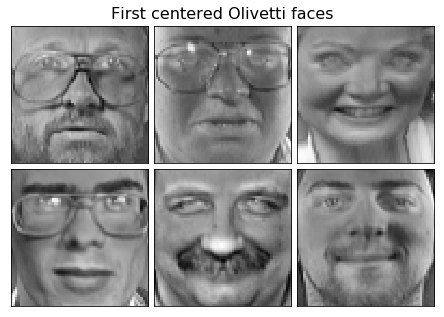

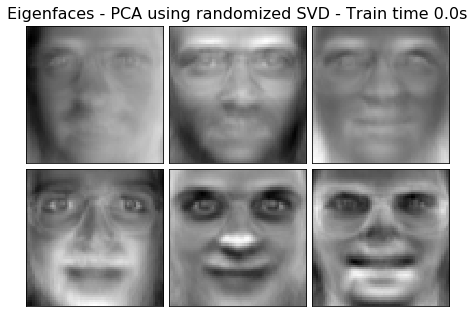

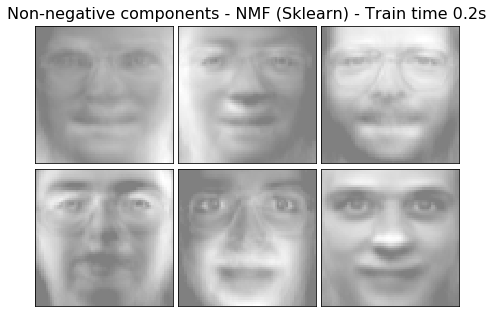

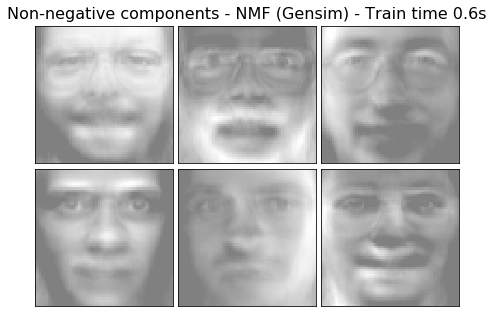

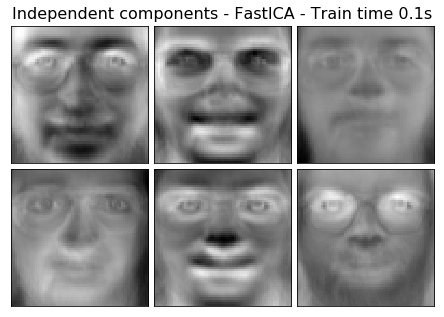

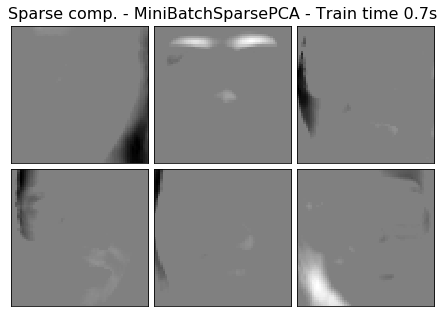

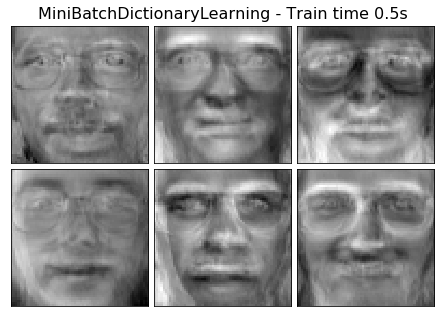

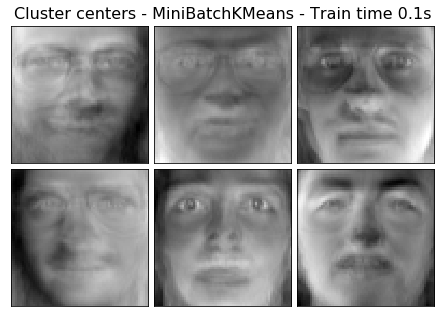

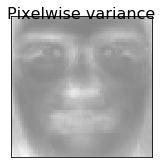

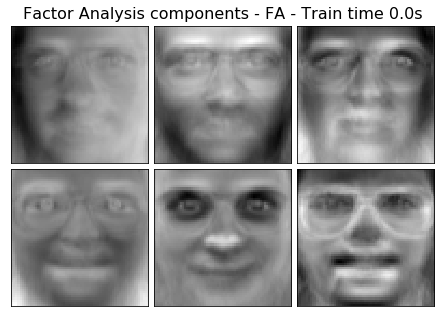

In [51]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 claus

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         bow_matrix=faces.T,
         chunksize=3,
         eval_every=400,
         passes=2,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0,
         random_state=42,
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time.time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time.time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

As you can see, Gensim's NMF implementation is slower than Sklearn's on **dense** vectors, while achieving comparable quality.

# Conclusion

Gensim NMF is an extremely fast and memory-optimized model. Use it to obtain interpretable topics, as an alternative to SVD / LDA.

---

The NMF implementation in Gensim was created by [Timofey Yefimov](https://github.com/anotherbugmaster/) as a part of his [RARE Technologies Student Incubator](https://rare-technologies.com/incubator/) graduation project.